In [1]:
from transformers import BartTokenizer, BartModel
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
import numpy as np
from datasets import load_dataset
import random
import torch
import matplotlib.pyplot as plt

2024-02-02 00:26:15.057408: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 00:26:15.076776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 00:26:15.076794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 00:26:15.077290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 00:26:15.080718: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from random import randint
from pattern.en import pluralize, singularize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/local/ASURITE/bpathir1/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/local/ASURITE/bpathir1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/local/ASURITE/bpathir1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/local/ASURITE/bpathir1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
sentence = "This is an example sentence showing off the verb extraction capabilities."
tokens = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(tokens)

verbs = [word for word, tag in tagged if tag.startswith('VB')]
adjectives = [word for word, tag in tagged if tag.startswith('JJ')]
nouns = [word for word, tag in tagged if tag.startswith('NN')]

In [4]:
def check_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    nouns = [word for word, tag in tagged if tag.startswith('NN')]
    verbs = [word for word, tag in tagged if tag.startswith('VB')]
    adjectives = [word for word, tag in tagged if tag.startswith('JJ')]

    if len(nouns) + len(verbs) +len(adjectives) == 0:
        return True
    else:
        return False



def drop_noun(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    nouns = [word for word, tag in tagged if tag.startswith('NN')]

    # If there are nouns, drop a random one
    if nouns:
        noun_to_drop = random.choice(nouns)
        tokens = [token for token in tokens if token != noun_to_drop]
        return ' '.join(tokens)
    else:
        # Return the original sentence if there are no nouns
        return sentence

def drop_verb(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    verbs = [word for word, tag in tagged if tag.startswith('VB')]

    # If there are verbs, drop a random one
    if verbs:
        verb_to_drop = random.choice(verbs)
        tokens = [token for token in tokens if token != verb_to_drop]
        print(tokens)
        print(' '.join(tokens))
        return ' '.join(tokens)
    else:
        # Return the original sentence if there are no verbs
        return sentence

def drop_adjective(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    adjectives = [word for word, tag in tagged if tag.startswith('JJ')]

    # If there are adjectives, drop a random one
    if adjectives:
        adjective_to_drop = random.choice(adjectives)
        tokens = [token for token in tokens if token != adjective_to_drop]
        return ' '.join(tokens)
    else:
        # Return the original sentence if there are no adjectives
        return sentence

In [5]:
from transformers import pipeline
from transformers import pipeline, BartTokenizer

model_name = "facebook/bart-large-cnn"
summarizer = pipeline("summarization", model=model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

def get_summary(original_sentence):
    # Tokenize the input and truncate if it's too long
    tokens = tokenizer.encode(original_sentence, add_special_tokens=False)
    max_length_allowed = tokenizer.model_max_length
    if len(tokens) > max_length_allowed:
        # Truncate the tokens to the maximum length allowed
        tokens = tokens[:max_length_allowed]

    # Convert tokens back to text
    truncated_text = tokenizer.decode(tokens, skip_special_tokens=True)

    # Summarize the truncated text
    summary = summarizer(truncated_text, max_length=500, min_length=30, do_sample=False)
    return summary[0]['summary_text']


In [6]:
import sacrebleu

def calculate_bleu_score(candidate, reference):
    """
    Calculate the BLEU score for a candidate sentence given a reference sentence.

    Args:
    candidate (str): The summarized text (candidate translation).
    reference (str): The reference text (reference translation).

    Returns:
    float: The BLEU score.
    """
    bleu = sacrebleu.corpus_bleu([candidate], [[reference]])
    return bleu.score

candidate_summary = "The scientist presented her climate change research at a conference, calling for urgent action."
reference_summary = "At the conference, the scientist highlighted the need for immediate measures against climate change."

bleu_score = calculate_bleu_score(candidate_summary, reference_summary)
print(f"BLEU Score: {bleu_score}")


BLEU Score: 7.955891555490761


In [7]:
from transformers import BartTokenizer, BartModel
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
import numpy as np
from datasets import load_dataset
import random
import torch

dataset = load_dataset("openai/summarize_from_feedback", 'axis')

action_list = [
    drop_noun,
    drop_verb,
    drop_adjective
]

action_list_name = [
  'drop_noun',
    'drop_verb',
    'drop_adjective'
]

sentence = "Your example sentence here."
index = 2
action_list[index](sentence)

'Your example sentence here.'

In [8]:
class BARTEmbedder:
    def __init__(self):
        self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        self.model = BartModel.from_pretrained('facebook/bart-large')
        self.target_dim = 1024  # Target embedding dimension

    def get_embedding(self, text):
        # Tokenize with truncation
        inputs = self.tokenizer(text, return_tensors='pt', max_length=1024, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        embeddings = outputs.encoder_last_hidden_state
        embeddings = torch.mean(embeddings, dim=1)

        # Adjust the embedding to have the target dimension
        embedding_dim = embeddings.shape[1]
        if embedding_dim > self.target_dim:
            embeddings = embeddings[:, :self.target_dim]
        elif embedding_dim < self.target_dim:
            padding = torch.zeros((embeddings.shape[0], self.target_dim - embedding_dim))
            embeddings = torch.cat([embeddings, padding], dim=1)

        return embeddings.cpu().numpy()


class NLPEnv(gym.Env):
    def __init__(self):
        super(NLPEnv, self).__init__()
        self.dataset = dataset
        self.current_word = None
        self.ground_truth = None
        self.embedder = BARTEmbedder()
        embedding_dim = 1024
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(embedding_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(3)
        self.count = 0

        action_list = [
            drop_noun,
            drop_verb,
            drop_adjective
        ]


    def reset(self):
        self.count = 0
        random_index = random.randint(0, len(self.dataset['test']['info']) - 1)
        self.current_word = self.dataset['test']['info'][random_index]['article'][:3500]
        self.ground_truth = self.dataset['test']['summary'][random_index]['text'][:3500]
        return self.embedder.get_embedding(self.current_word)

    def step(self, action):
        
        check = check_sentence(self.current_word)

        prediction = action_list[action](self.current_word)
        prediction = ' '.join(prediction)
        bleu_score = calculate_bleu_score(prediction, get_summary(prediction))
        reward = bleu_score
        done = False
        self.current_word = prediction

        if check:
            done = True
        self.count +=1
        print(f'Reward: {reward} Action: {action_list_name[action]} Word length: {len(self.current_word)} Prediction length: {len(prediction)}')
        if reward < 5.0:
            done = True
            steps.append(self.count) 
            print('EPISODE COMPLETE')    
               
        return self.embedder.get_embedding(prediction), reward, done, {'current_word': self.current_word}


In [14]:
env = DummyVecEnv([lambda: NLPEnv()])
dqn_model_bart_multi = DQN("MlpPolicy", env, verbose=1, exploration_final_eps=0.6, exploration_initial_eps=1.0)#DQN model

Using cuda device


/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.21GB > 6.94GB
  warnings.warn(


In [50]:
steps = []

dqn_model_bart_multi.learn(10000)
# dqn_model_bart_multi.save('dqn_model_bart_multi')

Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 94.74980601231705 Action: drop_adjectives Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 100.00000000000004 Action: drop_adjectives Word length: 233 Prediction length: 233
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 70.42783966512336 Action: drop_adjectives Word length: 126 Prediction length: 126


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.335496684492853 Action: drop_adjectives Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 26.855481398256355 Action: drop_verb Word length: 636 Prediction length: 636


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.3753420737433 Action: drop_noun Word length: 97 Prediction length: 97
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 19.39944089611901 Action: drop_verb Word length: 525 Prediction length: 525


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 16.623163485126575 Action: drop_noun Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 17       |
|    total_timesteps  | 12       |
----------------------------------
Reward: 18.335436268927666 Action: drop_noun Word length: 1308 Prediction length: 1308
Reward: 18.94502026976021 Action: drop_noun Word length: 1163 Prediction length: 1163
Reward: 18.91121545453941 Action: drop_noun Word length: 1127 Prediction length: 1127
Reward: 18.639954570619906 Action: drop_noun Word length: 1107 Prediction length: 1107
Reward: 18.12803101704742 Action: drop_noun Word length: 1103 Prediction length: 1103
Reward: 18.12803101704742 Action: drop_noun Word length: 1103 Prediction length: 1103

Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 35.24126340144758 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 55.234999040723025 Action: drop_verb Word length: 414 Prediction length: 414


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 55.71442143076478 Action: drop_verb Word length: 384 Prediction length: 384


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.21795402529576 Action: drop_verb Word length: 379 Prediction length: 379
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.33653568690601 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 0        |
|    time_elapsed     | 46       |
|    total_timesteps  | 27       |
----------------------------------


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 24.876428085321418 Action: drop_verb Word length: 530 Prediction length: 530


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 1.6145425166934728 Action: drop_verb Word length: 422 Prediction length: 422
EPISODE COMPLETE
Reward: 29.337284263667303 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.455142624448973 Action: drop_adjectives Word length: 66 Prediction length: 66
EPISODE COMPLETE
Reward: 18.29358834284119 Action: drop_noun Word length: 1348 Prediction length: 1348
Reward: 20.904681119691062 Action: drop_noun Word length: 1248 Prediction length: 1248
Reward: 16.671146543753583 Action: drop_noun Word length: 1233 Prediction length: 1233


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 0        |
|    time_elapsed     | 63       |
|    total_timesteps  | 36       |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.71474438253495 Action: drop_adjectives Word length: 232 Prediction length: 232
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.33653568690601 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 26.541234595576515 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 32.95320998144327 Action: drop_verb Word length: 583 Prediction length: 583


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 34.83654975513334 Action: drop_verb Word length: 553 Prediction length: 553


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.180249181082935 Action: drop_verb Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 40.77651227558083 Action: drop_noun Word length: 797 Prediction length: 797


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.022688051428162884 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 0        |
|    time_elapsed     | 81       |
|    total_timesteps  | 47       |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 91.37461982205068 Action: drop_verb Word length: 184 Prediction length: 184
Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 90.6708542436026 Action: drop_adjectives Word length: 339 Prediction length: 339


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 87.21827599607714 Action: drop_adjectives Word length: 265 Prediction length: 265
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 24.102962128005313 Action: drop_verb Word length: 571 Prediction length: 571


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 8.914411873328605 Action: drop_noun Word length: 54 Prediction length: 54
Reward: 0.00733799085404856 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 85.17327794564397 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 0        |
|    time_elapsed     | 100      |
|    total_timesteps  | 58       |
----------------------------------


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 24.810458609443483 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.498963883646454 Action: drop_noun Word length: 132 Prediction length: 132
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 42.20633297786397 Action: drop_adjectives Word length: 522 Prediction length: 522


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.124047014539045 Action: drop_adjectives Word length: 439 Prediction length: 439
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 66.44851135187889 Action: drop_adjectives Word length: 419 Prediction length: 419


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 8.246728969464554 Action: drop_noun Word length: 99 Prediction length: 99
Reward: 0.0 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 23.603839543644277 Action: drop_verb Word length: 767 Prediction length: 767


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 11.78270190918943 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.477853915925765 Action: drop_noun Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 0        |
|    time_elapsed     | 121      |
|    total_timesteps  | 70       |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 18.074907248027145 Action: drop_adjectives Word length: 192 Prediction length: 192
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617
Reward: 0.785524678436902 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE
Reward: 15.79659403679161 Action: drop_noun Word length: 877 Prediction length: 877
Reward: 21.71674164248958 Action: drop_noun Word length: 822 Prediction length: 822


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 4.922823000552757 Action: drop_noun Word length: 1392 Prediction length: 1392
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 0        |
|    time_elapsed     | 138      |
|    total_timesteps  | 78       |
----------------------------------
Reward: 31.187167131215272 Action: drop_noun Word length: 1012 Prediction length: 1012


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.49106570652106646 Action: drop_verb Word length: 92 Prediction length: 92
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 89.37901907145338 Action: drop_verb Word length: 276 Prediction length: 276
Reward: 2.5203160193367102 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 286 Prediction length: 286


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 91.7977561325962 Action: drop_adjectives Word length: 242 Prediction length: 242


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.58894144370433 Action: drop_adjectives Word length: 229 Prediction length: 229
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 11.205812975785518 Action: drop_noun Word length: 1385 Prediction length: 1385


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 52.35834657149972 Action: drop_verb Word length: 128 Prediction length: 128
Reward: 1.499557682047771 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 0        |
|    time_elapsed     | 160      |
|    total_timesteps  | 89       |
----------------------------------
Reward: 32.36458589207217 Action: drop_noun Word length: 1105 Prediction length: 1105
Reward: 3.9393364005744216 Action: drop_noun Word length: 979 Prediction length: 979
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 53.55142613446505 Action: drop_adjectives Word length: 136 Prediction length: 136
Reward: 0.02820893212548129 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 28.61467052547024 Action: drop_verb Word length: 445 Prediction length: 445
Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 1.4908949017679367 Action: drop_adjectives Word length: 458 Prediction length: 458
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 0        |
|    time_elapsed     | 174      |
|    total_timesteps  | 96       |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 0.8733042428534794 Action: drop_adjectives Word length: 332 Prediction length: 332
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 23.307899760858334 Action: drop_adjectives Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 38.300644447917605 Action: drop_adjectives Word length: 122 Prediction length: 122


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.822052015775913 Action: drop_adjectives Word length: 118 Prediction length: 118
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 38.143576605544865 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 91.98098208399195 Action: drop_noun Word length: 137 Prediction length: 137
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 81.08704755314416 Action: drop_verb Word length: 377 Prediction length: 377


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.188453870564215 Action: drop_noun Word length: 76 Prediction length: 76
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 0        |
|    time_elapsed     | 191      |
|    total_timesteps  | 107      |
----------------------------------
Reward: 29.45075431481815 Action: drop_noun Word length: 1242 Prediction length: 1242


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.006372411897069753 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.4713528757149 Action: drop_noun Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 0.7567143835953722 Action: drop_verb Word length: 372 Prediction length: 372
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 309 Prediction length: 309
Reward: 0.1361919386333735 Action: drop_noun Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.954    |
| time/               |          |
|    episodes         | 44       |
|    fps              | 0        |
|    time_elapsed     | 205      |
|    total_timesteps  | 114      |
----------------------------------


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 55.65586141451993 Action: drop_verb Word length: 631 Prediction length: 631
Reward: 0.0 Action: drop_noun Word length: 65 Prediction length: 65
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.18671542952257 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 25.579310727459937 Action: drop_noun Word length: 1406 Prediction length: 1406


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.05812675863609595 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE
Reward: 9.883437747990138 Action: drop_noun Word length: 1198 Prediction length: 1198


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 53.64453885320893 Action: drop_verb Word length: 114 Prediction length: 114


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.172478118081251 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 48       |
|    fps              | 0        |
|    time_elapsed     | 225      |
|    total_timesteps  | 125      |
----------------------------------


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.96078612365913 Action: drop_adjectives Word length: 296 Prediction length: 296
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 89.37901907145338 Action: drop_verb Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 44.19391518746832 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE
Reward: 17.19955832628257 Action: drop_noun Word length: 1444 Prediction length: 1444
Reward: 2.170130209335461 Action: drop_noun Word length: 1259 Prediction length: 1259
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 0        |
|    time_elapsed     | 241      |
|    total_timesteps  | 133      |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 59.95248045949402 Action: drop_adjectives Word length: 298 Prediction length: 298


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.42380825648357 Action: drop_adjectives Word length: 220 Prediction length: 220
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 24.512917628649646 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 53.65931772471406 Action: drop_verb Word length: 381 Prediction length: 381


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 37.41826593888319 Action: drop_verb Word length: 374 Prediction length: 374
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 85.17327794564397 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 1.2196223684528658 Action: drop_verb Word length: 136 Prediction length: 136
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 0        |
|    time_elapsed     | 259      |
|    total_timesteps  | 144      |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 93.74115725907134 Action: drop_adjectives Word length: 248 Prediction length: 248
Reward: 0.24923893318211085 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.98491110969029 Action: drop_verb Word length: 534 Prediction length: 534
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 53.71490991754293 Action: drop_adjectives Word length: 371 Prediction length: 371


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.091942428425 Action: drop_adjectives Word length: 317 Prediction length: 317
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 8.967427209023642 Action: drop_noun Word length: 1554 Prediction length: 1554


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 5.549921551011681 Action: drop_adjectives Word length: 84 Prediction length: 84
Reward: 3.567399334725242 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 0        |
|    time_elapsed     | 277      |
|    total_timesteps  | 154      |
----------------------------------


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 41.91501533737162 Action: drop_verb Word length: 539 Prediction length: 539
Reward: 0.15084012456490833 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 55.96270450207145 Action: drop_verb Word length: 502 Prediction length: 502


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 50.68825886732291 Action: drop_verb Word length: 418 Prediction length: 418
Reward: 3.5438606931964034 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 60.861745223273054 Action: drop_verb Word length: 453 Prediction length: 453
Reward: 0.0 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.677432947392926 Action: drop_adjectives Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 0        |
|    time_elapsed     | 292      |
|    total_timesteps  | 163      |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 60.55433799039797 Action: drop_adjectives Word length: 320 Prediction length: 320
Reward: 0.20294306362957348 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 26.237490173187705 Action: drop_verb Word length: 562 Prediction length: 562
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 41.8785357898739 Action: drop_adjectives Word length: 341 Prediction length: 341


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 70.8311611564776 Action: drop_adjectives Word length: 231 Prediction length: 231
Reward: 3.237024556157192 Action: drop_adjectives Word length: 187 Prediction length: 187
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 2.2694309136445803 Action: drop_adjectives Word length: 258 Prediction length: 258
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 0        |
|    time_elapsed     | 305      |
|    total_timesteps  | 171      |
----------------------------------


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 2.917627777667694 Action: drop_noun Word length: 353 Prediction length: 353
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 39.2100469766765 Action: drop_verb Word length: 615 Prediction length: 615


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.251885509304564 Action: drop_noun Word length: 84 Prediction length: 84
Reward: 3.6292508442781917 Action: drop_verb Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 4.645061850138481 Action: drop_adjectives Word length: 139 Prediction length: 139
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 1.9830641686418733 Action: drop_adjectives Word length: 198 Prediction length: 198
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.929    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 0        |
|    time_elapsed     | 317      |
|    total_timesteps  | 177      |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 81.50965917893309 Action: drop_adjectives Word length: 452 Prediction length: 452


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.286829310354415 Action: drop_adjectives Word length: 387 Prediction length: 387
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 9.634541497759503 Action: drop_noun Word length: 1083 Prediction length: 1083
Reward: 1.725755154213534 Action: drop_noun Word length: 906 Prediction length: 906
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 45.479556891261616 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 38.69665390895345 Action: drop_noun Word length: 91 Prediction length: 91
Reward: 0.940356255149521 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 59.19743410620021 Action: drop_adjectives Word length: 446 Prediction length: 446


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.412335260282287 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 0        |
|    time_elapsed     | 336      |
|    total_timesteps  | 188      |
----------------------------------


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 69.77220103106566 Action: drop_verb Word length: 606 Prediction length: 606
Reward: 4.455142624448973 Action: drop_noun Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 73.44326819406938 Action: drop_adjectives Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 46.60716723081867 Action: drop_verb Word length: 412 Prediction length: 412


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 60.370229961962735 Action: drop_verb Word length: 310 Prediction length: 310


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 58.73324106756683 Action: drop_verb Word length: 300 Prediction length: 300


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 58.73324106756683 Action: drop_verb Word length: 300 Prediction length: 300
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 33.987078567678545 Action: drop_adjectives Word length: 322 Prediction length: 322


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.792156291054335 Action: drop_noun Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 0        |
|    time_elapsed     | 355      |
|    total_timesteps  | 200      |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 79.78655426322598 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.26147845098287714 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 98.05831403241092 Action: drop_adjectives Word length: 377 Prediction length: 377
Reward: 0.3269653562747845 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 40.10616305591001 Action: drop_verb Word length: 488 Prediction length: 488
Reward: 0.10722886563867083 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 41.14724170371062 Action: drop_verb Word length: 618 Prediction length: 618


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 37.38834146572942 Action: drop_verb Word length: 435 Prediction length: 435


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 42.60679154965776 Action: drop_verb Word length: 374 Prediction length: 374


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 43.05815898154918 Action: drop_verb Word length: 356 Prediction length: 356
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 0        |
|    time_elapsed     | 373      |
|    total_timesteps  | 211      |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 75.13309895827152 Action: drop_verb Word length: 348 Prediction length: 348
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 22.806489429791082 Action: drop_noun Word length: 1527 Prediction length: 1527


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 42.0802756855725 Action: drop_verb Word length: 93 Prediction length: 93


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.913157332576407 Action: drop_noun Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 0.0 Action: drop_adjectives Word length: 185 Prediction length: 185
EPISODE COMPLETE
Reward: 5.430536088255014 Action: drop_noun Word length: 1271 Prediction length: 1271


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.110333239232979 Action: drop_verb Word length: 60 Prediction length: 60
Reward: 0.0 Action: drop_adjectives Word length: 2 Prediction length: 2
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.912    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 0        |
|    time_elapsed     | 389      |
|    total_timesteps  | 221      |
----------------------------------


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 6.325028942922458 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 2.8558921985509347 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE
Reward: 9.563161716659806 Action: drop_noun Word length: 1476 Prediction length: 1476


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.37567093235574 Action: drop_adjectives Word length: 53 Prediction length: 53
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 78.94598453136346 Action: drop_verb Word length: 306 Prediction length: 306
Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.36673318472835 Action: drop_verb Word length: 149 Prediction length: 149
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.908    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 0        |
|    time_elapsed     | 403      |
|    total_timesteps  | 230      |
----------------------------------


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 33.746036000330015 Action: drop_verb Word length: 432 Prediction length: 432
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 27.498459676926796 Action: drop_adjectives Word length: 340 Prediction length: 340
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 23.125626353607167 Action: drop_adjectives Word length: 71 Prediction length: 71
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 33.500549407073635 Action: drop_noun Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.5165051229179323 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 0        |
|    time_elapsed     | 419      |
|    total_timesteps  | 240      |
----------------------------------


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 24.554400281545902 Action: drop_verb Word length: 626 Prediction length: 626


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 16.02831909855087 Action: drop_noun Word length: 79 Prediction length: 79
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 60.81694935992016 Action: drop_verb Word length: 298 Prediction length: 298
Reward: 0.014531689659023978 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 19.738121363229276 Action: drop_noun Word length: 1404 Prediction length: 1404


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 0.42498050255275827 Action: drop_adjectives Word length: 139 Prediction length: 139
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 97.10165517924376 Action: drop_adjectives Word length: 205 Prediction length: 205


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.25231057044076 Action: drop_adjectives Word length: 171 Prediction length: 171
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 100      |
|    fps              | 0        |
|    time_elapsed     | 437      |
|    total_timesteps  | 250      |
----------------------------------


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 42.697164634660126 Action: drop_adjectives Word length: 102 Prediction length: 102
Reward: 0.242637224857426 Action: drop_adjectives Word length: 54 Prediction length: 54
EPISODE COMPLETE
Reward: 23.060095522811118 Action: drop_verb Word length: 768 Prediction length: 768


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 22.714567003785138 Action: drop_adjectives Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 18.619147304196098 Action: drop_adjectives Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 0        |
|    time_elapsed     | 449      |
|    total_timesteps  | 258      |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.87294609944325 Action: drop_adjectives Word length: 339 Prediction length: 339
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 72.71531923147352 Action: drop_adjectives Word length: 227 Prediction length: 227


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.43791127685998 Action: drop_adjectives Word length: 198 Prediction length: 198
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 1.637440406166366 Action: drop_adjectives Word length: 211 Prediction length: 211
EPISODE COMPLETE
Reward: 6.04290187292591 Action: drop_noun Word length: 686 Prediction length: 686


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.894    |
| time/               |          |
|    episodes         | 108      |
|    fps              | 0        |
|    time_elapsed     | 463      |
|    total_timesteps  | 266      |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 83.85130047130204 Action: drop_adjectives Word length: 222 Prediction length: 222
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 1.954496754938761 Action: drop_noun Word length: 1694 Prediction length: 1694
EPISODE COMPLETE
Reward: 24.88495291821715 Action: drop_noun Word length: 920 Prediction length: 920


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.7296423164252336 Action: drop_verb Word length: 72 Prediction length: 72
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.05022099928871 Action: drop_verb Word length: 299 Prediction length: 299
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 112      |
|    fps              | 0        |
|    time_elapsed     | 478      |
|    total_timesteps  | 274      |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 33.6928034739106 Action: drop_verb Word length: 520 Prediction length: 520


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 22.58512707324754 Action: drop_noun Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 66.38477169929855 Action: drop_verb Word length: 188 Prediction length: 188
Reward: 0.4638859245933917 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 41.320573853996926 Action: drop_noun Word length: 1390 Prediction length: 1390
Reward: 41.92378406621812 Action: drop_noun Word length: 1191 Prediction length: 1191
Reward: 37.512698278862885 Action: drop_noun Word length: 1074 Prediction length: 1074


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.05869665193084 Action: drop_adjectives Word length: 261 Prediction length: 261
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 116      |
|    fps              | 0        |
|    time_elapsed     | 502      |
|    total_timesteps  | 285      |
----------------------------------


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559
Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 30.209384351069506 Action: drop_verb Word length: 491 Prediction length: 491
Reward: 0.029132034688879756 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 31.130144419104482 Action: drop_adjectives Word length: 459 Prediction length: 459
Reward: 4.7703268006082 Action: drop_noun Word length: 64 Prediction length: 64
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.804621034486104 Action: drop_adjectives Word length: 121 Prediction length: 121
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 120      |
|    fps              | 0        |
|    time_elapsed     | 516      |
|    total_timesteps  | 293      |
----------------------------------
Reward: 18.54912469961235 Action: drop_noun Word length: 1307 Prediction length: 1307
Reward: 18.751121586524143 Action: drop_noun Word length: 1043 Prediction length: 1043


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.2239805433287987 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 27.429086639246275 Action: drop_adjectives Word length: 388 Prediction length: 388
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 25.579310727459937 Action: drop_noun Word length: 1406 Prediction length: 1406


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.05812675863609595 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 4.317044175296312 Action: drop_adjectives Word length: 152 Prediction length: 152
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 124      |
|    fps              | 0        |
|    time_elapsed     | 531      |
|    total_timesteps  | 301      |
----------------------------------
Reward: 17.05155789825768 Action: drop_noun Word length: 1199 Prediction length: 1199


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 32.62410112472993 Action: drop_verb Word length: 636 Prediction length: 636


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.5445224342696955 Action: drop_noun Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 53.627816074319476 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 43.0794703693266 Action: drop_verb Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 48.180812763865866 Action: drop_adjectives Word length: 610 Prediction length: 610
Reward: 0.0 Action: drop_verb Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 0        |
|    time_elapsed     | 548      |
|    total_timesteps  | 311      |
----------------------------------
Reward: 3.2071463963763294 Action: drop_noun Word length: 912 Prediction length: 912
EPISODE COMPLETE
Reward: 17.567795584895926 Action: drop_noun Word length: 1338 Prediction length: 1338
Reward: 46.903593075863526 Action: drop_noun Word length: 1064 Prediction length: 1064


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.9359980083994823 Action: drop_verb Word length: 88 Prediction length: 88
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 21.496881004904985 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 36.82203087143129 Action: drop_verb Word length: 522 Prediction length: 522


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.32470426244728 Action: drop_verb Word length: 488 Prediction length: 488
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 14.40128907042318 Action: drop_noun Word length: 1552 Prediction length: 1552


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.1983145132445213 Action: drop_verb Word length: 65 Prediction length: 65
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.872    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 0        |
|    time_elapsed     | 567      |
|    total_timesteps  | 321      |
----------------------------------
Reward: 25.938880375814573 Action: drop_noun Word length: 1380 Prediction length: 1380


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.4375152015265529 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 1.0963943439555317 Action: drop_noun Word length: 1303 Prediction length: 1303
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 32.59817872204228 Action: drop_verb Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 67.69664199222687 Action: drop_noun Word length: 148 Prediction length: 148
Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 20.20898132116738 Action: drop_verb Word length: 566 Prediction length: 566


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.868    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 0        |
|    time_elapsed     | 582      |
|    total_timesteps  | 329      |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 60.72495709532264 Action: drop_verb Word length: 357 Prediction length: 357


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 57.86623282576918 Action: drop_verb Word length: 198 Prediction length: 198
Reward: 0.0009311743351298477 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 39.874963362857386 Action: drop_verb Word length: 603 Prediction length: 603


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 12.66071027890836 Action: drop_noun Word length: 97 Prediction length: 97
Reward: 0.19344352272859558 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 24.73702375651968 Action: drop_verb Word length: 634 Prediction length: 634


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 89.10233766955567 Action: drop_noun Word length: 186 Prediction length: 186


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 36.78794411714425 Action: drop_noun Word length: 100 Prediction length: 100


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 8.848212044257437 Action: drop_noun Word length: 62 Prediction length: 62
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 66 Prediction length: 66


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 6.948345122280157 Action: drop_noun Word length: 36 Prediction length: 36
Reward: 0.8651695203120637 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.862    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 0        |
|    time_elapsed     | 604      |
|    total_timesteps  | 344      |
----------------------------------
Reward: 23.761506189720475 Action: drop_noun Word length: 867 Prediction length: 867
Reward: 25.776159868105463 Action: drop_noun Word length: 745 Prediction length: 745


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 79.57498879172284 Action: drop_adjectives Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 25.83465822156255 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 43.21556008496388 Action: drop_noun Word length: 147 Prediction length: 147
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559
Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 144      |
|    fps              | 0        |
|    time_elapsed     | 622      |
|    total_timesteps  | 354      |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 53.81086848884225 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 28.62081897671616 Action: drop_verb Word length: 702 Prediction length: 702
Reward: 1.5401555084618097 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 18.27633347146749 Action: drop_verb Word length: 621 Prediction length: 621
Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 34.55249391371169 Action: drop_verb Word length: 407 Prediction length: 407


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.6946590796916 Action: drop_verb Word length: 330 Prediction length: 330
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 148      |
|    fps              | 0        |
|    time_elapsed     | 637      |
|    total_timesteps  | 363      |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 90.0390352285154 Action: drop_adjectives Word length: 304 Prediction length: 304


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.07894391523236 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 19.4304080138357 Action: drop_verb Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 81.36749447931932 Action: drop_noun Word length: 164 Prediction length: 164


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 11.29308369770076 Action: drop_verb Word length: 87 Prediction length: 87
Reward: 0.0 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 1.3705063051209185 Action: drop_adjectives Word length: 321 Prediction length: 321
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 25.13195864511859 Action: drop_verb Word length: 558 Prediction length: 558
Reward: 2.786346462409789 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 0        |
|    time_elapsed     | 655      |
|    total_timesteps  | 373      |
----------------------------------
Reward: 16.036646155198813 Action: drop_noun Word length: 1541 Prediction length: 1541


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.913374169932275 Action: drop_verb Word length: 156 Prediction length: 156
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 25.040639634203146 Action: drop_verb Word length: 738 Prediction length: 738


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 2.0495037210758555 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 75.11573912724296 Action: drop_adjectives Word length: 130 Prediction length: 130
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 91.99256819123299 Action: drop_adjectives Word length: 261 Prediction length: 261
Reward: 0.45059367310833814 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 0        |
|    time_elapsed     | 670      |
|    total_timesteps  | 382      |
----------------------------------
Reward: 47.533018855124574 Action: drop_noun Word length: 1253 Prediction length: 1253


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 6.248925772953941 Action: drop_verb Word length: 93 Prediction length: 93
Reward: 0.4684296182826792 Action: drop_noun Word length: 57 Prediction length: 57
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 35.00641877036591 Action: drop_verb Word length: 507 Prediction length: 507
Reward: 1.1652512227907519 Action: drop_verb Word length: 303 Prediction length: 303
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 26.052750996497867 Action: drop_verb Word length: 790 Prediction length: 790


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 35.5719357577933 Action: drop_noun Word length: 134 Prediction length: 134
Reward: 4.9787068367863965 Action: drop_verb Word length: 61 Prediction length: 61
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 39.01641699247673 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 40.91667855996278 Action: drop_verb Word length: 433 Prediction length: 433


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 56.01295940903786 Action: drop_verb Word length: 413 Prediction length: 413


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.81910844520478 Action: drop_verb Word length: 404 Prediction length: 404
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 0        |
|    time_elapsed     | 693      |
|    total_timesteps  | 395      |
----------------------------------


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 20.199546398051968 Action: drop_verb Word length: 363 Prediction length: 363
Reward: 4.966755718666527 Action: drop_noun Word length: 90 Prediction length: 90
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.78224175191426 Action: drop_verb Word length: 539 Prediction length: 539
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.370525090116367 Action: drop_noun Word length: 1400 Prediction length: 1400
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 1.5725309676927446 Action: drop_noun Word length: 624 Prediction length: 624
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 164      |
|    fps              | 0        |
|    time_elapsed     | 706      |
|    total_timesteps  | 401      |
----------------------------------
Reward: 20.664408254712725 Action: drop_verb Word length: 775 Prediction length: 775


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.00010677040100347832 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.098843195090424 Action: drop_noun Word length: 642 Prediction length: 642
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.696847359098165 Action: drop_adjectives Word length: 397 Prediction length: 397
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 42.673669321479494 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.86801739989424 Action: drop_verb Word length: 450 Prediction length: 450
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.836    |
| time/               |          |
|    episodes         | 168      |
|    fps              | 0        |
|    time_elapsed     | 722      |
|    total_timesteps  | 410      |
----------------------------------


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.24579032182338 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 35.26858001491236 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 55.124253779171234 Action: drop_verb Word length: 136 Prediction length: 136


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 14.843587359388678 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.0 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 43.262619126843454 Action: drop_noun Word length: 1341 Prediction length: 1341


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.798158071521481 Action: drop_verb Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.24578904778535 Action: drop_adjectives Word length: 187 Prediction length: 187
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.832    |
| time/               |          |
|    episodes         | 172      |
|    fps              | 0        |
|    time_elapsed     | 743      |
|    total_timesteps  | 421      |
----------------------------------


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 31.722377131186988 Action: drop_verb Word length: 538 Prediction length: 538


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.63241240817797 Action: drop_verb Word length: 369 Prediction length: 369
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 5.444824103669782 Action: drop_adjectives Word length: 227 Prediction length: 227


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.48086373587563 Action: drop_adjectives Word length: 155 Prediction length: 155
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 245 Prediction length: 245
Reward: 2.5642860542324164 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 23.04990840388563 Action: drop_noun Word length: 682 Prediction length: 682
Reward: 1.5401555084618097 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 176      |
|    fps              | 0        |
|    time_elapsed     | 758      |
|    total_timesteps  | 431      |
----------------------------------


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.907159170970104 Action: drop_verb Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 33.908739486375424 Action: drop_verb Word length: 478 Prediction length: 478


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 54.037768178355805 Action: drop_verb Word length: 321 Prediction length: 321
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 27.661871032592938 Action: drop_verb Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.08673511425678922 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 1.0134961585174012 Action: drop_adjectives Word length: 337 Prediction length: 337
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 0        |
|    time_elapsed     | 773      |
|    total_timesteps  | 439      |
----------------------------------
Reward: 33.4599117265793 Action: drop_noun Word length: 1251 Prediction length: 1251


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.28985710751434707 Action: drop_adjectives Word length: 78 Prediction length: 78
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 87.98988959368486 Action: drop_adjectives Word length: 256 Prediction length: 256
Reward: 0.0 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 71.97506427620957 Action: drop_verb Word length: 471 Prediction length: 471


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 61.05553692581271 Action: drop_verb Word length: 307 Prediction length: 307
Reward: 0.6722067701439163 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 0        |
|    time_elapsed     | 790      |
|    total_timesteps  | 448      |
----------------------------------


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 39.2100469766765 Action: drop_verb Word length: 615 Prediction length: 615


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 54.03831852866609 Action: drop_verb Word length: 464 Prediction length: 464


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.3693158266098 Action: drop_verb Word length: 427 Prediction length: 427
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 21.496881004904985 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.82203087143129 Action: drop_verb Word length: 522 Prediction length: 522
Reward: 0.0 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 21.73136885873387 Action: drop_noun Word length: 978 Prediction length: 978


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 30.2213247450016 Action: drop_verb Word length: 97 Prediction length: 97
Reward: 4.214384350927641 Action: drop_verb Word length: 48 Prediction length: 48
EPISODE COMPLETE
Reward: 48.132450762201174 Action: drop_noun Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.1858627581531964 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 188      |
|    fps              | 0        |
|    time_elapsed     | 811      |
|    total_timesteps  | 460      |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 78.47231940537563 Action: drop_adjectives Word length: 260 Prediction length: 260
Reward: 0.0 Action: drop_noun Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.98663600557576 Action: drop_verb Word length: 299 Prediction length: 299


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.335509054805006 Action: drop_noun Word length: 51 Prediction length: 51
Reward: 0.3996965369040719 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 8.42110976103595 Action: drop_noun Word length: 1562 Prediction length: 1562


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.013490396091959471 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.907159170970104 Action: drop_verb Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.812    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 0        |
|    time_elapsed     | 827      |
|    total_timesteps  | 469      |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 43.6959742952743 Action: drop_verb Word length: 527 Prediction length: 527


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.178049532397588 Action: drop_noun Word length: 58 Prediction length: 58
Reward: 0.0005923436980314498 Action: drop_noun Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 90.74485692010053 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.05468988016936943 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE
Reward: 2.6727283358020264 Action: drop_noun Word length: 1290 Prediction length: 1290
EPISODE COMPLETE
Reward: 8.88045077140212 Action: drop_noun Word length: 1498 Prediction length: 1498


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.809    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 0        |
|    time_elapsed     | 842      |
|    total_timesteps  | 477      |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 15.18671542952257 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.032886593408830114 Action: drop_verb Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 27.926681562520944 Action: drop_adjectives Word length: 478 Prediction length: 478
Reward: 0.07667982759693039 Action: drop_verb Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 57.364849067805324 Action: drop_adjectives Word length: 253 Prediction length: 253


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 80.55576043689696 Action: drop_adjectives Word length: 168 Prediction length: 168
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 35.308084011776174 Action: drop_noun Word length: 1388 Prediction length: 1388
Reward: 24.242057645177017 Action: drop_noun Word length: 1227 Prediction length: 1227
Reward: 24.64276789463552 Action: drop_noun Word length: 1204 Prediction length: 1204
Reward: 24.64276789463552 Action: drop_noun Word length: 1204 Prediction length: 1204
Reward: 24.64276789463552 Action: drop_noun Word length: 1204 Prediction length: 1204


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.804    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 0        |
|    time_elapsed     | 868      |
|    total_timesteps  | 491      |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 32.742313284116264 Action: drop_verb Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 57.004567354948605 Action: drop_verb Word length: 360 Prediction length: 360
Reward: 0.0 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 56.78224175191426 Action: drop_verb Word length: 539 Prediction length: 539


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 32.583083154419846 Action: drop_noun Word length: 84 Prediction length: 84
Reward: 0.019946727195958868 Action: drop_verb Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 11.803917024290097 Action: drop_adjectives Word length: 294 Prediction length: 294


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.92332344763446 Action: drop_adjectives Word length: 269 Prediction length: 269
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 63.16700692551411 Action: drop_adjectives Word length: 304 Prediction length: 304


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.10678300389881 Action: drop_adjectives Word length: 223 Prediction length: 223
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.798    |
| time/               |          |
|    episodes         | 204      |
|    fps              | 0        |
|    time_elapsed     | 889      |
|    total_timesteps  | 504      |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 80.32172264375286 Action: drop_adjectives Word length: 283 Prediction length: 283
Reward: 3.511091977922844 Action: drop_adjectives Word length: 236 Prediction length: 236
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 1.2193311110766474 Action: drop_adjectives Word length: 227 Prediction length: 227
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.581741266967832 Action: drop_noun Word length: 725 Prediction length: 725


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.09039056888448514 Action: drop_verb Word length: 48 Prediction length: 48
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 208      |
|    fps              | 0        |
|    time_elapsed     | 901      |
|    total_timesteps  | 511      |
----------------------------------
Reward: 28.36882519042807 Action: drop_noun Word length: 812 Prediction length: 812


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 25.14977663766841 Action: drop_noun Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 28.36882519042807 Action: drop_noun Word length: 812 Prediction length: 812


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 25.14977663766841 Action: drop_noun Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 5.401757945396988 Action: drop_noun Word length: 1874 Prediction length: 1874


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 58.66253519523343 Action: drop_verb Word length: 344 Prediction length: 344


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 15.52406023686952 Action: drop_noun Word length: 58 Prediction length: 58
Reward: 0.16233119629655865 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 212      |
|    fps              | 0        |
|    time_elapsed     | 921      |
|    total_timesteps  | 522      |
----------------------------------


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 54.94991080816443 Action: drop_adjectives Word length: 319 Prediction length: 319
Reward: 0.030836258960159728 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 44.879277257106786 Action: drop_noun Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 20.189651799465548 Action: drop_verb Word length: 71 Prediction length: 71
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 17.5794593870669 Action: drop_noun Word length: 1396 Prediction length: 1396


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 6.362676745557341 Action: drop_adjectives Word length: 75 Prediction length: 75


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 33.241660012938524 Action: drop_noun Word length: 70 Prediction length: 70


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.241660012938524 Action: drop_noun Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 72.71531923147352 Action: drop_adjectives Word length: 227 Prediction length: 227


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 69.43791127685998 Action: drop_adjectives Word length: 198 Prediction length: 198


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 69.43791127685998 Action: drop_adjectives Word length: 198 Prediction length: 198


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.43791127685998 Action: drop_adjectives Word length: 198 Prediction length: 198
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 216      |
|    fps              | 0        |
|    time_elapsed     | 945      |
|    total_timesteps  | 537      |
----------------------------------
Reward: 4.202478303887828 Action: drop_noun Word length: 1137 Prediction length: 1137
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 28.176844963728662 Action: drop_verb Word length: 526 Prediction length: 526


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 29.437081141901537 Action: drop_noun Word length: 91 Prediction length: 91
Reward: 1.8315638888734187 Action: drop_verb Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 66.15205119971893 Action: drop_adjectives Word length: 158 Prediction length: 158


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 46.82329540349287 Action: drop_adjectives Word length: 135 Prediction length: 135


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.82329540349287 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 86.44818054200657 Action: drop_verb Word length: 322 Prediction length: 322
Reward: 0.0 Action: drop_noun Word length: 82 Prediction length: 82
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 0        |
|    time_elapsed     | 961      |
|    total_timesteps  | 547      |
----------------------------------
Reward: 16.48317841635173 Action: drop_noun Word length: 1296 Prediction length: 1296


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 4.31593092614526 Action: drop_verb Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 57.40720020853357 Action: drop_verb Word length: 480 Prediction length: 480
Reward: 0.0 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE
Reward: 21.962258586717894 Action: drop_noun Word length: 1377 Prediction length: 1377
Reward: 24.131903112096605 Action: drop_noun Word length: 1145 Prediction length: 1145
Reward: 21.343277106181095 Action: drop_noun Word length: 1092 Prediction length: 1092


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 33.4599117265793 Action: drop_noun Word length: 1251 Prediction length: 1251


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.28985710751434707 Action: drop_adjectives Word length: 78 Prediction length: 78
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.777    |
| time/               |          |
|    episodes         | 224      |
|    fps              | 0        |
|    time_elapsed     | 985      |
|    total_timesteps  | 557      |
----------------------------------
Reward: 3.0831315227175407 Action: drop_noun Word length: 1276 Prediction length: 1276
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 59.19743410620021 Action: drop_adjectives Word length: 446 Prediction length: 446
Reward: 0.13056072146186176 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 89.65921584388566 Action: drop_verb Word length: 393 Prediction length: 393


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.964811777276537 Action: drop_noun Word length: 73 Prediction length: 73
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 50.77257905564468 Action: drop_verb Word length: 605 Prediction length: 605


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes         | 228      |
|    fps              | 0        |
|    time_elapsed     | 1001     |
|    total_timesteps  | 565      |
----------------------------------


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 25.28371575628706 Action: drop_verb Word length: 740 Prediction length: 740


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.031488378888092736 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 57.40720020853357 Action: drop_verb Word length: 480 Prediction length: 480
Reward: 0.0 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE
Reward: 12.98909992188961 Action: drop_noun Word length: 1302 Prediction length: 1302


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.9504232015715106 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 18.074907248027145 Action: drop_adjectives Word length: 192 Prediction length: 192
Reward: 0.02401530262516502 Action: drop_noun Word length: 32 Prediction length: 32
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.771    |
| time/               |          |
|    episodes         | 232      |
|    fps              | 0        |
|    time_elapsed     | 1017     |
|    total_timesteps  | 573      |
----------------------------------


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 94.43716053164667 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 86.6538823474422 Action: drop_verb Word length: 240 Prediction length: 240
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 39.34389060442102 Action: drop_verb Word length: 494 Prediction length: 494


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.41359640863486 Action: drop_verb Word length: 293 Prediction length: 293
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 83.39679065405737 Action: drop_adjectives Word length: 361 Prediction length: 361


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 82.00123297196333 Action: drop_adjectives Word length: 283 Prediction length: 283
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 27.304171801674602 Action: drop_adjectives Word length: 260 Prediction length: 260
Reward: 0.011594367834189824 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.766    |
| time/               |          |
|    episodes         | 236      |
|    fps              | 0        |
|    time_elapsed     | 1035     |
|    total_timesteps  | 584      |
----------------------------------


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 30.83587120440849 Action: drop_verb Word length: 511 Prediction length: 511


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 44.685842889647304 Action: drop_verb Word length: 395 Prediction length: 395


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 54.75843087006894 Action: drop_verb Word length: 362 Prediction length: 362
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 15.31529004477137 Action: drop_noun Word length: 1037 Prediction length: 1037


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 59.21679048339992 Action: drop_verb Word length: 109 Prediction length: 109


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.118672542204877 Action: drop_noun Word length: 57 Prediction length: 57
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 27.51663057979009 Action: drop_verb Word length: 683 Prediction length: 683
Reward: 0.1266759369820151 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE
Reward: 19.688261086927916 Action: drop_noun Word length: 1275 Prediction length: 1275


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.4264233908999262 Action: drop_adjectives Word length: 53 Prediction length: 53
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.762    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 0        |
|    time_elapsed     | 1054     |
|    total_timesteps  | 596      |
----------------------------------


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 69.77220103106566 Action: drop_verb Word length: 606 Prediction length: 606


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 4.455142624448973 Action: drop_noun Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.44392045937544 Action: drop_adjectives Word length: 126 Prediction length: 126
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE
Reward: 47.533018855124574 Action: drop_noun Word length: 1253 Prediction length: 1253


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.248925772953941 Action: drop_verb Word length: 93 Prediction length: 93
Reward: 0.03365132829885685 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 18.451006803460892 Action: drop_noun Word length: 906 Prediction length: 906
Reward: 31.90214629035711 Action: drop_noun Word length: 748 Prediction length: 748


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.758    |
| time/               |          |
|    episodes         | 244      |
|    fps              | 0        |
|    time_elapsed     | 1075     |
|    total_timesteps  | 606      |
----------------------------------
Reward: 43.262619126843454 Action: drop_noun Word length: 1341 Prediction length: 1341
Reward: 46.85723142793472 Action: drop_noun Word length: 1232 Prediction length: 1232
Reward: 45.78413071793206 Action: drop_noun Word length: 1202 Prediction length: 1202


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 30.68550602862163 Action: drop_noun Word length: 642 Prediction length: 642


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.22836409634514562 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 90.22045190074802 Action: drop_adjectives Word length: 337 Prediction length: 337


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.43348130467292 Action: drop_adjectives Word length: 232 Prediction length: 232
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 17.950750391332047 Action: drop_verb Word length: 649 Prediction length: 649


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.407677394634394 Action: drop_verb Word length: 456 Prediction length: 456
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.753    |
| time/               |          |
|    episodes         | 248      |
|    fps              | 0        |
|    time_elapsed     | 1100     |
|    total_timesteps  | 618      |
----------------------------------
Reward: 20.434206154993504 Action: drop_noun Word length: 991 Prediction length: 991


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.7647708951721586 Action: drop_verb Word length: 102 Prediction length: 102
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 46.261044588838836 Action: drop_verb Word length: 429 Prediction length: 429
Reward: 0.025780504160252987 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 77.13094442363972 Action: drop_adjectives Word length: 427 Prediction length: 427


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 67.10414305369278 Action: drop_noun Word length: 122 Prediction length: 122


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_noun Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 33.314653957361664 Action: drop_noun Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 96.56187881844997 Action: drop_noun Word length: 567 Prediction length: 567


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 90.17560423336201 Action: drop_noun Word length: 518 Prediction length: 518


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.14112941011156 Action: drop_noun Word length: 496 Prediction length: 496
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 252      |
|    fps              | 0        |
|    time_elapsed     | 1124     |
|    total_timesteps  | 631      |
----------------------------------


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 69.77220103106566 Action: drop_verb Word length: 606 Prediction length: 606
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 53.08069056580594 Action: drop_verb Word length: 714 Prediction length: 714


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.91898484928994 Action: drop_verb Word length: 543 Prediction length: 543
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 29.035101205704372 Action: drop_noun Word length: 1540 Prediction length: 1540


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 1.4467750696395127 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.744    |
| time/               |          |
|    episodes         | 256      |
|    fps              | 0        |
|    time_elapsed     | 1144     |
|    total_timesteps  | 640      |
----------------------------------


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 43.063349931405696 Action: drop_adjectives Word length: 393 Prediction length: 393
Reward: 2.2493847365531097 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.29541518615926 Action: drop_adjectives Word length: 212 Prediction length: 212
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 51.12398546255494 Action: drop_verb Word length: 441 Prediction length: 441


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.20532131706034 Action: drop_verb Word length: 382 Prediction length: 382
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 19.738121363229276 Action: drop_noun Word length: 1404 Prediction length: 1404


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 87.05894364754819 Action: drop_verb Word length: 175 Prediction length: 175
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.74     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 0        |
|    time_elapsed     | 1162     |
|    total_timesteps  | 650      |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.11031288549718 Action: drop_adjectives Word length: 259 Prediction length: 259
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 37.664582662668984 Action: drop_verb Word length: 552 Prediction length: 552


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 0.5902722895276754 Action: drop_noun Word length: 104 Prediction length: 104
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.66813929730843 Action: drop_adjectives Word length: 154 Prediction length: 154
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 1.7487419695819 Action: drop_adjectives Word length: 130 Prediction length: 130
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.737    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 0        |
|    time_elapsed     | 1173     |
|    total_timesteps  | 657      |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 44.879277257106786 Action: drop_noun Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 5.261458892859376 Action: drop_noun Word length: 533 Prediction length: 533


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.4569352017722395 Action: drop_noun Word length: 508 Prediction length: 508
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 20.34373059444133 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.029132034688879756 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 162 Prediction length: 162
Reward: 0.0 Action: drop_adjectives Word length: 124 Prediction length: 124
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.95248045949402 Action: drop_adjectives Word length: 298 Prediction length: 298
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.733    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 0        |
|    time_elapsed     | 1191     |
|    total_timesteps  | 667      |
----------------------------------
Reward: 41.320573853996926 Action: drop_noun Word length: 1390 Prediction length: 1390


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.14772930752862 Action: drop_verb Word length: 141 Prediction length: 141
Reward: 0.0 Action: drop_adjectives Word length: 1 Prediction length: 1
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.432429864678003 Action: drop_verb Word length: 578 Prediction length: 578


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 0.7015981227790723 Action: drop_noun Word length: 86 Prediction length: 86
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 33.749219957615196 Action: drop_verb Word length: 657 Prediction length: 657


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 14.10560624361673 Action: drop_noun Word length: 91 Prediction length: 91
Reward: 1.9720231719744998 Action: drop_verb Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 57.20057869805245 Action: drop_adjectives Word length: 122 Prediction length: 122
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.729    |
| time/               |          |
|    episodes         | 272      |
|    fps              | 0        |
|    time_elapsed     | 1210     |
|    total_timesteps  | 677      |
----------------------------------


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 94.43716053164667 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 86.6538823474422 Action: drop_verb Word length: 240 Prediction length: 240


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.43248197482684 Action: drop_verb Word length: 204 Prediction length: 204
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 1.0312019115847757 Action: drop_adjectives Word length: 404 Prediction length: 404
EPISODE COMPLETE
Reward: 8.88045077140212 Action: drop_noun Word length: 1498 Prediction length: 1498


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.4079599518431334 Action: drop_verb Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 44.43763574438106 Action: drop_verb Word length: 522 Prediction length: 522


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.006979933630156 Action: drop_verb Word length: 401 Prediction length: 401
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.725    |
| time/               |          |
|    episodes         | 276      |
|    fps              | 0        |
|    time_elapsed     | 1228     |
|    total_timesteps  | 687      |
----------------------------------


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.4091499441909465 Action: drop_adjectives Word length: 292 Prediction length: 292
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.04433016555425 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 17.59569015288603 Action: drop_noun Word length: 1951 Prediction length: 1951


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.0 Action: drop_verb Word length: 96 Prediction length: 96
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.722    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 0        |
|    time_elapsed     | 1240     |
|    total_timesteps  | 694      |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.29086135427501 Action: drop_adjectives Word length: 149 Prediction length: 149
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 75.71247245187459 Action: drop_verb Word length: 268 Prediction length: 268


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 92.9923845210929 Action: drop_verb Word length: 213 Prediction length: 213


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.9218097681464 Action: drop_verb Word length: 208 Prediction length: 208
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 55.00866847089739 Action: drop_noun Word length: 706 Prediction length: 706


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 11.731916609425083 Action: drop_adjectives Word length: 52 Prediction length: 52
Reward: 0.6117672346885727 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 37.00854193074297 Action: drop_verb Word length: 656 Prediction length: 656


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 23.587708298570007 Action: drop_noun Word length: 122 Prediction length: 122
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.718    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 0        |
|    time_elapsed     | 1258     |
|    total_timesteps  | 706      |
----------------------------------
Reward: 1.2971106113520472 Action: drop_noun Word length: 804 Prediction length: 804
EPISODE COMPLETE
Reward: 11.249389590557632 Action: drop_noun Word length: 1663 Prediction length: 1663


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 87.99623087067889 Action: drop_verb Word length: 335 Prediction length: 335
Reward: 4.393693362340744 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.554400281545902 Action: drop_verb Word length: 626 Prediction length: 626
Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.715    |
| time/               |          |
|    episodes         | 288      |
|    fps              | 0        |
|    time_elapsed     | 1272     |
|    total_timesteps  | 713      |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 28.59952467667125 Action: drop_verb Word length: 464 Prediction length: 464


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.05583903169935 Action: drop_verb Word length: 365 Prediction length: 365
Reward: 0.0 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 33.17688190509137 Action: drop_verb Word length: 638 Prediction length: 638


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 18.990808294692687 Action: drop_noun Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 33.49900504213863 Action: drop_verb Word length: 557 Prediction length: 557
Reward: 0.25939849478594607 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 80.22998220952822 Action: drop_adjectives Word length: 306 Prediction length: 306
Reward: 0.8229747049020034 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.711    |
| time/               |          |
|    episodes         | 292      |
|    fps              | 0        |
|    time_elapsed     | 1287     |
|    total_timesteps  | 723      |
----------------------------------


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 36.521284789165215 Action: drop_verb Word length: 491 Prediction length: 491
Reward: 1.9135925708180972 Action: drop_verb Word length: 273 Prediction length: 273
EPISODE COMPLETE
Reward: 24.369273778386376 Action: drop_noun Word length: 762 Prediction length: 762


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 22.330199453615368 Action: drop_noun Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.16664105947316 Action: drop_noun Word length: 568 Prediction length: 568
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 39.177932117447995 Action: drop_verb Word length: 716 Prediction length: 716


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 40.76616156173515 Action: drop_verb Word length: 494 Prediction length: 494


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.69166139230175 Action: drop_noun Word length: 1370 Prediction length: 1370


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 4.509256159760783 Action: drop_verb Word length: 181 Prediction length: 181
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.706    |
| time/               |          |
|    episodes         | 296      |
|    fps              | 0        |
|    time_elapsed     | 1306     |
|    total_timesteps  | 734      |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 59.334642458033876 Action: drop_noun Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.59767236641595 Action: drop_noun Word length: 295 Prediction length: 295
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 91.82210682909735 Action: drop_verb Word length: 328 Prediction length: 328
Reward: 2.2359561218331434 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 40.8743355570823 Action: drop_verb Word length: 587 Prediction length: 587


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 1.6679972361564404 Action: drop_noun Word length: 94 Prediction length: 94
EPISODE COMPLETE
Reward: 0.6706003890320722 Action: drop_noun Word length: 1258 Prediction length: 1258
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.703    |
| time/               |          |
|    episodes         | 300      |
|    fps              | 0        |
|    time_elapsed     | 1320     |
|    total_timesteps  | 742      |
----------------------------------
Reward: 27.484771587485515 Action: drop_noun Word length: 1171 Prediction length: 1171
Reward: 30.161870114658864 Action: drop_noun Word length: 968 Prediction length: 968
Reward: 21.724978498057137 Action: drop_noun Word length: 908 Prediction length: 908


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 41.14724170371062 Action: drop_verb Word length: 618 Prediction length: 618


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 37.38834146572942 Action: drop_verb Word length: 435 Prediction length: 435
Reward: 1.400931317573853 Action: drop_noun Word length: 46 Prediction length: 46
EPISODE COMPLETE
Reward: 11.070267453574692 Action: drop_noun Word length: 1438 Prediction length: 1438
Reward: 16.6794652612717 Action: drop_noun Word length: 1228 Prediction length: 1228


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.010124777097243598 Action: drop_verb Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 48.37583203428708 Action: drop_adjectives Word length: 207 Prediction length: 207
Reward: 0.0 Action: drop_adjectives Word length: 115 Prediction length: 115
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 304      |
|    fps              | 0        |
|    time_elapsed     | 1342     |
|    total_timesteps  | 754      |
----------------------------------


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.023768123945074746 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 57.20057869805245 Action: drop_adjectives Word length: 122 Prediction length: 122
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 0.5778416449590532 Action: drop_verb Word length: 606 Prediction length: 606
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 51.86157910391933 Action: drop_noun Word length: 665 Prediction length: 665


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 15.56563597384298 Action: drop_verb Word length: 118 Prediction length: 118
Reward: 1.412933233136971 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.695    |
| time/               |          |
|    episodes         | 308      |
|    fps              | 0        |
|    time_elapsed     | 1355     |
|    total_timesteps  | 762      |
----------------------------------


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 22.977754649270306 Action: drop_verb Word length: 538 Prediction length: 538


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 39.899050095113616 Action: drop_noun Word length: 84 Prediction length: 84
Reward: 0.0 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.24578904778535 Action: drop_adjectives Word length: 187 Prediction length: 187
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.987078567678545 Action: drop_adjectives Word length: 322 Prediction length: 322
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.692    |
| time/               |          |
|    episodes         | 312      |
|    fps              | 0        |
|    time_elapsed     | 1370     |
|    total_timesteps  | 771      |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 66.38477169929855 Action: drop_verb Word length: 188 Prediction length: 188


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 48.64939202379475 Action: drop_verb Word length: 120 Prediction length: 120


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 38.77601032963251 Action: drop_verb Word length: 92 Prediction length: 92


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 43.45982085070784 Action: drop_verb Word length: 87 Prediction length: 87
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 34.013594174560644 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.819983457035708 Action: drop_verb Word length: 497 Prediction length: 497
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 33.987078567678545 Action: drop_adjectives Word length: 322 Prediction length: 322


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 81.16860778880996 Action: drop_adjectives Word length: 220 Prediction length: 220
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 35.79425602328528 Action: drop_adjectives Word length: 348 Prediction length: 348


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.40211005075145 Action: drop_adjectives Word length: 238 Prediction length: 238
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.686    |
| time/               |          |
|    episodes         | 316      |
|    fps              | 0        |
|    time_elapsed     | 1391     |
|    total_timesteps  | 785      |
----------------------------------
Reward: 18.111494621207438 Action: drop_noun Word length: 1260 Prediction length: 1260


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.002814661622362 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 30.46728893058174 Action: drop_noun Word length: 895 Prediction length: 895


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.140249791237636 Action: drop_noun Word length: 826 Prediction length: 826
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 30.380074498021955 Action: drop_verb Word length: 290 Prediction length: 290


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.334272076197145 Action: drop_noun Word length: 101 Prediction length: 101
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.2345172078640092 Action: drop_noun Word length: 1396 Prediction length: 1396
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes         | 320      |
|    fps              | 0        |
|    time_elapsed     | 1406     |
|    total_timesteps  | 794      |
----------------------------------


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617
Reward: 0.785524678436902 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 0.8738354209935824 Action: drop_adjectives Word length: 276 Prediction length: 276
EPISODE COMPLETE
Reward: 1.1821046895396894 Action: drop_noun Word length: 1084 Prediction length: 1084
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 39.87294609944325 Action: drop_adjectives Word length: 339 Prediction length: 339


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.045923831776337 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.68     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 0        |
|    time_elapsed     | 1420     |
|    total_timesteps  | 801      |
----------------------------------
Reward: 21.864477143101315 Action: drop_noun Word length: 1208 Prediction length: 1208
Reward: 2.3950569867990925 Action: drop_noun Word length: 1017 Prediction length: 1017
EPISODE COMPLETE
Reward: 41.315527375298174 Action: drop_noun Word length: 1255 Prediction length: 1255
Reward: 51.14261845614383 Action: drop_noun Word length: 1119 Prediction length: 1119
Reward: 37.343349787883 Action: drop_noun Word length: 1102 Prediction length: 1102
Reward: 37.343349787883 Action: drop_noun Word length: 1102 Prediction l

Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.821911481414187 Action: drop_noun Word length: 1282 Prediction length: 1282


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE
Reward: 6.543544693584924 Action: drop_noun Word length: 1379 Prediction length: 1379


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 47.23665527410149 Action: drop_adjectives Word length: 96 Prediction length: 96
Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.675    |
| time/               |          |
|    episodes         | 328      |
|    fps              | 0        |
|    time_elapsed     | 1445     |
|    total_timesteps  | 813      |
----------------------------------


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 22.068982594709635 Action: drop_verb Word length: 570 Prediction length: 570
Reward: 0.0 Action: drop_adjectives Word length: 81 Prediction length: 81
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 46.47224692644869 Action: drop_verb Word length: 307 Prediction length: 307


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 73.46682658304728 Action: drop_verb Word length: 219 Prediction length: 219


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 82.38420067835523 Action: drop_verb Word length: 193 Prediction length: 193
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 23.22463056623142 Action: drop_noun Word length: 875 Prediction length: 875


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.2988652115268047 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 36.136975841478844 Action: drop_verb Word length: 665 Prediction length: 665


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 52.62793040649859 Action: drop_verb Word length: 467 Prediction length: 467


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 57.0207984486346 Action: drop_verb Word length: 419 Prediction length: 419


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 57.878494749234896 Action: drop_verb Word length: 413 Prediction length: 413
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.67     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 0        |
|    time_elapsed     | 1465     |
|    total_timesteps  | 826      |
----------------------------------
Reward: 22.681277597449032 Action: drop_noun Word length: 1270 Prediction length: 1270
Reward: 30.12905811477254 Action: drop_noun Word length: 1069 Prediction length: 1069


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.46566641248088 Action: drop_adjectives Word length: 115 Prediction length: 115
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 33.47750486378482 Action: drop_verb Word length: 841 Prediction length: 841


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.50620185553025 Action: drop_verb Word length: 539 Prediction length: 539
Reward: 0.060981222374742614 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.721146414030216 Action: drop_verb Word length: 443 Prediction length: 443
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 336      |
|    fps              | 0        |
|    time_elapsed     | 1484     |
|    total_timesteps  | 836      |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 71.97011673485127 Action: drop_adjectives Word length: 351 Prediction length: 351


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 13.717777902537296 Action: drop_noun Word length: 77 Prediction length: 77
Reward: 1.2817812499811505 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.90041245334174 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082
Reward: 64.37477909696217 Action: drop_noun Word length: 836 Prediction length: 836


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 3.2433240894795525 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.5713978670975 Action: drop_adjectives Word length: 268 Prediction length: 268
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.662    |
| time/               |          |
|    episodes         | 340      |
|    fps              | 0        |
|    time_elapsed     | 1505     |
|    total_timesteps  | 846      |
----------------------------------


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 73.77879464668811 Action: drop_adjectives Word length: 408 Prediction length: 408


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 5.448856954638708 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.0 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.926025762875717 Action: drop_adjectives Word length: 207 Prediction length: 207
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 20.6729069931146 Action: drop_noun Word length: 1364 Prediction length: 1364
Reward: 18.367296849875093 Action: drop_noun Word length: 1238 Prediction length: 1238


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 64.64713600632923 Action: drop_noun Word length: 1341 Prediction length: 1341


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 15.196302274352934 Action: drop_adjectives Word length: 79 Prediction length: 79
Reward: 0.5703548998007404 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.657    |
| time/               |          |
|    episodes         | 344      |
|    fps              | 0        |
|    time_elapsed     | 1525     |
|    total_timesteps  | 857      |
----------------------------------


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 31.43819137516069 Action: drop_adjectives Word length: 139 Prediction length: 139


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 41.43806007088317 Action: drop_adjectives Word length: 95 Prediction length: 95


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.20678236914143 Action: drop_adjectives Word length: 91 Prediction length: 91
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 93.53863288117337 Action: drop_verb Word length: 229 Prediction length: 229
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 24.909233727223466 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 55.61266550108378 Action: drop_verb Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 18.29358834284119 Action: drop_noun Word length: 1348 Prediction length: 1348
Reward: 20.904681119691062 Action: drop_noun Word length: 1248 Prediction length: 1248


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.652    |
| time/               |          |
|    episodes         | 348      |
|    fps              | 0        |
|    time_elapsed     | 1544     |
|    total_timesteps  | 869      |
----------------------------------
Reward: 20.124534467830767 Action: drop_noun Word length: 1384 Prediction length: 1384


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.31155236375151363 Action: drop_verb Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 37.581345747827505 Action: drop_adjectives Word length: 152 Prediction length: 152
Reward: 0.464346237890178 Action: drop_adjectives Word length: 99 Prediction length: 99
EPISODE COMPLETE
Reward: 17.2832599664402 Action: drop_noun Word length: 1363 Prediction length: 1363


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.6262042693752269 Action: drop_verb Word length: 105 Prediction length: 105
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 83.94625298693856 Action: drop_verb Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 58.20744923546833 Action: drop_verb Word length: 260 Prediction length: 260
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes         | 352      |
|    fps              | 0        |
|    time_elapsed     | 1560     |
|    total_timesteps  | 878      |
----------------------------------
Reward: 20.396036084530937 Action: drop_noun Word length: 1514 Prediction length: 1514


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 1.2723449341760718 Action: drop_verb Word length: 105 Prediction length: 105
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 3.1550702015826024 Action: drop_adjectives Word length: 284 Prediction length: 284
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 37.00854193074297 Action: drop_verb Word length: 656 Prediction length: 656
Reward: 0.0 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 24.048472739518363 Action: drop_verb Word length: 751 Prediction length: 751


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 15.414950360394604 Action: drop_noun Word length: 108 Prediction length: 108
Reward: 0.07875579597581102 Action: drop_verb Word length: 44 Prediction length: 44
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.646    |
| time/               |          |
|    episodes         | 356      |
|    fps              | 0        |
|    time_elapsed     | 1574     |
|    total_timesteps  | 886      |
----------------------------------
Reward: 48.31627772339068 Action: drop_noun Word length: 664 Prediction length: 664


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4406015782067863 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 48.09605989447849 Action: drop_adjectives Word length: 85 Prediction length: 85
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146
Reward: 43.447751232046365 Action: drop_noun Word length: 943 Prediction length: 943


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.730192069189417 Action: drop_adjectives Word length: 218 Prediction length: 218
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.642    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 0        |
|    time_elapsed     | 1593     |
|    total_timesteps  | 895      |
----------------------------------


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 48.559615250900016 Action: drop_verb Word length: 584 Prediction length: 584


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 98.44964370054089 Action: drop_verb Word length: 388 Prediction length: 388


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 98.29064027289665 Action: drop_verb Word length: 351 Prediction length: 351
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 86.27586293513126 Action: drop_adjectives Word length: 304 Prediction length: 304


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 73.88084666564076 Action: drop_adjectives Word length: 233 Prediction length: 233


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 58.25056735901862 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 31.80364530549085 Action: drop_adjectives Word length: 506 Prediction length: 506


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 15.781319461411266 Action: drop_noun Word length: 94 Prediction length: 94
Reward: 0.9368592365653584 Action: drop_noun Word length: 63 Prediction length: 63
EPISODE COMPLETE
Reward: 27.778984487321917 Action: drop_noun Word length: 1299 Prediction length: 1299


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 12.228923309170904 Action: drop_verb Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.636    |
| time/               |          |
|    episodes         | 364      |
|    fps              | 0        |
|    time_elapsed     | 1619     |
|    total_timesteps  | 909      |
----------------------------------


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.8370516010931 Action: drop_adjectives Word length: 133 Prediction length: 133
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 33.72987813467972 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 70.23832257922929 Action: drop_noun Word length: 154 Prediction length: 154
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 81.7916672905217 Action: drop_adjectives Word length: 250 Prediction length: 250
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 88.58531484165717 Action: drop_adjectives Word length: 377 Prediction length: 377
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.633    |
| time/               |          |
|    episodes         | 368      |
|    fps              | 0        |
|    time_elapsed     | 1635     |
|    total_timesteps  | 918      |
----------------------------------


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.7095033055799465 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 18.335436268927666 Action: drop_noun Word length: 1308 Prediction length: 1308
Reward: 18.94502026976021 Action: drop_noun Word length: 1163 Prediction length: 1163
Reward: 18.91121545453941 Action: drop_noun Word length: 1127 Prediction length: 1127


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 27.984640195326115 Action: drop_verb Word length: 649 Prediction length: 649


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 53.466735476646 Action: drop_verb Word length: 478 Prediction length: 478
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 36.310849031827814 Action: drop_verb Word length: 684 Prediction length: 684


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.49837143027699 Action: drop_noun Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.628    |
| time/               |          |
|    episodes         | 372      |
|    fps              | 0        |
|    time_elapsed     | 1656     |
|    total_timesteps  | 929      |
----------------------------------


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 24.47601817288244 Action: drop_adjectives Word length: 102 Prediction length: 102
Reward: 0.06092630942982059 Action: drop_adjectives Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 66.15205119971893 Action: drop_adjectives Word length: 158 Prediction length: 158


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.82329540349287 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 37.25787041235656 Action: drop_verb Word length: 547 Prediction length: 547
Reward: 0.0 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 54.588474761439805 Action: drop_verb Word length: 464 Prediction length: 464


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 73.32953350487826 Action: drop_verb Word length: 272 Prediction length: 272


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.18328750329816 Action: drop_verb Word length: 217 Prediction length: 217
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.624    |
| time/               |          |
|    episodes         | 376      |
|    fps              | 0        |
|    time_elapsed     | 1672     |
|    total_timesteps  | 940      |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 290 Prediction length: 290
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.42783966512336 Action: drop_adjectives Word length: 126 Prediction length: 126
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.3494116947566301 Action: drop_adjectives Word length: 269 Prediction length: 269
EPISODE COMPLETE
Reward: 30.46728893058174 Action: drop_noun Word length: 895 Prediction length: 895


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.622    |
| time/               |          |
|    episodes         | 380      |
|    fps              | 0        |
|    time_elapsed     | 1684     |
|    total_timesteps  | 946      |
----------------------------------
Reward: 18.74421612048222 Action: drop_noun Word length: 1087 Prediction length: 1087
Reward: 5.21879852940466 Action: drop_noun Word length: 984 Prediction length: 984


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.1312057281092534 Action: drop_adjectives Word length: 365 Prediction length: 365
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.479556891261616 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 95.76911817091684 Action: drop_verb Word length: 319 Prediction length: 319


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 98.23013510997382 Action: drop_verb Word length: 294 Prediction length: 294


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 98.16518956846602 Action: drop_verb Word length: 284 Prediction length: 284


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 90.1117837199382 Action: drop_verb Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 90.1117837199382 Action: drop_verb Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.1117837199382 Action: drop_verb Word length: 269 Prediction length: 269
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.566133302180017 Action: drop_verb Word length: 738 Prediction length: 738


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.24869332184522125 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes         | 384      |
|    fps              | 0        |
|    time_elapsed     | 1709     |
|    total_timesteps  | 960      |
----------------------------------


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 54.54838213876382 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0028565612851293187 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 86.50300886130071 Action: drop_adjectives Word length: 384 Prediction length: 384


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 88.49511007731893 Action: drop_adjectives Word length: 284 Prediction length: 284


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 89.44411154911322 Action: drop_adjectives Word length: 263 Prediction length: 263
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 63.62777327242047 Action: drop_verb Word length: 492 Prediction length: 492


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 58.170106516382006 Action: drop_verb Word length: 369 Prediction length: 369
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 1.9664049494565747 Action: drop_noun Word length: 747 Prediction length: 747
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.612    |
| time/               |          |
|    episodes         | 388      |
|    fps              | 0        |
|    time_elapsed     | 1727     |
|    total_timesteps  | 970      |
----------------------------------
Reward: 25.756612370173308 Action: drop_noun Word length: 1383 Prediction length: 1383
Reward: 33.78075854629562 Action: drop_noun Word length: 1168 Prediction length: 1168


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 57.546179305752055 Action: drop_verb Word length: 759 Prediction length: 759


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 50.25940637484028 Action: drop_verb Word length: 542 Prediction length: 542
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 14.102344093857447 Action: drop_noun Word length: 1299 Prediction length: 1299


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.2879037202495719 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 1.1225216780428864 Action: drop_adjectives Word length: 242 Prediction length: 242
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 392      |
|    fps              | 0        |
|    time_elapsed     | 1745     |
|    total_timesteps  | 979      |
----------------------------------


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 22.994522158610998 Action: drop_verb Word length: 739 Prediction length: 739
Reward: 0.6914475437311263 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 95.30451753349615 Action: drop_verb Word length: 458 Prediction length: 458
Reward: 1.1484771700287684 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 29.769405644428723 Action: drop_verb Word length: 719 Prediction length: 719


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 87.0850129281201 Action: drop_noun Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 25.16463004330892 Action: drop_noun Word length: 120 Prediction length: 120
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 86.44563298602333 Action: drop_adjectives Word length: 203 Prediction length: 203
Reward: 0.10722886563867083 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 396      |
|    fps              | 0        |
|    time_elapsed     | 1762     |
|    total_timesteps  | 989      |
----------------------------------


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.15979193828535 Action: drop_adjectives Word length: 145 Prediction length: 145
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 22.458399503474944 Action: drop_verb Word length: 529 Prediction length: 529
Reward: 4.880803219926455 Action: drop_noun Word length: 63 Prediction length: 63
EPISODE COMPLETE
Reward: 1.191671155664514 Action: drop_noun Word length: 1026 Prediction length: 1026
EPISODE COMPLETE
Reward: 26.8837032866907 Action: drop_noun Word length: 1250 Prediction length: 1250
Reward: 0.3839419942734569 Action: drop_noun Word length: 1094 Prediction length: 1094
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.602    |
| time/               |          |
|    episodes         | 400      |
|    fps              | 0        |
|    time_elapsed     | 1777     |
|    total_timesteps  | 996      |
----------------------------------


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 28.61467052547024 Action: drop_verb Word length: 445 Prediction length: 445


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.44883801572318 Action: drop_noun Word length: 50 Prediction length: 50
Reward: 0.1503439192977573 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.16207450791544 Action: drop_verb Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 1.4717080320066254 Action: drop_noun Word length: 727 Prediction length: 727
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 404      |
|    fps              | 0        |
|    time_elapsed     | 1791     |
|    total_timesteps  | 1004     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 27.6261097723339 Action: drop_verb Word length: 618 Prediction length: 618
Reward: 3.986636782372495 Action: drop_noun Word length: 58 Prediction length: 58
EPISODE COMPLETE
Reward: 11.249389590557632 Action: drop_noun Word length: 1663 Prediction length: 1663
Reward: 20.676080475904783 Action: drop_noun Word length: 1504 Prediction length: 1504


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 40.54639766092977 Action: drop_adjectives Word length: 103 Prediction length: 103


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.042009669367935 Action: drop_adjectives Word length: 97 Prediction length: 97
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 37.636829584921756 Action: drop_noun Word length: 475 Prediction length: 475


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 87.41808485038793 Action: drop_noun Word length: 373 Prediction length: 373


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 87.41808485038793 Action: drop_noun Word length: 373 Prediction length: 373


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 87.41808485038793 Action: drop_noun Word length: 373 Prediction length: 373


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.41808485038793 Action: drop_noun Word length: 373 Prediction length: 373
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 408      |
|    fps              | 0        |
|    time_elapsed     | 1817     |
|    total_timesteps  | 1019     |
----------------------------------


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 40.16076622181377 Action: drop_verb Word length: 454 Prediction length: 454


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.234091253823514 Action: drop_noun Word length: 71 Prediction length: 71
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 60.37461729869798 Action: drop_verb Word length: 406 Prediction length: 406
Reward: 0.0 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 13.955755489048924 Action: drop_noun Word length: 318 Prediction length: 318


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.58834752964529 Action: drop_noun Word length: 285 Prediction length: 285
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 43.55980563283208 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.194331546689014 Action: drop_noun Word length: 107 Prediction length: 107
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 412      |
|    fps              | 0        |
|    time_elapsed     | 1834     |
|    total_timesteps  | 1030     |
----------------------------------
Reward: 0.9427271537036089 Action: drop_noun Word length: 1052 Prediction length: 1052
EPISODE COMPLETE
Reward: 22.30596656790373 Action: drop_noun Word length: 1223 Prediction length: 1223
Reward: 27.02334401430139 Action: drop_noun Word length: 939 Prediction length: 939


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.110333239232979 Action: drop_adjectives Word length: 70 Prediction length: 70
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 73.41889620916558 Action: drop_noun Word length: 504 Prediction length: 504
Reward: 2.3517745856009116 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 70.8983094419068 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 416      |
|    fps              | 0        |
|    time_elapsed     | 1850     |
|    total_timesteps  | 1039     |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 13.883548570012973 Action: drop_verb Word length: 448 Prediction length: 448
Reward: 0.0 Action: drop_noun Word length: 79 Prediction length: 79
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 63.6124821811088 Action: drop_adjectives Word length: 360 Prediction length: 360


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.8285661158376 Action: drop_adjectives Word length: 267 Prediction length: 267
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.71474438253495 Action: drop_adjectives Word length: 232 Prediction length: 232
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 15.377970138568367 Action: drop_noun Word length: 935 Prediction length: 935


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.624173148501182 Action: drop_verb Word length: 68 Prediction length: 68
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 420      |
|    fps              | 0        |
|    time_elapsed     | 1866     |
|    total_timesteps  | 1048     |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.43864913664682 Action: drop_adjectives Word length: 182 Prediction length: 182
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 34.46769782059387 Action: drop_noun Word length: 552 Prediction length: 552
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 18.952633547652407 Action: drop_noun Word length: 1173 Prediction length: 1173


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.80995640711059 Action: drop_verb Word length: 88 Prediction length: 88
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 63.87390016474041 Action: drop_adjectives Word length: 224 Prediction length: 224


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 64.88123747527855 Action: drop_adjectives Word length: 176 Prediction length: 176


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 64.88123747527855 Action: drop_adjectives Word length: 176 Prediction length: 176
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 424      |
|    fps              | 0        |
|    time_elapsed     | 1884     |
|    total_timesteps  | 1059     |
----------------------------------


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 73.18870218926305 Action: drop_verb Word length: 549 Prediction length: 549
Reward: 0.6247933859065515 Action: drop_adjectives Word length: 60 Prediction length: 60
EPISODE COMPLETE
Reward: 29.644054228988633 Action: drop_noun Word length: 1598 Prediction length: 1598


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.02401530262516502 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.05991425433372 Action: drop_adjectives Word length: 264 Prediction length: 264
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 83.38542560892604 Action: drop_verb Word length: 238 Prediction length: 238


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 14.3348900424527 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 2.811565974897206 Action: drop_verb Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 428      |
|    fps              | 0        |
|    time_elapsed     | 1902     |
|    total_timesteps  | 1068     |
----------------------------------


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 25.13195864511859 Action: drop_verb Word length: 558 Prediction length: 558
Reward: 2.786346462409789 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE
Reward: 22.868507411809876 Action: drop_verb Word length: 867 Prediction length: 867


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 35.734909653550986 Action: drop_verb Word length: 632 Prediction length: 632


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 30.70323524980536 Action: drop_verb Word length: 578 Prediction length: 578


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.33901576396879 Action: drop_verb Word length: 566 Prediction length: 566
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 28.219522637602374 Action: drop_adjectives Word length: 124 Prediction length: 124
Reward: 0.09845884758169271 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 10.261385471829792 Action: drop_noun Word length: 1847 Prediction length: 1847
Reward: 20.223282759932783 Action: drop_noun Word length: 1641 Prediction length: 1641


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 432      |
|    fps              | 0        |
|    time_elapsed     | 1923     |
|    total_timesteps  | 1080     |
----------------------------------
Reward: 48.38508192162298 Action: drop_noun Word length: 1662 Prediction length: 1662
Reward: 53.61047917398286 Action: drop_noun Word length: 1473 Prediction length: 1473


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.218745475982367 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.577725713073736 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.459589476560204 Action: drop_noun Word length: 403 Prediction length: 403
Reward: 0.0 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE
Reward: 24.14853103812842 Action: drop_noun Word length: 1663 Prediction length: 1663
Reward: 25.434972879900723 Action: drop_noun Word length: 1482 Prediction length: 1482


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 436      |
|    fps              | 0        |
|    time_elapsed     | 1949     |
|    total_timesteps  | 1091     |
----------------------------------


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 11.490290639891358 Action: drop_adjectives Word length: 378 Prediction length: 378
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 20.934015530669548 Action: drop_noun Word length: 1216 Prediction length: 1216
Reward: 20.29079935776884 Action: drop_noun Word length: 1023 Prediction length: 1023
Reward: 23.499934545333858 Action: drop_noun Word length: 972 Prediction length: 972
Reward: 32.94096157721296 Action: drop_noun Word length: 956 Prediction length: 956


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 3.766385670796632 Action: drop_noun Word length: 1372 Prediction length: 1372
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 23.31132212341439 Action: drop_noun Word length: 471 Prediction length: 471
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 440      |
|    fps              | 0        |
|    time_elapsed     | 1970     |
|    total_timesteps  | 1101     |
----------------------------------


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 0.9243411456936733 Action: drop_adjectives Word length: 313 Prediction length: 313
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 35.98719077024115 Action: drop_noun Word length: 716 Prediction length: 716


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.4516580942612668 Action: drop_verb Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 30.869965057983624 Action: drop_noun Word length: 666 Prediction length: 666
Reward: 0.29147827695187545 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 444      |
|    fps              | 0        |
|    time_elapsed     | 1983     |
|    total_timesteps  | 1108     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 89.10529196381599 Action: drop_adjectives Word length: 241 Prediction length: 241


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 14.660696213035022 Action: drop_adjectives Word length: 172 Prediction length: 172


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.9240630200444 Action: drop_adjectives Word length: 164 Prediction length: 164
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 87.56115931199443 Action: drop_adjectives Word length: 204 Prediction length: 204


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.40438576075744 Action: drop_adjectives Word length: 181 Prediction length: 181
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 28.342585565928594 Action: drop_verb Word length: 646 Prediction length: 646


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.130072555162589 Action: drop_noun Word length: 67 Prediction length: 67
EPISODE COMPLETE
Reward: 27.98911323910094 Action: drop_noun Word length: 1011 Prediction length: 1011


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.5033603829821467 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 448      |
|    fps              | 0        |
|    time_elapsed     | 2002     |
|    total_timesteps  | 1119     |
----------------------------------
Reward: 1.1821046895396894 Action: drop_noun Word length: 1084 Prediction length: 1084
EPISODE COMPLETE
Reward: 37.59225982422856 Action: drop_verb Word length: 819 Prediction length: 819


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4477468761653064 Action: drop_adjectives Word length: 55 Prediction length: 55
EPISODE COMPLETE
Reward: 10.713089019152363 Action: drop_noun Word length: 1419 Prediction length: 1419


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.96367075591607 Action: drop_verb Word length: 90 Prediction length: 90
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.42409782604698 Action: drop_noun Word length: 1977 Prediction length: 1977
Reward: 16.064728771558894 Action: drop_noun Word length: 1880 Prediction length: 1880


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 452      |
|    fps              | 0        |
|    time_elapsed     | 2024     |
|    total_timesteps  | 1128     |
----------------------------------


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 0.7607972069498103 Action: drop_verb Word length: 423 Prediction length: 423
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 37.25787041235656 Action: drop_verb Word length: 547 Prediction length: 547
Reward: 0.0 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 239 Prediction length: 239


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 17.769149510481476 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 96.39490566092226 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 456      |
|    fps              | 0        |
|    time_elapsed     | 2038     |
|    total_timesteps  | 1136     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 49.72387247521822 Action: drop_adjectives Word length: 295 Prediction length: 295


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.234043549576608 Action: drop_noun Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 13.784773207551456 Action: drop_noun Word length: 1435 Prediction length: 1435
Reward: 13.718342066697797 Action: drop_noun Word length: 1297 Prediction length: 1297


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.08591378631414248 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 17.950750391332047 Action: drop_verb Word length: 649 Prediction length: 649


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.003933300671821132 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE
Reward: 18.178843867158108 Action: drop_noun Word length: 1016 Prediction length: 1016


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 460      |
|    fps              | 0        |
|    time_elapsed     | 2055     |
|    total_timesteps  | 1146     |
----------------------------------


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 27.773248570288462 Action: drop_verb Word length: 747 Prediction length: 747


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 51.70728691038571 Action: drop_verb Word length: 536 Prediction length: 536
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 22.686766190391662 Action: drop_noun Word length: 1469 Prediction length: 1469


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 69.85059720111376 Action: drop_verb Word length: 166 Prediction length: 166


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.217652402211635 Action: drop_verb Word length: 69 Prediction length: 69
Reward: 0.02906337931804796 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 25.563520538977663 Action: drop_verb Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.72161004820062 Action: drop_noun Word length: 218 Prediction length: 218
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.505011743936855 Action: drop_verb Word length: 659 Prediction length: 659


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 1.99860420008658 Action: drop_noun Word length: 87 Prediction length: 87
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 464      |
|    fps              | 0        |
|    time_elapsed     | 2075     |
|    total_timesteps  | 1158     |
----------------------------------


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 73.61465014281188 Action: drop_adjectives Word length: 395 Prediction length: 395
Reward: 3.808126143480192 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 98.26091378279425 Action: drop_adjectives Word length: 367 Prediction length: 367


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 18.887560283756194 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.3549008366602817 Action: drop_noun Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 40.77651227558083 Action: drop_noun Word length: 797 Prediction length: 797


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.022688051428162884 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 48.419228607896684 Action: drop_adjectives Word length: 339 Prediction length: 339
Reward: 2.1250682275876946 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 468      |
|    fps              | 0        |
|    time_elapsed     | 2092     |
|    total_timesteps  | 1167     |
----------------------------------


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 0.7445292335166879 Action: drop_adjectives Word length: 359 Prediction length: 359
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 70.42783966512336 Action: drop_adjectives Word length: 126 Prediction length: 126


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 15.335496684492853 Action: drop_adjectives Word length: 58 Prediction length: 58
Reward: 2.3097452620739674 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.5340869295419453 Action: drop_adjectives Word length: 115 Prediction length: 115
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 74.0609366763812 Action: drop_adjectives Word length: 129 Prediction length: 129
Reward: 0.24532394983186265 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 472      |
|    fps              | 0        |
|    time_elapsed     | 2104     |
|    total_timesteps  | 1174     |
----------------------------------


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 69.77220103106566 Action: drop_verb Word length: 606 Prediction length: 606


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 4.455142624448973 Action: drop_noun Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 46.54926418554892 Action: drop_verb Word length: 457 Prediction length: 457
Reward: 2.5020150373668315 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE
Reward: 43.259215081375 Action: drop_noun Word length: 1349 Prediction length: 1349
Reward: 1.2995699622920482 Action: drop_noun Word length: 1110 Prediction length: 1110
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 67.58936251926993 Action: drop_adjectives Word length: 174 Prediction length: 174
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 476      |
|    fps              | 0        |
|    time_elapsed     | 2122     |
|    total_timesteps  | 1182     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 42.42659972068829 Action: drop_noun Word length: 691 Prediction length: 691


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 24.110653004374353 Action: drop_noun Word length: 612 Prediction length: 612
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 1.5725309676927446 Action: drop_noun Word length: 624 Prediction length: 624
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.002168542431957 Action: drop_noun Word length: 378 Prediction length: 378
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 13.955755489048924 Action: drop_noun Word length: 318 Prediction length: 318
Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 480      |
|    fps              | 0        |
|    time_elapsed     | 2134     |
|    total_timesteps  | 1190     |
----------------------------------


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.097524339145377 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 18.90936253955223 Action: drop_verb Word length: 496 Prediction length: 496
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 53.426218653586204 Action: drop_verb Word length: 529 Prediction length: 529
Reward: 0.0 Action: drop_adjectives Word length: 57 Prediction length: 57
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 86.58691074049544 Action: drop_adjectives Word length: 190 Prediction length: 190
Reward: 0.0 Action: drop_adjectives Word length: 114 Prediction length: 114
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 28.089407520467823 Action: drop_verb Word length: 579 Prediction length: 579


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 34.38619548860034 Action: drop_verb Word length: 485 Prediction length: 485


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.93639695745733 Action: drop_verb Word length: 448 Prediction length: 448
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 484      |
|    fps              | 0        |
|    time_elapsed     | 2151     |
|    total_timesteps  | 1201     |
----------------------------------


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 54.10092093546999 Action: drop_verb Word length: 335 Prediction length: 335


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 77.7326612361237 Action: drop_verb Word length: 225 Prediction length: 225


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.89378142546454 Action: drop_verb Word length: 212 Prediction length: 212
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.3841745602147737 Action: drop_noun Word length: 1249 Prediction length: 1249
EPISODE COMPLETE
Reward: 37.41833584707527 Action: drop_noun Word length: 1348 Prediction length: 1348
Reward: 29.780994043019028 Action: drop_noun Word length: 1195 Prediction length: 1195
Reward: 23.16481884125578 Action: drop_noun Word length: 1189 Prediction length: 1189


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.2832599664402 Action: drop_noun Word length: 1363 Prediction length: 1363


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.17562400119649418 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 488      |
|    fps              | 0        |
|    time_elapsed     | 2173     |
|    total_timesteps  | 1212     |
----------------------------------
Reward: 2.871284790606987 Action: drop_noun Word length: 1336 Prediction length: 1336
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 58.555332207387984 Action: drop_adjectives Word length: 401 Prediction length: 401
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 65.21211138760965 Action: drop_adjectives Word length: 429 Prediction length: 429
Reward: 0.0 Action: drop_noun Word length: 65 Prediction length: 65
EPISODE COMPLETE
Reward: 29.405670472004054 Action: drop_noun Word length: 1344 Prediction length: 1344
Reward: 35.06463327619591 Action: drop_noun Word length: 1069 Prediction length: 1069
Reward: 1.174461778226878 Action: drop_noun Word length: 1044 Prediction length: 1044
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 492      |
|    fps              | 0        |
|    time_elapsed     | 2192     |
|    total_timesteps  | 1220     |
----------------------------------


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 4.645061850138481 Action: drop_adjectives Word length: 139 Prediction length: 139
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 36.99878855186972 Action: drop_noun Word length: 548 Prediction length: 548
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617
Reward: 0.785524678436902 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 4.336229241177082 Action: drop_adjectives Word length: 456 Prediction length: 456
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 496      |
|    fps              | 0        |
|    time_elapsed     | 2204     |
|    total_timesteps  | 1226     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 49.75038930029398 Action: drop_adjectives Word length: 270 Prediction length: 270
Reward: 2.320261972417278 Action: drop_noun Word length: 81 Prediction length: 81
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 78.25218784177827 Action: drop_adjectives Word length: 293 Prediction length: 293
Reward: 0.9547910621873993 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 37.94113405086105 Action: drop_verb Word length: 497 Prediction length: 497
Reward: 0.055308437014783385 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE
Reward: 27.821911481414187 Action: drop_noun Word length: 1282 Prediction length: 1282


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 500      |
|    fps              | 0        |
|    time_elapsed     | 2218     |
|    total_timesteps  | 1234     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 1.9547435301444356 Action: drop_adjectives Word length: 312 Prediction length: 312
EPISODE COMPLETE
Reward: 41.320573853996926 Action: drop_noun Word length: 1390 Prediction length: 1390


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.14772930752862 Action: drop_verb Word length: 141 Prediction length: 141
Reward: 0.0 Action: drop_adjectives Word length: 1 Prediction length: 1
EPISODE COMPLETE
Reward: 21.864477143101315 Action: drop_noun Word length: 1208 Prediction length: 1208
Reward: 2.3950569867990925 Action: drop_noun Word length: 1017 Prediction length: 1017
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 17.144775819146663 Action: drop_adjectives Word length: 390 Prediction length: 390


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.59113012756377 Action: drop_adjectives Word length: 291 Prediction length: 291
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 504      |
|    fps              | 0        |
|    time_elapsed     | 2240     |
|    total_timesteps  | 1243     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 91.9679387538464 Action: drop_adjectives Word length: 372 Prediction length: 372
Reward: 0.36910489931163826 Action: drop_noun Word length: 63 Prediction length: 63
EPISODE COMPLETE
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 20.63876831947894 Action: drop_adjectives Word length: 93 Prediction length: 93


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 11.943296826671967 Action: drop_noun Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 91.98098208399195 Action: drop_adjectives Word length: 192 Prediction length: 192


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 81.51974774774163 Action: drop_adjectives Word length: 152 Prediction length: 152
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.16900748193841 Action: drop_verb Word length: 689 Prediction length: 689


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 48.91157277440159 Action: drop_noun Word length: 138 Prediction length: 138
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 508      |
|    fps              | 0        |
|    time_elapsed     | 2259     |
|    total_timesteps  | 1255     |
----------------------------------
Reward: 24.312441723582374 Action: drop_noun Word length: 1542 Prediction length: 1542


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 36.827534537984725 Action: drop_verb Word length: 96 Prediction length: 96
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 37.41833584707527 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 15.123975969049583 Action: drop_adjectives Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
Reward: 28.606814255849464 Action: drop_noun Word length: 1142 Prediction length: 1142


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 0.7473752681805566 Action: drop_adjectives Word length: 92 Prediction length: 92
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 512      |
|    fps              | 0        |
|    time_elapsed     | 2280     |
|    total_timesteps  | 1265     |
----------------------------------


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 71.97506427620957 Action: drop_verb Word length: 471 Prediction length: 471


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 61.05553692581271 Action: drop_verb Word length: 307 Prediction length: 307


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.086934718125256 Action: drop_verb Word length: 254 Prediction length: 254
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 233 Prediction length: 233


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 95.90965597935374 Action: drop_adjectives Word length: 166 Prediction length: 166


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.19761556384205 Action: drop_adjectives Word length: 155 Prediction length: 155
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 23.619894263346517 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 27.073362211548456 Action: drop_noun Word length: 179 Prediction length: 179


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.7688782070999 Action: drop_noun Word length: 114 Prediction length: 114
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 25.424919160133342 Action: drop_verb Word length: 729 Prediction length: 729


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.45919621176971004 Action: drop_adjectives Word length: 70 Prediction length: 70
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 516      |
|    fps              | 0        |
|    time_elapsed     | 2303     |
|    total_timesteps  | 1279     |
----------------------------------


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 23.449545004514174 Action: drop_verb Word length: 522 Prediction length: 522


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 17.09077143318741 Action: drop_noun Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 75.11573912724296 Action: drop_adjectives Word length: 130 Prediction length: 130
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.241931350145386 Action: drop_adjectives Word length: 156 Prediction length: 156
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.432429864678003 Action: drop_verb Word length: 578 Prediction length: 578


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.128449993359695 Action: drop_verb Word length: 463 Prediction length: 463
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 520      |
|    fps              | 0        |
|    time_elapsed     | 2319     |
|    total_timesteps  | 1289     |
----------------------------------


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 71.97506427620957 Action: drop_verb Word length: 471 Prediction length: 471


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.251439291714536 Action: drop_noun Word length: 104 Prediction length: 104
Reward: 0.0 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.09145770394682 Action: drop_adjectives Word length: 210 Prediction length: 210
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 50.309795646749116 Action: drop_adjectives Word length: 365 Prediction length: 365


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.76784374064394 Action: drop_adjectives Word length: 235 Prediction length: 235
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 28.205403289529233 Action: drop_noun Word length: 527 Prediction length: 527
Reward: 1.6496993358012353 Action: drop_verb Word length: 68 Prediction length: 68
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 524      |
|    fps              | 0        |
|    time_elapsed     | 2337     |
|    total_timesteps  | 1299     |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 31.130144419104482 Action: drop_adjectives Word length: 459 Prediction length: 459


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.236910462184756 Action: drop_verb Word length: 87 Prediction length: 87
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 29.26726154610406 Action: drop_verb Word length: 744 Prediction length: 744


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.1747982820439615 Action: drop_adjectives Word length: 83 Prediction length: 83
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 37.10281529863226 Action: drop_verb Word length: 320 Prediction length: 320


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 16.18755018171212 Action: drop_noun Word length: 81 Prediction length: 81
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 528      |
|    fps              | 0        |
|    time_elapsed     | 2353     |
|    total_timesteps  | 1310     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 29.26726154610406 Action: drop_verb Word length: 744 Prediction length: 744


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 40.66865573656631 Action: drop_verb Word length: 515 Prediction length: 515


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 40.707296833088186 Action: drop_verb Word length: 481 Prediction length: 481


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.707296833088186 Action: drop_verb Word length: 481 Prediction length: 481
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 25.196427243054867 Action: drop_noun Word length: 1412 Prediction length: 1412


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 1.2537862234921193 Action: drop_adjectives Word length: 79 Prediction length: 79
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 9.615094003919298 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.26688800315523 Action: drop_adjectives Word length: 150 Prediction length: 150
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 45.205075093667844 Action: drop_verb Word length: 510 Prediction length: 510


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 52.8229681978123 Action: drop_verb Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 532      |
|    fps              | 0        |
|    time_elapsed     | 2374     |
|    total_timesteps  | 1323     |
----------------------------------
Reward: 15.79659403679161 Action: drop_noun Word length: 877 Prediction length: 877


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 44.87514811109819 Action: drop_noun Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.2126213103277086 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE
Reward: 20.434637019603645 Action: drop_noun Word length: 972 Prediction length: 972
Reward: 70.97579738206832 Action: drop_noun Word length: 869 Prediction length: 869


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.026125855730166764 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 536      |
|    fps              | 0        |
|    time_elapsed     | 2391     |
|    total_timesteps  | 1332     |
----------------------------------
Reward: 9.422740289664082 Action: drop_noun Word length: 1235 Prediction length: 1235
Reward: 16.738524302206898 Action: drop_noun Word length: 1048 Prediction length: 1048


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.027521997600635593 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 1.0230589619465373 Action: drop_adjectives Word length: 133 Prediction length: 133
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 67.55123200362829 Action: drop_verb Word length: 312 Prediction length: 312
Reward: 0.00023918426017725477 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.013594174560644 Action: drop_verb Word length: 648 Prediction length: 648
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 540      |
|    fps              | 0        |
|    time_elapsed     | 2405     |
|    total_timesteps  | 1340     |
----------------------------------


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.26765671205018 Action: drop_adjectives Word length: 248 Prediction length: 248
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 64.7989878570351 Action: drop_noun Word length: 624 Prediction length: 624


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.77025587159683 Action: drop_noun Word length: 570 Prediction length: 570
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 33.314653957361664 Action: drop_noun Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 20.40796607516943 Action: drop_verb Word length: 90 Prediction length: 90
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 56.99654908413335 Action: drop_adjectives Word length: 339 Prediction length: 339
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 544      |
|    fps              | 0        |
|    time_elapsed     | 2426     |
|    total_timesteps  | 1350     |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.45832619701168 Action: drop_adjectives Word length: 274 Prediction length: 274
Reward: 0.0 Action: drop_verb Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 96.92332344763446 Action: drop_verb Word length: 174 Prediction length: 174


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.091241211363149 Action: drop_verb Word length: 110 Prediction length: 110
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 2.0570685747816913 Action: drop_verb Word length: 166 Prediction length: 166
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 81.65857625781518 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 548      |
|    fps              | 0        |
|    time_elapsed     | 2440     |
|    total_timesteps  | 1358     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 83.30787010500826 Action: drop_adjectives Word length: 251 Prediction length: 251
Reward: 0.0 Action: drop_noun Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 28.96078612365913 Action: drop_adjectives Word length: 296 Prediction length: 296
Reward: 2.8129878312564873 Action: drop_noun Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 26.549617991891527 Action: drop_verb Word length: 660 Prediction length: 660
Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 47.819786681981874 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.236650850248363 Action: drop_verb Word length: 582 Prediction length: 582
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 552      |
|    fps              | 0        |
|    time_elapsed     | 2456     |
|    total_timesteps  | 1367     |
----------------------------------


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 47.04433016555425 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.30275547453758167 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 45.45373903849686 Action: drop_noun Word length: 1529 Prediction length: 1529
Reward: 2.2050736990029747 Action: drop_noun Word length: 1274 Prediction length: 1274
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 47.52713806890549 Action: drop_verb Word length: 481 Prediction length: 481
Reward: 0.33706772462935986 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 0.7268675566949484 Action: drop_noun Word length: 1166 Prediction length: 1166
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 556      |
|    fps              | 0        |
|    time_elapsed     | 2472     |
|    total_timesteps  | 1374     |
----------------------------------


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 4.370136648308831 Action: drop_adjectives Word length: 264 Prediction length: 264
EPISODE COMPLETE
Reward: 9.067837257555544 Action: drop_noun Word length: 1151 Prediction length: 1151
Reward: 46.43794624726778 Action: drop_noun Word length: 884 Prediction length: 884
Reward: 32.51786567134354 Action: drop_noun Word length: 788 Prediction length: 788


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 60.97864012103312 Action: drop_adjectives Word length: 266 Prediction length: 266
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 36.04749027852079 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 59.946021493711164 Action: drop_verb Word length: 417 Prediction length: 417


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.46126732204818 Action: drop_verb Word length: 379 Prediction length: 379
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 560      |
|    fps              | 0        |
|    time_elapsed     | 2493     |
|    total_timesteps  | 1385     |
----------------------------------


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 41.70012833472422 Action: drop_verb Word length: 553 Prediction length: 553
Reward: 0.0 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 35.374749079846595 Action: drop_adjectives Word length: 494 Prediction length: 494
Reward: 0.6253255491731305 Action: drop_verb Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 56.7540351302313 Action: drop_adjectives Word length: 486 Prediction length: 486
Reward: 3.1091006235412855 Action: drop_adjectives Word length: 393 Prediction length: 393
EPISODE COMPLETE
Reward: 28.606814255849464 Action: drop_noun Word length: 1142 Prediction length: 1142


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 23.12394251382917 Action: drop_verb Word length: 96 Prediction length: 96
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 564      |
|    fps              | 0        |
|    time_elapsed     | 2509     |
|    total_timesteps  | 1394     |
----------------------------------
Reward: 18.74421612048222 Action: drop_noun Word length: 1087 Prediction length: 1087


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.20418076923063788 Action: drop_verb Word length: 50 Prediction length: 50
EPISODE COMPLETE
Reward: 9.883437747990138 Action: drop_noun Word length: 1198 Prediction length: 1198
Reward: 20.14363203053445 Action: drop_noun Word length: 1003 Prediction length: 1003


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 44.72135954999579 Action: drop_verb Word length: 321 Prediction length: 321


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 46.96181305808052 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 54.54838213876382 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 568      |
|    fps              | 0        |
|    time_elapsed     | 2525     |
|    total_timesteps  | 1404     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 37.59225982422856 Action: drop_verb Word length: 819 Prediction length: 819


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 82.51750499088548 Action: drop_noun Word length: 154 Prediction length: 154
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 15.074269234886934 Action: drop_noun Word length: 1311 Prediction length: 1311


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 65 Prediction length: 65
EPISODE COMPLETE
Reward: 29.8433660275289 Action: drop_noun Word length: 1350 Prediction length: 1350


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 572      |
|    fps              | 0        |
|    time_elapsed     | 2542     |
|    total_timesteps  | 1413     |
----------------------------------
Reward: 49.64036393573407 Action: drop_noun Word length: 1006 Prediction length: 1006
Reward: 34.37733227710763 Action: drop_noun Word length: 900 Prediction length: 900


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 78.89388199978849 Action: drop_adjectives Word length: 188 Prediction length: 188
Reward: 0.0 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 13.516124256516758 Action: drop_noun Word length: 1553 Prediction length: 1553


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.046601472906812554 Action: drop_adjectives Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 162 Prediction length: 162
Reward: 2.401509512112529 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 576      |
|    fps              | 0        |
|    time_elapsed     | 2559     |
|    total_timesteps  | 1422     |
----------------------------------


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 30.06918682066842 Action: drop_verb Word length: 712 Prediction length: 712


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.4240538357175 Action: drop_noun Word length: 125 Prediction length: 125
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 49.89352392002398 Action: drop_adjectives Word length: 246 Prediction length: 246


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.10050512714456 Action: drop_adjectives Word length: 214 Prediction length: 214
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 42.73001952844787 Action: drop_verb Word length: 470 Prediction length: 470


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 48.42676436388222 Action: drop_verb Word length: 318 Prediction length: 318
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 26.103647313429015 Action: drop_noun Word length: 1560 Prediction length: 1560


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 48.468155347522384 Action: drop_verb Word length: 121 Prediction length: 121
Reward: 2.1821394971878028 Action: drop_noun Word length: 82 Prediction length: 82
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 580      |
|    fps              | 0        |
|    time_elapsed     | 2578     |
|    total_timesteps  | 1434     |
----------------------------------
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430
Reward: 13.02762611683462 Action: drop_noun Word length: 1229 Prediction length: 1229
Reward: 13.585291822273097 Action: drop_noun Word length: 1204 Prediction length: 1204
Reward: 13.585291822273097 Action: drop_noun Word length: 1204 Prediction length: 1204
Reward: 13.585291822273097 Action: drop_noun Word length: 1204 Prediction length: 1204
Reward: 13.585291822273097 Action: drop_noun Word length: 1204 Pred

Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 96.49159443723704 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.0 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 82.78527840665443 Action: drop_adjectives Word length: 208 Prediction length: 208


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.269195542065084 Action: drop_adjectives Word length: 128 Prediction length: 128
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 4.223886871268327 Action: drop_adjectives Word length: 214 Prediction length: 214
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 584      |
|    fps              | 0        |
|    time_elapsed     | 2600     |
|    total_timesteps  | 1447     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 86.77319190106256 Action: drop_verb Word length: 320 Prediction length: 320


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 6.830465757235013 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 4.9787068367863965 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 70.82487268762343 Action: drop_verb Word length: 287 Prediction length: 287


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.82487268762343 Action: drop_verb Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 13.955755489048924 Action: drop_noun Word length: 318 Prediction length: 318


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.58834752964529 Action: drop_noun Word length: 285 Prediction length: 285
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 47.22177825239714 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 46.262359431029324 Action: drop_verb Word length: 558 Prediction length: 558
Reward: 0.2467310346423676 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 588      |
|    fps              | 0        |
|    time_elapsed     | 2619     |
|    total_timesteps  | 1460     |
----------------------------------


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 26.12910703027088 Action: drop_verb Word length: 668 Prediction length: 668


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 17.930844113148854 Action: drop_adjectives Word length: 75 Prediction length: 75
Reward: 7.805188770855489e-05 Action: drop_verb Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 14.083227351792875 Action: drop_noun Word length: 1267 Prediction length: 1267


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.112373295101136 Action: drop_verb Word length: 131 Prediction length: 131
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 68.79122142326291 Action: drop_adjectives Word length: 383 Prediction length: 383


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 66.73672421416902 Action: drop_adjectives Word length: 328 Prediction length: 328


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.73672421416902 Action: drop_adjectives Word length: 328 Prediction length: 328
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 31.195337916362703 Action: drop_noun Word length: 640 Prediction length: 640


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.19049359149882433 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 592      |
|    fps              | 0        |
|    time_elapsed     | 2639     |
|    total_timesteps  | 1472     |
----------------------------------


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 42.119047854025 Action: drop_verb Word length: 466 Prediction length: 466
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 25.64091862034311 Action: drop_verb Word length: 773 Prediction length: 773


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.19298763501152477 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 13.93754203898127 Action: drop_adjectives Word length: 251 Prediction length: 251


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 73.43474762791566 Action: drop_adjectives Word length: 163 Prediction length: 163
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 56.54183256093958 Action: drop_adjectives Word length: 336 Prediction length: 336
Reward: 0.41770662357623445 Action: drop_verb Word length: 53 Prediction length: 53
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 596      |
|    fps              | 0        |
|    time_elapsed     | 2654     |
|    total_timesteps  | 1481     |
----------------------------------


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 0.6998018210509476 Action: drop_adjectives Word length: 540 Prediction length: 540
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.000607197200846 Action: drop_adjectives Word length: 91 Prediction length: 91
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE
Reward: 16.182774507939307 Action: drop_noun Word length: 1646 Prediction length: 1646
Reward: 19.885402771599523 Action: drop_noun Word length: 1454 Prediction length: 1454


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 1 Prediction length: 1
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 600      |
|    fps              | 0        |
|    time_elapsed     | 2668     |
|    total_timesteps  | 1488     |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 92.71474438253495 Action: drop_adjectives Word length: 232 Prediction length: 232


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.03721585560757 Action: drop_adjectives Word length: 171 Prediction length: 171
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 13.338848428516773 Action: drop_noun Word length: 1604 Prediction length: 1604


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 63.6124821811088 Action: drop_adjectives Word length: 360 Prediction length: 360
Reward: 0.0 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 4.223886871268327 Action: drop_adjectives Word length: 214 Prediction length: 214
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 604      |
|    fps              | 0        |
|    time_elapsed     | 2683     |
|    total_timesteps  | 1496     |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 31.130144419104482 Action: drop_adjectives Word length: 459 Prediction length: 459


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.513732348814216 Action: drop_adjectives Word length: 249 Prediction length: 249
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 19.031049145659928 Action: drop_noun Word length: 1421 Prediction length: 1421
Reward: 15.153004383511922 Action: drop_noun Word length: 1187 Prediction length: 1187


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 16.291005844449035 Action: drop_verb Word length: 87 Prediction length: 87
Reward: 0.1401573519746571 Action: drop_noun Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 76.41819201924261 Action: drop_adjectives Word length: 183 Prediction length: 183
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 83.85130047130204 Action: drop_adjectives Word length: 222 Prediction length: 222


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.66916904405169 Action: drop_adjectives Word length: 201 Prediction length: 201
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 608      |
|    fps              | 0        |
|    time_elapsed     | 2705     |
|    total_timesteps  | 1508     |
----------------------------------


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.517339335396706 Action: drop_verb Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.55249391371169 Action: drop_verb Word length: 407 Prediction length: 407
Reward: 0.0 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.30721401609808 Action: drop_verb Word length: 431 Prediction length: 431
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 61.98021310128996 Action: drop_adjectives Word length: 181 Prediction length: 181
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 612      |
|    fps              | 0        |
|    time_elapsed     | 2717     |
|    total_timesteps  | 1516     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 77.31486680854951 Action: drop_adjectives Word length: 275 Prediction length: 275
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 37.41833584707527 Action: drop_noun Word length: 1348 Prediction length: 1348
Reward: 29.780994043019028 Action: drop_noun Word length: 1195 Prediction length: 1195
Reward: 23.16481884125578 Action: drop_noun Word length: 1189 Prediction length: 1189


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 45.09814713625839 Action: drop_adjectives Word length: 472 Prediction length: 472


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 85.49070410026229 Action: drop_adjectives Word length: 291 Prediction length: 291
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 1.2871554389059843 Action: drop_adjectives Word length: 176 Prediction length: 176
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 616      |
|    fps              | 0        |
|    time_elapsed     | 2738     |
|    total_timesteps  | 1526     |
----------------------------------
Reward: 1.0963943439555317 Action: drop_noun Word length: 1303 Prediction length: 1303
EPISODE COMPLETE
Reward: 23.732063551405556 Action: drop_verb Word length: 814 Prediction length: 814


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.00014607015754449946 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 42.02745578436254 Action: drop_verb Word length: 525 Prediction length: 525
Reward: 3.782468084011919 Action: drop_adjectives Word length: 71 Prediction length: 71
EPISODE COMPLETE
Reward: 17.820386979981134 Action: drop_noun Word length: 1374 Prediction length: 1374
Reward: 29.902416518760678 Action: drop_noun Word length: 1180 Prediction length: 1180


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.8229747049020034 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 620      |
|    fps              | 0        |
|    time_elapsed     | 2755     |
|    total_timesteps  | 1534     |
----------------------------------
Reward: 24.312441723582374 Action: drop_noun Word length: 1542 Prediction length: 1542
Reward: 26.06170150666228 Action: drop_noun Word length: 1372 Prediction length: 1372


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 47.533018855124574 Action: drop_noun Word length: 1253 Prediction length: 1253
Reward: 32.094623575785604 Action: drop_noun Word length: 1125 Prediction length: 1125
Reward: 53.64751547346107 Action: drop_noun Word length: 1105 Prediction length: 1105


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 28.733881672069447 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 43.097912275476276 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 0.8215808584541172 Action: drop_noun Word length: 1345 Prediction length: 1345
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 624      |
|    fps              | 0        |
|    time_elapsed     | 2783     |
|    total_timesteps  | 1545     |
----------------------------------


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 4.75569241402292 Action: drop_adjectives Word length: 227 Prediction length: 227
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 59.10795379377155 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE
Reward: 27.98911323910094 Action: drop_noun Word length: 1011 Prediction length: 1011


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.5033603829821467 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 628      |
|    fps              | 0        |
|    time_elapsed     | 2794     |
|    total_timesteps  | 1551     |
----------------------------------


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 30.06918682066842 Action: drop_verb Word length: 712 Prediction length: 712


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 7.2968222590671825 Action: drop_adjectives Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 27.785239434115173 Action: drop_verb Word length: 854 Prediction length: 854


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 26.3505640107521 Action: drop_verb Word length: 695 Prediction length: 695


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 35.98719077024115 Action: drop_noun Word length: 716 Prediction length: 716
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 19.276837552753502 Action: drop_noun Word length: 1077 Prediction length: 1077


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 2.287346491123892 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 632      |
|    fps              | 0        |
|    time_elapsed     | 2811     |
|    total_timesteps  | 1561     |
----------------------------------
Reward: 30.141898469124495 Action: drop_verb Word length: 782 Prediction length: 782


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 30.2123163643166 Action: drop_noun Word length: 102 Prediction length: 102


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.948345122280157 Action: drop_verb Word length: 79 Prediction length: 79
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.4283212682545705 Action: drop_noun Word length: 1007 Prediction length: 1007
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 37.10281529863226 Action: drop_verb Word length: 320 Prediction length: 320
Reward: 1.0655593975034698 Action: drop_verb Word length: 204 Prediction length: 204
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 35.2153982365744 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 13.90051081922086 Action: drop_adjectives Word length: 90 Prediction length: 90
Reward: 0.0 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 636      |
|    fps              | 0        |
|    time_elapsed     | 2829     |
|    total_timesteps  | 1571     |
----------------------------------


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 91.33940111135227 Action: drop_verb Word length: 415 Prediction length: 415


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.21890020382925 Action: drop_verb Word length: 268 Prediction length: 268
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 76.5971033693787 Action: drop_adjectives Word length: 181 Prediction length: 181
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 85.0303306336951 Action: drop_adjectives Word length: 257 Prediction length: 257


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 6.082055310628112 Action: drop_adjectives Word length: 201 Prediction length: 201
Reward: 0.0 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 6.490339182864888 Action: drop_noun Word length: 1077 Prediction length: 1077


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 17.593557356337687 Action: drop_adjectives Word length: 85 Prediction length: 85
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 640      |
|    fps              | 0        |
|    time_elapsed     | 2847     |
|    total_timesteps  | 1582     |
----------------------------------


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.615094003919298 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.34394063929401 Action: drop_verb Word length: 760 Prediction length: 760


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 18.009231214795243 Action: drop_noun Word length: 90 Prediction length: 90


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.025884372280379 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 29.45075431481815 Action: drop_noun Word length: 1242 Prediction length: 1242


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.006372411897069753 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 15.790133133927744 Action: drop_noun Word length: 1385 Prediction length: 1385
Reward: 13.245116721992263 Action: drop_noun Word length: 1145 Prediction length: 1145


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 644      |
|    fps              | 0        |
|    time_elapsed     | 2866     |
|    total_timesteps  | 1593     |
----------------------------------


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 26.12910703027088 Action: drop_verb Word length: 668 Prediction length: 668


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 92.00444146293236 Action: drop_noun Word length: 140 Prediction length: 140
Reward: 1.110899653824231 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.4331058366951 Action: drop_adjectives Word length: 236 Prediction length: 236
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 89.32326983013685 Action: drop_adjectives Word length: 272 Prediction length: 272
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 53.71490991754293 Action: drop_adjectives Word length: 371 Prediction length: 371
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 648      |
|    fps              | 0        |
|    time_elapsed     | 2881     |
|    total_timesteps  | 1602     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 94.19492177147059 Action: drop_adjectives Word length: 350 Prediction length: 350


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.27900677463968 Action: drop_adjectives Word length: 264 Prediction length: 264
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 35.61102496719401 Action: drop_verb Word length: 737 Prediction length: 737


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.12400028617357853 Action: drop_adjectives Word length: 57 Prediction length: 57
EPISODE COMPLETE
Reward: 33.46583041958509 Action: drop_noun Word length: 1846 Prediction length: 1846


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 24.73702375651968 Action: drop_verb Word length: 634 Prediction length: 634


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 86.14963829915384 Action: drop_verb Word length: 390 Prediction length: 390


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.425646366245246 Action: drop_verb Word length: 339 Prediction length: 339
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 652      |
|    fps              | 0        |
|    time_elapsed     | 2902     |
|    total_timesteps  | 1613     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 33.4599117265793 Action: drop_noun Word length: 1251 Prediction length: 1251


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.28985710751434707 Action: drop_adjectives Word length: 78 Prediction length: 78
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.420102333943376 Action: drop_verb Word length: 333 Prediction length: 333
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 81.14978503767226 Action: drop_adjectives Word length: 398 Prediction length: 398


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 67.97462578580337 Action: drop_adjectives Word length: 324 Prediction length: 324


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 72.02439697309593 Action: drop_adjectives Word length: 302 Prediction length: 302


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.02439697309593 Action: drop_adjectives Word length: 302 Prediction length: 302
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 656      |
|    fps              | 0        |
|    time_elapsed     | 2924     |
|    total_timesteps  | 1624     |
----------------------------------


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 23.04990840388563 Action: drop_noun Word length: 682 Prediction length: 682


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 93.19564676450206 Action: drop_noun Word length: 528 Prediction length: 528


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.98091623773726 Action: drop_noun Word length: 501 Prediction length: 501
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 31.951056202094172 Action: drop_verb Word length: 517 Prediction length: 517
Reward: 0.1264236627926778 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 42.83508487546183 Action: drop_verb Word length: 496 Prediction length: 496


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.321026975015611 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.0 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146
Reward: 43.447751232046365 Action: drop_noun Word length: 943 Prediction length: 943
Reward: 32.47757265243054 Action: drop_noun Word length: 897 Prediction length: 897


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 660      |
|    fps              | 0        |
|    time_elapsed     | 2950     |
|    total_timesteps  | 1637     |
----------------------------------


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.788487045387924 Action: drop_verb Word length: 518 Prediction length: 518
Reward: 0.0 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.65046579414329 Action: drop_verb Word length: 407 Prediction length: 407
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 9.563161716659806 Action: drop_noun Word length: 1476 Prediction length: 1476


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 2.047073961648622 Action: drop_verb Word length: 176 Prediction length: 176
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 664      |
|    fps              | 0        |
|    time_elapsed     | 2963     |
|    total_timesteps  | 1645     |
----------------------------------


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 35.30804013001975 Action: drop_verb Word length: 679 Prediction length: 679


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.72215032005775 Action: drop_noun Word length: 111 Prediction length: 111
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 55.00866847089739 Action: drop_noun Word length: 706 Prediction length: 706


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 1.377564597074437 Action: drop_noun Word length: 591 Prediction length: 591
EPISODE COMPLETE
Reward: 26.929975238895047 Action: drop_noun Word length: 1543 Prediction length: 1543


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 3.4656618753007913 Action: drop_verb Word length: 79 Prediction length: 79
EPISODE COMPLETE
Reward: 24.14853103812842 Action: drop_noun Word length: 1663 Prediction length: 1663
Reward: 25.434972879900723 Action: drop_noun Word length: 1482 Prediction length: 1482


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 668      |
|    fps              | 0        |
|    time_elapsed     | 2983     |
|    total_timesteps  | 1655     |
----------------------------------


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.42519648124035 Action: drop_verb Word length: 99 Prediction length: 99
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 62.35220490671565 Action: drop_adjectives Word length: 359 Prediction length: 359
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 46.54926418554892 Action: drop_verb Word length: 457 Prediction length: 457
Reward: 2.5020150373668315 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 36.877317670208264 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 0.967475949321415 Action: drop_noun Word length: 144 Prediction length: 144
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 672      |
|    fps              | 0        |
|    time_elapsed     | 2998     |
|    total_timesteps  | 1663     |
----------------------------------
Reward: 19.562210793027905 Action: drop_noun Word length: 1379 Prediction length: 1379


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 26.832202102465427 Action: drop_verb Word length: 715 Prediction length: 715


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.6920364791965778 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 0.8252150352894749 Action: drop_noun Word length: 1395 Prediction length: 1395
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 5.157016696605958 Action: drop_adjectives Word length: 223 Prediction length: 223
Reward: 4.672015557330324 Action: drop_adjectives Word length: 150 Prediction length: 150
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 676      |
|    fps              | 0        |
|    time_elapsed     | 3012     |
|    total_timesteps  | 1670     |
----------------------------------
Reward: 27.821911481414187 Action: drop_noun Word length: 1282 Prediction length: 1282


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 68 Prediction length: 68
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 28.85702571965003 Action: drop_noun Word length: 110 Prediction length: 110


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.951046143445017 Action: drop_noun Word length: 51 Prediction length: 51
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 0.0 Action: drop_adjectives Word length: 144 Prediction length: 144
EPISODE COMPLETE
Reward: 13.784773207551456 Action: drop_noun Word length: 1435 Prediction length: 1435
Reward: 13.718342066697797 Action: drop_noun Word length: 1297 Prediction length: 1297


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 680      |
|    fps              | 0        |
|    time_elapsed     | 3030     |
|    total_timesteps  | 1680     |
----------------------------------


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 43.259215081375 Action: drop_noun Word length: 1349 Prediction length: 1349


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 4.431465560775788 Action: drop_adjectives Word length: 83 Prediction length: 83
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 55.96270450207145 Action: drop_verb Word length: 502 Prediction length: 502


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.68825886732291 Action: drop_verb Word length: 418 Prediction length: 418
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 72.26101631778046 Action: drop_verb Word length: 304 Prediction length: 304
Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 684      |
|    fps              | 0        |
|    time_elapsed     | 3048     |
|    total_timesteps  | 1689     |
----------------------------------


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 39.34389060442102 Action: drop_verb Word length: 494 Prediction length: 494


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.41359640863486 Action: drop_verb Word length: 293 Prediction length: 293
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.07480641288444 Action: drop_adjectives Word length: 315 Prediction length: 315
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 31.718532816086494 Action: drop_noun Word length: 1369 Prediction length: 1369


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.39278612067076 Action: drop_adjectives Word length: 55 Prediction length: 55
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 4.15529862996671 Action: drop_noun Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 688      |
|    fps              | 0        |
|    time_elapsed     | 3065     |
|    total_timesteps  | 1699     |
----------------------------------


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 31.296722974255452 Action: drop_adjectives Word length: 98 Prediction length: 98


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 7.162123746450358 Action: drop_adjectives Word length: 65 Prediction length: 65
Reward: 1.688678888029205 Action: drop_adjectives Word length: 52 Prediction length: 52
EPISODE COMPLETE
Reward: 31.195337916362703 Action: drop_noun Word length: 640 Prediction length: 640


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 43.43585093937454 Action: drop_noun Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 17.065523228818666 Action: drop_noun Word length: 1186 Prediction length: 1186


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.4492179792398 Action: drop_verb Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 48.62306334117565 Action: drop_verb Word length: 614 Prediction length: 614


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 47.40810625147182 Action: drop_noun Word length: 99 Prediction length: 99


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 14.956861922263514 Action: drop_noun Word length: 59 Prediction length: 59


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 9.301448921066353 Action: drop_noun Word length: 49 Prediction length: 49


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 9.301448921066353 Action: drop_noun Word length: 49 Prediction length: 49


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.301448921066353 Action: drop_noun Word length: 49 Prediction length: 49
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 692      |
|    fps              | 0        |
|    time_elapsed     | 3087     |
|    total_timesteps  | 1714     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 81.08704755314416 Action: drop_verb Word length: 377 Prediction length: 377
Reward: 0.1580049117477245 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 20.069229909950327 Action: drop_noun Word length: 1245 Prediction length: 1245
Reward: 1.10053131898733 Action: drop_noun Word length: 948 Prediction length: 948
EPISODE COMPLETE
Reward: 19.49283018432835 Action: drop_noun Word length: 1195 Prediction length: 1195


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.5446197509771897 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 21.69166139230175 Action: drop_noun Word length: 1370 Prediction length: 1370


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.328087913311645 Action: drop_adjectives Word length: 60 Prediction length: 60
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 696      |
|    fps              | 0        |
|    time_elapsed     | 3102     |
|    total_timesteps  | 1722     |
----------------------------------


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 14.391424610463071 Action: drop_adjectives Word length: 69 Prediction length: 69
Reward: 3.741385136723661 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 28.62081897671616 Action: drop_verb Word length: 702 Prediction length: 702
Reward: 1.5401555084618097 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 87.56115931199443 Action: drop_adjectives Word length: 204 Prediction length: 204
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 56.2437353580311 Action: drop_adjectives Word length: 306 Prediction length: 306
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 700      |
|    fps              | 0        |
|    time_elapsed     | 3116     |
|    total_timesteps  | 1730     |
----------------------------------


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 21.496881004904985 Action: drop_verb Word length: 690 Prediction length: 690
Reward: 0.17578229128816295 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 70.90041245334174 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 3.986288844068477 Action: drop_adjectives Word length: 230 Prediction length: 230
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)
Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 25.58281457188406 Action: drop_verb Word length: 815 Prediction length: 815


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 37.08067925803324 Action: drop_verb Word length: 610 Prediction length: 610


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.211779005046616 Action: drop_verb Word length: 582 Prediction length: 582
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 704      |
|    fps              | 0        |
|    time_elapsed     | 3133     |
|    total_timesteps  | 1740     |
----------------------------------
Reward: 24.32940893979415 Action: drop_noun Word length: 1374 Prediction length: 1374
Reward: 26.048408836062357 Action: drop_noun Word length: 1236 Prediction length: 1236


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 49.23403258324007 Action: drop_noun Word length: 815 Prediction length: 815


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.582733379479643 Action: drop_verb Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 17.955108947770956 Action: drop_noun Word length: 1034 Prediction length: 1034
Reward: 18.00698730345668 Action: drop_noun Word length: 997 Prediction length: 997


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 53.627816074319476 Action: drop_verb Word length: 559 Prediction length: 559
Reward: 0.026125855730166764 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 708      |
|    fps              | 0        |
|    time_elapsed     | 3152     |
|    total_timesteps  | 1751     |
----------------------------------


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 51.12398546255494 Action: drop_verb Word length: 441 Prediction length: 441


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.20532131706034 Action: drop_verb Word length: 382 Prediction length: 382
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 64.64713600632923 Action: drop_noun Word length: 1341 Prediction length: 1341


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.72947131977114 Action: drop_verb Word length: 116 Prediction length: 116
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 54.54838213876382 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0028565612851293187 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 92.84377392157683 Action: drop_adjectives Word length: 113 Prediction length: 113


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.22687143632577 Action: drop_adjectives Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 712      |
|    fps              | 0        |
|    time_elapsed     | 3173     |
|    total_timesteps  | 1762     |
----------------------------------
Reward: 43.930918492006654 Action: drop_noun Word length: 1298 Prediction length: 1298
Reward: 32.405330222404515 Action: drop_noun Word length: 1096 Prediction length: 1096


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 34.77363112060705 Action: drop_verb Word length: 462 Prediction length: 462
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.748875265168426 Action: drop_verb Word length: 728 Prediction length: 728


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.029964064439867 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 33.338428598195044 Action: drop_verb Word length: 772 Prediction length: 772


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 44.28318962364096 Action: drop_verb Word length: 602 Prediction length: 602
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 716      |
|    fps              | 0        |
|    time_elapsed     | 3195     |
|    total_timesteps  | 1772     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 2.2694309136445803 Action: drop_adjectives Word length: 258 Prediction length: 258
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 2.3954243312030004 Action: drop_noun Word length: 572 Prediction length: 572
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 44.72135954999579 Action: drop_verb Word length: 321 Prediction length: 321


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 76.6593607095926 Action: drop_verb Word length: 222 Prediction length: 222


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 73.32023424667727 Action: drop_verb Word length: 195 Prediction length: 195


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.99953387693621 Action: drop_verb Word length: 182 Prediction length: 182
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 720      |
|    fps              | 0        |
|    time_elapsed     | 3207     |
|    total_timesteps  | 1780     |
----------------------------------


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 41.226869279630236 Action: drop_verb Word length: 550 Prediction length: 550


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 20.212323385988736 Action: drop_noun Word length: 99 Prediction length: 99
Reward: 0.0 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 23.537164857894748 Action: drop_noun Word length: 900 Prediction length: 900
Reward: 27.33724208394727 Action: drop_noun Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.98098208399195 Action: drop_adjectives Word length: 192 Prediction length: 192
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 724      |
|    fps              | 0        |
|    time_elapsed     | 3223     |
|    total_timesteps  | 1790     |
----------------------------------
Reward: 1.320162820285962 Action: drop_noun Word length: 1273 Prediction length: 1273
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 89.45648481322715 Action: drop_verb Word length: 164 Prediction length: 164
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.9843517554464156 Action: drop_adjectives Word length: 117 Prediction length: 117
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 73.18706774355059 Action: drop_adjectives Word length: 203 Prediction length: 203


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 81.99776825057587 Action: drop_adjectives Word length: 149 Prediction length: 149
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 728      |
|    fps              | 0        |
|    time_elapsed     | 3236     |
|    total_timesteps  | 1797     |
----------------------------------


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 39.2100469766765 Action: drop_verb Word length: 615 Prediction length: 615


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 54.03831852866609 Action: drop_verb Word length: 464 Prediction length: 464
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.03317301151779 Action: drop_verb Word length: 652 Prediction length: 652


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 38.26750293962152 Action: drop_verb Word length: 481 Prediction length: 481
Reward: 0.23004441358003655 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 93.43348130467292 Action: drop_adjectives Word length: 209 Prediction length: 209


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.91894571091386 Action: drop_adjectives Word length: 161 Prediction length: 161
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 13.749797371749656 Action: drop_noun Word length: 1411 Prediction length: 1411


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 31.64285360138514 Action: drop_verb Word length: 140 Prediction length: 140


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.2147289367307 Action: drop_noun Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 732      |
|    fps              | 0        |
|    time_elapsed     | 3256     |
|    total_timesteps  | 1810     |
----------------------------------
Reward: 5.17867867270833 Action: drop_noun Word length: 685 Prediction length: 685


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 2.4080177747524587 Action: drop_verb Word length: 49 Prediction length: 49
EPISODE COMPLETE
Reward: 15.31529004477137 Action: drop_noun Word length: 1037 Prediction length: 1037


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 59.21679048339992 Action: drop_verb Word length: 109 Prediction length: 109
Reward: 0.20294306362957348 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 45.479556891261616 Action: drop_verb Word length: 458 Prediction length: 458
Reward: 2.848441864625306 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.94525363290002 Action: drop_verb Word length: 296 Prediction length: 296
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 736      |
|    fps              | 0        |
|    time_elapsed     | 3271     |
|    total_timesteps  | 1819     |
----------------------------------
Reward: 27.90704773569634 Action: drop_noun Word length: 1358 Prediction length: 1358


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 25.57291599131007 Action: drop_adjectives Word length: 78 Prediction length: 78
Reward: 2.364235749540374 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 35.61102496719401 Action: drop_verb Word length: 737 Prediction length: 737


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.12400028617357853 Action: drop_adjectives Word length: 57 Prediction length: 57
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 34.279964807798606 Action: drop_verb Word length: 488 Prediction length: 488
Reward: 0.0 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE
Reward: 21.864477143101315 Action: drop_noun Word length: 1208 Prediction length: 1208


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.4764448014328884 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 740      |
|    fps              | 0        |
|    time_elapsed     | 3288     |
|    total_timesteps  | 1828     |
----------------------------------


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 47.29783191462697 Action: drop_verb Word length: 484 Prediction length: 484


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.124935884997136 Action: drop_noun Word length: 96 Prediction length: 96
Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 40.11184694987405 Action: drop_adjectives Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 32.672546783997234 Action: drop_adjectives Word length: 374 Prediction length: 374
Reward: 0.10630920484560723 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 1.8614155833780512 Action: drop_noun Word length: 1827 Prediction length: 1827
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 35.98719077024115 Action: drop_noun Word length: 716 Prediction length: 716
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 744      |
|    fps              | 0        |
|    time_elapsed     | 3303     |
|    total_timesteps  | 1837     |
----------------------------------
Reward: 12.028743126071952 Action: drop_noun Word length: 1369 Prediction length: 1369


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 25.14540153136262 Action: drop_verb Word length: 610 Prediction length: 610
Reward: 0.002753644934974717 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 10.483970707846664 Action: drop_verb Word length: 670 Prediction length: 670
Reward: 3.189814844817149 Action: drop_adjectives Word length: 68 Prediction length: 68
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.876180626710145 Action: drop_adjectives Word length: 127 Prediction length: 127
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 748      |
|    fps              | 0        |
|    time_elapsed     | 3319     |
|    total_timesteps  | 1846     |
----------------------------------


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 36.17956745461806 Action: drop_adjectives Word length: 541 Prediction length: 541


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 4.4115483575866685 Action: drop_noun Word length: 76 Prediction length: 76
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 31.80364530549085 Action: drop_adjectives Word length: 506 Prediction length: 506


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.51487375132787 Action: drop_adjectives Word length: 337 Prediction length: 337
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 27.099125303754107 Action: drop_verb Word length: 759 Prediction length: 759


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 44.89633285856186 Action: drop_verb Word length: 530 Prediction length: 530
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 33.05635138985829 Action: drop_verb Word length: 525 Prediction length: 525


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 21.852073999231695 Action: drop_noun Word length: 85 Prediction length: 85
Reward: 0.0038287295698565603 Action: drop_verb Word length: 36 Prediction length: 36
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 752      |
|    fps              | 0        |
|    time_elapsed     | 3338     |
|    total_timesteps  | 1857     |
----------------------------------


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 25.83465822156255 Action: drop_verb Word length: 612 Prediction length: 612
Reward: 0.34206884555663863 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.806575277784972 Action: drop_adjectives Word length: 102 Prediction length: 102
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 91.99256819123299 Action: drop_adjectives Word length: 261 Prediction length: 261
Reward: 0.45059367310833814 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 756      |
|    fps              | 0        |
|    time_elapsed     | 3350     |
|    total_timesteps  | 1865     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 78.25218784177827 Action: drop_adjectives Word length: 293 Prediction length: 293
Reward: 0.0050623885486217966 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 44.96111248224914 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.77845556673424 Action: drop_verb Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.68955216351632 Action: drop_verb Word length: 712 Prediction length: 712


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 8.339907513767008 Action: drop_adjectives Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.721146414030216 Action: drop_verb Word length: 443 Prediction length: 443
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 760      |
|    fps              | 0        |
|    time_elapsed     | 3367     |
|    total_timesteps  | 1875     |
----------------------------------


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 23.31132212341439 Action: drop_noun Word length: 471 Prediction length: 471
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 49.89352392002398 Action: drop_adjectives Word length: 246 Prediction length: 246
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 31.515416027101256 Action: drop_verb Word length: 625 Prediction length: 625


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 37.272726802296795 Action: drop_verb Word length: 503 Prediction length: 503
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 1.6145425166934728 Action: drop_verb Word length: 422 Prediction length: 422
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 764      |
|    fps              | 0        |
|    time_elapsed     | 3381     |
|    total_timesteps  | 1883     |
----------------------------------


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 36.48487169516924 Action: drop_verb Word length: 557 Prediction length: 557


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.75288475190469 Action: drop_verb Word length: 421 Prediction length: 421
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 35.39920687264367 Action: drop_verb Word length: 739 Prediction length: 739


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 3.2071463963763294 Action: drop_noun Word length: 912 Prediction length: 912
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 40.8743355570823 Action: drop_verb Word length: 587 Prediction length: 587


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 47.83349583065789 Action: drop_verb Word length: 461 Prediction length: 461


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.77845556673424 Action: drop_verb Word length: 451 Prediction length: 451
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 768      |
|    fps              | 0        |
|    time_elapsed     | 3400     |
|    total_timesteps  | 1893     |
----------------------------------
Reward: 29.644054228988633 Action: drop_noun Word length: 1598 Prediction length: 1598


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.02401530262516502 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.78527840665443 Action: drop_adjectives Word length: 208 Prediction length: 208
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 28.562055891332395 Action: drop_verb Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 0.0 Action: drop_adjectives Word length: 124 Prediction length: 124
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 772      |
|    fps              | 0        |
|    time_elapsed     | 3417     |
|    total_timesteps  | 1901     |
----------------------------------


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 335 Prediction length: 335


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 96.35749534339605 Action: drop_adjectives Word length: 251 Prediction length: 251
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 98.26091378279425 Action: drop_adjectives Word length: 367 Prediction length: 367
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 23.31132212341439 Action: drop_noun Word length: 471 Prediction length: 471
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 776      |
|    fps              | 0        |
|    time_elapsed     | 3433     |
|    total_timesteps  | 1910     |
----------------------------------


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 90.74485692010053 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.05468988016936943 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 39.01641699247673 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.91667855996278 Action: drop_verb Word length: 433 Prediction length: 433
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 36.921056845149245 Action: drop_verb Word length: 396 Prediction length: 396
Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 0.7947529289544674 Action: drop_adjectives Word length: 331 Prediction length: 331
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 780      |
|    fps              | 0        |
|    time_elapsed     | 3446     |
|    total_timesteps  | 1918     |
----------------------------------
Reward: 10.261385471829792 Action: drop_noun Word length: 1847 Prediction length: 1847
Reward: 20.223282759932783 Action: drop_noun Word length: 1641 Prediction length: 1641


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 28.36882519042807 Action: drop_noun Word length: 812 Prediction length: 812


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 25.14977663766841 Action: drop_noun Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.43880458347606 Action: drop_adjectives Word length: 195 Prediction length: 195
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 69.9697070510864 Action: drop_adjectives Word length: 385 Prediction length: 385
Reward: 0.0744088005355682 Action: drop_noun Word length: 72 Prediction length: 72
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 784      |
|    fps              | 0        |
|    time_elapsed     | 3466     |
|    total_timesteps  | 1928     |
----------------------------------


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.10050512714456 Action: drop_adjectives Word length: 154 Prediction length: 154
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 35.67477751193315 Action: drop_verb Word length: 718 Prediction length: 718


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 40.871514110598426 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 0.2902797798551708 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.876180626710145 Action: drop_adjectives Word length: 127 Prediction length: 127
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.0430730235950052 Action: drop_verb Word length: 130 Prediction length: 130
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 788      |
|    fps              | 0        |
|    time_elapsed     | 3482     |
|    total_timesteps  | 1937     |
----------------------------------
Reward: 12.861723686542636 Action: drop_noun Word length: 1023 Prediction length: 1023
Reward: 27.25112977006061 Action: drop_noun Word length: 893 Prediction length: 893


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.5052392784929308 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE
Reward: 14.651374381512554 Action: drop_noun Word length: 1503 Prediction length: 1503


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.045923831776337 Action: drop_adjectives Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.7640527543156 Action: drop_adjectives Word length: 224 Prediction length: 224
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 23.296629606351544 Action: drop_verb Word length: 689 Prediction length: 689


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 27.253258525283936 Action: drop_noun Word length: 137 Prediction length: 137
Reward: 3.959419814408614 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 792      |
|    fps              | 0        |
|    time_elapsed     | 3500     |
|    total_timesteps  | 1948     |
----------------------------------


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 22.068982594709635 Action: drop_verb Word length: 570 Prediction length: 570


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 27.39899782246535 Action: drop_noun Word length: 115 Prediction length: 115
Reward: 0.491414081725543 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE
Reward: 24.612475085695454 Action: drop_noun Word length: 1143 Prediction length: 1143


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.5703548998007404 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 37.41833584707527 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 15.123975969049583 Action: drop_adjectives Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 0.9839759407788937 Action: drop_adjectives Word length: 130 Prediction length: 130
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 796      |
|    fps              | 0        |
|    time_elapsed     | 3518     |
|    total_timesteps  | 1957     |
----------------------------------


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 24.512917628649646 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 22.97902746730169 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 0.0 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE
Reward: 19.49283018432835 Action: drop_noun Word length: 1195 Prediction length: 1195
Reward: 19.637009371778056 Action: drop_noun Word length: 1026 Prediction length: 1026
Reward: 27.355951957435412 Action: drop_noun Word length: 980 Prediction length: 980
Reward: 24.349877489172606 Action: drop_noun Word length: 963 Prediction length: 963


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 11.490290639891358 Action: drop_adjectives Word length: 378 Prediction length: 378


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 92.99356281641006 Action: drop_adjectives Word length: 246 Prediction length: 246


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.46849137081527 Action: drop_adjectives Word length: 220 Prediction length: 220
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.30063051525022 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 800      |
|    fps              | 0        |
|    time_elapsed     | 3543     |
|    total_timesteps  | 1971     |
----------------------------------
Reward: 20.09190292866151 Action: drop_noun Word length: 1485 Prediction length: 1485


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.07002520873636799 Action: drop_verb Word length: 54 Prediction length: 54
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 80.5506602660015 Action: drop_verb Word length: 564 Prediction length: 564


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 53.26675677261691 Action: drop_verb Word length: 401 Prediction length: 401
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.17923867120900344 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 80.65252148478507 Action: drop_adjectives Word length: 270 Prediction length: 270
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 804      |
|    fps              | 0        |
|    time_elapsed     | 3563     |
|    total_timesteps  | 1980     |
----------------------------------


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 36.7508227680388 Action: drop_verb Word length: 647 Prediction length: 647


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.298503146297632 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 1.1394174395128804 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 22.414810853150335 Action: drop_noun Word length: 1050 Prediction length: 1050


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.676018537630982 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.35313504429158 Action: drop_verb Word length: 524 Prediction length: 524
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 25.83465822156255 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 43.21556008496388 Action: drop_noun Word length: 147 Prediction length: 147
Reward: 3.037982233409061 Action: drop_verb Word length: 56 Prediction length: 56
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 808      |
|    fps              | 0        |
|    time_elapsed     | 3579     |
|    total_timesteps  | 1990     |
----------------------------------


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 95.30451753349615 Action: drop_verb Word length: 458 Prediction length: 458
Reward: 4.4924328170007914 Action: drop_noun Word length: 82 Prediction length: 82
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 23.61349816228242 Action: drop_verb Word length: 644 Prediction length: 644


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 34.04964693541836 Action: drop_noun Word length: 104 Prediction length: 104
Reward: 2.8025146791323676 Action: drop_noun Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 37.25787041235656 Action: drop_verb Word length: 547 Prediction length: 547
Reward: 0.0 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 60.55433799039797 Action: drop_adjectives Word length: 320 Prediction length: 320
Reward: 0.20294306362957348 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 812      |
|    fps              | 0        |
|    time_elapsed     | 3596     |
|    total_timesteps  | 1999     |
----------------------------------
Reward: 37.59225982422856 Action: drop_verb Word length: 819 Prediction length: 819


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4477468761653064 Action: drop_adjectives Word length: 55 Prediction length: 55
EPISODE COMPLETE
Reward: 38.812302550714065 Action: drop_verb Word length: 678 Prediction length: 678


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.0343173196618254 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 45.52471347069615 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.8096422487651779 Action: drop_adjectives Word length: 82 Prediction length: 82
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.26806466775356 Action: drop_verb Word length: 432 Prediction length: 432
Reward: 0.041396845990728626 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 816      |
|    fps              | 0        |
|    time_elapsed     | 3611     |
|    total_timesteps  | 2007     |
----------------------------------


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 43.771121479973296 Action: drop_verb Word length: 488 Prediction length: 488
Reward: 0.034461895009955994 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 39.89345404075606 Action: drop_adjectives Word length: 323 Prediction length: 323


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 5.859774358775691 Action: drop_noun Word length: 49 Prediction length: 49
Reward: 0.01189754121802822 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 96.49159443723704 Action: drop_adjectives Word length: 228 Prediction length: 228


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.579401832801736 Action: drop_adjectives Word length: 120 Prediction length: 120
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.451006803460892 Action: drop_noun Word length: 906 Prediction length: 906


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 29.384508067883136 Action: drop_adjectives Word length: 75 Prediction length: 75
Reward: 0.0 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 820      |
|    fps              | 0        |
|    time_elapsed     | 3629     |
|    total_timesteps  | 2018     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 100.00000000000004 Action: drop_adjectives Word length: 357 Prediction length: 357
Reward: 1.382504881524033 Action: drop_verb Word length: 52 Prediction length: 52
EPISODE COMPLETE
Reward: 19.02166937971758 Action: drop_noun Word length: 1181 Prediction length: 1181


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.78543752977127 Action: drop_verb Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 28.61467052547024 Action: drop_verb Word length: 445 Prediction length: 445


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 47.46734337435951 Action: drop_verb Word length: 345 Prediction length: 345
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 34.013594174560644 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.819983457035708 Action: drop_verb Word length: 497 Prediction length: 497
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 824      |
|    fps              | 0        |
|    time_elapsed     | 3647     |
|    total_timesteps  | 2029     |
----------------------------------


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 33.17918183348909 Action: drop_verb Word length: 538 Prediction length: 538


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 6.79857530539981 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 3.6955529108370917 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 44.664451894528035 Action: drop_verb Word length: 467 Prediction length: 467


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.65459109554095 Action: drop_verb Word length: 315 Prediction length: 315
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 40.132775128160766 Action: drop_verb Word length: 726 Prediction length: 726


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 13.251032021738757 Action: drop_noun Word length: 94 Prediction length: 94
Reward: 0.0 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.73001952844787 Action: drop_verb Word length: 470 Prediction length: 470
Reward: 0.14018996911909343 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 828      |
|    fps              | 0        |
|    time_elapsed     | 3666     |
|    total_timesteps  | 2040     |
----------------------------------


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.219522637602374 Action: drop_adjectives Word length: 124 Prediction length: 124
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 14.913439296623022 Action: drop_noun Word length: 1527 Prediction length: 1527
Reward: 12.874446864350327 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.517339335396706 Action: drop_verb Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 23.2582766078141 Action: drop_noun Word length: 94 Prediction length: 94
Reward: 1.227733990306844 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 43.77767817975081 Action: drop_verb Word length: 442 Prediction length: 442


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 13.533528323661276 Action: drop_noun Word length: 89 Prediction length: 89
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 832      |
|    fps              | 0        |
|    time_elapsed     | 3685     |
|    total_timesteps  | 2051     |
----------------------------------


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 59.509221134368715 Action: drop_adjectives Word length: 155 Prediction length: 155
Reward: 1.052262118092312 Action: drop_adjectives Word length: 99 Prediction length: 99
EPISODE COMPLETE
Reward: 12.875294968124077 Action: drop_noun Word length: 790 Prediction length: 790
Reward: 14.258796555565008 Action: drop_noun Word length: 701 Prediction length: 701


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 28.606586629964994 Action: drop_noun Word length: 1362 Prediction length: 1362


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_adjectives Word length: 87 Prediction length: 87
EPISODE COMPLETE
Reward: 36.47441186333258 Action: drop_noun Word length: 1433 Prediction length: 1433
Reward: 2.8718501939743666 Action: drop_noun Word length: 1232 Prediction length: 1232
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 836      |
|    fps              | 0        |
|    time_elapsed     | 3702     |
|    total_timesteps  | 2060     |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 19.979015715187867 Action: drop_adjectives Word length: 200 Prediction length: 200
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 18.451006803460892 Action: drop_noun Word length: 906 Prediction length: 906


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.315551416887875 Action: drop_verb Word length: 81 Prediction length: 81
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 34.64480160722679 Action: drop_verb Word length: 651 Prediction length: 651


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.427357821433391 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.016364677682881825 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 14.829524642932782 Action: drop_noun Word length: 1511 Prediction length: 1511


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 840      |
|    fps              | 0        |
|    time_elapsed     | 3720     |
|    total_timesteps  | 2070     |
----------------------------------


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 19.659114158538976 Action: drop_verb Word length: 643 Prediction length: 643


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.325016290549286 Action: drop_verb Word length: 431 Prediction length: 431
Reward: 0.0 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.22461661218505 Action: drop_adjectives Word length: 263 Prediction length: 263
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.91501533737162 Action: drop_verb Word length: 539 Prediction length: 539
Reward: 0.0019712960829391837 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE
Reward: 32.24350387938414 Action: drop_noun Word length: 1037 Prediction length: 1037


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.539922456186437 Action: drop_adjectives Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 844      |
|    fps              | 0        |
|    time_elapsed     | 3736     |
|    total_timesteps  | 2080     |
----------------------------------


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 89.65921584388566 Action: drop_verb Word length: 393 Prediction length: 393


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.12879213623611 Action: drop_verb Word length: 295 Prediction length: 295
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 1.691561558009779 Action: drop_noun Word length: 1059 Prediction length: 1059
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 56.95494382441014 Action: drop_verb Word length: 292 Prediction length: 292


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 73.6250189091717 Action: drop_verb Word length: 213 Prediction length: 213
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 41.333658323937854 Action: drop_verb Word length: 328 Prediction length: 328
Reward: 0.01189754121802822 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 848      |
|    fps              | 0        |
|    time_elapsed     | 3752     |
|    total_timesteps  | 2089     |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 74.18020983445405 Action: drop_verb Word length: 348 Prediction length: 348
Reward: 0.002531194274310898 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.907159170970104 Action: drop_verb Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.4713528757149 Action: drop_noun Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 48.97652088268504 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 45.31638279198393 Action: drop_noun Word length: 123 Prediction length: 123
Reward: 0.0 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 852      |
|    fps              | 0        |
|    time_elapsed     | 3768     |
|    total_timesteps  | 2098     |
----------------------------------
Reward: 20.40804075649819 Action: drop_noun Word length: 1019 Prediction length: 1019
Reward: 25.784611518010383 Action: drop_noun Word length: 877 Prediction length: 877
Reward: 25.969459274518144 Action: drop_noun Word length: 873 Prediction length: 873


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 40.16402864059427 Action: drop_verb Word length: 462 Prediction length: 462
Reward: 0.8183996556161797 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 13.883548570012973 Action: drop_verb Word length: 448 Prediction length: 448


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.888525017141596 Action: drop_verb Word length: 327 Prediction length: 327
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 23.761506189720475 Action: drop_noun Word length: 867 Prediction length: 867


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.7959943848706453 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 856      |
|    fps              | 0        |
|    time_elapsed     | 3788     |
|    total_timesteps  | 2109     |
----------------------------------


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 33.30542177113694 Action: drop_verb Word length: 108 Prediction length: 108


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 36.78794411714425 Action: drop_verb Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.75042311508612 Action: drop_noun Word length: 613 Prediction length: 613
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 47.953428849556964 Action: drop_adjectives Word length: 264 Prediction length: 264
Reward: 0.0 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE
Reward: 2.342673354518121 Action: drop_noun Word length: 1230 Prediction length: 1230
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 860      |
|    fps              | 0        |
|    time_elapsed     | 3803     |
|    total_timesteps  | 2117     |
----------------------------------
Reward: 19.688261086927916 Action: drop_noun Word length: 1275 Prediction length: 1275


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.796767268670148 Action: drop_verb Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 61.953929384766575 Action: drop_adjectives Word length: 303 Prediction length: 303


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 71.6547667706562 Action: drop_adjectives Word length: 221 Prediction length: 221
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 83.85130047130204 Action: drop_adjectives Word length: 222 Prediction length: 222
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 46.75518934760352 Action: drop_verb Word length: 822 Prediction length: 822


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.5165905587650154 Action: drop_noun Word length: 101 Prediction length: 101
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 864      |
|    fps              | 0        |
|    time_elapsed     | 3821     |
|    total_timesteps  | 2127     |
----------------------------------


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 23.61349816228242 Action: drop_verb Word length: 644 Prediction length: 644
Reward: 1.7452248318958512 Action: drop_adjectives Word length: 65 Prediction length: 65
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 93.55114367249038 Action: drop_adjectives Word length: 277 Prediction length: 277


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 96.92332344763446 Action: drop_adjectives Word length: 212 Prediction length: 212


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.72161004820062 Action: drop_adjectives Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 76.41819201924261 Action: drop_adjectives Word length: 183 Prediction length: 183
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 4.733496556251036 Action: drop_noun Word length: 1037 Prediction length: 1037
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 868      |
|    fps              | 0        |
|    time_elapsed     | 3836     |
|    total_timesteps  | 2136     |
----------------------------------
Reward: 20.40743406301446 Action: drop_noun Word length: 882 Prediction length: 882


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.965451026131192 Action: drop_verb Word length: 94 Prediction length: 94
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 1.6053205055874784 Action: drop_noun Word length: 669 Prediction length: 669
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 36.963861819178085 Action: drop_verb Word length: 625 Prediction length: 625


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_adjectives Word length: 65 Prediction length: 65
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_adjectives Word length: 238 Prediction length: 238
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 872      |
|    fps              | 0        |
|    time_elapsed     | 3851     |
|    total_timesteps  | 2144     |
----------------------------------
Reward: 18.535749708695306 Action: drop_verb Word length: 720 Prediction length: 720


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 54.75233496732832 Action: drop_adjectives Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 21.107208779109033 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 47.52713806890549 Action: drop_verb Word length: 481 Prediction length: 481
Reward: 0.33706772462935986 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 71.22051230572403 Action: drop_adjectives Word length: 121 Prediction length: 121
Reward: 0.5503563551440462 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 876      |
|    fps              | 0        |
|    time_elapsed     | 3864     |
|    total_timesteps  | 2153     |
----------------------------------


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 61.79396438001991 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 4.15529862996671 Action: drop_noun Word length: 55 Prediction length: 55
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 28.342585565928594 Action: drop_verb Word length: 646 Prediction length: 646


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 34.68693878408903 Action: drop_verb Word length: 528 Prediction length: 528


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 20.34373059444133 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 880      |
|    fps              | 0        |
|    time_elapsed     | 3880     |
|    total_timesteps  | 2162     |
----------------------------------
Reward: 17.102400250434012 Action: drop_noun Word length: 1109 Prediction length: 1109
Reward: 30.974273001899782 Action: drop_noun Word length: 977 Prediction length: 977
Reward: 16.605726841155487 Action: drop_noun Word length: 945 Prediction length: 945
Reward: 16.11991274216443 Action: drop_noun Word length: 930 Prediction length: 930


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 63.014550687807706 Action: drop_verb Word length: 216 Prediction length: 216
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 32.084092367776464 Action: drop_verb Word length: 584 Prediction length: 584
Reward: 1.576988654850746 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 38.420102333943376 Action: drop_verb Word length: 333 Prediction length: 333


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 71.10191720718976 Action: drop_verb Word length: 266 Prediction length: 266


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 83.62886972049355 Action: drop_verb Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.90578448605145 Action: drop_verb Word length: 242 Prediction length: 242
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 884      |
|    fps              | 0        |
|    time_elapsed     | 3902     |
|    total_timesteps  | 2176     |
----------------------------------
Reward: 32.36458589207217 Action: drop_noun Word length: 1105 Prediction length: 1105
Reward: 3.9393364005744216 Action: drop_noun Word length: 979 Prediction length: 979
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 70.53192971461708 Action: drop_verb Word length: 416 Prediction length: 416
Reward: 0.1170879620791175 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 48.31627772339068 Action: drop_noun Word length: 664 Prediction length: 664


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 32.6175927883695 Action: drop_noun Word length: 529 Prediction length: 529
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 4.212785034366916 Action: drop_adjectives Word length: 114 Prediction length: 114
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 888      |
|    fps              | 0        |
|    time_elapsed     | 3920     |
|    total_timesteps  | 2185     |
----------------------------------


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 41.226869279630236 Action: drop_verb Word length: 550 Prediction length: 550


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 20.212323385988736 Action: drop_noun Word length: 99 Prediction length: 99
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 48.09605989447849 Action: drop_adjectives Word length: 85 Prediction length: 85


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.674980783978278 Action: drop_adjectives Word length: 46 Prediction length: 46
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.88486601833629 Action: drop_noun Word length: 1394 Prediction length: 1394


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.5843931224005448 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 48.026844880879814 Action: drop_verb Word length: 575 Prediction length: 575


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 81.36749447931932 Action: drop_noun Word length: 150 Prediction length: 150
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 892      |
|    fps              | 0        |
|    time_elapsed     | 3939     |
|    total_timesteps  | 2196     |
----------------------------------


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 16.61669930245403 Action: drop_verb Word length: 675 Prediction length: 675


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 28.438411175642372 Action: drop_verb Word length: 521 Prediction length: 521


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.651956746181064 Action: drop_verb Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.773110792595561 Action: drop_adjectives Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 82.77904817383448 Action: drop_verb Word length: 454 Prediction length: 454


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.03083915395331 Action: drop_noun Word length: 92 Prediction length: 92
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.4091499441909465 Action: drop_adjectives Word length: 292 Prediction length: 292
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 896      |
|    fps              | 0        |
|    time_elapsed     | 3955     |
|    total_timesteps  | 2206     |
----------------------------------
Reward: 1.9664049494565747 Action: drop_noun Word length: 747 Prediction length: 747
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 91.82210682909735 Action: drop_adjectives Word length: 436 Prediction length: 436


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 70.00861045970647 Action: drop_adjectives Word length: 357 Prediction length: 357
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 19.738121363229276 Action: drop_noun Word length: 1404 Prediction length: 1404
Reward: 33.10284548908243 Action: drop_noun Word length: 1078 Prediction length: 1078


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.07465858083766802 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 900      |
|    fps              | 0        |
|    time_elapsed     | 3974     |
|    total_timesteps  | 2215     |
----------------------------------
Reward: 58.841145018436386 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 100.00000000000004 Action: drop_verb Word length: 496 Prediction length: 496


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.14765094539736 Action: drop_verb Word length: 437 Prediction length: 437
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.72261448611505 Action: drop_adjectives Word length: 380 Prediction length: 380
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 30.126264489386376 Action: drop_verb Word length: 663 Prediction length: 663
Reward: 0.00818233884144091 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 25.13195864511859 Action: drop_verb Word length: 558 Prediction length: 558
Reward: 0.0 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 904      |
|    fps              | 0        |
|    time_elapsed     | 3996     |
|    total_timesteps  | 2225     |
----------------------------------


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 29.0691776244639 Action: drop_verb Word length: 536 Prediction length: 536


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.272119668944704 Action: drop_noun Word length: 103 Prediction length: 103
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 52.259003065129264 Action: drop_verb Word length: 343 Prediction length: 343


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.09634325565312 Action: drop_verb Word length: 232 Prediction length: 232
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 3.15581549115238 Action: drop_noun Word length: 933 Prediction length: 933
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 27.597015294662732 Action: drop_adjectives Word length: 185 Prediction length: 185
Reward: 0.040112933060387664 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 908      |
|    fps              | 0        |
|    time_elapsed     | 4013     |
|    total_timesteps  | 2234     |
----------------------------------


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 44.96111248224914 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.720080229665996 Action: drop_noun Word length: 104 Prediction length: 104
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 69.30063051525022 Action: drop_adjectives Word length: 117 Prediction length: 117


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 34.987907861495636 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 1.434079811379441 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.15205119971893 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 76.41819201924261 Action: drop_adjectives Word length: 183 Prediction length: 183


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 23.759511253042977 Action: drop_adjectives Word length: 111 Prediction length: 111
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 912      |
|    fps              | 0        |
|    time_elapsed     | 4031     |
|    total_timesteps  | 2245     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 62.53103130351502 Action: drop_verb Word length: 317 Prediction length: 317


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.113496367289968 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 13.392743090774923 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_verb Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.587833414963 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE
Reward: 25.23245339825627 Action: drop_verb Word length: 869 Prediction length: 869


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.577038287503336 Action: drop_adjectives Word length: 66 Prediction length: 66
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 916      |
|    fps              | 0        |
|    time_elapsed     | 4048     |
|    total_timesteps  | 2256     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 53.08069056580594 Action: drop_verb Word length: 714 Prediction length: 714


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.91898484928994 Action: drop_verb Word length: 543 Prediction length: 543
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 35.79425602328528 Action: drop_adjectives Word length: 348 Prediction length: 348


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.40211005075145 Action: drop_adjectives Word length: 238 Prediction length: 238
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.587833414963 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.2328192350989 Action: drop_adjectives Word length: 215 Prediction length: 215
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 920      |
|    fps              | 0        |
|    time_elapsed     | 4067     |
|    total_timesteps  | 2267     |
----------------------------------


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 87.67452363481542 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.22461661218505 Action: drop_adjectives Word length: 263 Prediction length: 263
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 31.195337916362703 Action: drop_noun Word length: 640 Prediction length: 640


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.19049359149882433 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 33.41362497002495 Action: drop_verb Word length: 422 Prediction length: 422


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 18.276560528542678 Action: drop_noun Word length: 82 Prediction length: 82
Reward: 0.05468988016936943 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 924      |
|    fps              | 0        |
|    time_elapsed     | 4081     |
|    total_timesteps  | 2276     |
----------------------------------


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 28.033782936932436 Action: drop_verb Word length: 679 Prediction length: 679


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 11.12347522695057 Action: drop_adjectives Word length: 80 Prediction length: 80
Reward: 0.015562941157243177 Action: drop_verb Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 22.6755884542183 Action: drop_adjectives Word length: 113 Prediction length: 113


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.228033392234664 Action: drop_adjectives Word length: 96 Prediction length: 96
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 1.1225216780428864 Action: drop_adjectives Word length: 242 Prediction length: 242
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 928      |
|    fps              | 0        |
|    time_elapsed     | 4096     |
|    total_timesteps  | 2285     |
----------------------------------


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 42.119047854025 Action: drop_verb Word length: 466 Prediction length: 466
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.54639766092977 Action: drop_adjectives Word length: 103 Prediction length: 103
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 72.71531923147352 Action: drop_adjectives Word length: 227 Prediction length: 227


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 69.43791127685998 Action: drop_adjectives Word length: 198 Prediction length: 198


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.43791127685998 Action: drop_adjectives Word length: 198 Prediction length: 198
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 9.615094003919298 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 33.26688800315523 Action: drop_adjectives Word length: 150 Prediction length: 150


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 33.26688800315523 Action: drop_adjectives Word length: 150 Prediction length: 150


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.26688800315523 Action: drop_adjectives Word length: 150 Prediction length: 150
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 932      |
|    fps              | 0        |
|    time_elapsed     | 4119     |
|    total_timesteps  | 2299     |
----------------------------------
Reward: 18.704622634818573 Action: drop_noun Word length: 885 Prediction length: 885


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.782999122987862 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 56.45832619701168 Action: drop_adjectives Word length: 274 Prediction length: 274


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 72.81051247089317 Action: drop_adjectives Word length: 188 Prediction length: 188
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 78.05869665193084 Action: drop_adjectives Word length: 261 Prediction length: 261


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 93.32253783377328 Action: drop_adjectives Word length: 202 Prediction length: 202
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146
Reward: 43.447751232046365 Action: drop_noun Word length: 943 Prediction length: 943


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 936      |
|    fps              | 0        |
|    time_elapsed     | 4140     |
|    total_timesteps  | 2310     |
----------------------------------
Reward: 32.36458589207217 Action: drop_noun Word length: 1105 Prediction length: 1105


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.4592181994589514 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 65.73798604900217 Action: drop_adjectives Word length: 173 Prediction length: 173
Reward: 1.578181945386353 Action: drop_adjectives Word length: 126 Prediction length: 126
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.16567766008216 Action: drop_noun Word length: 411 Prediction length: 411
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.066032385641584 Action: drop_verb Word length: 572 Prediction length: 572
Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 940      |
|    fps              | 0        |
|    time_elapsed     | 4156     |
|    total_timesteps  | 2318     |
----------------------------------


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 61.99960216216701 Action: drop_adjectives Word length: 528 Prediction length: 528
Reward: 0.03845999282390894 Action: drop_verb Word length: 46 Prediction length: 46
EPISODE COMPLETE
Reward: 18.451006803460892 Action: drop_noun Word length: 906 Prediction length: 906


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 29.315551416887875 Action: drop_verb Word length: 81 Prediction length: 81
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 77.31486680854951 Action: drop_adjectives Word length: 275 Prediction length: 275
Reward: 0.0893950292631439 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.297567830642386 Action: drop_verb Word length: 237 Prediction length: 237
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 944      |
|    fps              | 0        |
|    time_elapsed     | 4171     |
|    total_timesteps  | 2327     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 50.70619666691131 Action: drop_adjectives Word length: 304 Prediction length: 304
Reward: 0.8282888511008595 Action: drop_adjectives Word length: 252 Prediction length: 252
EPISODE COMPLETE
Reward: 20.34373059444133 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.029132034688879756 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.69638529055045 Action: drop_adjectives Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 948      |
|    fps              | 0        |
|    time_elapsed     | 4187     |
|    total_timesteps  | 2335     |
----------------------------------


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 55.173815648705876 Action: drop_verb Word length: 438 Prediction length: 438
Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 14.034861651674031 Action: drop_verb Word length: 703 Prediction length: 703


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.21618255593957 Action: drop_verb Word length: 498 Prediction length: 498
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 90.0390352285154 Action: drop_adjectives Word length: 304 Prediction length: 304


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.07894391523236 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.33194430005661 Action: drop_adjectives Word length: 347 Prediction length: 347
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 952      |
|    fps              | 0        |
|    time_elapsed     | 4205     |
|    total_timesteps  | 2345     |
----------------------------------


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449
Reward: 25.472562780692932 Action: drop_noun Word length: 1300 Prediction length: 1300


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.9662079921898312 Action: drop_verb Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 33.749219957615196 Action: drop_verb Word length: 657 Prediction length: 657


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.896512000758555 Action: drop_verb Word length: 531 Prediction length: 531
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.587833414963 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 956      |
|    fps              | 0        |
|    time_elapsed     | 4224     |
|    total_timesteps  | 2356     |
----------------------------------
Reward: 11.694858062547981 Action: drop_noun Word length: 1151 Prediction length: 1151


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 11.380295453101374 Action: drop_adjectives Word length: 47 Prediction length: 47
Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 83.27618542793611 Action: drop_adjectives Word length: 387 Prediction length: 387
Reward: 0.33706772462935986 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.1386782832747 Action: drop_adjectives Word length: 258 Prediction length: 258
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 65.6680744925114 Action: drop_adjectives Word length: 171 Prediction length: 171


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.72078285777839 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 960      |
|    fps              | 0        |
|    time_elapsed     | 4241     |
|    total_timesteps  | 2366     |
----------------------------------


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 1.7487419695819 Action: drop_adjectives Word length: 130 Prediction length: 130
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 59.47571880243689 Action: drop_verb Word length: 616 Prediction length: 616


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.134073822572 Action: drop_verb Word length: 433 Prediction length: 433
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 27.597015294662732 Action: drop_adjectives Word length: 185 Prediction length: 185
Reward: 0.040112933060387664 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 29.337284263667303 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.2260339779138553 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 964      |
|    fps              | 0        |
|    time_elapsed     | 4258     |
|    total_timesteps  | 2374     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 59.51629923661441 Action: drop_adjectives Word length: 349 Prediction length: 349
Reward: 0.21408044908687512 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 24.14853103812842 Action: drop_noun Word length: 1663 Prediction length: 1663
Reward: 25.434972879900723 Action: drop_noun Word length: 1482 Prediction length: 1482


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 32.68571443245358 Action: drop_verb Word length: 526 Prediction length: 526


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 54.20290482981586 Action: drop_verb Word length: 404 Prediction length: 404


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 53.00485539661003 Action: drop_verb Word length: 385 Prediction length: 385


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.00485539661003 Action: drop_verb Word length: 385 Prediction length: 385
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 30.83587120440849 Action: drop_verb Word length: 511 Prediction length: 511
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 968      |
|    fps              | 0        |
|    time_elapsed     | 4280     |
|    total_timesteps  | 2386     |
----------------------------------
Reward: 18.82981941935451 Action: drop_noun Word length: 1260 Prediction length: 1260


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.21408044908687512 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 2.9397895685205957 Action: drop_noun Word length: 1179 Prediction length: 1179
EPISODE COMPLETE
Reward: 21.864477143101315 Action: drop_noun Word length: 1208 Prediction length: 1208


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.4764448014328884 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 366 Prediction length: 366
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 972      |
|    fps              | 0        |
|    time_elapsed     | 4294     |
|    total_timesteps  | 2393     |
----------------------------------


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 45.719823147178516 Action: drop_verb Word length: 614 Prediction length: 614
Reward: 1.422288536849777 Action: drop_noun Word length: 122 Prediction length: 122
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.1526157353570807 Action: drop_adjectives Word length: 219 Prediction length: 219
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 2.4449933006617455 Action: drop_verb Word length: 490 Prediction length: 490
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 86.0678956678129 Action: drop_adjectives Word length: 201 Prediction length: 201
Reward: 0.0 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 976      |
|    fps              | 0        |
|    time_elapsed     | 4305     |
|    total_timesteps  | 2399     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 32.084092367776464 Action: drop_verb Word length: 584 Prediction length: 584
Reward: 1.576988654850746 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE
Reward: 18.066206246481727 Action: drop_noun Word length: 934 Prediction length: 934


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.9628240894468358 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.35313504429158 Action: drop_verb Word length: 524 Prediction length: 524
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 48.132450762201174 Action: drop_noun Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.1858627581531964 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 980      |
|    fps              | 0        |
|    time_elapsed     | 4319     |
|    total_timesteps  | 2407     |
----------------------------------
Reward: 16.909123800610573 Action: drop_noun Word length: 1054 Prediction length: 1054


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 14.667322949109252 Action: drop_verb Word length: 67 Prediction length: 67
Reward: 1.3763786733050407 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 49.23403258324007 Action: drop_noun Word length: 815 Prediction length: 815


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 2.818812698599462 Action: drop_noun Word length: 693 Prediction length: 693
EPISODE COMPLETE
Reward: 23.02549181761482 Action: drop_noun Word length: 1333 Prediction length: 1333


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 2.9313635073729056 Action: drop_adjectives Word length: 340 Prediction length: 340
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 984      |
|    fps              | 0        |
|    time_elapsed     | 4336     |
|    total_timesteps  | 2415     |
----------------------------------
Reward: 31.368172014683847 Action: drop_verb Word length: 742 Prediction length: 742


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.39278612067076 Action: drop_adjectives Word length: 57 Prediction length: 57
Reward: 0.00883473610930878 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 20.6729069931146 Action: drop_noun Word length: 1364 Prediction length: 1364
Reward: 18.367296849875093 Action: drop_noun Word length: 1238 Prediction length: 1238


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 26.709917873532405 Action: drop_verb Word length: 737 Prediction length: 737


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 33.81984977601525 Action: drop_verb Word length: 557 Prediction length: 557


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 36.28145209169396 Action: drop_verb Word length: 513 Prediction length: 513


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 44.350997780019924 Action: drop_verb Word length: 482 Prediction length: 482
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 53.627816074319476 Action: drop_verb Word length: 559 Prediction length: 559
Reward: 0.026125855730166764 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 988      |
|    fps              | 0        |
|    time_elapsed     | 4356     |
|    total_timesteps  | 2428     |
----------------------------------


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 4.75569241402292 Action: drop_adjectives Word length: 227 Prediction length: 227
EPISODE COMPLETE
Reward: 33.46583041958509 Action: drop_noun Word length: 1846 Prediction length: 1846
Reward: 27.425873084124483 Action: drop_noun Word length: 1743 Prediction length: 1743
Reward: 27.425873084124483 Action: drop_noun Word length: 1743 Prediction length: 1743


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 44.115258934558874 Action: drop_adjectives Word length: 320 Prediction length: 320
Reward: 2.37122812063821 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 335 Prediction length: 335
Reward: 0.7282945743438879 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 992      |
|    fps              | 0        |
|    time_elapsed     | 4376     |
|    total_timesteps  | 2437     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.432429864678003 Action: drop_verb Word length: 578 Prediction length: 578


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 0.7015981227790723 Action: drop_noun Word length: 86 Prediction length: 86
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 32.576348214418765 Action: drop_verb Word length: 429 Prediction length: 429
Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 55.739082066307645 Action: drop_noun Word length: 827 Prediction length: 827


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 17.529759192816208 Action: drop_verb Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 19.126208267546257 Action: drop_noun Word length: 1112 Prediction length: 1112
Reward: 20.42134638744875 Action: drop_noun Word length: 1034 Prediction length: 1034


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 996      |
|    fps              | 0        |
|    time_elapsed     | 4396     |
|    total_timesteps  | 2447     |
----------------------------------


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 26.713852440314085 Action: drop_verb Word length: 660 Prediction length: 660


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.48174411350527246 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 51.27716694530732 Action: drop_adjectives Word length: 377 Prediction length: 377


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.79606765010344 Action: drop_adjectives Word length: 300 Prediction length: 300
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 59.10795379377155 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 38.02425105375321 Action: drop_noun Word length: 734 Prediction length: 734
Reward: 0.6507731597532593 Action: drop_verb Word length: 65 Prediction length: 65
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 0        |
|    time_elapsed     | 4411     |
|    total_timesteps  | 2456     |
----------------------------------


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 35.02270395690205 Action: drop_noun Word length: 422 Prediction length: 422


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.48900741186907 Action: drop_noun Word length: 360 Prediction length: 360
Reward: 0.0 Action: drop_adjectives Word length: 2 Prediction length: 2
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 56.0285820498959 Action: drop_adjectives Word length: 405 Prediction length: 405


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.36019925861021 Action: drop_noun Word length: 1262 Prediction length: 1262


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.110998764826856 Action: drop_verb Word length: 66 Prediction length: 66
Reward: 0.014104466062740646 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 25.599671155997168 Action: drop_verb Word length: 732 Prediction length: 732


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.217652402211635 Action: drop_adjectives Word length: 48 Prediction length: 48
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1004     |
|    fps              | 0        |
|    time_elapsed     | 4431     |
|    total_timesteps  | 2468     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 44.19391518746832 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE
Reward: 22.950103391253233 Action: drop_noun Word length: 813 Prediction length: 813
Reward: 28.887471826498867 Action: drop_noun Word length: 729 Prediction length: 729


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 86.73982396603508 Action: drop_adjectives Word length: 233 Prediction length: 233
Reward: 0.23004441358003655 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 36.7508227680388 Action: drop_verb Word length: 647 Prediction length: 647


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 25.352723815015242 Action: drop_verb Word length: 400 Prediction length: 400
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1008     |
|    fps              | 0        |
|    time_elapsed     | 4449     |
|    total_timesteps  | 2478     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 1.2825432607614076 Action: drop_noun Word length: 653 Prediction length: 653
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 1.5725309676927446 Action: drop_noun Word length: 624 Prediction length: 624
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.517339335396706 Action: drop_verb Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 27.617071500192935 Action: drop_verb Word length: 644 Prediction length: 644


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 28.183649288995735 Action: drop_verb Word length: 630 Prediction length: 630


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.183649288995735 Action: drop_verb Word length: 630 Prediction length: 630
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1012     |
|    fps              | 0        |
|    time_elapsed     | 4463     |
|    total_timesteps  | 2486     |
----------------------------------
Reward: 18.451006803460892 Action: drop_noun Word length: 906 Prediction length: 906


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 29.315551416887875 Action: drop_verb Word length: 81 Prediction length: 81
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 62.28790730254338 Action: drop_verb Word length: 305 Prediction length: 305


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 9.757509922692869 Action: drop_noun Word length: 73 Prediction length: 73
Reward: 0.0 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 5.558947744927456 Action: drop_adjectives Word length: 280 Prediction length: 280


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.15475792948103 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.01969229942988 Action: drop_noun Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1016     |
|    fps              | 0        |
|    time_elapsed     | 4483     |
|    total_timesteps  | 2498     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 58.88635204498291 Action: drop_noun Word length: 1246 Prediction length: 1246
Reward: 35.46994430027545 Action: drop_noun Word length: 1119 Prediction length: 1119


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE
Reward: 15.133270096896952 Action: drop_noun Word length: 1253 Prediction length: 1253


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.47013651326285283 Action: drop_adjectives Word length: 61 Prediction length: 61
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 74.32254773174189 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.335509054805006 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1020     |
|    fps              | 0        |
|    time_elapsed     | 4504     |
|    total_timesteps  | 2508     |
----------------------------------


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.91501533737162 Action: drop_verb Word length: 539 Prediction length: 539
Reward: 0.0019712960829391837 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE
Reward: 3.7563704151499993 Action: drop_noun Word length: 1173 Prediction length: 1173
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 40.11184694987405 Action: drop_adjectives Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.0810062625218 Action: drop_verb Word length: 42 Prediction length: 42
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.180376356915765 Action: drop_adjectives Word length: 141 Prediction length: 141
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1024     |
|    fps              | 0        |
|    time_elapsed     | 4518     |
|    total_timesteps  | 2516     |
----------------------------------
Reward: 12.709001226531836 Action: drop_noun Word length: 1376 Prediction length: 1376


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 4.735576781334083 Action: drop_adjectives Word length: 74 Prediction length: 74
EPISODE COMPLETE
Reward: 19.259726812865775 Action: drop_noun Word length: 943 Prediction length: 943


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.26112144292372363 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 14.391424610463071 Action: drop_adjectives Word length: 69 Prediction length: 69
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 36.08921054688167 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.08077862955849721 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 0        |
|    time_elapsed     | 4533     |
|    total_timesteps  | 2524     |
----------------------------------
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.30596656790373 Action: drop_noun Word length: 1223 Prediction length: 1223


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 44.43420519220891 Action: drop_adjectives Word length: 104 Prediction length: 104
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 56.0285820498959 Action: drop_adjectives Word length: 405 Prediction length: 405
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 3.2071463963763294 Action: drop_noun Word length: 912 Prediction length: 912
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 0        |
|    time_elapsed     | 4549     |
|    total_timesteps  | 2533     |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 19.979015715187867 Action: drop_adjectives Word length: 200 Prediction length: 200
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 2.3881859816601794 Action: drop_noun Word length: 1200 Prediction length: 1200
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.10165517924376 Action: drop_adjectives Word length: 266 Prediction length: 266
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.90041245334174 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1036     |
|    fps              | 0        |
|    time_elapsed     | 4563     |
|    total_timesteps  | 2540     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 1.982131411604932 Action: drop_adjectives Word length: 287 Prediction length: 287
EPISODE COMPLETE
Reward: 2.5494823411981495 Action: drop_noun Word length: 1247 Prediction length: 1247
EPISODE COMPLETE
Reward: 20.40743406301446 Action: drop_noun Word length: 882 Prediction length: 882
Reward: 22.057114173412142 Action: drop_noun Word length: 787 Prediction length: 787


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 66.44851135187889 Action: drop_adjectives Word length: 419 Prediction length: 419
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1040     |
|    fps              | 0        |
|    time_elapsed     | 4578     |
|    total_timesteps  | 2547     |
----------------------------------


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 309 Prediction length: 309
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.676364013391286 Action: drop_verb Word length: 497 Prediction length: 497


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 45.87985296397684 Action: drop_verb Word length: 387 Prediction length: 387


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 67.15311557533175 Action: drop_verb Word length: 359 Prediction length: 359
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.320877617174966 Action: drop_noun Word length: 876 Prediction length: 876
EPISODE COMPLETE
Reward: 48.31627772339068 Action: drop_noun Word length: 664 Prediction length: 664


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4406015782067863 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1044     |
|    fps              | 0        |
|    time_elapsed     | 4594     |
|    total_timesteps  | 2556     |
----------------------------------
Reward: 3.2071463963763294 Action: drop_noun Word length: 912 Prediction length: 912
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.85130047130204 Action: drop_adjectives Word length: 222 Prediction length: 222
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.425521017156363 Action: drop_noun Word length: 1369 Prediction length: 1369


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.974102120970185 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 0.2545859932370895 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.49244560567751 Action: drop_verb Word length: 721 Prediction length: 721


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.78145752376831 Action: drop_verb Word length: 573 Prediction length: 573
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1048     |
|    fps              | 0        |
|    time_elapsed     | 4611     |
|    total_timesteps  | 2565     |
----------------------------------


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 54.40862842722246 Action: drop_verb Word length: 407 Prediction length: 407
Reward: 1.4031962455581446 Action: drop_noun Word length: 84 Prediction length: 84
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 47.57319039865176 Action: drop_adjectives Word length: 495 Prediction length: 495
Reward: 0.0 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 29.0691776244639 Action: drop_verb Word length: 536 Prediction length: 536


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.68110770551667 Action: drop_verb Word length: 386 Prediction length: 386
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 53.71490991754293 Action: drop_adjectives Word length: 371 Prediction length: 371
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1052     |
|    fps              | 0        |
|    time_elapsed     | 4627     |
|    total_timesteps  | 2574     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 48.37583203428708 Action: drop_adjectives Word length: 207 Prediction length: 207
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 26.737463735981173 Action: drop_verb Word length: 568 Prediction length: 568


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 30.711932966950666 Action: drop_verb Word length: 339 Prediction length: 339
Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.023768123945074746 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 61.57099001989157 Action: drop_verb Word length: 415 Prediction length: 415
Reward: 0.0 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1056     |
|    fps              | 0        |
|    time_elapsed     | 4644     |
|    total_timesteps  | 2583     |
----------------------------------
Reward: 22.429550058609582 Action: drop_noun Word length: 1382 Prediction length: 1382


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 43.96603226238394 Action: drop_verb Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 51.40100491580887 Action: drop_noun Word length: 614 Prediction length: 614


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 26.359713811572682 Action: drop_adjectives Word length: 91 Prediction length: 91
Reward: 0.012340980408667962 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 35.1212768635566 Action: drop_noun Word length: 1234 Prediction length: 1234
Reward: 52.3763046130568 Action: drop_noun Word length: 997 Prediction length: 997


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 34.19296433458519 Action: drop_verb Word length: 556 Prediction length: 556


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.176362088474875 Action: drop_verb Word length: 487 Prediction length: 487
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 0        |
|    time_elapsed     | 4666     |
|    total_timesteps  | 2595     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 1.1225216780428864 Action: drop_adjectives Word length: 242 Prediction length: 242
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 93.74115725907134 Action: drop_adjectives Word length: 248 Prediction length: 248
Reward: 0.0 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 51.10421700990557 Action: drop_adjectives Word length: 264 Prediction length: 264


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.553861711746514 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.335436268927666 Action: drop_noun Word length: 1308 Prediction length: 1308


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 28.979335331498376 Action: drop_verb Word length: 123 Prediction length: 123
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1064     |
|    fps              | 0        |
|    time_elapsed     | 4683     |
|    total_timesteps  | 2604     |
----------------------------------
Reward: 15.977960681306138 Action: drop_noun Word length: 1428 Prediction length: 1428


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.07734317026008164 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 26.713852440314085 Action: drop_verb Word length: 660 Prediction length: 660


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 87.2525292869424 Action: drop_noun Word length: 128 Prediction length: 128


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 8.061803109010723 Action: drop_verb Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 47.22177825239714 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 46.526127221618815 Action: drop_noun Word length: 122 Prediction length: 122
Reward: 3.0197383422318516 Action: drop_noun Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 55.45173985746538 Action: drop_verb Word length: 672 Prediction length: 672
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1068     |
|    fps              | 0        |
|    time_elapsed     | 4703     |
|    total_timesteps  | 2615     |
----------------------------------


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.9697070510864 Action: drop_adjectives Word length: 385 Prediction length: 385
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 4.226657240185127 Action: drop_adjectives Word length: 269 Prediction length: 269
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 73.69529523204436 Action: drop_adjectives Word length: 239 Prediction length: 239
Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 44.879277257106786 Action: drop_noun Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 5.261458892859376 Action: drop_noun Word length: 533 Prediction length: 533


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 5.4569352017722395 Action: drop_noun Word length: 508 Prediction length: 508


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.39923523427924 Action: drop_noun Word length: 488 Prediction length: 488
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1072     |
|    fps              | 0        |
|    time_elapsed     | 4719     |
|    total_timesteps  | 2625     |
----------------------------------


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.667992300622764 Action: drop_adjectives Word length: 391 Prediction length: 391
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.744262888786494 Action: drop_verb Word length: 323 Prediction length: 323
Reward: 0.03845999282390894 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.52702972995746 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 4.15529862996671 Action: drop_noun Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1076     |
|    fps              | 0        |
|    time_elapsed     | 4732     |
|    total_timesteps  | 2633     |
----------------------------------
Reward: 19.245421482423776 Action: drop_noun Word length: 819 Prediction length: 819
Reward: 24.355383586018814 Action: drop_noun Word length: 731 Prediction length: 731
Reward: 21.2572389576083 Action: drop_noun Word length: 714 Prediction length: 714


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.686766190391662 Action: drop_noun Word length: 1469 Prediction length: 1469


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 69.85059720111376 Action: drop_verb Word length: 166 Prediction length: 166


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.217652402211635 Action: drop_verb Word length: 69 Prediction length: 69
Reward: 0.1503439192977573 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE
Reward: 16.22441391256175 Action: drop_noun Word length: 1465 Prediction length: 1465
Reward: 16.88323617313279 Action: drop_noun Word length: 1351 Prediction length: 1351
Reward: 16.961220863219243 Action: drop_noun Word length: 1341 Prediction length: 1341


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 25.424919160133342 Action: drop_verb Word length: 729 Prediction length: 729


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 35.57362367671776 Action: drop_verb Word length: 501 Prediction length: 501
Reward: 0.00124580048657516 Action: drop_noun Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1080     |
|    fps              | 0        |
|    time_elapsed     | 4759     |
|    total_timesteps  | 2648     |
----------------------------------
Reward: 11.070267453574692 Action: drop_noun Word length: 1438 Prediction length: 1438


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.7681053545473601 Action: drop_adjectives Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 56.744262888786494 Action: drop_verb Word length: 323 Prediction length: 323


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.751916014846707 Action: drop_noun Word length: 59 Prediction length: 59
Reward: 0.1503439192977573 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.380074498021955 Action: drop_verb Word length: 290 Prediction length: 290
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 260 Prediction length: 260


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 100.00000000000004 Action: drop_adjectives Word length: 174 Prediction length: 174
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1084     |
|    fps              | 0        |
|    time_elapsed     | 4774     |
|    total_timesteps  | 2658     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 43.387592942453566 Action: drop_adjectives Word length: 265 Prediction length: 265
Reward: 0.025780504160252987 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.20443245157804 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 1.3733827497510926 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 13.955755489048924 Action: drop_noun Word length: 318 Prediction length: 318
Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 85.90888738245118 Action: drop_adjectives Word length: 200 Prediction length: 200


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.90965597935374 Action: drop_adjectives Word length: 190 Prediction length: 190
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1088     |
|    fps              | 0        |
|    time_elapsed     | 4787     |
|    total_timesteps  | 2667     |
----------------------------------


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 25.28371575628706 Action: drop_verb Word length: 740 Prediction length: 740


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 74.70175003104328 Action: drop_noun Word length: 153 Prediction length: 153
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 58.84659102237012 Action: drop_adjectives Word length: 272 Prediction length: 272


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.27376570784388 Action: drop_adjectives Word length: 128 Prediction length: 128
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 1.2871554389059843 Action: drop_adjectives Word length: 176 Prediction length: 176
EPISODE COMPLETE
Reward: 61.281877267828165 Action: drop_noun Word length: 1063 Prediction length: 1063


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.3037134914025332 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 0        |
|    time_elapsed     | 4805     |
|    total_timesteps  | 2676     |
----------------------------------


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 42.24578904778535 Action: drop_adjectives Word length: 187 Prediction length: 187


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 60.9618876504503 Action: drop_adjectives Word length: 160 Prediction length: 160
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 1.0285342873908456 Action: drop_verb Word length: 162 Prediction length: 162
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 57.934105282646385 Action: drop_noun Word length: 683 Prediction length: 683


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 56.038612479309336 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 55.567472738479076 Action: drop_noun Word length: 615 Prediction length: 615
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 91.05991425433372 Action: drop_adjectives Word length: 264 Prediction length: 264


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.35749534339605 Action: drop_adjectives Word length: 185 Prediction length: 185
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 0        |
|    time_elapsed     | 4827     |
|    total_timesteps  | 2687     |
----------------------------------


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 46.54926418554892 Action: drop_verb Word length: 457 Prediction length: 457


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 48.54898382667097 Action: drop_verb Word length: 305 Prediction length: 305
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 24.612475085695454 Action: drop_noun Word length: 1143 Prediction length: 1143


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.5703548998007404 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 1.3330195933270856 Action: drop_adjectives Word length: 212 Prediction length: 212
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 35.98719077024115 Action: drop_noun Word length: 716 Prediction length: 716


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.713690543595778 Action: drop_noun Word length: 663 Prediction length: 663
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 0        |
|    time_elapsed     | 4842     |
|    total_timesteps  | 2696     |
----------------------------------


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.578535524850164 Action: drop_adjectives Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 31.368172014683847 Action: drop_verb Word length: 742 Prediction length: 742


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.6928034739106 Action: drop_verb Word length: 535 Prediction length: 535
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 41.10989708245971 Action: drop_noun Word length: 1193 Prediction length: 1193
Reward: 46.212658075504265 Action: drop_noun Word length: 1114 Prediction length: 1114


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 49.73363875819071 Action: drop_verb Word length: 666 Prediction length: 666


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 38.927926424140836 Action: drop_verb Word length: 482 Prediction length: 482


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 65.64180374061822 Action: drop_verb Word length: 448 Prediction length: 448


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.64180374061822 Action: drop_verb Word length: 448 Prediction length: 448
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1104     |
|    fps              | 0        |
|    time_elapsed     | 4870     |
|    total_timesteps  | 2709     |
----------------------------------


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 94.43716053164667 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 86.6538823474422 Action: drop_verb Word length: 240 Prediction length: 240
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 10.712406974192229 Action: drop_noun Word length: 1352 Prediction length: 1352
Reward: 29.44429063245335 Action: drop_noun Word length: 1068 Prediction length: 1068


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.0430730235950052 Action: drop_verb Word length: 130 Prediction length: 130
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 33.42861065445303 Action: drop_verb Word length: 500 Prediction length: 500


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.421968309195528 Action: drop_noun Word length: 54 Prediction length: 54
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1108     |
|    fps              | 0        |
|    time_elapsed     | 4891     |
|    total_timesteps  | 2720     |
----------------------------------
Reward: 1.691561558009779 Action: drop_noun Word length: 1059 Prediction length: 1059
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.33194430005661 Action: drop_adjectives Word length: 347 Prediction length: 347
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 20.348305179953297 Action: drop_verb Word length: 693 Prediction length: 693


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 1.755569903888416 Action: drop_noun Word length: 123 Prediction length: 123
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 96.92332344763446 Action: drop_verb Word length: 174 Prediction length: 174


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.091241211363149 Action: drop_verb Word length: 110 Prediction length: 110
Reward: 0.0 Action: drop_adjectives Word length: 2 Prediction length: 2
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1112     |
|    fps              | 0        |
|    time_elapsed     | 4905     |
|    total_timesteps  | 2728     |
----------------------------------


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.0 Action: drop_adjectives Word length: 113 Prediction length: 113
EPISODE COMPLETE
Reward: 45.30980535713137 Action: drop_verb Word length: 711 Prediction length: 711


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 2.8558921985509347 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 81.6022620682652 Action: drop_adjectives Word length: 343 Prediction length: 343
Reward: 0.0 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1116     |
|    fps              | 0        |
|    time_elapsed     | 4918     |
|    total_timesteps  | 2735     |
----------------------------------


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 46.297567830642386 Action: drop_verb Word length: 237 Prediction length: 237
Reward: 0.0017207594501068668 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.48487169516924 Action: drop_verb Word length: 557 Prediction length: 557
Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 63.16700692551411 Action: drop_adjectives Word length: 304 Prediction length: 304
Reward: 1.3351267724640465 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 60.09181873756654 Action: drop_verb Word length: 294 Prediction length: 294


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.48765135255687 Action: drop_verb Word length: 225 Prediction length: 225
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 0        |
|    time_elapsed     | 4933     |
|    total_timesteps  | 2744     |
----------------------------------


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 46.297567830642386 Action: drop_verb Word length: 237 Prediction length: 237


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 80.03950756517179 Action: drop_verb Word length: 180 Prediction length: 180


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 80.61948330607453 Action: drop_verb Word length: 175 Prediction length: 175
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 12.875294968124077 Action: drop_noun Word length: 790 Prediction length: 790
Reward: 14.258796555565008 Action: drop_noun Word length: 701 Prediction length: 701


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 78.52863431246057 Action: drop_adjectives Word length: 329 Prediction length: 329


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 82.33879924327255 Action: drop_adjectives Word length: 266 Prediction length: 266
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 35.2153982365744 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 13.90051081922086 Action: drop_adjectives Word length: 90 Prediction length: 90
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1124     |
|    fps              | 0        |
|    time_elapsed     | 4953     |
|    total_timesteps  | 2757     |
----------------------------------


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.34394063929401 Action: drop_verb Word length: 760 Prediction length: 760


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.20294306362957348 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 72.86073450520506 Action: drop_adjectives Word length: 380 Prediction length: 380
Reward: 0.0 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE
Reward: 15.65079389784804 Action: drop_noun Word length: 1517 Prediction length: 1517


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.188344435971766 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 17.039250898686955 Action: drop_noun Word length: 1023 Prediction length: 1023


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.06503759461606035 Action: drop_verb Word length: 52 Prediction length: 52
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1128     |
|    fps              | 0        |
|    time_elapsed     | 4970     |
|    total_timesteps  | 2765     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 83.39679065405737 Action: drop_adjectives Word length: 361 Prediction length: 361


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 82.00123297196333 Action: drop_adjectives Word length: 283 Prediction length: 283
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 81.11089550514042 Action: drop_verb Word length: 550 Prediction length: 550


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 11.006659984170273 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0335462627902512 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 74.59454744782228 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.7296464443289243 Action: drop_adjectives Word length: 152 Prediction length: 152
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.578535524850164 Action: drop_adjectives Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1132     |
|    fps              | 0        |
|    time_elapsed     | 4986     |
|    total_timesteps  | 2775     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 35.142322832749656 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 2.1854287182182723 Action: drop_adjectives Word length: 52 Prediction length: 52
EPISODE COMPLETE
Reward: 18.74421612048222 Action: drop_noun Word length: 1087 Prediction length: 1087


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.20418076923063788 Action: drop_verb Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 30.68550602862163 Action: drop_noun Word length: 642 Prediction length: 642


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 23.56075921933335 Action: drop_noun Word length: 1183 Prediction length: 1183


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 21.41342992266526 Action: drop_verb Word length: 104 Prediction length: 104
Reward: 3.741385136723661 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1136     |
|    fps              | 0        |
|    time_elapsed     | 5002     |
|    total_timesteps  | 2784     |
----------------------------------
Reward: 12.709001226531836 Action: drop_noun Word length: 1376 Prediction length: 1376


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 4.735576781334083 Action: drop_adjectives Word length: 74 Prediction length: 74
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 39.01641699247673 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 22.907994981548768 Action: drop_noun Word length: 118 Prediction length: 118
Reward: 0.36978637164829337 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE
Reward: 25.64091862034311 Action: drop_verb Word length: 773 Prediction length: 773


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 22.670228349680794 Action: drop_verb Word length: 616 Prediction length: 616
Reward: 0.09845884758169271 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 26.549433072249386 Action: drop_noun Word length: 1596 Prediction length: 1596


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 6.766764161830637 Action: drop_adjectives Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1140     |
|    fps              | 0        |
|    time_elapsed     | 5024     |
|    total_timesteps  | 2795     |
----------------------------------
Reward: 16.941703380271367 Action: drop_noun Word length: 1391 Prediction length: 1391
Reward: 16.080939032268986 Action: drop_noun Word length: 1278 Prediction length: 1278


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 23.483247933672303 Action: drop_noun Word length: 1463 Prediction length: 1463
Reward: 12.98909992188961 Action: drop_noun Word length: 1341 Prediction length: 1341


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 61.699546746278635 Action: drop_adjectives Word length: 146 Prediction length: 146
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 37.581345747827505 Action: drop_adjectives Word length: 152 Prediction length: 152
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1144     |
|    fps              | 0        |
|    time_elapsed     | 5046     |
|    total_timesteps  | 2805     |
----------------------------------


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.6755884542183 Action: drop_adjectives Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 31.083842531118545 Action: drop_verb Word length: 704 Prediction length: 704
Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 3.0831315227175407 Action: drop_noun Word length: 1276 Prediction length: 1276
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.98663600557576 Action: drop_verb Word length: 299 Prediction length: 299
Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 0        |
|    time_elapsed     | 5059     |
|    total_timesteps  | 2812     |
----------------------------------
Reward: 12.110548158658151 Action: drop_noun Word length: 1253 Prediction length: 1253
Reward: 2.2718041918365808 Action: drop_noun Word length: 970 Prediction length: 970
EPISODE COMPLETE
Reward: 33.47750486378482 Action: drop_verb Word length: 841 Prediction length: 841


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE
Reward: 18.178843867158108 Action: drop_noun Word length: 1016 Prediction length: 1016


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 3.386123815060707 Action: drop_verb Word length: 72 Prediction length: 72
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 57.241931350145386 Action: drop_adjectives Word length: 156 Prediction length: 156


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 62.41860127821779 Action: drop_adjectives Word length: 130 Prediction length: 130
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1152     |
|    fps              | 0        |
|    time_elapsed     | 5077     |
|    total_timesteps  | 2821     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 40.8743355570823 Action: drop_verb Word length: 587 Prediction length: 587


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.5516564420760773 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 54.75233496732832 Action: drop_adjectives Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.107208779109033 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.325028942922458 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 32.37722713145643 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 1.2951112459987986 Action: drop_noun Word length: 56 Prediction length: 56
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 0        |
|    time_elapsed     | 5092     |
|    total_timesteps  | 2831     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 44.879277257106786 Action: drop_noun Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.261458892859376 Action: drop_noun Word length: 533 Prediction length: 533
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 28.666870322691828 Action: drop_verb Word length: 592 Prediction length: 592


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 32.1958271537676 Action: drop_adjectives Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 48.09605989447849 Action: drop_adjectives Word length: 85 Prediction length: 85
Reward: 0.0 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082
Reward: 64.37477909696217 Action: drop_noun Word length: 836 Prediction length: 836


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 3.2433240894795525 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 0        |
|    time_elapsed     | 5113     |
|    total_timesteps  | 2842     |
----------------------------------


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 42.83508487546183 Action: drop_verb Word length: 496 Prediction length: 496
Reward: 0.004450716433671343 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.4091499441909465 Action: drop_adjectives Word length: 292 Prediction length: 292
EPISODE COMPLETE
Reward: 23.995637970423637 Action: drop_noun Word length: 944 Prediction length: 944


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 21.580439761763266 Action: drop_verb Word length: 131 Prediction length: 131
Reward: 0.9213146841124283 Action: drop_noun Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 83.43864913664682 Action: drop_adjectives Word length: 182 Prediction length: 182


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 67.21651668262851 Action: drop_adjectives Word length: 120 Prediction length: 120
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1164     |
|    fps              | 0        |
|    time_elapsed     | 5129     |
|    total_timesteps  | 2851     |
----------------------------------
Reward: 9.067837257555544 Action: drop_noun Word length: 1151 Prediction length: 1151


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 45.45089516509929 Action: drop_verb Word length: 123 Prediction length: 123
Reward: 0.0006075496894784116 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE
Reward: 35.78900689598476 Action: drop_verb Word length: 688 Prediction length: 688


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 85.19399674845626 Action: drop_noun Word length: 145 Prediction length: 145


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 17.41055455340095 Action: drop_verb Word length: 73 Prediction length: 73
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 57.636362314243186 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 95.10699415570296 Action: drop_adjectives Word length: 193 Prediction length: 193
Reward: 0.032886593408830114 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 1.0312019115847757 Action: drop_adjectives Word length: 404 Prediction length: 404
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1168     |
|    fps              | 0        |
|    time_elapsed     | 5146     |
|    total_timesteps  | 2862     |
----------------------------------


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 54.75233496732832 Action: drop_adjectives Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.107208779109033 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 31.77558837919756 Action: drop_noun Word length: 1183 Prediction length: 1183


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 22.56392663663123 Action: drop_verb Word length: 724 Prediction length: 724


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE
Reward: 13.54355042722819 Action: drop_noun Word length: 1377 Prediction length: 1377


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 4.31593092614526 Action: drop_adjectives Word length: 61 Prediction length: 61
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1172     |
|    fps              | 0        |
|    time_elapsed     | 5161     |
|    total_timesteps  | 2871     |
----------------------------------


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.7095033055799465 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 92.07898757224521 Action: drop_verb Word length: 475 Prediction length: 475


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.85424611609301 Action: drop_verb Word length: 330 Prediction length: 330
Reward: 2.999813312348941 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE
Reward: 17.23702977988622 Action: drop_noun Word length: 1052 Prediction length: 1052


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.099063491453415 Action: drop_adjectives Word length: 78 Prediction length: 78
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 98.26091378279425 Action: drop_adjectives Word length: 367 Prediction length: 367


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 92.07827204114083 Action: drop_adjectives Word length: 287 Prediction length: 287


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 91.06520295213664 Action: drop_adjectives Word length: 246 Prediction length: 246


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.33349348192532 Action: drop_adjectives Word length: 230 Prediction length: 230
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1176     |
|    fps              | 0        |
|    time_elapsed     | 5183     |
|    total_timesteps  | 2883     |
----------------------------------
Reward: 18.68067046064935 Action: drop_noun Word length: 1400 Prediction length: 1400


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.6925417050365662 Action: drop_verb Word length: 80 Prediction length: 80
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 79.57498879172284 Action: drop_adjectives Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 48.37583203428708 Action: drop_adjectives Word length: 207 Prediction length: 207
Reward: 0.0 Action: drop_adjectives Word length: 115 Prediction length: 115
EPISODE COMPLETE
Reward: 23.554118032110768 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 49.63690137606913 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 0.10427139613379695 Action: drop_verb Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 0        |
|    time_elapsed     | 5199     |
|    total_timesteps  | 2892     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 63.98349592149982 Action: drop_verb Word length: 271 Prediction length: 271


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 69.29818744176559 Action: drop_verb Word length: 237 Prediction length: 237


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 86.84333287112852 Action: drop_verb Word length: 219 Prediction length: 219


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.84333287112852 Action: drop_verb Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 55.739082066307645 Action: drop_noun Word length: 827 Prediction length: 827


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 47.773449669797564 Action: drop_noun Word length: 722 Prediction length: 722


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 82.58846826830532 Action: drop_verb Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.98663600557576 Action: drop_verb Word length: 299 Prediction length: 299


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.335509054805006 Action: drop_noun Word length: 51 Prediction length: 51
Reward: 0.3996965369040719 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1184     |
|    fps              | 0        |
|    time_elapsed     | 5220     |
|    total_timesteps  | 2905     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 34.20965397977368 Action: drop_verb Word length: 558 Prediction length: 558


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 67.97590000922891 Action: drop_verb Word length: 378 Prediction length: 378
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 49.23403258324007 Action: drop_noun Word length: 815 Prediction length: 815


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.13603680375478944 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 71.97506427620957 Action: drop_verb Word length: 471 Prediction length: 471


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 61.05553692581271 Action: drop_verb Word length: 307 Prediction length: 307
Reward: 0.6722067701439163 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 75.97525298981556 Action: drop_adjectives Word length: 270 Prediction length: 270


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 18.762935180380186 Action: drop_noun Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1188     |
|    fps              | 0        |
|    time_elapsed     | 5240     |
|    total_timesteps  | 2916     |
----------------------------------


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 63.56979861225325 Action: drop_verb Word length: 403 Prediction length: 403


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.98086228435727 Action: drop_verb Word length: 301 Prediction length: 301
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 27.099125303754107 Action: drop_verb Word length: 759 Prediction length: 759


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 44.89633285856186 Action: drop_verb Word length: 530 Prediction length: 530


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 41.409111958063896 Action: drop_verb Word length: 493 Prediction length: 493


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 29.25798449907193 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.25798449907193 Action: drop_verb Word length: 488 Prediction length: 488
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 28.62081897671616 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 1.1583891314603219 Action: drop_verb Word length: 537 Prediction length: 537
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 36.073563205215805 Action: drop_verb Word length: 537 Prediction length: 537


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.05314810085879 Action: drop_noun Word length: 104 Prediction length: 104
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1192     |
|    fps              | 0        |
|    time_elapsed     | 5264     |
|    total_timesteps  | 2930     |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 94.11031288549718 Action: drop_adjectives Word length: 259 Prediction length: 259


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 93.09145770394682 Action: drop_adjectives Word length: 218 Prediction length: 218


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 92.84377392157683 Action: drop_adjectives Word length: 212 Prediction length: 212


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.57762543021428 Action: drop_adjectives Word length: 204 Prediction length: 204
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 30.380074498021955 Action: drop_verb Word length: 290 Prediction length: 290


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.334272076197145 Action: drop_noun Word length: 101 Prediction length: 101
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 3.983191716004903 Action: drop_noun Word length: 1051 Prediction length: 1051
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 90.14996327760883 Action: drop_verb Word length: 207 Prediction length: 207


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.88643306977613 Action: drop_verb Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1196     |
|    fps              | 0        |
|    time_elapsed     | 5281     |
|    total_timesteps  | 2942     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 80.76797778670547 Action: drop_adjectives Word length: 379 Prediction length: 379


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 11.76661446670853 Action: drop_noun Word length: 61 Prediction length: 61
Reward: 0.40867714384640685 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 68.33328211894631 Action: drop_verb Word length: 469 Prediction length: 469
Reward: 3.7086084611433177 Action: drop_adjectives Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.43880458347606 Action: drop_adjectives Word length: 195 Prediction length: 195
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 14.102344093857447 Action: drop_noun Word length: 1299 Prediction length: 1299


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.499557682047771 Action: drop_verb Word length: 45 Prediction length: 45
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1200     |
|    fps              | 0        |
|    time_elapsed     | 5297     |
|    total_timesteps  | 2951     |
----------------------------------


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.59454744782228 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 6.4690202514050155 Action: drop_verb Word length: 62 Prediction length: 62
Reward: 1.80747334678465 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 87.56115931199443 Action: drop_adjectives Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.1354400365363 Action: drop_adjectives Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 15.268931167708637 Action: drop_noun Word length: 1444 Prediction length: 1444


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 79.18060886504725 Action: drop_verb Word length: 145 Prediction length: 145
Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1204     |
|    fps              | 0        |
|    time_elapsed     | 5314     |
|    total_timesteps  | 2962     |
----------------------------------
Reward: 19.444322429500836 Action: drop_noun Word length: 1502 Prediction length: 1502
Reward: 16.1026390095159 Action: drop_noun Word length: 1339 Prediction length: 1339
Reward: 17.05055939882114 Action: drop_noun Word length: 1305 Prediction length: 1305
Reward: 17.23147352201687 Action: drop_noun Word length: 1291 Prediction length: 1291


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.296289564592467 Action: drop_noun Word length: 1624 Prediction length: 1624


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.9103148126030562 Action: drop_adjectives Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 34.459589476560204 Action: drop_noun Word length: 403 Prediction length: 403
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.94047303779294 Action: drop_noun Word length: 79 Prediction length: 79
Reward: 0.0 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1208     |
|    fps              | 0        |
|    time_elapsed     | 5334     |
|    total_timesteps  | 2974     |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 66.38477169929855 Action: drop_verb Word length: 188 Prediction length: 188
Reward: 3.0197383422318516 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 28.62081897671616 Action: drop_verb Word length: 702 Prediction length: 702
Reward: 1.5401555084618097 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE
Reward: 24.26341099995488 Action: drop_verb Word length: 823 Prediction length: 823


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.9775988185165958 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE
Reward: 15.747134267759012 Action: drop_noun Word length: 1126 Prediction length: 1126
Reward: 3.609893629961971 Action: drop_noun Word length: 987 Prediction length: 987
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1212     |
|    fps              | 0        |
|    time_elapsed     | 5348     |
|    total_timesteps  | 2982     |
----------------------------------


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 57.934105282646385 Action: drop_noun Word length: 683 Prediction length: 683
Reward: 0.48279499938314435 Action: drop_verb Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 21.241104771933884 Action: drop_noun Word length: 823 Prediction length: 823


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 26.208380888599244 Action: drop_noun Word length: 804 Prediction length: 804
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 31.187167131215272 Action: drop_noun Word length: 1012 Prediction length: 1012


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.49106570652106646 Action: drop_verb Word length: 92 Prediction length: 92
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 4.15529862996671 Action: drop_noun Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1216     |
|    fps              | 0        |
|    time_elapsed     | 5365     |
|    total_timesteps  | 2991     |
----------------------------------


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 33.749219957615196 Action: drop_verb Word length: 657 Prediction length: 657


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 5.401757945396988 Action: drop_noun Word length: 1874 Prediction length: 1874
Reward: 2.507537153526662 Action: drop_noun Word length: 1723 Prediction length: 1723
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.84677553212491 Action: drop_adjectives Word length: 167 Prediction length: 167
Reward: 0.0 Action: drop_noun Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 20.34373059444133 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.029132034688879756 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 0        |
|    time_elapsed     | 5382     |
|    total_timesteps  | 2999     |
----------------------------------
Reward: 15.31529004477137 Action: drop_noun Word length: 1037 Prediction length: 1037


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.8315638888734187 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 2.5452736501450914 Action: drop_adjectives Word length: 451 Prediction length: 451
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 31.871297115916917 Action: drop_verb Word length: 603 Prediction length: 603


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 13.533528323661276 Action: drop_noun Word length: 71 Prediction length: 71
Reward: 0.345937733646476 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 28.666870322691828 Action: drop_verb Word length: 592 Prediction length: 592


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 1.3136337099095308 Action: drop_noun Word length: 119 Prediction length: 119
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 0        |
|    time_elapsed     | 5396     |
|    total_timesteps  | 3007     |
----------------------------------


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 5.730192069189417 Action: drop_adjectives Word length: 218 Prediction length: 218
Reward: 3.32946192842073 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 50.77257905564468 Action: drop_verb Word length: 605 Prediction length: 605


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 15.18671542952257 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.05888394700380495 Action: drop_noun Word length: 44 Prediction length: 44
EPISODE COMPLETE
Reward: 32.52509611201898 Action: drop_noun Word length: 1035 Prediction length: 1035


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 51.83670313068747 Action: drop_verb Word length: 119 Prediction length: 119
Reward: 0.26147845098287714 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1228     |
|    fps              | 0        |
|    time_elapsed     | 5415     |
|    total_timesteps  | 3017     |
----------------------------------


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 1.0230589619465373 Action: drop_adjectives Word length: 133 Prediction length: 133
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 22.816731657606283 Action: drop_verb Word length: 738 Prediction length: 738


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.391442221250188 Action: drop_verb Word length: 676 Prediction length: 676


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 35.50074465887175 Action: drop_verb Word length: 523 Prediction length: 523


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.224419510427765 Action: drop_verb Word length: 496 Prediction length: 496
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1232     |
|    fps              | 0        |
|    time_elapsed     | 5430     |
|    total_timesteps  | 3025     |
----------------------------------


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.31986579285247 Action: drop_adjectives Word length: 278 Prediction length: 278
Reward: 0.05290045856664206 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 24.62966997864448 Action: drop_noun Word length: 1206 Prediction length: 1206


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.611804531597112 Action: drop_adjectives Word length: 53 Prediction length: 53
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 69.9697070510864 Action: drop_adjectives Word length: 385 Prediction length: 385


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 73.54024465560612 Action: drop_adjectives Word length: 308 Prediction length: 308
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 26.208380888599244 Action: drop_verb Word length: 717 Prediction length: 717


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.26296161717493 Action: drop_verb Word length: 528 Prediction length: 528
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 0        |
|    time_elapsed     | 5448     |
|    total_timesteps  | 3036     |
----------------------------------


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 26.237490173187705 Action: drop_verb Word length: 562 Prediction length: 562


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 15.611804531597112 Action: drop_noun Word length: 95 Prediction length: 95
Reward: 0.0 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 95.85770486654478 Action: drop_verb Word length: 397 Prediction length: 397
Reward: 0.01134402571408144 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 74.32254773174189 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.73593017366319 Action: drop_adjectives Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 73.44326819406938 Action: drop_adjectives Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 0        |
|    time_elapsed     | 5465     |
|    total_timesteps  | 3046     |
----------------------------------
Reward: 17.05155789825768 Action: drop_noun Word length: 1199 Prediction length: 1199


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 42.71664405422285 Action: drop_verb Word length: 134 Prediction length: 134


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 8.450177943518945 Action: drop_noun Word length: 93 Prediction length: 93


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.080831340658362 Action: drop_noun Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.676364013391286 Action: drop_verb Word length: 497 Prediction length: 497


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.87985296397684 Action: drop_verb Word length: 387 Prediction length: 387
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 88.58531484165717 Action: drop_adjectives Word length: 377 Prediction length: 377


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 86.75979125638379 Action: drop_adjectives Word length: 293 Prediction length: 293


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.11218375095403 Action: drop_adjectives Word length: 270 Prediction length: 270
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 69.77220103106566 Action: drop_verb Word length: 606 Prediction length: 606


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1244     |
|    fps              | 0        |
|    time_elapsed     | 5489     |
|    total_timesteps  | 3060     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 83.27618542793611 Action: drop_adjectives Word length: 387 Prediction length: 387
Reward: 0.33706772462935986 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE
Reward: 25.64091862034311 Action: drop_verb Word length: 773 Prediction length: 773


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.79990407922554 Action: drop_noun Word length: 103 Prediction length: 103
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.02394471244033 Action: drop_adjectives Word length: 192 Prediction length: 192
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 42.64210161005319 Action: drop_noun Word length: 1187 Prediction length: 1187


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 2.9630836289737035 Action: drop_adjectives Word length: 71 Prediction length: 71
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1248     |
|    fps              | 0        |
|    time_elapsed     | 5505     |
|    total_timesteps  | 3069     |
----------------------------------
Reward: 15.79659403679161 Action: drop_noun Word length: 877 Prediction length: 877


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 5.558947744927456 Action: drop_adjectives Word length: 280 Prediction length: 280
Reward: 0.24787521766663595 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 22.114245080892253 Action: drop_verb Word length: 550 Prediction length: 550


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 75.24505688631163 Action: drop_noun Word length: 186 Prediction length: 186
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 4.336229241177082 Action: drop_adjectives Word length: 456 Prediction length: 456
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1252     |
|    fps              | 0        |
|    time_elapsed     | 5520     |
|    total_timesteps  | 3077     |
----------------------------------


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 347 Prediction length: 347
Reward: 3.4418230848896942 Action: drop_noun Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 94.93253852526037 Action: drop_adjectives Word length: 261 Prediction length: 261


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 96.49159443723704 Action: drop_adjectives Word length: 174 Prediction length: 174


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.43864913664682 Action: drop_adjectives Word length: 170 Prediction length: 170
Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 53.627816074319476 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 43.0794703693266 Action: drop_verb Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 3.9194223044590037 Action: drop_adjectives Word length: 372 Prediction length: 372
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1256     |
|    fps              | 0        |
|    time_elapsed     | 5537     |
|    total_timesteps  | 3087     |
----------------------------------
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 12.191089203671691 Action: drop_adjectives Word length: 76 Prediction length: 76
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 64.64713600632923 Action: drop_noun Word length: 1341 Prediction length: 1341
Reward: 28.763299836332894 Action: drop_noun Word length: 1116 Prediction length: 1116


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 28.850781533197328 Action: drop_verb Word length: 744 Prediction length: 744


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 34.14966727625345 Action: drop_verb Word length: 577 Prediction length: 577


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.57372212657052 Action: drop_verb Word length: 573 Prediction length: 573
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 1.5805589242774525 Action: drop_adjectives Word length: 217 Prediction length: 217
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1260     |
|    fps              | 0        |
|    time_elapsed     | 5563     |
|    total_timesteps  | 3098     |
----------------------------------


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 22.50265947708922 Action: drop_adjectives Word length: 172 Prediction length: 172
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 73.69529523204436 Action: drop_adjectives Word length: 239 Prediction length: 239
Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 75.13309895827152 Action: drop_verb Word length: 348 Prediction length: 348


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.405820351553 Action: drop_verb Word length: 289 Prediction length: 289
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 85.51695808011014 Action: drop_adjectives Word length: 343 Prediction length: 343


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 20.805459055312188 Action: drop_adjectives Word length: 182 Prediction length: 182
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1264     |
|    fps              | 0        |
|    time_elapsed     | 5580     |
|    total_timesteps  | 3108     |
----------------------------------


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 27.498459676926796 Action: drop_adjectives Word length: 340 Prediction length: 340
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 44.72135954999579 Action: drop_verb Word length: 321 Prediction length: 321


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 76.6593607095926 Action: drop_verb Word length: 222 Prediction length: 222


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 73.32023424667727 Action: drop_verb Word length: 195 Prediction length: 195
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 46.60716723081867 Action: drop_verb Word length: 412 Prediction length: 412
Reward: 3.4323335329437916 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.20633297786397 Action: drop_adjectives Word length: 522 Prediction length: 522
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1268     |
|    fps              | 0        |
|    time_elapsed     | 5597     |
|    total_timesteps  | 3119     |
----------------------------------


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 33.908739486375424 Action: drop_verb Word length: 478 Prediction length: 478


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 54.037768178355805 Action: drop_verb Word length: 321 Prediction length: 321
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 35.980245394852034 Action: drop_verb Word length: 531 Prediction length: 531
Reward: 3.8220024466524865 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.73001952844787 Action: drop_verb Word length: 470 Prediction length: 470
Reward: 0.14018996911909343 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE
Reward: 16.892510633287454 Action: drop_noun Word length: 1384 Prediction length: 1384
Reward: 20.122631187288434 Action: drop_noun Word length: 1154 Prediction length: 1154
Reward: 25.783750137280368 Action: drop_noun Word length: 1103 Prediction length: 1103


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1272     |
|    fps              | 0        |
|    time_elapsed     | 5616     |
|    total_timesteps  | 3130     |
----------------------------------
Reward: 18.68067046064935 Action: drop_noun Word length: 1400 Prediction length: 1400


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.0 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE
Reward: 10.261385471829792 Action: drop_noun Word length: 1847 Prediction length: 1847


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 37.758096965769475 Action: drop_verb Word length: 134 Prediction length: 134
Reward: 1.9662079921898312 Action: drop_verb Word length: 54 Prediction length: 54
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 51.12398546255494 Action: drop_verb Word length: 441 Prediction length: 441
Reward: 0.026333587509762345 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 20.20898132116738 Action: drop_verb Word length: 566 Prediction length: 566


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 29.4809330537801 Action: drop_noun Word length: 100 Prediction length: 100
Reward: 0.3516463979974011 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1276     |
|    fps              | 0        |
|    time_elapsed     | 5633     |
|    total_timesteps  | 3140     |
----------------------------------


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 26.98782672397975 Action: drop_verb Word length: 675 Prediction length: 675


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.02666633664162 Action: drop_verb Word length: 448 Prediction length: 448
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 75.52003413169298 Action: drop_adjectives Word length: 263 Prediction length: 263


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 81.69012012717566 Action: drop_adjectives Word length: 181 Prediction length: 181


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 77.0444762422369 Action: drop_adjectives Word length: 160 Prediction length: 160


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.0444762422369 Action: drop_adjectives Word length: 160 Prediction length: 160
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 57.878494749234896 Action: drop_verb Word length: 405 Prediction length: 405


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.52861848260069 Action: drop_verb Word length: 273 Prediction length: 273
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 1.0134961585174012 Action: drop_adjectives Word length: 337 Prediction length: 337
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1280     |
|    fps              | 0        |
|    time_elapsed     | 5652     |
|    total_timesteps  | 3152     |
----------------------------------


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 3.3173763518462285 Action: drop_noun Word length: 804 Prediction length: 804
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 0.9010837781632643 Action: drop_adjectives Word length: 456 Prediction length: 456
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 56.78224175191426 Action: drop_verb Word length: 539 Prediction length: 539


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 33.17061964840303 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_noun Word length: 72 Prediction length: 72
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 0        |
|    time_elapsed     | 5664     |
|    total_timesteps  | 3158     |
----------------------------------
Reward: 6.04290187292591 Action: drop_noun Word length: 686 Prediction length: 686


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.9705488994297037 Action: drop_verb Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 1.9547435301444356 Action: drop_adjectives Word length: 312 Prediction length: 312
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 20.716637670866888 Action: drop_verb Word length: 631 Prediction length: 631


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 37.03219939837108 Action: drop_verb Word length: 470 Prediction length: 470
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 67.58936251926993 Action: drop_adjectives Word length: 174 Prediction length: 174
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 0        |
|    time_elapsed     | 5678     |
|    total_timesteps  | 3166     |
----------------------------------
Reward: 20.68751127415725 Action: drop_noun Word length: 981 Prediction length: 981


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 43.09498637004214 Action: drop_verb Word length: 85 Prediction length: 85
Reward: 0.5871294528647079 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 49.51148212515805 Action: drop_verb Word length: 227 Prediction length: 227
Reward: 0.004539992976248487 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.696847359098165 Action: drop_adjectives Word length: 397 Prediction length: 397
Reward: 0.8229747049020034 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 31.86428555190696 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.948345122280157 Action: drop_adjectives Word length: 53 Prediction length: 53
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1292     |
|    fps              | 0        |
|    time_elapsed     | 5696     |
|    total_timesteps  | 3176     |
----------------------------------


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 47.52713806890549 Action: drop_verb Word length: 481 Prediction length: 481


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 100.00000000000004 Action: drop_verb Word length: 310 Prediction length: 310


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 75.28670579965008 Action: drop_verb Word length: 256 Prediction length: 256


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.28670579965008 Action: drop_verb Word length: 256 Prediction length: 256
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 85.17327794564397 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.4690202514050155 Action: drop_verb Word length: 62 Prediction length: 62
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1296     |
|    fps              | 0        |
|    time_elapsed     | 5717     |
|    total_timesteps  | 3189     |
----------------------------------


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.638746264830946 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 24.1409457667235 Action: drop_noun Word length: 597 Prediction length: 597


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 2.50608329913121 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 69.9697070510864 Action: drop_adjectives Word length: 385 Prediction length: 385


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 73.54024465560612 Action: drop_adjectives Word length: 308 Prediction length: 308
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 3.3984283835209204 Action: drop_adjectives Word length: 371 Prediction length: 371
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 0        |
|    time_elapsed     | 5730     |
|    total_timesteps  | 3197     |
----------------------------------
Reward: 3.7313082586661093 Action: drop_noun Word length: 782 Prediction length: 782
EPISODE COMPLETE
Reward: 15.333466838461527 Action: drop_verb Word length: 833 Prediction length: 833


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.054829139041838 Action: drop_adjectives Word length: 82 Prediction length: 82
Reward: 0.193045413622771 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.54183256093958 Action: drop_adjectives Word length: 336 Prediction length: 336
Reward: 0.01189754121802822 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 96.22687143632577 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 77.10295642059721 Action: drop_adjectives Word length: 155 Prediction length: 155
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 0        |
|    time_elapsed     | 5745     |
|    total_timesteps  | 3206     |
----------------------------------
Reward: 31.718532816086494 Action: drop_noun Word length: 1369 Prediction length: 1369
Reward: 19.523057098305276 Action: drop_noun Word length: 1202 Prediction length: 1202


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE
Reward: 18.54912469961235 Action: drop_noun Word length: 1307 Prediction length: 1307
Reward: 18.751121586524143 Action: drop_noun Word length: 1043 Prediction length: 1043
Reward: 21.33910215526271 Action: drop_noun Word length: 991 Prediction length: 991
Reward: 20.005927466178083 Action: drop_noun Word length: 981 Prediction length: 981
Reward: 20.005927466178083 Action: drop_noun Word length: 981 Prediction length: 981


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 20.09190292866151 Action: drop_noun Word length: 1485 Prediction length: 1485


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 52.53303667275166 Action: drop_adjectives Word length: 324 Prediction length: 324
Reward: 2.693889992202745 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1308     |
|    fps              | 0        |
|    time_elapsed     | 5771     |
|    total_timesteps  | 3219     |
----------------------------------


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.43414417652073 Action: drop_adjectives Word length: 217 Prediction length: 217
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 239 Prediction length: 239
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 56.0285820498959 Action: drop_adjectives Word length: 405 Prediction length: 405


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 57.599979305402435 Action: drop_adjectives Word length: 278 Prediction length: 278
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 33.620307337973664 Action: drop_verb Word length: 543 Prediction length: 543


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.74860955460621 Action: drop_verb Word length: 371 Prediction length: 371
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1312     |
|    fps              | 0        |
|    time_elapsed     | 5788     |
|    total_timesteps  | 3229     |
----------------------------------
Reward: 23.22463056623142 Action: drop_noun Word length: 875 Prediction length: 875


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.2369431354047 Action: drop_verb Word length: 98 Prediction length: 98
Reward: 0.5503563551440462 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 28.342585565928594 Action: drop_verb Word length: 646 Prediction length: 646


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.130072555162589 Action: drop_noun Word length: 67 Prediction length: 67
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 36.08921054688167 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.785626510340165 Action: drop_verb Word length: 517 Prediction length: 517
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1316     |
|    fps              | 0        |
|    time_elapsed     | 5804     |
|    total_timesteps  | 3238     |
----------------------------------


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.5357651046718 Action: drop_verb Word length: 368 Prediction length: 368
Reward: 0.005292823649781501 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 13.883548570012973 Action: drop_verb Word length: 448 Prediction length: 448


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.888525017141596 Action: drop_verb Word length: 327 Prediction length: 327
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 260 Prediction length: 260
Reward: 0.8135814099134429 Action: drop_noun Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 100.00000000000004 Action: drop_adjectives Word length: 357 Prediction length: 357
Reward: 1.382504881524033 Action: drop_verb Word length: 52 Prediction length: 52
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1320     |
|    fps              | 0        |
|    time_elapsed     | 5821     |
|    total_timesteps  | 3247     |
----------------------------------
Reward: 17.2832599664402 Action: drop_noun Word length: 1363 Prediction length: 1363


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.6262042693752269 Action: drop_verb Word length: 105 Prediction length: 105
EPISODE COMPLETE
Reward: 11.070267453574692 Action: drop_noun Word length: 1438 Prediction length: 1438


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.7681053545473601 Action: drop_adjectives Word length: 60 Prediction length: 60
EPISODE COMPLETE
Reward: 21.218745475982367 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.577725713073736 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 41.333658323937854 Action: drop_verb Word length: 328 Prediction length: 328


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.90849531405021 Action: drop_verb Word length: 201 Prediction length: 201
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1324     |
|    fps              | 0        |
|    time_elapsed     | 5836     |
|    total_timesteps  | 3257     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 60.09181873756654 Action: drop_verb Word length: 294 Prediction length: 294
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 46.60716723081867 Action: drop_verb Word length: 412 Prediction length: 412


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 60.370229961962735 Action: drop_verb Word length: 310 Prediction length: 310
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 77.31486680854951 Action: drop_adjectives Word length: 275 Prediction length: 275
Reward: 0.0893950292631439 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 32.45160661538515 Action: drop_noun Word length: 1049 Prediction length: 1049


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 22.77526121036832 Action: drop_verb Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 0        |
|    time_elapsed     | 5853     |
|    total_timesteps  | 3267     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 90.05102855839617 Action: drop_adjectives Word length: 352 Prediction length: 352


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 80.34460158807565 Action: drop_adjectives Word length: 288 Prediction length: 288
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 44.664451894528035 Action: drop_verb Word length: 467 Prediction length: 467


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.65459109554095 Action: drop_verb Word length: 315 Prediction length: 315
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 73.44326819406938 Action: drop_adjectives Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.950068597900012 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1332     |
|    fps              | 0        |
|    time_elapsed     | 5870     |
|    total_timesteps  | 3277     |
----------------------------------
Reward: 32.20742623398431 Action: drop_noun Word length: 1222 Prediction length: 1222


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 23.2582766078141 Action: drop_verb Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 32.475816368825505 Action: drop_verb Word length: 200 Prediction length: 200
Reward: 3.970150125458369 Action: drop_noun Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 6.61507607186886 Action: drop_adjectives Word length: 284 Prediction length: 284


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 12.895564188125258 Action: drop_noun Word length: 55 Prediction length: 55
Reward: 1.8272474482493535 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 35.9378816381339 Action: drop_verb Word length: 411 Prediction length: 411
Reward: 1.2248405936290105 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1336     |
|    fps              | 0        |
|    time_elapsed     | 5888     |
|    total_timesteps  | 3287     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 11.803917024290097 Action: drop_adjectives Word length: 294 Prediction length: 294
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 16.909123800610573 Action: drop_noun Word length: 1054 Prediction length: 1054
Reward: 41.595520514518654 Action: drop_noun Word length: 944 Prediction length: 944


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 70.27937579405256 Action: drop_verb Word length: 325 Prediction length: 325


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 21.92869656213881 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 62.31311259602414 Action: drop_verb Word length: 643 Prediction length: 643


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 16.873163936464973 Action: drop_adjectives Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1340     |
|    fps              | 0        |
|    time_elapsed     | 5908     |
|    total_timesteps  | 3299     |
----------------------------------


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 74.56676772429742 Action: drop_noun Word length: 704 Prediction length: 704
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 41.226869279630236 Action: drop_verb Word length: 550 Prediction length: 550


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 20.212323385988736 Action: drop_noun Word length: 99 Prediction length: 99
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 62.64212925726486 Action: drop_adjectives Word length: 252 Prediction length: 252
Reward: 0.6699918884107575 Action: drop_adjectives Word length: 177 Prediction length: 177
EPISODE COMPLETE
Reward: 3.0831315227175407 Action: drop_noun Word length: 1276 Prediction length: 1276
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1344     |
|    fps              | 0        |
|    time_elapsed     | 5923     |
|    total_timesteps  | 3307     |
----------------------------------


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 40.230776030433 Action: drop_verb Word length: 746 Prediction length: 746


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 78.44531600644498 Action: drop_noun Word length: 194 Prediction length: 194


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.396879342335671 Action: drop_verb Word length: 65 Prediction length: 65
Reward: 0.01180368779190022 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE
Reward: 26.718030987416583 Action: drop_noun Word length: 1191 Prediction length: 1191


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 49.71286555311978 Action: drop_verb Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 8.371978080839014 Action: drop_noun Word length: 61 Prediction length: 61


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.36051475367845 Action: drop_noun Word length: 52 Prediction length: 52
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 85.17327794564397 Action: drop_adjectives Word length: 211 Prediction length: 211


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 84.32631363068604 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 84.32631363068604 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 84.32631363068604 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 84.32631363068604 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.32631363068604 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 30.869965057983624 Action: drop_noun Word length: 666 Prediction length: 666


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.7221335169608265 Action: drop_noun Word length: 606 Prediction length: 606
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 0        |
|    time_elapsed     | 5958     |
|    total_timesteps  | 3327     |
----------------------------------


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 28.033782936932436 Action: drop_verb Word length: 679 Prediction length: 679


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 34.54772076691245 Action: drop_noun Word length: 137 Prediction length: 137
Reward: 0.07506932405762386 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 94.94591195562833 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 71.0622929198242 Action: drop_verb Word length: 469 Prediction length: 469
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 11.490290639891358 Action: drop_adjectives Word length: 378 Prediction length: 378


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.99356281641006 Action: drop_adjectives Word length: 246 Prediction length: 246
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 9.615094003919298 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.1503439192977573 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 0        |
|    time_elapsed     | 5979     |
|    total_timesteps  | 3338     |
----------------------------------
Reward: 33.4599117265793 Action: drop_noun Word length: 1251 Prediction length: 1251


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.28985710751434707 Action: drop_adjectives Word length: 78 Prediction length: 78
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.6680744925114 Action: drop_adjectives Word length: 171 Prediction length: 171
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 10.662805886860417 Action: drop_noun Word length: 1599 Prediction length: 1599


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 44.702274359913844 Action: drop_verb Word length: 139 Prediction length: 139
Reward: 1.0129840204184006 Action: drop_noun Word length: 88 Prediction length: 88
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 77.31486680854951 Action: drop_adjectives Word length: 275 Prediction length: 275


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.9593063222022 Action: drop_adjectives Word length: 226 Prediction length: 226
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1356     |
|    fps              | 0        |
|    time_elapsed     | 5997     |
|    total_timesteps  | 3348     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 82.58846826830532 Action: drop_verb Word length: 255 Prediction length: 255
Reward: 0.033200986235219665 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 0.8404845444815474 Action: drop_adjectives Word length: 444 Prediction length: 444
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.7540351302313 Action: drop_adjectives Word length: 486 Prediction length: 486
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 96.39490566092226 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.02401530262516502 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1360     |
|    fps              | 0        |
|    time_elapsed     | 6012     |
|    total_timesteps  | 3355     |
----------------------------------


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 22.732676659944023 Action: drop_verb Word length: 634 Prediction length: 634


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.21954581957614 Action: drop_noun Word length: 157 Prediction length: 157
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.250323068250044 Action: drop_adjectives Word length: 337 Prediction length: 337
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 43.539346872891954 Action: drop_noun Word length: 1189 Prediction length: 1189


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 13.87926896740628 Action: drop_verb Word length: 91 Prediction length: 91
Reward: 4.15529862996671 Action: drop_noun Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 22.56392663663123 Action: drop_verb Word length: 724 Prediction length: 724


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 29.40879970568029 Action: drop_verb Word length: 572 Prediction length: 572
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1364     |
|    fps              | 0        |
|    time_elapsed     | 6031     |
|    total_timesteps  | 3366     |
----------------------------------
Reward: 1.0963943439555317 Action: drop_noun Word length: 1303 Prediction length: 1303
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 30.141898469124495 Action: drop_verb Word length: 782 Prediction length: 782


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.0343173196618254 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 23.04990840388563 Action: drop_noun Word length: 682 Prediction length: 682


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 93.19564676450206 Action: drop_noun Word length: 528 Prediction length: 528


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.98091623773726 Action: drop_noun Word length: 501 Prediction length: 501
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1368     |
|    fps              | 0        |
|    time_elapsed     | 6048     |
|    total_timesteps  | 3375     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 78.47231940537563 Action: drop_adjectives Word length: 260 Prediction length: 260
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 97.18328750329816 Action: drop_verb Word length: 199 Prediction length: 199


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 76.40438576075744 Action: drop_verb Word length: 143 Prediction length: 143


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.34074780350735 Action: drop_verb Word length: 126 Prediction length: 126
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 94.86698610218423 Action: drop_adjectives Word length: 275 Prediction length: 275
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 34.279964807798606 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 24.585187835930302 Action: drop_noun Word length: 98 Prediction length: 98
Reward: 1.8315638888734187 Action: drop_verb Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1372     |
|    fps              | 0        |
|    time_elapsed     | 6065     |
|    total_timesteps  | 3386     |
----------------------------------


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 34.013594174560644 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.819983457035708 Action: drop_verb Word length: 497 Prediction length: 497
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 23.011615834206214 Action: drop_verb Word length: 586 Prediction length: 586
Reward: 1.2801429654737586 Action: drop_noun Word length: 82 Prediction length: 82
EPISODE COMPLETE
Reward: 17.824627716172156 Action: drop_noun Word length: 1438 Prediction length: 1438


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.31932854620976886 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 35.613347160905874 Action: drop_adjectives Word length: 383 Prediction length: 383
Reward: 1.4899946568663818 Action: drop_adjectives Word length: 261 Prediction length: 261
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1376     |
|    fps              | 0        |
|    time_elapsed     | 6081     |
|    total_timesteps  | 3395     |
----------------------------------
Reward: 11.694858062547981 Action: drop_noun Word length: 1151 Prediction length: 1151


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_verb Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 86.44818054200657 Action: drop_verb Word length: 322 Prediction length: 322
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 82.87981858682642 Action: drop_verb Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 89.96480074924823 Action: drop_verb Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_adjectives Word length: 2 Prediction length: 2
EPISODE COMPLETE
Reward: 53.20782821748607 Action: drop_noun Word length: 1006 Prediction length: 1006


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.972951583099748 Action: drop_verb Word length: 81 Prediction length: 81
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1380     |
|    fps              | 0        |
|    time_elapsed     | 6100     |
|    total_timesteps  | 3405     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.01969229942988 Action: drop_noun Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 1.196721221977959 Action: drop_adjectives Word length: 182 Prediction length: 182
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 3.0421991288759425 Action: drop_adjectives Word length: 301 Prediction length: 301
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 5.506209809653263 Action: drop_adjectives Word length: 374 Prediction length: 374


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.72387247521822 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1384     |
|    fps              | 0        |
|    time_elapsed     | 6115     |
|    total_timesteps  | 3413     |
----------------------------------


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 27.248432997594666 Action: drop_verb Word length: 616 Prediction length: 616


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.31638279198393 Action: drop_noun Word length: 129 Prediction length: 129
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 71.22051230572403 Action: drop_adjectives Word length: 121 Prediction length: 121
Reward: 0.5503563551440462 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 78.52863431246057 Action: drop_adjectives Word length: 329 Prediction length: 329


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.33879924327255 Action: drop_adjectives Word length: 266 Prediction length: 266
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 44.76105577265679 Action: drop_adjectives Word length: 330 Prediction length: 330


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 45.98828153031859 Action: drop_adjectives Word length: 274 Prediction length: 274


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.49854570273716 Action: drop_adjectives Word length: 259 Prediction length: 259
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1388     |
|    fps              | 0        |
|    time_elapsed     | 6133     |
|    total_timesteps  | 3425     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.82487268762343 Action: drop_verb Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 31.130144419104482 Action: drop_adjectives Word length: 459 Prediction length: 459


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.513732348814216 Action: drop_adjectives Word length: 249 Prediction length: 249
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 19.73104167826946 Action: drop_noun Word length: 1404 Prediction length: 1404
Reward: 24.88781523778781 Action: drop_noun Word length: 1251 Prediction length: 1251


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 56.40009831507544 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 8.041419527862022 Action: drop_adjectives Word length: 124 Prediction length: 124
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1392     |
|    fps              | 0        |
|    time_elapsed     | 6152     |
|    total_timesteps  | 3437     |
----------------------------------


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 27.498459676926796 Action: drop_adjectives Word length: 340 Prediction length: 340


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.190074564246586 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.1926337412050951 Action: drop_noun Word length: 884 Prediction length: 884
EPISODE COMPLETE
Reward: 1.6198409972317063 Action: drop_noun Word length: 847 Prediction length: 847
EPISODE COMPLETE
Reward: 22.414810853150335 Action: drop_noun Word length: 1050 Prediction length: 1050
Reward: 25.082599879411983 Action: drop_noun Word length: 955 Prediction length: 955


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1396     |
|    fps              | 0        |
|    time_elapsed     | 6168     |
|    total_timesteps  | 3446     |
----------------------------------
Reward: 2.871284790606987 Action: drop_noun Word length: 1336 Prediction length: 1336
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.17950347929305 Action: drop_adjectives Word length: 351 Prediction length: 351
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 36.7508227680388 Action: drop_verb Word length: 647 Prediction length: 647


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 62.3372077653816 Action: drop_noun Word length: 160 Prediction length: 160
Reward: 0.0 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 6.04290187292591 Action: drop_noun Word length: 686 Prediction length: 686


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 9.682923676263309 Action: drop_noun Word length: 630 Prediction length: 630


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1400     |
|    fps              | 0        |
|    time_elapsed     | 6186     |
|    total_timesteps  | 3455     |
----------------------------------


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 20.228845578060284 Action: drop_verb Word length: 609 Prediction length: 609


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 56.655903131664246 Action: drop_verb Word length: 408 Prediction length: 408


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 56.373870723211674 Action: drop_verb Word length: 385 Prediction length: 385


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 56.373870723211674 Action: drop_verb Word length: 385 Prediction length: 385


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.373870723211674 Action: drop_verb Word length: 385 Prediction length: 385
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.99937516517873 Action: drop_noun Word length: 866 Prediction length: 866


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 2.431305593112535 Action: drop_verb Word length: 104 Prediction length: 104
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 38.33784880652204 Action: drop_verb Word length: 548 Prediction length: 548


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 63.480733288507274 Action: drop_verb Word length: 390 Prediction length: 390
Reward: 0.07101743888425494 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1404     |
|    fps              | 0        |
|    time_elapsed     | 6207     |
|    total_timesteps  | 3468     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 162 Prediction length: 162
Reward: 2.401509512112529 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.43349536779349 Action: drop_verb Word length: 590 Prediction length: 590
Reward: 0.30275547453758167 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.30063051525022 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 30.634589850190626 Action: drop_verb Word length: 621 Prediction length: 621
Reward: 0.01228401489021336 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1408     |
|    fps              | 0        |
|    time_elapsed     | 6221     |
|    total_timesteps  | 3476     |
----------------------------------


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 1.5725309676927446 Action: drop_noun Word length: 624 Prediction length: 624
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.52702972995746 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 55.739082066307645 Action: drop_noun Word length: 827 Prediction length: 827


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 47.773449669797564 Action: drop_noun Word length: 722 Prediction length: 722


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 43.577519951395885 Action: drop_noun Word length: 690 Prediction length: 690
Reward: 42.99245411628248 Action: drop_noun Word length: 681 Prediction length: 681


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 56.2437353580311 Action: drop_adjectives Word length: 306 Prediction length: 306


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 70.66916904405169 Action: drop_adjectives Word length: 229 Prediction length: 229


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 74.72983987568009 Action: drop_adjectives Word length: 213 Prediction length: 213


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 71.23369488580529 Action: drop_adjectives Word length: 206 Prediction length: 206
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 0        |
|    time_elapsed     | 6245     |
|    total_timesteps  | 3489     |
----------------------------------
Reward: 25.209588511810647 Action: drop_noun Word length: 1264 Prediction length: 1264


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 29.980459667699346 Action: drop_verb Word length: 396 Prediction length: 396
Reward: 0.2195790808566877 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.369273778386376 Action: drop_noun Word length: 762 Prediction length: 762
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 36.19914702481486 Action: drop_adjectives Word length: 114 Prediction length: 114
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 0        |
|    time_elapsed     | 6258     |
|    total_timesteps  | 3497     |
----------------------------------
Reward: 17.824627716172156 Action: drop_noun Word length: 1438 Prediction length: 1438


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 4.447142621942518 Action: drop_verb Word length: 159 Prediction length: 159
EPISODE COMPLETE
Reward: 25.563520538977663 Action: drop_verb Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.00046685918062801257 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE
Reward: 20.34373059444133 Action: drop_noun Word length: 1210 Prediction length: 1210
Reward: 32.986146867383226 Action: drop_noun Word length: 1132 Prediction length: 1132


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 22.977754649270306 Action: drop_verb Word length: 538 Prediction length: 538


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 39.899050095113616 Action: drop_noun Word length: 84 Prediction length: 84
Reward: 0.0 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 0        |
|    time_elapsed     | 6278     |
|    total_timesteps  | 3507     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 91.87707970952985 Action: drop_noun Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 0.9402448118597484 Action: drop_adjectives Word length: 319 Prediction length: 319
EPISODE COMPLETE
Reward: 44.883238821319544 Action: drop_noun Word length: 1705 Prediction length: 1705
Reward: 44.34667460713521 Action: drop_noun Word length: 1619 Prediction length: 1619
Reward: 44.494261718153865 Action: drop_noun Word length: 1601 Prediction length: 1601


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 49.68160876903297 Action: drop_noun Word length: 387 Prediction length: 387
Reward: 0.0 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1424     |
|    fps              | 0        |
|    time_elapsed     | 6305     |
|    total_timesteps  | 3516     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 93.43348130467292 Action: drop_adjectives Word length: 209 Prediction length: 209


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 95.91894571091386 Action: drop_adjectives Word length: 161 Prediction length: 161


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 95.55630362682847 Action: drop_adjectives Word length: 149 Prediction length: 149


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.55630362682847 Action: drop_adjectives Word length: 149 Prediction length: 149
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 60.55433799039797 Action: drop_adjectives Word length: 320 Prediction length: 320
Reward: 0.20294306362957348 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.74988848538708 Action: drop_adjectives Word length: 101 Prediction length: 101
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 3.8356990036861216 Action: drop_noun Word length: 690 Prediction length: 690
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1428     |
|    fps              | 0        |
|    time_elapsed     | 6322     |
|    total_timesteps  | 3526     |
----------------------------------


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 47.07480641288444 Action: drop_adjectives Word length: 315 Prediction length: 315
Reward: 0.01774904583025949 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 27.431397527395113 Action: drop_adjectives Word length: 341 Prediction length: 341


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.76658796780532 Action: drop_adjectives Word length: 213 Prediction length: 213
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 12.875294968124077 Action: drop_noun Word length: 790 Prediction length: 790


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 67 Prediction length: 67
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 55.00866847089739 Action: drop_noun Word length: 706 Prediction length: 706


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 1.377564597074437 Action: drop_noun Word length: 591 Prediction length: 591
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1432     |
|    fps              | 0        |
|    time_elapsed     | 6337     |
|    total_timesteps  | 3535     |
----------------------------------
Reward: 15.79659403679161 Action: drop_noun Word length: 877 Prediction length: 877


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 44.883238821319544 Action: drop_noun Word length: 1705 Prediction length: 1705


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 4.31593092614526 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 43.771121479973296 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 98.09436521275707 Action: drop_verb Word length: 312 Prediction length: 312
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 19.578535524850164 Action: drop_adjectives Word length: 86 Prediction length: 86


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.721738836455175 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 0        |
|    time_elapsed     | 6356     |
|    total_timesteps  | 3545     |
----------------------------------


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 56.7540351302313 Action: drop_adjectives Word length: 486 Prediction length: 486


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 20.621470542755336 Action: drop_noun Word length: 80 Prediction length: 80
Reward: 1.0086336525484472 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 23.04990840388563 Action: drop_noun Word length: 682 Prediction length: 682


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 93.19564676450206 Action: drop_noun Word length: 528 Prediction length: 528


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.98091623773726 Action: drop_noun Word length: 501 Prediction length: 501
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 15.109792846892075 Action: drop_noun Word length: 1171 Prediction length: 1171


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 49.63690137606913 Action: drop_verb Word length: 129 Prediction length: 129
Reward: 0.42069762863331295 Action: drop_noun Word length: 68 Prediction length: 68
EPISODE COMPLETE
Reward: 24.320701182279887 Action: drop_noun Word length: 989 Prediction length: 989


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.290790764423265 Action: drop_adjectives Word length: 53 Prediction length: 53
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 0        |
|    time_elapsed     | 6378     |
|    total_timesteps  | 3558     |
----------------------------------
Reward: 39.770945029938716 Action: drop_noun Word length: 1244 Prediction length: 1244


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 3.8241383373334457 Action: drop_adjectives Word length: 69 Prediction length: 69
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 42.00584661741493 Action: drop_verb Word length: 417 Prediction length: 417


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 85.70864146646127 Action: drop_verb Word length: 273 Prediction length: 273
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.30063051525022 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 13.756107899278806 Action: drop_adjectives Word length: 295 Prediction length: 295
Reward: 0.8853994618255676 Action: drop_adjectives Word length: 246 Prediction length: 246
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1444     |
|    fps              | 0        |
|    time_elapsed     | 6397     |
|    total_timesteps  | 3567     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 37.25787041235656 Action: drop_verb Word length: 547 Prediction length: 547


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.012354156232846 Action: drop_verb Word length: 422 Prediction length: 422
Reward: 0.025108456308778917 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 35.37987340860851 Action: drop_verb Word length: 526 Prediction length: 526


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.88468157132236 Action: drop_adjectives Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 72.61353817535054 Action: drop_adjectives Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.63749313023469 Action: drop_adjectives Word length: 334 Prediction length: 334
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 25.28371575628706 Action: drop_verb Word length: 740 Prediction length: 740


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.1409457667235 Action: drop_verb Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1448     |
|    fps              | 0        |
|    time_elapsed     | 6416     |
|    total_timesteps  | 3579     |
----------------------------------
Reward: 22.75093731841054 Action: drop_noun Word length: 1055 Prediction length: 1055
Reward: 46.37444737969846 Action: drop_noun Word length: 851 Prediction length: 851


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 76.33422899159743 Action: drop_noun Word length: 781 Prediction length: 781


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 78.80688293428943 Action: drop_adjectives Word length: 340 Prediction length: 340


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 83.86536082939755 Action: drop_adjectives Word length: 265 Prediction length: 265


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 83.37637847986566 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.85671791949288 Action: drop_adjectives Word length: 233 Prediction length: 233
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.16567766008216 Action: drop_noun Word length: 411 Prediction length: 411
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 20.68751127415725 Action: drop_noun Word length: 981 Prediction length: 981


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.02189948639057 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1452     |
|    fps              | 0        |
|    time_elapsed     | 6441     |
|    total_timesteps  | 3593     |
----------------------------------
Reward: 33.75244388019585 Action: drop_verb Word length: 806 Prediction length: 806


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 44.350838467838734 Action: drop_verb Word length: 548 Prediction length: 548


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 45.016219455016376 Action: drop_verb Word length: 522 Prediction length: 522


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 44.598320253629005 Action: drop_verb Word length: 515 Prediction length: 515
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 37.723094775927244 Action: drop_noun Word length: 1171 Prediction length: 1171
Reward: 38.37607705218652 Action: drop_noun Word length: 1020 Prediction length: 1020


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 2.9397895685205957 Action: drop_noun Word length: 1179 Prediction length: 1179
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 75.9656697216503 Action: drop_verb Word length: 302 Prediction length: 302
Reward: 0.1895954366588984 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1456     |
|    fps              | 0        |
|    time_elapsed     | 6466     |
|    total_timesteps  | 3604     |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.4713528757149 Action: drop_noun Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 2.09486122054378 Action: drop_noun Word length: 1431 Prediction length: 1431
EPISODE COMPLETE
Reward: 33.46583041958509 Action: drop_noun Word length: 1846 Prediction length: 1846


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 65.23366701420596 Action: drop_adjectives Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.98905753324645 Action: drop_adjectives Word length: 106 Prediction length: 106
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1460     |
|    fps              | 0        |
|    time_elapsed     | 6483     |
|    total_timesteps  | 3612     |
----------------------------------
Reward: 23.537164857894748 Action: drop_noun Word length: 900 Prediction length: 900
Reward: 27.33724208394727 Action: drop_noun Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 100.00000000000004 Action: drop_verb Word length: 341 Prediction length: 341
Reward: 0.1397197554750698 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 0.0 Action: drop_adjectives Word length: 144 Prediction length: 144
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 35.980245394852034 Action: drop_verb Word length: 514 Prediction length: 514


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 14.450093829100478 Action: drop_noun Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1464     |
|    fps              | 0        |
|    time_elapsed     | 6497     |
|    total_timesteps  | 3621     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.007975160376979597 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 32.36458589207217 Action: drop_noun Word length: 1105 Prediction length: 1105


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 17.473326200293304 Action: drop_verb Word length: 72 Prediction length: 72
Reward: 0.14866250746499962 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.007975160376979597 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 48.132450762201174 Action: drop_noun Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.93281177303146 Action: drop_noun Word length: 669 Prediction length: 669
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1468     |
|    fps              | 0        |
|    time_elapsed     | 6516     |
|    total_timesteps  | 3631     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 86.27586293513126 Action: drop_adjectives Word length: 304 Prediction length: 304


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 73.88084666564076 Action: drop_adjectives Word length: 233 Prediction length: 233


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 58.25056735901862 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 94.43716053164667 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 14.466517663899515 Action: drop_noun Word length: 108 Prediction length: 108


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 16.529888822158664 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_verb Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.392743090774923 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 96.39490566092226 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1472     |
|    fps              | 0        |
|    time_elapsed     | 6538     |
|    total_timesteps  | 3644     |
----------------------------------


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 65.23366701420596 Action: drop_adjectives Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.98905753324645 Action: drop_adjectives Word length: 106 Prediction length: 106
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 46.75518934760352 Action: drop_verb Word length: 822 Prediction length: 822


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.5165905587650154 Action: drop_noun Word length: 101 Prediction length: 101
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 50.33595382870625 Action: drop_verb Word length: 453 Prediction length: 453


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 66.29235768115818 Action: drop_verb Word length: 310 Prediction length: 310


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.60167778278961 Action: drop_verb Word length: 293 Prediction length: 293
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 97.18328750329816 Action: drop_verb Word length: 199 Prediction length: 199
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 0        |
|    time_elapsed     | 6557     |
|    total_timesteps  | 3655     |
----------------------------------
Reward: 1.0544414732941882 Action: drop_verb Word length: 981 Prediction length: 981
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 5.002168542431957 Action: drop_noun Word length: 378 Prediction length: 378


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 83.14760824238576 Action: drop_noun Word length: 338 Prediction length: 338


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 97.80085452567774 Action: drop_noun Word length: 319 Prediction length: 319


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 97.80085452567774 Action: drop_noun Word length: 319 Prediction length: 319


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.80085452567774 Action: drop_noun Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 73.44326819406938 Action: drop_adjectives Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 0        |
|    time_elapsed     | 6576     |
|    total_timesteps  | 3665     |
----------------------------------


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 37.21835137307188 Action: drop_verb Word length: 479 Prediction length: 479
Reward: 0.9798555761147508 Action: drop_verb Word length: 358 Prediction length: 358
EPISODE COMPLETE
Reward: 58.463580634486725 Action: drop_noun Word length: 1095 Prediction length: 1095
Reward: 91.57023398053533 Action: drop_noun Word length: 920 Prediction length: 920


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 36.04749027852079 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.372041288727594 Action: drop_noun Word length: 166 Prediction length: 166
Reward: 0.06606939317626137 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 16.036646155198813 Action: drop_noun Word length: 1541 Prediction length: 1541


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.913374169932275 Action: drop_verb Word length: 156 Prediction length: 156
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1484     |
|    fps              | 0        |
|    time_elapsed     | 6601     |
|    total_timesteps  | 3676     |
----------------------------------


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 47.091832378887055 Action: drop_adjectives Word length: 154 Prediction length: 154


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 23.517686326726498 Action: drop_adjectives Word length: 92 Prediction length: 92
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 26.855481398256355 Action: drop_verb Word length: 636 Prediction length: 636


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.3753420737433 Action: drop_noun Word length: 97 Prediction length: 97
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 55.00866847089739 Action: drop_noun Word length: 706 Prediction length: 706


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 2.616456957925472 Action: drop_verb Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 3.162593967015062 Action: drop_adjectives Word length: 307 Prediction length: 307
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1488     |
|    fps              | 0        |
|    time_elapsed     | 6616     |
|    total_timesteps  | 3685     |
----------------------------------
Reward: 32.08024821370563 Action: drop_noun Word length: 1448 Prediction length: 1448


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.001107359144644343 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 70.15614380206931 Action: drop_verb Word length: 444 Prediction length: 444
Reward: 1.9294409903971104 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 41.226869279630236 Action: drop_verb Word length: 550 Prediction length: 550
Reward: 1.4775606595938064 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.98349592149982 Action: drop_verb Word length: 271 Prediction length: 271
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1492     |
|    fps              | 0        |
|    time_elapsed     | 6631     |
|    total_timesteps  | 3693     |
----------------------------------


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.6083414104706726 Action: drop_adjectives Word length: 73 Prediction length: 73
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 44.879277257106786 Action: drop_noun Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 20.189651799465548 Action: drop_verb Word length: 71 Prediction length: 71
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.16207450791544 Action: drop_verb Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.206742906576054 Action: drop_verb Word length: 685 Prediction length: 685


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.04540881181433 Action: drop_noun Word length: 129 Prediction length: 129
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1496     |
|    fps              | 0        |
|    time_elapsed     | 6648     |
|    total_timesteps  | 3703     |
----------------------------------


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 39.01641699247673 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.91667855996278 Action: drop_verb Word length: 433 Prediction length: 433
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 0.8738354209935824 Action: drop_adjectives Word length: 276 Prediction length: 276
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 33.17061964840303 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_noun Word length: 72 Prediction length: 72
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 0.0 Action: drop_adjectives Word length: 233 Prediction length: 233
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 0        |
|    time_elapsed     | 6661     |
|    total_timesteps  | 3710     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 0.4357268709208794 Action: drop_verb Word length: 553 Prediction length: 553
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 91.33940111135227 Action: drop_verb Word length: 415 Prediction length: 415


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.21890020382925 Action: drop_verb Word length: 268 Prediction length: 268
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 1.9547435301444356 Action: drop_adjectives Word length: 312 Prediction length: 312
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 55.53989076747241 Action: drop_verb Word length: 432 Prediction length: 432


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 46.68233476676302 Action: drop_verb Word length: 298 Prediction length: 298


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 45.696847359098165 Action: drop_verb Word length: 291 Prediction length: 291


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.696847359098165 Action: drop_verb Word length: 291 Prediction length: 291
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 0        |
|    time_elapsed     | 6679     |
|    total_timesteps  | 3720     |
----------------------------------


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 45.85577209405541 Action: drop_verb Word length: 377 Prediction length: 377


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 85.91169759078794 Action: drop_verb Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 38.3807287206047 Action: drop_verb Word length: 457 Prediction length: 457


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 30.23674057873409 Action: drop_noun Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 4.677599656765429 Action: drop_adjectives Word length: 202 Prediction length: 202
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 1.0708732006920145 Action: drop_adjectives Word length: 200 Prediction length: 200
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1508     |
|    fps              | 0        |
|    time_elapsed     | 6691     |
|    total_timesteps  | 3728     |
----------------------------------
Reward: 1.3841745602147737 Action: drop_noun Word length: 1249 Prediction length: 1249
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.881647164242991 Action: drop_noun Word length: 37 Prediction length: 37
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 43.55980563283208 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 73.00980876386181 Action: drop_adjectives Word length: 165 Prediction length: 165


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 21.977386328065965 Action: drop_adjectives Word length: 142 Prediction length: 142


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 17.949761205233212 Action: drop_adjectives Word length: 130 Prediction length: 130
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 95.91597719173672 Action: drop_adjectives Word length: 433 Prediction length: 433


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 74.70379921670866 Action: drop_adjectives Word length: 288 Prediction length: 288
Reward: 2.7619973478394697 Action: drop_adjectives Word length: 260 Prediction length: 260
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1512     |
|    fps              | 0        |
|    time_elapsed     | 6712     |
|    total_timesteps  | 3740     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.007975160376979597 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.98491110969029 Action: drop_verb Word length: 534 Prediction length: 534
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 100.00000000000004 Action: drop_adjectives Word length: 235 Prediction length: 235
Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 56.75406033562611 Action: drop_adjectives Word length: 223 Prediction length: 223
Reward: 1.1858627581531964 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1516     |
|    fps              | 0        |
|    time_elapsed     | 6726     |
|    total_timesteps  | 3748     |
----------------------------------
Reward: 32.52509611201898 Action: drop_noun Word length: 1035 Prediction length: 1035


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 51.83670313068747 Action: drop_verb Word length: 119 Prediction length: 119


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 6.5934232132780215 Action: drop_noun Word length: 50 Prediction length: 50
Reward: 3.05182402501005 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 94.11031288549718 Action: drop_adjectives Word length: 259 Prediction length: 259


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.09145770394682 Action: drop_adjectives Word length: 218 Prediction length: 218
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.41960226203764 Action: drop_noun Word length: 1561 Prediction length: 1561


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 22.05418243445645 Action: drop_noun Word length: 1241 Prediction length: 1241


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 95.55630362682847 Action: drop_verb Word length: 157 Prediction length: 157
Reward: 0.0 Action: drop_noun Word length: 98 Prediction length: 98
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 0        |
|    time_elapsed     | 6746     |
|    total_timesteps  | 3760     |
----------------------------------


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 47.091832378887055 Action: drop_adjectives Word length: 154 Prediction length: 154


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 23.517686326726498 Action: drop_adjectives Word length: 92 Prediction length: 92
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 29.656820848224214 Action: drop_verb Word length: 548 Prediction length: 548


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 14.943706656443636 Action: drop_noun Word length: 92 Prediction length: 92
Reward: 3.6946409981163697 Action: drop_noun Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 49.89352392002398 Action: drop_adjectives Word length: 246 Prediction length: 246
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1524     |
|    fps              | 0        |
|    time_elapsed     | 6763     |
|    total_timesteps  | 3770     |
----------------------------------
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.3841745602147737 Action: drop_noun Word length: 1249 Prediction length: 1249
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 73.44326819406938 Action: drop_adjectives Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.02270395690205 Action: drop_noun Word length: 422 Prediction length: 422
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1528     |
|    fps              | 0        |
|    time_elapsed     | 6779     |
|    total_timesteps  | 3778     |
----------------------------------
Reward: 26.8837032866907 Action: drop_noun Word length: 1250 Prediction length: 1250


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 9.697196786440509 Action: drop_verb Word length: 52 Prediction length: 52
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.3494116947566301 Action: drop_adjectives Word length: 269 Prediction length: 269
EPISODE COMPLETE
Reward: 28.36882519042807 Action: drop_noun Word length: 812 Prediction length: 812


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 25.14977663766841 Action: drop_noun Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 20.398643387024826 Action: drop_noun Word length: 653 Prediction length: 653


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 42.55593877117636 Action: drop_noun Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.55593877117636 Action: drop_noun Word length: 648 Prediction length: 648
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 25.495563120130853 Action: drop_noun Word length: 1384 Prediction length: 1384
Reward: 30.021797900158244 Action: drop_noun Word length: 1225 Prediction length: 1225
Reward: 20.438982191675972 Action: drop_noun Word length: 1202 Prediction length: 1202


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1532     |
|    fps              | 0        |
|    time_elapsed     | 6807     |
|    total_timesteps  | 3792     |
----------------------------------
Reward: 13.35946082882479 Action: drop_noun Word length: 1550 Prediction length: 1550


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.27051568631134426 Action: drop_verb Word length: 104 Prediction length: 104
EPISODE COMPLETE
Reward: 37.59225982422856 Action: drop_verb Word length: 819 Prediction length: 819


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4477468761653064 Action: drop_adjectives Word length: 55 Prediction length: 55
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 39.8647426554179 Action: drop_verb Word length: 535 Prediction length: 535
Reward: 0.6276071126342915 Action: drop_noun Word length: 75 Prediction length: 75
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 90.57713548256156 Action: drop_adjectives Word length: 287 Prediction length: 287


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 91.81891462193897 Action: drop_adjectives Word length: 203 Prediction length: 203


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.08173861166778 Action: drop_adjectives Word length: 167 Prediction length: 167
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1536     |
|    fps              | 0        |
|    time_elapsed     | 6825     |
|    total_timesteps  | 3802     |
----------------------------------


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 4.645061850138481 Action: drop_adjectives Word length: 139 Prediction length: 139
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 42.563986641569485 Action: drop_verb Word length: 475 Prediction length: 475
Reward: 3.716962345421803 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 23.011615834206214 Action: drop_verb Word length: 586 Prediction length: 586


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.7580378972026995 Action: drop_adjectives Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 88.3927978654637 Action: drop_adjectives Word length: 241 Prediction length: 241
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 0        |
|    time_elapsed     | 6838     |
|    total_timesteps  | 3809     |
----------------------------------


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 43.77767817975081 Action: drop_verb Word length: 442 Prediction length: 442


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 13.533528323661276 Action: drop_noun Word length: 89 Prediction length: 89
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 43.063349931405696 Action: drop_adjectives Word length: 393 Prediction length: 393
Reward: 0.0 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 1.2944532586971997 Action: drop_adjectives Word length: 249 Prediction length: 249
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 3.7729138673427363 Action: drop_adjectives Word length: 310 Prediction length: 310
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 0        |
|    time_elapsed     | 6852     |
|    total_timesteps  | 3816     |
----------------------------------


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.8864569336713677 Action: drop_adjectives Word length: 266 Prediction length: 266
EPISODE COMPLETE
Reward: 17.5794593870669 Action: drop_noun Word length: 1396 Prediction length: 1396


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 6.362676745557341 Action: drop_adjectives Word length: 75 Prediction length: 75


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 33.241660012938524 Action: drop_noun Word length: 70 Prediction length: 70


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.241660012938524 Action: drop_noun Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 13.338848428516773 Action: drop_noun Word length: 1604 Prediction length: 1604


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 25.495563120130853 Action: drop_noun Word length: 1384 Prediction length: 1384
Reward: 30.021797900158244 Action: drop_noun Word length: 1225 Prediction length: 1225


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1548     |
|    fps              | 0        |
|    time_elapsed     | 6875     |
|    total_timesteps  | 3827     |
----------------------------------
Reward: 10.298584649631927 Action: drop_noun Word length: 1384 Prediction length: 1384


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.24787521766663595 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 47.773449669797564 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.08351611332813 Action: drop_verb Word length: 530 Prediction length: 530
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 290 Prediction length: 290
EPISODE COMPLETE
Reward: 32.52509611201898 Action: drop_noun Word length: 1035 Prediction length: 1035


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 51.83670313068747 Action: drop_verb Word length: 119 Prediction length: 119
Reward: 0.26147845098287714 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1552     |
|    fps              | 0        |
|    time_elapsed     | 6895     |
|    total_timesteps  | 3836     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.157016696605958 Action: drop_adjectives Word length: 223 Prediction length: 223
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 1.2971106113520472 Action: drop_noun Word length: 804 Prediction length: 804
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 56.090291183530795 Action: drop_verb Word length: 695 Prediction length: 695


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 18.33335191768221 Action: drop_noun Word length: 120 Prediction length: 120
Reward: 2.345418334067602 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.8370516010931 Action: drop_adjectives Word length: 133 Prediction length: 133
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1556     |
|    fps              | 0        |
|    time_elapsed     | 6910     |
|    total_timesteps  | 3844     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 35.53121321835885 Action: drop_verb Word length: 609 Prediction length: 609


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 18.009231214795243 Action: drop_noun Word length: 92 Prediction length: 92
Reward: 0.06792646002484808 Action: drop_verb Word length: 49 Prediction length: 49
EPISODE COMPLETE
Reward: 18.770905475369908 Action: drop_noun Word length: 1084 Prediction length: 1084


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.09015026892164 Action: drop_verb Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.491847835340874 Action: drop_noun Word length: 1296 Prediction length: 1296


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.7232756569189165 Action: drop_verb Word length: 95 Prediction length: 95
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 88.22461661218505 Action: drop_adjectives Word length: 263 Prediction length: 263
Reward: 0.0 Action: drop_adjectives Word length: 198 Prediction length: 198
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 0        |
|    time_elapsed     | 6929     |
|    total_timesteps  | 3854     |
----------------------------------


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.206742906576054 Action: drop_verb Word length: 685 Prediction length: 685


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 40.04540881181433 Action: drop_noun Word length: 129 Prediction length: 129
Reward: 0.3154558280682112 Action: drop_noun Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 94.19492177147059 Action: drop_adjectives Word length: 350 Prediction length: 350
Reward: 0.8887839864973845 Action: drop_noun Word length: 73 Prediction length: 73
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 51.10421700990557 Action: drop_adjectives Word length: 264 Prediction length: 264
Reward: 0.34318593773310113 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 27.043961432652885 Action: drop_noun Word length: 843 Prediction length: 843


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 21.253138564858347 Action: drop_noun Word length: 758 Prediction length: 758


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1564     |
|    fps              | 0        |
|    time_elapsed     | 6945     |
|    total_timesteps  | 3864     |
----------------------------------


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.55249391371169 Action: drop_verb Word length: 407 Prediction length: 407
Reward: 0.0 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 25.235496677501708 Action: drop_verb Word length: 758 Prediction length: 758


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 88.69344485021719 Action: drop_noun Word length: 152 Prediction length: 152


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 8.16073944668526 Action: drop_noun Word length: 78 Prediction length: 78
Reward: 0.021434153283064326 Action: drop_verb Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 45.719823147178516 Action: drop_verb Word length: 614 Prediction length: 614


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 58.85127884232061 Action: drop_verb Word length: 421 Prediction length: 421
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 41.36299891327139 Action: drop_adjectives Word length: 421 Prediction length: 421


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 41.14513647079922 Action: drop_noun Word length: 123 Prediction length: 123
Reward: 1.1369231298779017 Action: drop_noun Word length: 67 Prediction length: 67
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1568     |
|    fps              | 0        |
|    time_elapsed     | 6965     |
|    total_timesteps  | 3876     |
----------------------------------
Reward: 1.320162820285962 Action: drop_noun Word length: 1273 Prediction length: 1273
EPISODE COMPLETE
Reward: 25.579310727459937 Action: drop_noun Word length: 1406 Prediction length: 1406


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 62.89505835420131 Action: drop_verb Word length: 161 Prediction length: 161
Reward: 0.0 Action: drop_verb Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 42.42659972068829 Action: drop_noun Word length: 691 Prediction length: 691


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.36978637164829337 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 56.2437353580311 Action: drop_adjectives Word length: 306 Prediction length: 306


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 70.66916904405169 Action: drop_adjectives Word length: 229 Prediction length: 229


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 74.72983987568009 Action: drop_adjectives Word length: 213 Prediction length: 213
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1572     |
|    fps              | 0        |
|    time_elapsed     | 6983     |
|    total_timesteps  | 3886     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 74.0609366763812 Action: drop_adjectives Word length: 129 Prediction length: 129
Reward: 0.24532394983186265 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE
Reward: 38.7457102691391 Action: drop_noun Word length: 1116 Prediction length: 1116


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 11.76661446670853 Action: drop_adjectives Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 23.619894263346517 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.18780663106282 Action: drop_verb Word length: 372 Prediction length: 372
Reward: 0.009422166764020537 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE
Reward: 17.425521017156363 Action: drop_noun Word length: 1369 Prediction length: 1369


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 2.155387911170762 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1576     |
|    fps              | 0        |
|    time_elapsed     | 7003     |
|    total_timesteps  | 3896     |
----------------------------------


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 335 Prediction length: 335


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 96.35749534339605 Action: drop_adjectives Word length: 251 Prediction length: 251


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.57762543021428 Action: drop_adjectives Word length: 237 Prediction length: 237
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 42.00584661741493 Action: drop_verb Word length: 417 Prediction length: 417


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 85.70864146646127 Action: drop_verb Word length: 273 Prediction length: 273
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 25.13195864511859 Action: drop_verb Word length: 558 Prediction length: 558
Reward: 0.0 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE
Reward: 70.65000025941949 Action: drop_noun Word length: 1108 Prediction length: 1108
Reward: 42.11881748263612 Action: drop_noun Word length: 865 Prediction length: 865


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.052577277396745 Action: drop_verb Word length: 67 Prediction length: 67
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1580     |
|    fps              | 0        |
|    time_elapsed     | 7026     |
|    total_timesteps  | 3908     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 18.074907248027145 Action: drop_adjectives Word length: 192 Prediction length: 192
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 47.819786681981874 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.7254667824831141 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 35.26985072608465 Action: drop_adjectives Word length: 93 Prediction length: 93
Reward: 0.5370444595919494 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 37.00854193074297 Action: drop_verb Word length: 656 Prediction length: 656
Reward: 0.0 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1584     |
|    fps              | 0        |
|    time_elapsed     | 7042     |
|    total_timesteps  | 3916     |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 46.47224692644869 Action: drop_verb Word length: 307 Prediction length: 307
Reward: 0.4516580942612668 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 55.085825978509746 Action: drop_adjectives Word length: 419 Prediction length: 419


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 19.166122902169125 Action: drop_noun Word length: 75 Prediction length: 75
Reward: 1.0997759840144796 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 76.41819201924261 Action: drop_adjectives Word length: 183 Prediction length: 183
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 6.543544693584924 Action: drop_noun Word length: 1379 Prediction length: 1379
Reward: 28.755636502720517 Action: drop_noun Word length: 1083 Prediction length: 1083


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.603599893273513 Action: drop_verb Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1588     |
|    fps              | 0        |
|    time_elapsed     | 7060     |
|    total_timesteps  | 3927     |
----------------------------------
Reward: 2.425220822995807 Action: drop_noun Word length: 1560 Prediction length: 1560
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 40.16567766008216 Action: drop_noun Word length: 411 Prediction length: 411


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 44.954412565685054 Action: drop_noun Word length: 380 Prediction length: 380


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 55.35378874034356 Action: drop_noun Word length: 371 Prediction length: 371
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 32.37722713145643 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 1.2951112459987986 Action: drop_noun Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 40.132775128160766 Action: drop_verb Word length: 726 Prediction length: 726


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 23.72744787094777 Action: drop_adjectives Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1592     |
|    fps              | 0        |
|    time_elapsed     | 7079     |
|    total_timesteps  | 3938     |
----------------------------------
Reward: 12.044083002863472 Action: drop_noun Word length: 1349 Prediction length: 1349


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 95.55630362682847 Action: drop_verb Word length: 145 Prediction length: 145
Reward: 1.7207567580694123 Action: drop_verb Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 73.89582677878452 Action: drop_adjectives Word length: 373 Prediction length: 373


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.48190088781232 Action: drop_adjectives Word length: 316 Prediction length: 316
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 67.58936251926993 Action: drop_adjectives Word length: 174 Prediction length: 174
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 36.7508227680388 Action: drop_verb Word length: 647 Prediction length: 647


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 25.352723815015242 Action: drop_verb Word length: 400 Prediction length: 400


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.094373882863174 Action: drop_verb Word length: 373 Prediction length: 373
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1596     |
|    fps              | 0        |
|    time_elapsed     | 7098     |
|    total_timesteps  | 3950     |
----------------------------------


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 41.8958167946224 Action: drop_adjectives Word length: 167 Prediction length: 167
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 5.881647164242991 Action: drop_noun Word length: 37 Prediction length: 37
Reward: 0.5516564420760773 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 23.430695677634322 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 1.1288853490560482 Action: drop_noun Word length: 140 Prediction length: 140
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 309 Prediction length: 309
Reward: 0.1361919386333735 Action: drop_noun Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1600     |
|    fps              | 0        |
|    time_elapsed     | 7113     |
|    total_timesteps  | 3959     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 28.733881672069447 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 43.097912275476276 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 0.0 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.677432947392926 Action: drop_adjectives Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 41.10989708245971 Action: drop_noun Word length: 1193 Prediction length: 1193


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.4706083197653327 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 0        |
|    time_elapsed     | 7130     |
|    total_timesteps  | 3968     |
----------------------------------


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 78.89388199978849 Action: drop_adjectives Word length: 188 Prediction length: 188


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.644305015552696 Action: drop_adjectives Word length: 131 Prediction length: 131
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.25044643385206 Action: drop_adjectives Word length: 325 Prediction length: 325
Reward: 1.6550047997254604 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 73.63133508181764 Action: drop_adjectives Word length: 238 Prediction length: 238


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 73.7015905858629 Action: drop_adjectives Word length: 136 Prediction length: 136
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 91.82210682909735 Action: drop_verb Word length: 328 Prediction length: 328


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 83.74457704443694 Action: drop_verb Word length: 238 Prediction length: 238


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 77.75928426658517 Action: drop_verb Word length: 214 Prediction length: 214


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 70.17437105337433 Action: drop_verb Word length: 205 Prediction length: 205


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.17437105337433 Action: drop_verb Word length: 205 Prediction length: 205
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 0        |
|    time_elapsed     | 7151     |
|    total_timesteps  | 3982     |
----------------------------------


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 72.71531923147352 Action: drop_adjectives Word length: 227 Prediction length: 227
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 15.01680096194468 Action: drop_noun Word length: 1209 Prediction length: 1209
Reward: 15.58812668898563 Action: drop_noun Word length: 893 Prediction length: 893


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 38.47789838021986 Action: drop_verb Word length: 97 Prediction length: 97


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 18.283114748268417 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_noun Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 42.119047854025 Action: drop_verb Word length: 466 Prediction length: 466


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 71.18891230325589 Action: drop_verb Word length: 358 Prediction length: 358
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 48.132450762201174 Action: drop_noun Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 78.93281177303146 Action: drop_noun Word length: 669 Prediction length: 669


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0004398556106861925 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1612     |
|    fps              | 0        |
|    time_elapsed     | 7176     |
|    total_timesteps  | 3995     |
----------------------------------
Reward: 35.39920687264367 Action: drop_verb Word length: 739 Prediction length: 739


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 26.28071129431405 Action: drop_verb Word length: 615 Prediction length: 615


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.405382419879084 Action: drop_adjectives Word length: 257 Prediction length: 257
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 19.97522832845747 Action: drop_noun Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.939031114282027 Action: drop_noun Word length: 541 Prediction length: 541
Reward: 0.015846132511575132 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.506209809653263 Action: drop_adjectives Word length: 374 Prediction length: 374
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1616     |
|    fps              | 0        |
|    time_elapsed     | 7192     |
|    total_timesteps  | 4005     |
----------------------------------
Reward: 15.969258250220179 Action: drop_noun Word length: 1460 Prediction length: 1460
Reward: 20.590174992102273 Action: drop_noun Word length: 1367 Prediction length: 1367


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 2.1072131228739357 Action: drop_noun Word length: 1356 Prediction length: 1356
EPISODE COMPLETE
Reward: 11.694858062547981 Action: drop_noun Word length: 1151 Prediction length: 1151


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 11.380295453101374 Action: drop_adjectives Word length: 47 Prediction length: 47
Reward: 0.04307425405756877 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 44.879277257106786 Action: drop_noun Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 20.189651799465548 Action: drop_verb Word length: 71 Prediction length: 71
Reward: 1.7044622547415418 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 0        |
|    time_elapsed     | 7211     |
|    total_timesteps  | 4015     |
----------------------------------
Reward: 27.71817469160623 Action: drop_noun Word length: 1314 Prediction length: 1314


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.6396269586046143 Action: drop_verb Word length: 77 Prediction length: 77
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.696847359098165 Action: drop_adjectives Word length: 397 Prediction length: 397
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 89.33862990600052 Action: drop_adjectives Word length: 242 Prediction length: 242
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.615094003919298 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1624     |
|    fps              | 0        |
|    time_elapsed     | 7225     |
|    total_timesteps  | 4023     |
----------------------------------


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 51.06039833390062 Action: drop_noun Word length: 476 Prediction length: 476
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 30.910764951043255 Action: drop_noun Word length: 1138 Prediction length: 1138
Reward: 59.750854304980955 Action: drop_noun Word length: 1016 Prediction length: 1016
Reward: 60.56629767860806 Action: drop_noun Word length: 1000 Prediction length: 1000


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 17.950750391332047 Action: drop_verb Word length: 649 Prediction length: 649


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.407677394634394 Action: drop_verb Word length: 456 Prediction length: 456
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.05418243445645 Action: drop_noun Word length: 1241 Prediction length: 1241


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.55630362682847 Action: drop_verb Word length: 157 Prediction length: 157
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1628     |
|    fps              | 0        |
|    time_elapsed     | 7252     |
|    total_timesteps  | 4035     |
----------------------------------


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 35.30804013001975 Action: drop_verb Word length: 679 Prediction length: 679
Reward: 0.0 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE
Reward: 26.103647313429015 Action: drop_noun Word length: 1560 Prediction length: 1560
Reward: 42.13291660671251 Action: drop_noun Word length: 1309 Prediction length: 1309
Reward: 43.098753326967234 Action: drop_noun Word length: 1283 Prediction length: 1283


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 18.54912469961235 Action: drop_noun Word length: 1307 Prediction length: 1307


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 1.2790068991533878 Action: drop_verb Word length: 163 Prediction length: 163
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.4331058366951 Action: drop_adjectives Word length: 236 Prediction length: 236
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1632     |
|    fps              | 0        |
|    time_elapsed     | 7274     |
|    total_timesteps  | 4045     |
----------------------------------


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.0 Action: drop_adjectives Word length: 113 Prediction length: 113
EPISODE COMPLETE
Reward: 41.10989708245971 Action: drop_noun Word length: 1193 Prediction length: 1193


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.4706083197653327 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 30.519374734545227 Action: drop_verb Word length: 517 Prediction length: 517
Reward: 0.4228848378822982 Action: drop_noun Word length: 77 Prediction length: 77
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.8785357898739 Action: drop_adjectives Word length: 341 Prediction length: 341
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1636     |
|    fps              | 0        |
|    time_elapsed     | 7290     |
|    total_timesteps  | 4052     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 366 Prediction length: 366
Reward: 4.70857021457748 Action: drop_noun Word length: 64 Prediction length: 64
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 19.659114158538976 Action: drop_verb Word length: 643 Prediction length: 643


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.751135300772584 Action: drop_adjectives Word length: 62 Prediction length: 62
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 40.11184694987405 Action: drop_adjectives Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.0810062625218 Action: drop_verb Word length: 42 Prediction length: 42
Reward: 0.0 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 27.99937516517873 Action: drop_noun Word length: 866 Prediction length: 866


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.352294888631886 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1640     |
|    fps              | 0        |
|    time_elapsed     | 7307     |
|    total_timesteps  | 4062     |
----------------------------------


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 33.428511583182726 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 46.90014125502254 Action: drop_verb Word length: 394 Prediction length: 394


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.54968584286251 Action: drop_verb Word length: 354 Prediction length: 354
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 2.0570685747816913 Action: drop_verb Word length: 166 Prediction length: 166
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 40.11184694987405 Action: drop_adjectives Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 48.03053010897995 Action: drop_noun Word length: 108 Prediction length: 108


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.16546742935863 Action: drop_adjectives Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 63.014550687807706 Action: drop_verb Word length: 216 Prediction length: 216


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.50825618522788 Action: drop_verb Word length: 208 Prediction length: 208
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1644     |
|    fps              | 0        |
|    time_elapsed     | 7324     |
|    total_timesteps  | 4074     |
----------------------------------


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.30721401609808 Action: drop_verb Word length: 431 Prediction length: 431
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 61.549430293373476 Action: drop_adjectives Word length: 163 Prediction length: 163


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.887050012055056 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 2.9397895685205957 Action: drop_noun Word length: 1179 Prediction length: 1179
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 5.558947744927456 Action: drop_adjectives Word length: 280 Prediction length: 280


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.15475792948103 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1648     |
|    fps              | 0        |
|    time_elapsed     | 7340     |
|    total_timesteps  | 4083     |
----------------------------------
Reward: 38.63827798271269 Action: drop_noun Word length: 1293 Prediction length: 1293


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 51.62236909521245 Action: drop_adjectives Word length: 106 Prediction length: 106
Reward: 4.567448097995861 Action: drop_noun Word length: 57 Prediction length: 57
EPISODE COMPLETE
Reward: 18.952633547652407 Action: drop_noun Word length: 1173 Prediction length: 1173


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.80995640711059 Action: drop_verb Word length: 88 Prediction length: 88
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.66813929730843 Action: drop_adjectives Word length: 154 Prediction length: 154
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1652     |
|    fps              | 0        |
|    time_elapsed     | 7358     |
|    total_timesteps  | 4093     |
----------------------------------


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.4091499441909465 Action: drop_adjectives Word length: 292 Prediction length: 292
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.55142613446505 Action: drop_adjectives Word length: 136 Prediction length: 136
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 97.89355686151717 Action: drop_adjectives Word length: 350 Prediction length: 350


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 91.12495503993594 Action: drop_adjectives Word length: 258 Prediction length: 258
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 30.46402988844716 Action: drop_verb Word length: 633 Prediction length: 633
Reward: 1.3112928216259965 Action: drop_noun Word length: 115 Prediction length: 115
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1656     |
|    fps              | 0        |
|    time_elapsed     | 7372     |
|    total_timesteps  | 4101     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 33.6928034739106 Action: drop_verb Word length: 520 Prediction length: 520


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 22.58512707324754 Action: drop_noun Word length: 86 Prediction length: 86
Reward: 0.8436860494913283 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 27.51663057979009 Action: drop_verb Word length: 690 Prediction length: 690
Reward: 0.8329987452444807 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE
Reward: 48.38508192162298 Action: drop_noun Word length: 1662 Prediction length: 1662


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 51.341711903259224 Action: drop_verb Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.641613950377738 Action: drop_verb Word length: 57 Prediction length: 57
Reward: 0.040582799074139655 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 5.002168542431957 Action: drop_noun Word length: 378 Prediction length: 378


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 83.14760824238576 Action: drop_noun Word length: 338 Prediction length: 338
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1660     |
|    fps              | 0        |
|    time_elapsed     | 7392     |
|    total_timesteps  | 4113     |
----------------------------------


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 50.31986579285247 Action: drop_adjectives Word length: 278 Prediction length: 278


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 10.211619801212509 Action: drop_noun Word length: 40 Prediction length: 40


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.327270801134887 Action: drop_noun Word length: 34 Prediction length: 34
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 37.581345747827505 Action: drop_adjectives Word length: 152 Prediction length: 152
Reward: 0.14964993721321582 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 11.958951006555917 Action: drop_noun Word length: 1230 Prediction length: 1230


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.45707301556368 Action: drop_verb Word length: 205 Prediction length: 205
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1664     |
|    fps              | 0        |
|    time_elapsed     | 7409     |
|    total_timesteps  | 4124     |
----------------------------------


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 83.94625298693856 Action: drop_verb Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 58.20744923546833 Action: drop_verb Word length: 260 Prediction length: 260
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 83.46599776152401 Action: drop_verb Word length: 316 Prediction length: 316


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.86993152501474 Action: drop_verb Word length: 236 Prediction length: 236
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 20.40743406301446 Action: drop_noun Word length: 882 Prediction length: 882


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 14.240336469249002 Action: drop_noun Word length: 1361 Prediction length: 1361


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.3881418716298854 Action: drop_adjectives Word length: 56 Prediction length: 56
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 0        |
|    time_elapsed     | 7426     |
|    total_timesteps  | 4134     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 20.228845578060284 Action: drop_verb Word length: 609 Prediction length: 609


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.655903131664246 Action: drop_verb Word length: 408 Prediction length: 408
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.730192069189417 Action: drop_adjectives Word length: 218 Prediction length: 218
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 59.47571880243689 Action: drop_verb Word length: 616 Prediction length: 616


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.26859195201042 Action: drop_noun Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 55.139923284886464 Action: drop_verb Word length: 562 Prediction length: 562


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 32.09845584623871 Action: drop_noun Word length: 121 Prediction length: 121
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 0        |
|    time_elapsed     | 7445     |
|    total_timesteps  | 4145     |
----------------------------------
Reward: 17.296289564592467 Action: drop_noun Word length: 1624 Prediction length: 1624
Reward: 18.13388306976098 Action: drop_noun Word length: 1476 Prediction length: 1476


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 33.500549407073635 Action: drop_noun Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.833879927639856 Action: drop_noun Word length: 557 Prediction length: 557
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 15.134895353504815 Action: drop_noun Word length: 1021 Prediction length: 1021
Reward: 20.172211177607757 Action: drop_noun Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 15.196302274352934 Action: drop_verb Word length: 67 Prediction length: 67
Reward: 3.741385136723661 Action: drop_noun Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 59.48148969900329 Action: drop_adjectives Word length: 299 Prediction length: 299


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.101526781433865 Action: drop_noun Word length: 61 Prediction length: 61
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 0        |
|    time_elapsed     | 7467     |
|    total_timesteps  | 4158     |
----------------------------------


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 21.496881004904985 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.82203087143129 Action: drop_verb Word length: 522 Prediction length: 522
Reward: 0.0 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 24.554400281545902 Action: drop_verb Word length: 626 Prediction length: 626


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 2.5494823411981495 Action: drop_noun Word length: 1247 Prediction length: 1247
EPISODE COMPLETE
Reward: 13.517952532695228 Action: drop_noun Word length: 1194 Prediction length: 1194


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.478596868510131 Action: drop_verb Word length: 94 Prediction length: 94
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 0        |
|    time_elapsed     | 7484     |
|    total_timesteps  | 4167     |
----------------------------------
Reward: 16.036646155198813 Action: drop_noun Word length: 1541 Prediction length: 1541
Reward: 27.298115412214862 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 4.75569241402292 Action: drop_adjectives Word length: 227 Prediction length: 227
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 55.00866847089739 Action: drop_noun Word length: 706 Prediction length: 706


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 11.731916609425083 Action: drop_adjectives Word length: 52 Prediction length: 52
Reward: 0.0 Action: drop_verb Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 0.8724677128032684 Action: drop_noun Word length: 1239 Prediction length: 1239
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1684     |
|    fps              | 0        |
|    time_elapsed     | 7500     |
|    total_timesteps  | 4175     |
----------------------------------
Reward: 19.450337748199825 Action: drop_noun Word length: 1066 Prediction length: 1066


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.824244044889749 Action: drop_verb Word length: 121 Prediction length: 121
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 18.88486601833629 Action: drop_noun Word length: 1394 Prediction length: 1394
Reward: 20.89776719779196 Action: drop_noun Word length: 1257 Prediction length: 1257


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 54.157045228753425 Action: drop_verb Word length: 289 Prediction length: 289


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 30.878907062885883 Action: drop_noun Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 1.2944532586971997 Action: drop_adjectives Word length: 249 Prediction length: 249
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1688     |
|    fps              | 0        |
|    time_elapsed     | 7518     |
|    total_timesteps  | 4185     |
----------------------------------


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 23.61349816228242 Action: drop_verb Word length: 644 Prediction length: 644
Reward: 1.7452248318958512 Action: drop_adjectives Word length: 65 Prediction length: 65
EPISODE COMPLETE
Reward: 43.539346872891954 Action: drop_noun Word length: 1189 Prediction length: 1189
Reward: 31.04954518021727 Action: drop_noun Word length: 1044 Prediction length: 1044
Reward: 0.8974173351387094 Action: drop_noun Word length: 1027 Prediction length: 1027
EPISODE COMPLETE
Reward: 15.862566052468058 Action: drop_noun Word length: 1153 Prediction length: 1153


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 22.493783698172113 Action: drop_verb Word length: 101 Prediction length: 101
Reward: 0.020346836901064425 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 5.624867285709837 Action: drop_adjectives Word length: 127 Prediction length: 127
Reward: 3.149918133885023 Action: drop_adjectives Word length: 106 Prediction length: 106
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1692     |
|    fps              | 0        |
|    time_elapsed     | 7537     |
|    total_timesteps  | 4195     |
----------------------------------
Reward: 27.484771587485515 Action: drop_noun Word length: 1171 Prediction length: 1171


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 32.92553859572534 Action: drop_verb Word length: 127 Prediction length: 127
Reward: 0.8067838365350439 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 43.831181428999834 Action: drop_verb Word length: 668 Prediction length: 668


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 61.30532751336136 Action: drop_noun Word length: 127 Prediction length: 127
Reward: 0.0 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 49.75038930029398 Action: drop_adjectives Word length: 270 Prediction length: 270
Reward: 2.320261972417278 Action: drop_noun Word length: 81 Prediction length: 81
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 1.9820644707859065 Action: drop_noun Word length: 632 Prediction length: 632
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1696     |
|    fps              | 0        |
|    time_elapsed     | 7553     |
|    total_timesteps  | 4204     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 289 Prediction length: 289
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 55.14836807675673 Action: drop_verb Word length: 644 Prediction length: 644


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.5401555084618097 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 40.11184694987405 Action: drop_adjectives Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.0810062625218 Action: drop_verb Word length: 42 Prediction length: 42
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE
Reward: 15.109792846892075 Action: drop_noun Word length: 1171 Prediction length: 1171
Reward: 16.7094926457011 Action: drop_noun Word length: 1002 Prediction length: 1002


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1700     |
|    fps              | 0        |
|    time_elapsed     | 7570     |
|    total_timesteps  | 4213     |
----------------------------------


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 0.7607972069498103 Action: drop_verb Word length: 423 Prediction length: 423
EPISODE COMPLETE
Reward: 26.8837032866907 Action: drop_noun Word length: 1250 Prediction length: 1250
Reward: 0.3839419942734569 Action: drop_noun Word length: 1094 Prediction length: 1094
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 55.96270450207145 Action: drop_verb Word length: 502 Prediction length: 502
Reward: 0.0 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 22.414810853150335 Action: drop_noun Word length: 1050 Prediction length: 1050


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.676018537630982 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1704     |
|    fps              | 0        |
|    time_elapsed     | 7585     |
|    total_timesteps  | 4220     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 1.2090878038257866 Action: drop_adjectives Word length: 325 Prediction length: 325
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 2.3954243312030004 Action: drop_noun Word length: 572 Prediction length: 572
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.479556891261616 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 95.76911817091684 Action: drop_verb Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1708     |
|    fps              | 0        |
|    time_elapsed     | 7598     |
|    total_timesteps  | 4227     |
----------------------------------


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.31986579285247 Action: drop_adjectives Word length: 278 Prediction length: 278
Reward: 0.05290045856664206 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 35.308084011776174 Action: drop_noun Word length: 1388 Prediction length: 1388
Reward: 24.242057645177017 Action: drop_noun Word length: 1227 Prediction length: 1227


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.6053205055874784 Action: drop_noun Word length: 669 Prediction length: 669
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 56.95494382441014 Action: drop_verb Word length: 292 Prediction length: 292
Reward: 0.0 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1712     |
|    fps              | 0        |
|    time_elapsed     | 7614     |
|    total_timesteps  | 4235     |
----------------------------------


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 33.41362497002495 Action: drop_verb Word length: 422 Prediction length: 422


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 18.276560528542678 Action: drop_noun Word length: 82 Prediction length: 82
Reward: 1.0994656646536225 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 1.205256842736819 Action: drop_adjectives Word length: 305 Prediction length: 305
EPISODE COMPLETE
Reward: 39.770945029938716 Action: drop_noun Word length: 1244 Prediction length: 1244
Reward: 34.40383951364868 Action: drop_noun Word length: 1081 Prediction length: 1081


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 25.235496677501708 Action: drop_verb Word length: 758 Prediction length: 758


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 29.94867247034997 Action: drop_verb Word length: 515 Prediction length: 515
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1716     |
|    fps              | 0        |
|    time_elapsed     | 7636     |
|    total_timesteps  | 4245     |
----------------------------------


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 23.619894263346517 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.7959943848706453 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.5357651046718 Action: drop_verb Word length: 368 Prediction length: 368
Reward: 0.005292823649781501 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 2.0570685747816913 Action: drop_verb Word length: 166 Prediction length: 166
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.48487169516924 Action: drop_verb Word length: 557 Prediction length: 557
Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1720     |
|    fps              | 0        |
|    time_elapsed     | 7648     |
|    total_timesteps  | 4252     |
----------------------------------


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 85.17327794564397 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.785524678436902 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 43.55980563283208 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.194331546689014 Action: drop_noun Word length: 107 Prediction length: 107
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1724     |
|    fps              | 0        |
|    time_elapsed     | 7665     |
|    total_timesteps  | 4261     |
----------------------------------


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 2.670716714246344 Action: drop_adjectives Word length: 191 Prediction length: 191
EPISODE COMPLETE
Reward: 2.0882037212788522 Action: drop_noun Word length: 951 Prediction length: 951
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648
Reward: 0.17923867120900344 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.01969229942988 Action: drop_noun Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1728     |
|    fps              | 0        |
|    time_elapsed     | 7680     |
|    total_timesteps  | 4268     |
----------------------------------


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 1.6145425166934728 Action: drop_verb Word length: 422 Prediction length: 422
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.09145770394682 Action: drop_adjectives Word length: 210 Prediction length: 210
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 55.53989076747241 Action: drop_verb Word length: 432 Prediction length: 432
Reward: 0.0 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 56.95494382441014 Action: drop_verb Word length: 292 Prediction length: 292
Reward: 1.23297609503818 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 0        |
|    time_elapsed     | 7692     |
|    total_timesteps  | 4275     |
----------------------------------


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 4.223886871268327 Action: drop_adjectives Word length: 214 Prediction length: 214
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 39.63949570803051 Action: drop_noun Word length: 1235 Prediction length: 1235


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.255075302207852 Action: drop_adjectives Word length: 70 Prediction length: 70
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.98349592149982 Action: drop_verb Word length: 271 Prediction length: 271
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 0        |
|    time_elapsed     | 7707     |
|    total_timesteps  | 4282     |
----------------------------------
Reward: 25.64091862034311 Action: drop_verb Word length: 773 Prediction length: 773


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 22.670228349680794 Action: drop_verb Word length: 616 Prediction length: 616
Reward: 0.09845884758169271 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 24.312441723582374 Action: drop_noun Word length: 1542 Prediction length: 1542


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.5264837664777946 Action: drop_adjectives Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 24.016906364602978 Action: drop_verb Word length: 641 Prediction length: 641
Reward: 4.028305116584415 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE
Reward: 24.32940893979415 Action: drop_noun Word length: 1374 Prediction length: 1374
Reward: 26.048408836062357 Action: drop_noun Word length: 1236 Prediction length: 1236


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.06092630942982059 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 0        |
|    time_elapsed     | 7726     |
|    total_timesteps  | 4292     |
----------------------------------


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 32.37722713145643 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 0.0 Action: drop_verb Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 15.65613445960245 Action: drop_noun Word length: 1606 Prediction length: 1606


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.6532318984298076 Action: drop_verb Word length: 94 Prediction length: 94
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 37.741259100334304 Action: drop_verb Word length: 487 Prediction length: 487


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.0810062625218 Action: drop_adjectives Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 72.71531923147352 Action: drop_adjectives Word length: 227 Prediction length: 227
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1744     |
|    fps              | 0        |
|    time_elapsed     | 7745     |
|    total_timesteps  | 4302     |
----------------------------------


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 38.3807287206047 Action: drop_verb Word length: 457 Prediction length: 457


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 30.23674057873409 Action: drop_noun Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 16.036646155198813 Action: drop_noun Word length: 1541 Prediction length: 1541


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 41.913374169932275 Action: drop_verb Word length: 156 Prediction length: 156
Reward: 0.235837030158686 Action: drop_verb Word length: 55 Prediction length: 55
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.34394063929401 Action: drop_verb Word length: 760 Prediction length: 760


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 27.438516437157162 Action: drop_verb Word length: 618 Prediction length: 618


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1748     |
|    fps              | 0        |
|    time_elapsed     | 7761     |
|    total_timesteps  | 4312     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 10.483970707846664 Action: drop_verb Word length: 670 Prediction length: 670


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 40.16076622181377 Action: drop_verb Word length: 480 Prediction length: 480


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.53506957246306 Action: drop_verb Word length: 437 Prediction length: 437
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 13.883548570012973 Action: drop_verb Word length: 448 Prediction length: 448
Reward: 0.0 Action: drop_noun Word length: 79 Prediction length: 79
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 24.876428085321418 Action: drop_verb Word length: 530 Prediction length: 530


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 57.432132515632645 Action: drop_verb Word length: 397 Prediction length: 397


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 58.76239153176554 Action: drop_verb Word length: 369 Prediction length: 369


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 55.88643465784217 Action: drop_verb Word length: 359 Prediction length: 359
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.34394063929401 Action: drop_verb Word length: 760 Prediction length: 760


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 27.438516437157162 Action: drop_verb Word length: 618 Prediction length: 618


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.688707671146695 Action: drop_verb Word length: 594 Prediction length: 594
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1752     |
|    fps              | 0        |
|    time_elapsed     | 7785     |
|    total_timesteps  | 4327     |
----------------------------------
Reward: 1.8614155833780512 Action: drop_noun Word length: 1827 Prediction length: 1827
EPISODE COMPLETE
Reward: 25.00491498638105 Action: drop_noun Word length: 1298 Prediction length: 1298
Reward: 18.225043574352604 Action: drop_noun Word length: 1164 Prediction length: 1164


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 56.2437353580311 Action: drop_adjectives Word length: 306 Prediction length: 306
Reward: 4.498769473106221 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.38992012581365 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 0        |
|    time_elapsed     | 7801     |
|    total_timesteps  | 4335     |
----------------------------------


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 38.60891137427663 Action: drop_verb Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 18.262930627385092 Action: drop_noun Word length: 1326 Prediction length: 1326


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 89.92326004751708 Action: drop_verb Word length: 252 Prediction length: 252
Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 26.98782672397975 Action: drop_verb Word length: 675 Prediction length: 675


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 4.455142624448973 Action: drop_adjectives Word length: 55 Prediction length: 55
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 86.44563298602333 Action: drop_adjectives Word length: 203 Prediction length: 203


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 60.45468449465888 Action: drop_adjectives Word length: 125 Prediction length: 125


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 61.06607078644444 Action: drop_adjectives Word length: 108 Prediction length: 108


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 54.8697683635334 Action: drop_adjectives Word length: 100 Prediction length: 100
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 0        |
|    time_elapsed     | 7822     |
|    total_timesteps  | 4347     |
----------------------------------
Reward: 27.43080737511335 Action: drop_noun Word length: 1198 Prediction length: 1198


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 65 Prediction length: 65
EPISODE COMPLETE
Reward: 23.122273374941027 Action: drop_noun Word length: 1038 Prediction length: 1038
Reward: 32.43081720800724 Action: drop_noun Word length: 855 Prediction length: 855
Reward: 31.782215746570795 Action: drop_noun Word length: 822 Prediction length: 822


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 47.773449669797564 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.08351611332813 Action: drop_verb Word length: 530 Prediction length: 530
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 2.258440610477376 Action: drop_noun Word length: 538 Prediction length: 538
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1764     |
|    fps              | 0        |
|    time_elapsed     | 7842     |
|    total_timesteps  | 4357     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 73.69529523204436 Action: drop_adjectives Word length: 239 Prediction length: 239
Reward: 1.9422565110272496 Action: drop_noun Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 33.30542177113694 Action: drop_verb Word length: 108 Prediction length: 108
Reward: 0.0013007297654067625 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 239 Prediction length: 239


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.882136058738215 Action: drop_adjectives Word length: 142 Prediction length: 142
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.6053205055874784 Action: drop_noun Word length: 669 Prediction length: 669
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1768     |
|    fps              | 0        |
|    time_elapsed     | 7857     |
|    total_timesteps  | 4365     |
----------------------------------


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 35.00641877036591 Action: drop_verb Word length: 507 Prediction length: 507


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 81.36749447931932 Action: drop_noun Word length: 163 Prediction length: 163
Reward: 4.185989040419507 Action: drop_verb Word length: 67 Prediction length: 67
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.43893618427784414 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 85.46472208904508 Action: drop_verb Word length: 159 Prediction length: 159
Reward: 0.0 Action: drop_verb Word length: 103 Prediction length: 103
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 43.348620775461605 Action: drop_adjectives Word length: 401 Prediction length: 401
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1772     |
|    fps              | 0        |
|    time_elapsed     | 7870     |
|    total_timesteps  | 4374     |
----------------------------------
Reward: 25.424919160133342 Action: drop_verb Word length: 729 Prediction length: 729


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 1.3774857069427155 Action: drop_noun Word length: 124 Prediction length: 124
EPISODE COMPLETE
Reward: 22.806489429791082 Action: drop_noun Word length: 1527 Prediction length: 1527


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 42.0802756855725 Action: drop_verb Word length: 93 Prediction length: 93
Reward: 0.1170879620791175 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.38823761211518 Action: drop_adjectives Word length: 172 Prediction length: 172
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 26.939305780595017 Action: drop_verb Word length: 692 Prediction length: 692


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.758271625717834 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1776     |
|    fps              | 0        |
|    time_elapsed     | 7887     |
|    total_timesteps  | 4384     |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 90.82489095559811 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 94.51524926983927 Action: drop_adjectives Word length: 232 Prediction length: 232
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 27.484771587485515 Action: drop_noun Word length: 1171 Prediction length: 1171
Reward: 30.161870114658864 Action: drop_noun Word length: 968 Prediction length: 968


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 4.945856016199104 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 42.673669321479494 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 83.86801739989424 Action: drop_verb Word length: 450 Prediction length: 450
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 0        |
|    time_elapsed     | 7906     |
|    total_timesteps  | 4394     |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 76.7349311147325 Action: drop_verb Word length: 358 Prediction length: 358
Reward: 0.0 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE
Reward: 21.864477143101315 Action: drop_noun Word length: 1208 Prediction length: 1208


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.0332261061379784 Action: drop_verb Word length: 116 Prediction length: 116
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 24.016906364602978 Action: drop_verb Word length: 641 Prediction length: 641
Reward: 4.028305116584415 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.434613810990136 Action: drop_verb Word length: 271 Prediction length: 271
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1784     |
|    fps              | 0        |
|    time_elapsed     | 7920     |
|    total_timesteps  | 4402     |
----------------------------------
Reward: 14.244683238967148 Action: drop_noun Word length: 1489 Prediction length: 1489


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 0.0 Action: drop_verb Word length: 159 Prediction length: 159
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.479556891261616 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.76911817091684 Action: drop_verb Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.5340869295419453 Action: drop_adjectives Word length: 115 Prediction length: 115
EPISODE COMPLETE
Reward: 9.422740289664082 Action: drop_noun Word length: 1235 Prediction length: 1235


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 8.608681858473611 Action: drop_adjectives Word length: 91 Prediction length: 91
Reward: 4.70857021457748 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1788     |
|    fps              | 0        |
|    time_elapsed     | 7936     |
|    total_timesteps  | 4411     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 38.14461788615389 Action: drop_verb Word length: 540 Prediction length: 540


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.8035419995396 Action: drop_verb Word length: 391 Prediction length: 391
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 64.04279457035709 Action: drop_adjectives Word length: 209 Prediction length: 209


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 42.79092228629935 Action: drop_adjectives Word length: 105 Prediction length: 105


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 12.378999522835793 Action: drop_adjectives Word length: 92 Prediction length: 92


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 19.87644728668444 Action: drop_adjectives Word length: 79 Prediction length: 79


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 19.87644728668444 Action: drop_adjectives Word length: 79 Prediction length: 79


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.87644728668444 Action: drop_adjectives Word length: 79 Prediction length: 79
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 90.0390352285154 Action: drop_adjectives Word length: 304 Prediction length: 304
Reward: 0.27582822103803856 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 18.74421612048222 Action: drop_noun Word length: 1087 Prediction length: 1087
Reward: 5.21879852940466 Action: drop_noun Word length: 984 Prediction length: 984


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1792     |
|    fps              | 0        |
|    time_elapsed     | 7958     |
|    total_timesteps  | 4426     |
----------------------------------


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 16.3357499074953 Action: drop_verb Word length: 617 Prediction length: 617


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.794914036119756 Action: drop_noun Word length: 126 Prediction length: 126
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 50.253830027632766 Action: drop_verb Word length: 507 Prediction length: 507


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 26.086153968765338 Action: drop_adjectives Word length: 97 Prediction length: 97


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.743261926761737 Action: drop_adjectives Word length: 47 Prediction length: 47
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 1.150691866932312 Action: drop_noun Word length: 1555 Prediction length: 1555
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.420102333943376 Action: drop_verb Word length: 333 Prediction length: 333
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 0        |
|    time_elapsed     | 7975     |
|    total_timesteps  | 4436     |
----------------------------------


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.934237217101355 Action: drop_verb Word length: 476 Prediction length: 476
Reward: 2.2359561218331434 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 86.49799950178212 Action: drop_adjectives Word length: 284 Prediction length: 284


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.26292902075281 Action: drop_adjectives Word length: 265 Prediction length: 265
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 30.68550602862163 Action: drop_noun Word length: 642 Prediction length: 642
Reward: 0.22836409634514562 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 16.036646155198813 Action: drop_noun Word length: 1541 Prediction length: 1541
Reward: 27.298115412214862 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 50 Prediction length: 50
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 0        |
|    time_elapsed     | 7994     |
|    total_timesteps  | 4446     |
----------------------------------
Reward: 28.44506228742388 Action: drop_noun Word length: 670 Prediction length: 670
Reward: 2.7229004512518213 Action: drop_noun Word length: 629 Prediction length: 629
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 12.405382419879084 Action: drop_adjectives Word length: 257 Prediction length: 257
Reward: 0.4764448014328884 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 2.1072131228739357 Action: drop_noun Word length: 1356 Prediction length: 1356
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 91.82210682909735 Action: drop_verb Word length: 328 Prediction length: 328
Reward: 2.2359561218331434 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1804     |
|    fps              | 0        |
|    time_elapsed     | 8009     |
|    total_timesteps  | 4453     |
----------------------------------
Reward: 39.177932117447995 Action: drop_verb Word length: 716 Prediction length: 716


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 40.76616156173515 Action: drop_verb Word length: 494 Prediction length: 494


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 33.49900504213863 Action: drop_verb Word length: 557 Prediction length: 557


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.31466816213613 Action: drop_noun Word length: 39 Prediction length: 39
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 51.12398546255494 Action: drop_verb Word length: 441 Prediction length: 441
Reward: 0.0 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 22.064409238376644 Action: drop_verb Word length: 782 Prediction length: 782


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.3993563879768445 Action: drop_noun Word length: 69 Prediction length: 69
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1808     |
|    fps              | 0        |
|    time_elapsed     | 8026     |
|    total_timesteps  | 4463     |
----------------------------------
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 72.61353817535054 Action: drop_adjectives Word length: 406 Prediction length: 406
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 56.092457493836775 Action: drop_verb Word length: 488 Prediction length: 488
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 17.365856453150375 Action: drop_noun Word length: 1172 Prediction length: 1172


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 15.105634949825058 Action: drop_verb Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1812     |
|    fps              | 0        |
|    time_elapsed     | 8045     |
|    total_timesteps  | 4473     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.5102579806801 Action: drop_adjectives Word length: 245 Prediction length: 245
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.950068597900012 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 0.7298932375248891 Action: drop_adjectives Word length: 246 Prediction length: 246
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 2.9000744656730446 Action: drop_verb Word length: 225 Prediction length: 225
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1816     |
|    fps              | 0        |
|    time_elapsed     | 8056     |
|    total_timesteps  | 4479     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 35.142322832749656 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 58.505718245911055 Action: drop_noun Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 9.596139355869695 Action: drop_noun Word length: 71 Prediction length: 71
Reward: 0.01677313139512559 Action: drop_noun Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 1.9547435301444356 Action: drop_adjectives Word length: 312 Prediction length: 312
EPISODE COMPLETE
Reward: 36.217161390313514 Action: drop_noun Word length: 1187 Prediction length: 1187


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.1746224333766942 Action: drop_verb Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 82.80180587145644 Action: drop_adjectives Word length: 185 Prediction length: 185


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 37.22666734547333 Action: drop_adjectives Word length: 123 Prediction length: 123
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 0        |
|    time_elapsed     | 8073     |
|    total_timesteps  | 4489     |
----------------------------------


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 30.83587120440849 Action: drop_verb Word length: 511 Prediction length: 511
Reward: 0.0 Action: drop_noun Word length: 68 Prediction length: 68
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 100.00000000000004 Action: drop_noun Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 98.1535899008989 Action: drop_noun Word length: 719 Prediction length: 719


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 5.250323068250044 Action: drop_adjectives Word length: 337 Prediction length: 337
Reward: 3.419816740540656 Action: drop_adjectives Word length: 273 Prediction length: 273
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 59.509221134368715 Action: drop_adjectives Word length: 155 Prediction length: 155
Reward: 0.1430020277917743 Action: drop_noun Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1824     |
|    fps              | 0        |
|    time_elapsed     | 8092     |
|    total_timesteps  | 4498     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 37.00854193074297 Action: drop_verb Word length: 656 Prediction length: 656


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 37.19541247072919 Action: drop_verb Word length: 476 Prediction length: 476


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 37.37103202843858 Action: drop_verb Word length: 459 Prediction length: 459
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 2.636037376998454 Action: drop_adjectives Word length: 173 Prediction length: 173
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 1.2193311110766474 Action: drop_adjectives Word length: 227 Prediction length: 227
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 28.588079384946244 Action: drop_verb Word length: 588 Prediction length: 588


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 48.009277151510716 Action: drop_verb Word length: 405 Prediction length: 405
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1828     |
|    fps              | 0        |
|    time_elapsed     | 8108     |
|    total_timesteps  | 4507     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 56.95494382441014 Action: drop_verb Word length: 292 Prediction length: 292
Reward: 1.23297609503818 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 32.62410112472993 Action: drop_verb Word length: 636 Prediction length: 636
Reward: 0.0 Action: drop_adjectives Word length: 66 Prediction length: 66
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 1.0952083604308251 Action: drop_adjectives Word length: 329 Prediction length: 329
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 1.0230589619465373 Action: drop_adjectives Word length: 133 Prediction length: 133
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1832     |
|    fps              | 0        |
|    time_elapsed     | 8118     |
|    total_timesteps  | 4513     |
----------------------------------
Reward: 17.296289564592467 Action: drop_noun Word length: 1624 Prediction length: 1624


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 4.328695554492542 Action: drop_verb Word length: 64 Prediction length: 64
EPISODE COMPLETE
Reward: 10.261385471829792 Action: drop_noun Word length: 1847 Prediction length: 1847


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 37.758096965769475 Action: drop_verb Word length: 134 Prediction length: 134
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 49.170883923142085 Action: drop_verb Word length: 469 Prediction length: 469


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 59.25492433865157 Action: drop_verb Word length: 287 Prediction length: 287


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 81.6022620682652 Action: drop_verb Word length: 262 Prediction length: 262
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 35.308084011776174 Action: drop_noun Word length: 1388 Prediction length: 1388


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 2.005504247490307 Action: drop_verb Word length: 110 Prediction length: 110
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1836     |
|    fps              | 0        |
|    time_elapsed     | 8139     |
|    total_timesteps  | 4524     |
----------------------------------


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 50.33595382870625 Action: drop_verb Word length: 453 Prediction length: 453


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.29235768115818 Action: drop_verb Word length: 310 Prediction length: 310
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.7979052293615 Action: drop_noun Word length: 952 Prediction length: 952


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 89.74616751168993 Action: drop_adjectives Word length: 262 Prediction length: 262
Reward: 0.22505658842423074 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.521630808507291 Action: drop_adjectives Word length: 189 Prediction length: 189
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1840     |
|    fps              | 0        |
|    time_elapsed     | 8153     |
|    total_timesteps  | 4533     |
----------------------------------
Reward: 3.15581549115238 Action: drop_noun Word length: 933 Prediction length: 933
EPISODE COMPLETE
Reward: 1.9664049494565747 Action: drop_noun Word length: 747 Prediction length: 747
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 0.0 Action: drop_adjectives Word length: 233 Prediction length: 233
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 22.458399503474944 Action: drop_verb Word length: 529 Prediction length: 529
Reward: 4.880803219926455 Action: drop_noun Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1844     |
|    fps              | 0        |
|    time_elapsed     | 8163     |
|    total_timesteps  | 4538     |
----------------------------------


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 25.58281457188406 Action: drop_verb Word length: 815 Prediction length: 815


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.301448921066353 Action: drop_adjectives Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 12.709001226531836 Action: drop_noun Word length: 1376 Prediction length: 1376


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 4.735576781334083 Action: drop_adjectives Word length: 74 Prediction length: 74
EPISODE COMPLETE
Reward: 20.9753029247862 Action: drop_verb Word length: 746 Prediction length: 746


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.743261926761737 Action: drop_adjectives Word length: 52 Prediction length: 52
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 76.52003015664525 Action: drop_verb Word length: 187 Prediction length: 187


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 22.896157341623137 Action: drop_verb Word length: 123 Prediction length: 123
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1848     |
|    fps              | 0        |
|    time_elapsed     | 8181     |
|    total_timesteps  | 4549     |
----------------------------------
Reward: 18.704622634818573 Action: drop_noun Word length: 885 Prediction length: 885


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 77.43077397563523 Action: drop_verb Word length: 116 Prediction length: 116
Reward: 0.23822240071644404 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 85.46472208904508 Action: drop_verb Word length: 159 Prediction length: 159
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 24.03438597174427 Action: drop_noun Word length: 1186 Prediction length: 1186


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 61 Prediction length: 61
EPISODE COMPLETE
Reward: 17.23702977988622 Action: drop_noun Word length: 1052 Prediction length: 1052


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 11.380295453101374 Action: drop_verb Word length: 58 Prediction length: 58
Reward: 0.14029662556010525 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1852     |
|    fps              | 0        |
|    time_elapsed     | 8197     |
|    total_timesteps  | 4559     |
----------------------------------


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 41.333658323937854 Action: drop_verb Word length: 328 Prediction length: 328
Reward: 0.01189754121802822 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 2.871284790606987 Action: drop_noun Word length: 1336 Prediction length: 1336
EPISODE COMPLETE
Reward: 43.43931934641854 Action: drop_noun Word length: 1549 Prediction length: 1549
Reward: 44.61389494368796 Action: drop_noun Word length: 1424 Prediction length: 1424


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.05418243445645 Action: drop_noun Word length: 1241 Prediction length: 1241


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 95.55630362682847 Action: drop_verb Word length: 157 Prediction length: 157
Reward: 2.9754140842804366 Action: drop_verb Word length: 48 Prediction length: 48
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1856     |
|    fps              | 0        |
|    time_elapsed     | 8220     |
|    total_timesteps  | 4568     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.98349592149982 Action: drop_verb Word length: 271 Prediction length: 271
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 20.934015530669548 Action: drop_noun Word length: 1216 Prediction length: 1216
Reward: 20.29079935776884 Action: drop_noun Word length: 1023 Prediction length: 1023
Reward: 23.499934545333858 Action: drop_noun Word length: 972 Prediction length: 972


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 0.7542571236353746 Action: drop_noun Word length: 1245 Prediction length: 1245
EPISODE COMPLETE
Reward: 17.824627716172156 Action: drop_noun Word length: 1438 Prediction length: 1438
Reward: 14.783609339936442 Action: drop_noun Word length: 1242 Prediction length: 1242


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 0        |
|    time_elapsed     | 8242     |
|    total_timesteps  | 4578     |
----------------------------------


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 4.645061850138481 Action: drop_adjectives Word length: 139 Prediction length: 139
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 13.756107899278806 Action: drop_adjectives Word length: 295 Prediction length: 295
Reward: 0.8853994618255676 Action: drop_adjectives Word length: 246 Prediction length: 246
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 3.162593967015062 Action: drop_adjectives Word length: 307 Prediction length: 307
EPISODE COMPLETE
Reward: 16.919551880682754 Action: drop_noun Word length: 1058 Prediction length: 1058
Reward: 2.454565092779591 Action: drop_noun Word length: 927 Prediction length: 927
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 0        |
|    time_elapsed     | 8257     |
|    total_timesteps  | 4584     |
----------------------------------
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 28.562055891332395 Action: drop_verb Word length: 105 Prediction length: 105
Reward: 4.0762203978366225 Action: drop_verb Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 37.662093938584086 Action: drop_verb Word length: 643 Prediction length: 643
Reward: 0.5522121534565032 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 6.94047303779294 Action: drop_noun Word length: 79 Prediction length: 79


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.743261926761737 Action: drop_noun Word length: 49 Prediction length: 49
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.241327346427468 Action: drop_noun Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.570730604618111 Action: drop_verb Word length: 57 Prediction length: 57
Reward: 0.0 Action: drop_verb Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1868     |
|    fps              | 0        |
|    time_elapsed     | 8278     |
|    total_timesteps  | 4596     |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 27.071857743030794 Action: drop_adjectives Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.287740523235981 Action: drop_noun Word length: 60 Prediction length: 60
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 12.7811003833222 Action: drop_noun Word length: 1146 Prediction length: 1146


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 2.28000854584573 Action: drop_verb Word length: 84 Prediction length: 84
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 54.40862842722246 Action: drop_verb Word length: 407 Prediction length: 407


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 63.289401741786264 Action: drop_verb Word length: 288 Prediction length: 288
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 10.712406974192229 Action: drop_noun Word length: 1352 Prediction length: 1352


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 15.058512114548655 Action: drop_adjectives Word length: 98 Prediction length: 98
Reward: 0.01847376975110234 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1872     |
|    fps              | 0        |
|    time_elapsed     | 8295     |
|    total_timesteps  | 4607     |
----------------------------------


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 14.034861651674031 Action: drop_verb Word length: 703 Prediction length: 703


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.21618255593957 Action: drop_verb Word length: 498 Prediction length: 498
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 1.2871554389059843 Action: drop_adjectives Word length: 176 Prediction length: 176
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.4713528757149 Action: drop_noun Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 98.26091378279425 Action: drop_adjectives Word length: 367 Prediction length: 367


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 92.07827204114083 Action: drop_adjectives Word length: 287 Prediction length: 287


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.06520295213664 Action: drop_adjectives Word length: 246 Prediction length: 246
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1876     |
|    fps              | 0        |
|    time_elapsed     | 8313     |
|    total_timesteps  | 4617     |
----------------------------------


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 36.521284789165215 Action: drop_verb Word length: 491 Prediction length: 491
Reward: 1.9135925708180972 Action: drop_verb Word length: 273 Prediction length: 273
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 84.93760219943682 Action: drop_adjectives Word length: 295 Prediction length: 295
Reward: 0.09118819655545167 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 28.36882519042807 Action: drop_noun Word length: 812 Prediction length: 812


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 14.682790263863813 Action: drop_verb Word length: 81 Prediction length: 81
Reward: 0.3182780796509668 Action: drop_verb Word length: 43 Prediction length: 43
EPISODE COMPLETE
Reward: 17.820386979981134 Action: drop_noun Word length: 1374 Prediction length: 1374
Reward: 29.902416518760678 Action: drop_noun Word length: 1180 Prediction length: 1180


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.8229747049020034 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 0        |
|    time_elapsed     | 8331     |
|    total_timesteps  | 4627     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 33.17688190509137 Action: drop_verb Word length: 638 Prediction length: 638


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0012751516077113179 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 26.237490173187705 Action: drop_verb Word length: 562 Prediction length: 562


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 15.611804531597112 Action: drop_noun Word length: 95 Prediction length: 95
Reward: 0.0 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 21.241104771933884 Action: drop_noun Word length: 823 Prediction length: 823


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 26.208380888599244 Action: drop_noun Word length: 804 Prediction length: 804


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 23.060095522811118 Action: drop_verb Word length: 768 Prediction length: 768


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.0 Action: drop_noun Word length: 120 Prediction length: 120
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1884     |
|    fps              | 0        |
|    time_elapsed     | 8349     |
|    total_timesteps  | 4637     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 42.673669321479494 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 83.86801739989424 Action: drop_verb Word length: 450 Prediction length: 450
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 58.463580634486725 Action: drop_noun Word length: 1095 Prediction length: 1095
Reward: 91.57023398053533 Action: drop_noun Word length: 920 Prediction length: 920


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.74485692010053 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 41.385223870607966 Action: drop_noun Word length: 988 Prediction length: 988


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 41.287964191893195 Action: drop_verb Word length: 137 Prediction length: 137


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 30.93485033266056 Action: drop_noun Word length: 96 Prediction length: 96


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.850929237337215 Action: drop_noun Word length: 61 Prediction length: 61
Reward: 0.5119732577934196 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1888     |
|    fps              | 0        |
|    time_elapsed     | 8374     |
|    total_timesteps  | 4650     |
----------------------------------


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.517339335396706 Action: drop_verb Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 24.876428085321418 Action: drop_verb Word length: 530 Prediction length: 530


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.215502745278435 Action: drop_noun Word length: 101 Prediction length: 101
Reward: 2.811565974897206 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 13.784773207551456 Action: drop_noun Word length: 1435 Prediction length: 1435


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 26.359713811572682 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 22.491847835340874 Action: drop_noun Word length: 1296 Prediction length: 1296


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 10.478596868510131 Action: drop_adjectives Word length: 91 Prediction length: 91
Reward: 1.7766694812564205 Action: drop_noun Word length: 45 Prediction length: 45
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1892     |
|    fps              | 0        |
|    time_elapsed     | 8393     |
|    total_timesteps  | 4661     |
----------------------------------
Reward: 15.31529004477137 Action: drop_noun Word length: 1037 Prediction length: 1037


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.8315638888734187 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 28.85702571965003 Action: drop_noun Word length: 110 Prediction length: 110


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 11.951046143445017 Action: drop_noun Word length: 51 Prediction length: 51
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 59.334642458033876 Action: drop_noun Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.59767236641595 Action: drop_noun Word length: 295 Prediction length: 295
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 23.732063551405556 Action: drop_verb Word length: 814 Prediction length: 814


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 21.416970892060863 Action: drop_verb Word length: 619 Prediction length: 619


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 34.14325017893139 Action: drop_verb Word length: 583 Prediction length: 583


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.14325017893139 Action: drop_verb Word length: 583 Prediction length: 583
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1896     |
|    fps              | 0        |
|    time_elapsed     | 8415     |
|    total_timesteps  | 4675     |
----------------------------------
Reward: 22.429550058609582 Action: drop_noun Word length: 1382 Prediction length: 1382


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 43.96603226238394 Action: drop_verb Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.29086135427501 Action: drop_adjectives Word length: 149 Prediction length: 149
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 16.48317841635173 Action: drop_noun Word length: 1296 Prediction length: 1296
Reward: 22.04453176107577 Action: drop_noun Word length: 1185 Prediction length: 1185


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 78.80688293428943 Action: drop_adjectives Word length: 311 Prediction length: 311


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.352332492623493 Action: drop_noun Word length: 91 Prediction length: 91
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1900     |
|    fps              | 0        |
|    time_elapsed     | 8434     |
|    total_timesteps  | 4686     |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 74.18020983445405 Action: drop_verb Word length: 348 Prediction length: 348


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 84.30523364846897 Action: drop_verb Word length: 269 Prediction length: 269
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 37.41833584707527 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.14866250746499962 Action: drop_verb Word length: 43 Prediction length: 43
EPISODE COMPLETE
Reward: 35.26858001491236 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 55.124253779171234 Action: drop_verb Word length: 136 Prediction length: 136
Reward: 3.6946409981163697 Action: drop_verb Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 3.3515422794751224 Action: drop_noun Word length: 285 Prediction length: 285
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1904     |
|    fps              | 0        |
|    time_elapsed     | 8452     |
|    total_timesteps  | 4695     |
----------------------------------


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 31.722377131186988 Action: drop_verb Word length: 538 Prediction length: 538


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 47.63241240817797 Action: drop_verb Word length: 369 Prediction length: 369


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 61.140856391233 Action: drop_verb Word length: 360 Prediction length: 360
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.40582991952647 Action: drop_adjectives Word length: 182 Prediction length: 182
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 36.43349536779349 Action: drop_verb Word length: 590 Prediction length: 590


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.352657834886465 Action: drop_verb Word length: 490 Prediction length: 490
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 55.96270450207145 Action: drop_verb Word length: 502 Prediction length: 502


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.68825886732291 Action: drop_verb Word length: 418 Prediction length: 418
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1908     |
|    fps              | 0        |
|    time_elapsed     | 8470     |
|    total_timesteps  | 4707     |
----------------------------------


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.325028942922458 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.370525090116367 Action: drop_noun Word length: 1400 Prediction length: 1400
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 76.41819201924261 Action: drop_adjectives Word length: 183 Prediction length: 183
Reward: 0.006880499400158894 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 1.2971106113520472 Action: drop_noun Word length: 804 Prediction length: 804
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1912     |
|    fps              | 0        |
|    time_elapsed     | 8482     |
|    total_timesteps  | 4713     |
----------------------------------
Reward: 1.320877617174966 Action: drop_noun Word length: 876 Prediction length: 876
EPISODE COMPLETE
Reward: 18.68067046064935 Action: drop_noun Word length: 1400 Prediction length: 1400
Reward: 22.824696199972195 Action: drop_noun Word length: 1226 Prediction length: 1226


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 61.281877267828165 Action: drop_noun Word length: 1063 Prediction length: 1063
Reward: 67.26313050760407 Action: drop_noun Word length: 904 Prediction length: 904


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 2.636037376998454 Action: drop_adjectives Word length: 173 Prediction length: 173
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1916     |
|    fps              | 0        |
|    time_elapsed     | 8503     |
|    total_timesteps  | 4721     |
----------------------------------


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 82.30338387892337 Action: drop_adjectives Word length: 173 Prediction length: 173
Reward: 1.0020495537999834 Action: drop_noun Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 6.61507607186886 Action: drop_adjectives Word length: 284 Prediction length: 284


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 71.01536146667814 Action: drop_adjectives Word length: 198 Prediction length: 198
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 30.68550602862163 Action: drop_noun Word length: 642 Prediction length: 642


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.86349084551144 Action: drop_noun Word length: 576 Prediction length: 576
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 47.04433016555425 Action: drop_adjectives Word length: 139 Prediction length: 139


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.124674216131627 Action: drop_adjectives Word length: 111 Prediction length: 111
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1920     |
|    fps              | 0        |
|    time_elapsed     | 8522     |
|    total_timesteps  | 4732     |
----------------------------------


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 82.93606144949322 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 1.0343173196618254 Action: drop_noun Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 74.18020983445405 Action: drop_verb Word length: 348 Prediction length: 348


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 84.30523364846897 Action: drop_verb Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.82068803041047 Action: drop_verb Word length: 256 Prediction length: 256
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 64.51289333598902 Action: drop_adjectives Word length: 282 Prediction length: 282
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 35.73312885399395 Action: drop_adjectives Word length: 562 Prediction length: 562


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1924     |
|    fps              | 0        |
|    time_elapsed     | 8539     |
|    total_timesteps  | 4742     |
----------------------------------
Reward: 24.312441723582374 Action: drop_noun Word length: 1542 Prediction length: 1542
Reward: 26.06170150666228 Action: drop_noun Word length: 1372 Prediction length: 1372


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.34394063929401 Action: drop_verb Word length: 760 Prediction length: 760


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 18.009231214795243 Action: drop_noun Word length: 90 Prediction length: 90
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 251 Prediction length: 251


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 8.590098392241092 Action: drop_noun Word length: 48 Prediction length: 48
Reward: 0.0 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 27.248432997594666 Action: drop_verb Word length: 616 Prediction length: 616


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 34.78013443852986 Action: drop_verb Word length: 446 Prediction length: 446
Reward: 0.0 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 0        |
|    time_elapsed     | 8560     |
|    total_timesteps  | 4754     |
----------------------------------


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 39.84564060802562 Action: drop_verb Word length: 435 Prediction length: 435
Reward: 2.1689415407359305 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 11.205812975785518 Action: drop_noun Word length: 1385 Prediction length: 1385
Reward: 19.170510290048146 Action: drop_noun Word length: 1175 Prediction length: 1175


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 29.610026068753996 Action: drop_noun Word length: 976 Prediction length: 976


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.763119867358958 Action: drop_adjectives Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.043961432652885 Action: drop_noun Word length: 843 Prediction length: 843


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.4323335329437916 Action: drop_verb Word length: 56 Prediction length: 56
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1932     |
|    fps              | 0        |
|    time_elapsed     | 8578     |
|    total_timesteps  | 4764     |
----------------------------------
Reward: 49.64036393573407 Action: drop_noun Word length: 1006 Prediction length: 1006


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.800415370505675 Action: drop_verb Word length: 79 Prediction length: 79
Reward: 0.7107721218403741 Action: drop_verb Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 39.87294609944325 Action: drop_adjectives Word length: 339 Prediction length: 339


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 6.045923831776337 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.78527840665443 Action: drop_adjectives Word length: 208 Prediction length: 208
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 29.337284263667303 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.455142624448973 Action: drop_adjectives Word length: 66 Prediction length: 66
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1936     |
|    fps              | 0        |
|    time_elapsed     | 8596     |
|    total_timesteps  | 4774     |
----------------------------------
Reward: 23.665247309645167 Action: drop_noun Word length: 1520 Prediction length: 1520
Reward: 31.513555088354092 Action: drop_noun Word length: 1257 Prediction length: 1257
Reward: 43.5418449298242 Action: drop_noun Word length: 1227 Prediction length: 1227
Reward: 43.5418449298242 Action: drop_noun Word length: 1227 Prediction length: 1227


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.566133302180017 Action: drop_verb Word length: 738 Prediction length: 738


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.24869332184522125 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.50265947708922 Action: drop_adjectives Word length: 172 Prediction length: 172
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 4.212785034366916 Action: drop_adjectives Word length: 114 Prediction length: 114
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 0        |
|    time_elapsed     | 8620     |
|    total_timesteps  | 4784     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 90.05102855839617 Action: drop_adjectives Word length: 352 Prediction length: 352
Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 1.954496754938761 Action: drop_noun Word length: 1694 Prediction length: 1694
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 2.8933441477048882 Action: drop_adjectives Word length: 320 Prediction length: 320
EPISODE COMPLETE
Reward: 18.54912469961235 Action: drop_noun Word length: 1307 Prediction length: 1307
Reward: 18.751121586524143 Action: drop_noun Word length: 1043 Prediction length: 1043
Reward: 21.33910215526271 Action: drop_noun Word length: 991 Prediction length: 991


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 0        |
|    time_elapsed     | 8637     |
|    total_timesteps  | 4792     |
----------------------------------


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.76660469923993 Action: drop_adjectives Word length: 91 Prediction length: 91
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.99937516517873 Action: drop_noun Word length: 866 Prediction length: 866


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.352294888631886 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE
Reward: 35.67477751193315 Action: drop_verb Word length: 718 Prediction length: 718


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 37.80028052652894 Action: drop_verb Word length: 553 Prediction length: 553


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 45.719823147178516 Action: drop_verb Word length: 614 Prediction length: 614
Reward: 1.422288536849777 Action: drop_noun Word length: 122 Prediction length: 122
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1948     |
|    fps              | 0        |
|    time_elapsed     | 8655     |
|    total_timesteps  | 4802     |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 87.98988959368486 Action: drop_adjectives Word length: 256 Prediction length: 256
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.3494116947566301 Action: drop_adjectives Word length: 269 Prediction length: 269
EPISODE COMPLETE
Reward: 9.067837257555544 Action: drop_noun Word length: 1151 Prediction length: 1151


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 45.45089516509929 Action: drop_verb Word length: 123 Prediction length: 123
Reward: 0.6084656731780005 Action: drop_noun Word length: 57 Prediction length: 57
EPISODE COMPLETE
Reward: 19.259726812865775 Action: drop_noun Word length: 943 Prediction length: 943


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 47.23665527410149 Action: drop_verb Word length: 109 Prediction length: 109
Reward: 2.0754337873699753 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1952     |
|    fps              | 0        |
|    time_elapsed     | 8670     |
|    total_timesteps  | 4811     |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 85.90888738245118 Action: drop_adjectives Word length: 200 Prediction length: 200
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 3.3984283835209204 Action: drop_adjectives Word length: 371 Prediction length: 371
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.206742906576054 Action: drop_verb Word length: 685 Prediction length: 685


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.5773852080476596 Action: drop_adjectives Word length: 88 Prediction length: 88
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1956     |
|    fps              | 0        |
|    time_elapsed     | 8681     |
|    total_timesteps  | 4817     |
----------------------------------
Reward: 23.617324255927773 Action: drop_noun Word length: 1551 Prediction length: 1551


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 24.177037175577333 Action: drop_adjectives Word length: 110 Prediction length: 110
Reward: 0.9596488401476516 Action: drop_adjectives Word length: 89 Prediction length: 89
EPISODE COMPLETE
Reward: 18.535749708695306 Action: drop_verb Word length: 720 Prediction length: 720


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 31.231327172309328 Action: drop_verb Word length: 512 Prediction length: 512


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.16724998107624 Action: drop_verb Word length: 470 Prediction length: 470
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 84.00465575545708 Action: drop_adjectives Word length: 288 Prediction length: 288


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 5.268848241848264 Action: drop_noun Word length: 46 Prediction length: 46
Reward: 1.891499561493931 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 2.2694309136445803 Action: drop_adjectives Word length: 258 Prediction length: 258
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1960     |
|    fps              | 0        |
|    time_elapsed     | 8701     |
|    total_timesteps  | 4828     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 62.53103130351502 Action: drop_verb Word length: 317 Prediction length: 317


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.113496367289968 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 1.5211489697455047 Action: drop_noun Word length: 1379 Prediction length: 1379
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 22.816731657606283 Action: drop_verb Word length: 738 Prediction length: 738


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 84.61127906533761 Action: drop_verb Word length: 447 Prediction length: 447


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 84.14991250845061 Action: drop_verb Word length: 312 Prediction length: 312
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1964     |
|    fps              | 0        |
|    time_elapsed     | 8718     |
|    total_timesteps  | 4837     |
----------------------------------


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 260 Prediction length: 260


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 100.00000000000004 Action: drop_adjectives Word length: 174 Prediction length: 174
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 31.561045144060003 Action: drop_verb Word length: 662 Prediction length: 662


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.842838505271014 Action: drop_adjectives Word length: 54 Prediction length: 54
Reward: 0.07667982759693039 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 20.124534467830767 Action: drop_noun Word length: 1384 Prediction length: 1384


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 1.217102197229455 Action: drop_adjectives Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 36.08921054688167 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 57.785626510340165 Action: drop_verb Word length: 517 Prediction length: 517


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 66.87017456124333 Action: drop_verb Word length: 485 Prediction length: 485


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 66.87017456124333 Action: drop_verb Word length: 485 Prediction length: 485


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 66.87017456124333 Action: drop_verb Word length: 485 Prediction length: 485


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 66.87017456124333 Action: drop_verb Word length: 485 Prediction length: 485


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.87017456124333 Action: drop_verb Word length: 485 Prediction length: 485
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1968     |
|    fps              | 0        |
|    time_elapsed     | 8748     |
|    total_timesteps  | 4853     |
----------------------------------
Reward: 24.629688889803905 Action: drop_noun Word length: 969 Prediction length: 969
Reward: 17.550374364787587 Action: drop_noun Word length: 808 Prediction length: 808


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 48.09605989447849 Action: drop_adjectives Word length: 85 Prediction length: 85
Reward: 0.0 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 94.00357170187866 Action: drop_adjectives Word length: 208 Prediction length: 208
Reward: 0.07101743888425494 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 309 Prediction length: 309


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 85.5730922134173 Action: drop_adjectives Word length: 213 Prediction length: 213


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 74.82073974516572 Action: drop_adjectives Word length: 187 Prediction length: 187
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1972     |
|    fps              | 0        |
|    time_elapsed     | 8765     |
|    total_timesteps  | 4864     |
----------------------------------
Reward: 35.1212768635566 Action: drop_noun Word length: 1234 Prediction length: 1234


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 50.2369431354047 Action: drop_adjectives Word length: 113 Prediction length: 113


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.072516143414234 Action: drop_noun Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 88.62476419965998 Action: drop_adjectives Word length: 203 Prediction length: 203


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 73.9071866616767 Action: drop_adjectives Word length: 161 Prediction length: 161


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.47557929987696 Action: drop_adjectives Word length: 147 Prediction length: 147
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 43.063349931405696 Action: drop_adjectives Word length: 393 Prediction length: 393
Reward: 2.2493847365531097 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.46769782059387 Action: drop_noun Word length: 552 Prediction length: 552
Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1976     |
|    fps              | 0        |
|    time_elapsed     | 8784     |
|    total_timesteps  | 4876     |
----------------------------------
Reward: 36.51163558838966 Action: drop_noun Word length: 1063 Prediction length: 1063


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.75752520033655 Action: drop_verb Word length: 69 Prediction length: 69
Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 94.94591195562833 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE
Reward: 19.738121363229276 Action: drop_noun Word length: 1404 Prediction length: 1404


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 0.42498050255275827 Action: drop_adjectives Word length: 139 Prediction length: 139
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 2.3954243312030004 Action: drop_noun Word length: 572 Prediction length: 572
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1980     |
|    fps              | 0        |
|    time_elapsed     | 8802     |
|    total_timesteps  | 4884     |
----------------------------------
Reward: 6.04290187292591 Action: drop_noun Word length: 686 Prediction length: 686


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 9.682923676263309 Action: drop_noun Word length: 630 Prediction length: 630


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 3.315170130534487 Action: drop_noun Word length: 619 Prediction length: 619
EPISODE COMPLETE
Reward: 21.195193400769938 Action: drop_noun Word length: 1615 Prediction length: 1615


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.499557682047771 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 66.09419052055509 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 0.12134524541956593 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 2.670716714246344 Action: drop_adjectives Word length: 191 Prediction length: 191
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1984     |
|    fps              | 0        |
|    time_elapsed     | 8817     |
|    total_timesteps  | 4892     |
----------------------------------


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 47.04433016555425 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.30275547453758167 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 17.05155789825768 Action: drop_noun Word length: 1199 Prediction length: 1199


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 2.0882037212788522 Action: drop_noun Word length: 951 Prediction length: 951
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1988     |
|    fps              | 0        |
|    time_elapsed     | 8831     |
|    total_timesteps  | 4899     |
----------------------------------
Reward: 22.30596656790373 Action: drop_noun Word length: 1223 Prediction length: 1223
Reward: 27.02334401430139 Action: drop_noun Word length: 939 Prediction length: 939


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 12.110333239232979 Action: drop_adjectives Word length: 70 Prediction length: 70
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 30.910764951043255 Action: drop_noun Word length: 1138 Prediction length: 1138
Reward: 59.750854304980955 Action: drop_noun Word length: 1016 Prediction length: 1016
Reward: 60.56629767860806 Action: drop_noun Word length: 1000 Prediction length: 1000


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 24.554400281545902 Action: drop_verb Word length: 626 Prediction length: 626


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 16.02831909855087 Action: drop_noun Word length: 79 Prediction length: 79
Reward: 0.0 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 69.50310006540545 Action: drop_adjectives Word length: 355 Prediction length: 355
Reward: 0.6826320451015988 Action: drop_verb Word length: 64 Prediction length: 64
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 0        |
|    time_elapsed     | 8859     |
|    total_timesteps  | 4912     |
----------------------------------


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 37.94113405086105 Action: drop_verb Word length: 497 Prediction length: 497


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.61388053767364 Action: drop_verb Word length: 379 Prediction length: 379
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.7615879166877 Action: drop_adjectives Word length: 268 Prediction length: 268
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 21.01320543172086 Action: drop_noun Word length: 889 Prediction length: 889


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.904149145918822 Action: drop_verb Word length: 69 Prediction length: 69
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1996     |
|    fps              | 0        |
|    time_elapsed     | 8877     |
|    total_timesteps  | 4922     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 35.142322832749656 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 58.505718245911055 Action: drop_noun Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.596139355869695 Action: drop_noun Word length: 71 Prediction length: 71
Reward: 0.30275547453758167 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE
Reward: 20.6729069931146 Action: drop_noun Word length: 1222 Prediction length: 1222


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 3.4612379894152565 Action: drop_verb Word length: 82 Prediction length: 82
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 41.8785357898739 Action: drop_adjectives Word length: 341 Prediction length: 341
Reward: 3.1922491834895714 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE
Reward: 16.354107925223882 Action: drop_noun Word length: 1298 Prediction length: 1298


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 0        |
|    time_elapsed     | 8896     |
|    total_timesteps  | 4932     |
----------------------------------
Reward: 28.113390327591297 Action: drop_noun Word length: 934 Prediction length: 934


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 12.930512089935814 Action: drop_adjectives Word length: 49 Prediction length: 49
Reward: 0.04097349789797866 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 12.969739114781152 Action: drop_noun Word length: 1210 Prediction length: 1210
Reward: 0.8840609464429123 Action: drop_noun Word length: 942 Prediction length: 942
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 1.196721221977959 Action: drop_adjectives Word length: 182 Prediction length: 182
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.002168542431957 Action: drop_noun Word length: 378 Prediction length: 378
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2004     |
|    fps              | 0        |
|    time_elapsed     | 8910     |
|    total_timesteps  | 4940     |
----------------------------------
Reward: 15.790133133927744 Action: drop_noun Word length: 1385 Prediction length: 1385
Reward: 13.245116721992263 Action: drop_noun Word length: 1145 Prediction length: 1145


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617
Reward: 0.785524678436902 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE
Reward: 23.617324255927773 Action: drop_noun Word length: 1551 Prediction length: 1551


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 24.177037175577333 Action: drop_adjectives Word length: 110 Prediction length: 110
Reward: 0.9596488401476516 Action: drop_adjectives Word length: 89 Prediction length: 89
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.440216388142744 Action: drop_verb Word length: 494 Prediction length: 494
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2008     |
|    fps              | 0        |
|    time_elapsed     | 8929     |
|    total_timesteps  | 4950     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 73.25510644096215 Action: drop_adjectives Word length: 187 Prediction length: 187


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.883097780540865 Action: drop_adjectives Word length: 173 Prediction length: 173
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 93.55114367249038 Action: drop_adjectives Word length: 277 Prediction length: 277
Reward: 0.0 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 14.475467490736357 Action: drop_adjectives Word length: 295 Prediction length: 295


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 27.0637292755952 Action: drop_adjectives Word length: 248 Prediction length: 248
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 71.4185809471646 Action: drop_adjectives Word length: 253 Prediction length: 253


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 82.10641222767202 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2012     |
|    fps              | 0        |
|    time_elapsed     | 8948     |
|    total_timesteps  | 4961     |
----------------------------------


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 78.80688293428943 Action: drop_adjectives Word length: 311 Prediction length: 311


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.72161004820062 Action: drop_adjectives Word length: 204 Prediction length: 204
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.567795584895926 Action: drop_noun Word length: 1338 Prediction length: 1338


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 83.43864913664682 Action: drop_verb Word length: 203 Prediction length: 203


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 47.40810625147182 Action: drop_noun Word length: 115 Prediction length: 115
Reward: 0.20294306362957348 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 60.72495709532264 Action: drop_verb Word length: 357 Prediction length: 357


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 45.69653634240894 Action: drop_noun Word length: 133 Prediction length: 133
Reward: 3.1941462638165703 Action: drop_verb Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 69.77220103106566 Action: drop_verb Word length: 606 Prediction length: 606
Reward: 3.488876407639725 Action: drop_verb Word length: 509 Prediction length: 509
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2016     |
|    fps              | 0        |
|    time_elapsed     | 8968     |
|    total_timesteps  | 4973     |
----------------------------------


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 48.00980694239942 Action: drop_verb Word length: 557 Prediction length: 557


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.708134451719268 Action: drop_adjectives Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE
Reward: 48.97652088268504 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.03317108909873251 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 1.519591690182395 Action: drop_noun Word length: 1194 Prediction length: 1194
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 14.590695501658274 Action: drop_verb Word length: 704 Prediction length: 704


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.09651499441289 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 0.016692935361323023 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2020     |
|    fps              | 0        |
|    time_elapsed     | 8985     |
|    total_timesteps  | 4982     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 49.73363875819071 Action: drop_verb Word length: 666 Prediction length: 666


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.927926424140836 Action: drop_verb Word length: 482 Prediction length: 482
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 26.8837032866907 Action: drop_noun Word length: 1250 Prediction length: 1250
Reward: 0.3839419942734569 Action: drop_noun Word length: 1094 Prediction length: 1094
EPISODE COMPLETE
Reward: 55.739082066307645 Action: drop_noun Word length: 827 Prediction length: 827


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.529759192816208 Action: drop_verb Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 32.7984313950132 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 31.13976121235838 Action: drop_noun Word length: 89 Prediction length: 89
Reward: 0.4638859245933917 Action: drop_verb Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2024     |
|    fps              | 0        |
|    time_elapsed     | 9006     |
|    total_timesteps  | 4993     |
----------------------------------


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 34.75633925018916 Action: drop_verb Word length: 576 Prediction length: 576


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.060981222374742614 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 24.369575713363055 Action: drop_noun Word length: 1012 Prediction length: 1012
Reward: 20.13486550540978 Action: drop_noun Word length: 936 Prediction length: 936
Reward: 20.13486550540978 Action: drop_noun Word length: 936 Prediction length: 936


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 37.626036484864464 Action: drop_verb Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 18.26835240527347 Action: drop_adjectives Word length: 76 Prediction length: 76
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 22.75093731841054 Action: drop_noun Word length: 1055 Prediction length: 1055


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.625900205936442 Action: drop_verb Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2028     |
|    fps              | 0        |
|    time_elapsed     | 9026     |
|    total_timesteps  | 5005     |
----------------------------------
Reward: 2.7091167639595377 Action: drop_noun Word length: 1565 Prediction length: 1565
EPISODE COMPLETE
Reward: 28.426081323493584 Action: drop_noun Word length: 1353 Prediction length: 1353


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 23.45848965696787 Action: drop_verb Word length: 95 Prediction length: 95
Reward: 0.2501477165952055 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 22.458399503474944 Action: drop_verb Word length: 529 Prediction length: 529
Reward: 4.880803219926455 Action: drop_noun Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 4.410877697328769 Action: drop_adjectives Word length: 256 Prediction length: 256
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2032     |
|    fps              | 0        |
|    time_elapsed     | 9040     |
|    total_timesteps  | 5012     |
----------------------------------


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 25.28371575628706 Action: drop_verb Word length: 740 Prediction length: 740


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 24.1409457667235 Action: drop_verb Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 2.1269375860739195 Action: drop_verb Word length: 391 Prediction length: 391
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 22.137446079979448 Action: drop_noun Word length: 787 Prediction length: 787


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.46555065988052 Action: drop_noun Word length: 701 Prediction length: 701
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 23.03458120290115 Action: drop_noun Word length: 1572 Prediction length: 1572


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 4.744012947117985 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2036     |
|    fps              | 0        |
|    time_elapsed     | 9056     |
|    total_timesteps  | 5021     |
----------------------------------


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 45.5834784360412 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 49.670535018898995 Action: drop_verb Word length: 485 Prediction length: 485
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 43.930409235616665 Action: drop_verb Word length: 532 Prediction length: 532


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 65.5555876371101 Action: drop_noun Word length: 128 Prediction length: 128


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 31.542127463894783 Action: drop_noun Word length: 92 Prediction length: 92
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 33.72987813467972 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 70.23832257922929 Action: drop_noun Word length: 154 Prediction length: 154


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.2826393153546825 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2040     |
|    fps              | 0        |
|    time_elapsed     | 9075     |
|    total_timesteps  | 5034     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 43.387592942453566 Action: drop_adjectives Word length: 265 Prediction length: 265
Reward: 0.025780504160252987 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 27.82625863605119 Action: drop_verb Word length: 662 Prediction length: 662


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0020610276015543406 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 75.52003413169298 Action: drop_adjectives Word length: 263 Prediction length: 263


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 81.69012012717566 Action: drop_adjectives Word length: 181 Prediction length: 181
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 14.240336469249002 Action: drop_noun Word length: 1361 Prediction length: 1361


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 49.87848746070429 Action: drop_verb Word length: 142 Prediction length: 142


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.417216922286628 Action: drop_noun Word length: 88 Prediction length: 88
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2044     |
|    fps              | 0        |
|    time_elapsed     | 9093     |
|    total_timesteps  | 5045     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 53.81086848884225 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 2.1352774592011654 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 335 Prediction length: 335
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 21.195193400769938 Action: drop_noun Word length: 1615 Prediction length: 1615


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.499557682047771 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 13.35946082882479 Action: drop_noun Word length: 1550 Prediction length: 1550
Reward: 40.31006920885955 Action: drop_noun Word length: 1369 Prediction length: 1369


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2048     |
|    fps              | 0        |
|    time_elapsed     | 9113     |
|    total_timesteps  | 5054     |
----------------------------------
Reward: 23.122273374941027 Action: drop_noun Word length: 1038 Prediction length: 1038


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 50.544024678855024 Action: drop_verb Word length: 127 Prediction length: 127
Reward: 0.40867714384640685 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 93.68666581737718 Action: drop_verb Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 25.28371575628706 Action: drop_verb Word length: 740 Prediction length: 740


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 74.70175003104328 Action: drop_noun Word length: 153 Prediction length: 153


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 18.887560283756194 Action: drop_noun Word length: 80 Prediction length: 80
Reward: 2.2246409122786015 Action: drop_noun Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 32.57383577532475 Action: drop_verb Word length: 687 Prediction length: 687


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.019946727195958868 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2052     |
|    fps              | 0        |
|    time_elapsed     | 9131     |
|    total_timesteps  | 5065     |
----------------------------------


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.676364013391286 Action: drop_verb Word length: 497 Prediction length: 497


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.87985296397684 Action: drop_verb Word length: 387 Prediction length: 387
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.882616836279276 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 18.68067046064935 Action: drop_noun Word length: 1400 Prediction length: 1400
Reward: 22.824696199972195 Action: drop_noun Word length: 1226 Prediction length: 1226


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 89.02579342581528 Action: drop_verb Word length: 256 Prediction length: 256
Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 0        |
|    time_elapsed     | 9148     |
|    total_timesteps  | 5075     |
----------------------------------
Reward: 9.883437747990138 Action: drop_noun Word length: 1198 Prediction length: 1198
Reward: 20.14363203053445 Action: drop_noun Word length: 1003 Prediction length: 1003


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 53.55319736543218 Action: drop_adjectives Word length: 263 Prediction length: 263


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 84.01634199255426 Action: drop_adjectives Word length: 208 Prediction length: 208


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.78527840665443 Action: drop_adjectives Word length: 195 Prediction length: 195
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.781319461411266 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 24.890981014744355 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.2369431354047 Action: drop_verb Word length: 99 Prediction length: 99
Reward: 0.0019712960829391837 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 0        |
|    time_elapsed     | 9171     |
|    total_timesteps  | 5088     |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 50.309795646749116 Action: drop_adjectives Word length: 365 Prediction length: 365


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.76784374064394 Action: drop_adjectives Word length: 235 Prediction length: 235
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 81.14978503767226 Action: drop_adjectives Word length: 398 Prediction length: 398


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 67.97462578580337 Action: drop_adjectives Word length: 324 Prediction length: 324
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.98828153031859 Action: drop_adjectives Word length: 271 Prediction length: 271
Reward: 0.0 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 59.47571880243689 Action: drop_verb Word length: 616 Prediction length: 616


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 21.26859195201042 Action: drop_noun Word length: 105 Prediction length: 105


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 12.245642825298196 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2064     |
|    fps              | 0        |
|    time_elapsed     | 9193     |
|    total_timesteps  | 5100     |
----------------------------------


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 43.97747753129262 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 46.870047818374765 Action: drop_verb Word length: 320 Prediction length: 320
Reward: 0.0 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 17.175569035678798 Action: drop_noun Word length: 803 Prediction length: 803


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 5.002168542431957 Action: drop_noun Word length: 378 Prediction length: 378


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 83.14760824238576 Action: drop_noun Word length: 338 Prediction length: 338
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2068     |
|    fps              | 0        |
|    time_elapsed     | 9208     |
|    total_timesteps  | 5110     |
----------------------------------


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 50.253830027632766 Action: drop_verb Word length: 507 Prediction length: 507
Reward: 0.7445292335166879 Action: drop_verb Word length: 323 Prediction length: 323
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 76.20847857937517 Action: drop_verb Word length: 600 Prediction length: 600


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 60.091557940962765 Action: drop_verb Word length: 441 Prediction length: 441


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 80.3158186960934 Action: drop_verb Word length: 406 Prediction length: 406
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.76660469923993 Action: drop_adjectives Word length: 91 Prediction length: 91
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 71.22051230572403 Action: drop_adjectives Word length: 121 Prediction length: 121
Reward: 0.5503563551440462 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2072     |
|    fps              | 0        |
|    time_elapsed     | 9225     |
|    total_timesteps  | 5121     |
----------------------------------


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 38.3807287206047 Action: drop_verb Word length: 457 Prediction length: 457


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.366465108026205 Action: drop_verb Word length: 351 Prediction length: 351
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 25.776159868105463 Action: drop_verb Word length: 625 Prediction length: 625
Reward: 1.9720231719744998 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 2.3524454440800446 Action: drop_adjectives Word length: 470 Prediction length: 470
EPISODE COMPLETE
Reward: 18.34244115173056 Action: drop_noun Word length: 1229 Prediction length: 1229


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 4.567448097995861 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2076     |
|    fps              | 0        |
|    time_elapsed     | 9240     |
|    total_timesteps  | 5129     |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 90.82489095559811 Action: drop_adjectives Word length: 307 Prediction length: 307


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 7.759301765508084 Action: drop_noun Word length: 43 Prediction length: 43
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.408527746647473 Action: drop_adjectives Word length: 248 Prediction length: 248
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 73.63133508181764 Action: drop_adjectives Word length: 238 Prediction length: 238
Reward: 1.1394174395128804 Action: drop_noun Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 39.74115416949729 Action: drop_verb Word length: 589 Prediction length: 589
Reward: 0.6508522100111949 Action: drop_verb Word length: 407 Prediction length: 407
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2080     |
|    fps              | 0        |
|    time_elapsed     | 9255     |
|    total_timesteps  | 5138     |
----------------------------------
Reward: 53.737698569532014 Action: drop_noun Word length: 1250 Prediction length: 1250
Reward: 29.2510148340212 Action: drop_noun Word length: 1088 Prediction length: 1088


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 79.79296449238733 Action: drop_verb Word length: 189 Prediction length: 189
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.16207450791544 Action: drop_verb Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 37.41833584707527 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.14866250746499962 Action: drop_verb Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2084     |
|    fps              | 0        |
|    time_elapsed     | 9277     |
|    total_timesteps  | 5148     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 86.73982396603508 Action: drop_adjectives Word length: 233 Prediction length: 233


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 14.763039227930648 Action: drop_adjectives Word length: 148 Prediction length: 148
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 30.46402988844716 Action: drop_verb Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.1811104014284406 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE
Reward: 25.938880375814573 Action: drop_noun Word length: 1380 Prediction length: 1380


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.4375152015265529 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 22.681277597449032 Action: drop_noun Word length: 1270 Prediction length: 1270


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.54708140240619 Action: drop_verb Word length: 121 Prediction length: 121
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2088     |
|    fps              | 0        |
|    time_elapsed     | 9297     |
|    total_timesteps  | 5158     |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 37.63624903077885 Action: drop_adjectives Word length: 570 Prediction length: 570


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.49550886302646 Action: drop_adjectives Word length: 335 Prediction length: 335
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 65.3407335985776 Action: drop_verb Word length: 418 Prediction length: 418
Reward: 2.2544516234957035 Action: drop_noun Word length: 65 Prediction length: 65
EPISODE COMPLETE
Reward: 20.6729069931146 Action: drop_noun Word length: 1222 Prediction length: 1222


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.27582822103803856 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 82.78527840665443 Action: drop_adjectives Word length: 208 Prediction length: 208


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.269195542065084 Action: drop_adjectives Word length: 128 Prediction length: 128
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2092     |
|    fps              | 0        |
|    time_elapsed     | 9315     |
|    total_timesteps  | 5168     |
----------------------------------
Reward: 20.396036084530937 Action: drop_noun Word length: 1514 Prediction length: 1514


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 3.639984574497471 Action: drop_adjectives Word length: 74 Prediction length: 74
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 37.63624903077885 Action: drop_adjectives Word length: 570 Prediction length: 570


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.03503845086821 Action: drop_noun Word length: 149 Prediction length: 149
Reward: 2.5561533206507403 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 1.7487419695819 Action: drop_adjectives Word length: 130 Prediction length: 130
EPISODE COMPLETE
Reward: 19.450337748199825 Action: drop_noun Word length: 1066 Prediction length: 1066


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.642628699076811 Action: drop_adjectives Word length: 55 Prediction length: 55
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2096     |
|    fps              | 0        |
|    time_elapsed     | 9329     |
|    total_timesteps  | 5177     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 44.879277257106786 Action: drop_noun Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 20.189651799465548 Action: drop_verb Word length: 71 Prediction length: 71
Reward: 1.7044622547415418 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 53.55142613446505 Action: drop_adjectives Word length: 136 Prediction length: 136


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.33024408362621 Action: drop_adjectives Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 45.719823147178516 Action: drop_verb Word length: 614 Prediction length: 614
Reward: 1.422288536849777 Action: drop_noun Word length: 122 Prediction length: 122
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 49.73363875819071 Action: drop_verb Word length: 666 Prediction length: 666


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.94905804948585 Action: drop_noun Word length: 78 Prediction length: 78
Reward: 0.0015352469330586294 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2100     |
|    fps              | 0        |
|    time_elapsed     | 9348     |
|    total_timesteps  | 5188     |
----------------------------------
Reward: 19.02166937971758 Action: drop_noun Word length: 1181 Prediction length: 1181


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 31.78543752977127 Action: drop_verb Word length: 86 Prediction length: 86
Reward: 0.123345035840639 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 4.119566303102715 Action: drop_adjectives Word length: 281 Prediction length: 281
EPISODE COMPLETE
Reward: 24.32940893979415 Action: drop_noun Word length: 1374 Prediction length: 1374


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 26.086153968765338 Action: drop_verb Word length: 96 Prediction length: 96
Reward: 4.9652506521847855 Action: drop_noun Word length: 57 Prediction length: 57
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.587833414963 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2104     |
|    fps              | 0        |
|    time_elapsed     | 9365     |
|    total_timesteps  | 5198     |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 56.45832619701168 Action: drop_adjectives Word length: 274 Prediction length: 274


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 7.101526781433865 Action: drop_noun Word length: 48 Prediction length: 48
Reward: 0.9341515366073879 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 79.4387339346181 Action: drop_verb Word length: 284 Prediction length: 284


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 66.61376495577746 Action: drop_verb Word length: 213 Prediction length: 213


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 37.52276897183409 Action: drop_verb Word length: 195 Prediction length: 195
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 19.609136626132543 Action: drop_verb Word length: 729 Prediction length: 729


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 43.02558729578504 Action: drop_verb Word length: 499 Prediction length: 499
Reward: 1.261349706150616 Action: drop_verb Word length: 469 Prediction length: 469
EPISODE COMPLETE
Reward: 58.463580634486725 Action: drop_noun Word length: 1095 Prediction length: 1095


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.7681912935779744 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2108     |
|    fps              | 0        |
|    time_elapsed     | 9387     |
|    total_timesteps  | 5210     |
----------------------------------
Reward: 33.4599117265793 Action: drop_noun Word length: 1251 Prediction length: 1251


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 19.144356279089223 Action: drop_verb Word length: 102 Prediction length: 102
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 41.10989708245971 Action: drop_noun Word length: 1193 Prediction length: 1193


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 35.44732504362301 Action: drop_verb Word length: 608 Prediction length: 608


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.788733662225587 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 24.83596024459296 Action: drop_noun Word length: 1338 Prediction length: 1338
Reward: 24.065740734464935 Action: drop_noun Word length: 1155 Prediction length: 1155


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2112     |
|    fps              | 0        |
|    time_elapsed     | 9410     |
|    total_timesteps  | 5221     |
----------------------------------


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 62.31311259602414 Action: drop_verb Word length: 643 Prediction length: 643


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 63.74790149356334 Action: drop_verb Word length: 433 Prediction length: 433
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 51.57899643346293 Action: drop_noun Word length: 1203 Prediction length: 1203
Reward: 58.804399374906986 Action: drop_noun Word length: 1099 Prediction length: 1099
Reward: 44.97917505993616 Action: drop_noun Word length: 1092 Prediction length: 1092


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 54.34737342375837 Action: drop_adjectives Word length: 571 Prediction length: 571
Reward: 1.2222280333990383 Action: drop_noun Word length: 107 Prediction length: 107
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.24579032182338 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 0        |
|    time_elapsed     | 9437     |
|    total_timesteps  | 5232     |
----------------------------------
Reward: 18.44246010568795 Action: drop_noun Word length: 1534 Prediction length: 1534


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 1.3756031391335235 Action: drop_verb Word length: 106 Prediction length: 106
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 35.72048744492061 Action: drop_adjectives Word length: 217 Prediction length: 217


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.270851660511694 Action: drop_adjectives Word length: 159 Prediction length: 159
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 24.26341099995488 Action: drop_verb Word length: 823 Prediction length: 823


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 33.31340784572127 Action: drop_verb Word length: 626 Prediction length: 626
Reward: 0.0052731405748143055 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 335 Prediction length: 335
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 0        |
|    time_elapsed     | 9454     |
|    total_timesteps  | 5242     |
----------------------------------
Reward: 13.784773207551456 Action: drop_noun Word length: 1435 Prediction length: 1435
Reward: 13.718342066697797 Action: drop_noun Word length: 1297 Prediction length: 1297
Reward: 15.156774348017464 Action: drop_noun Word length: 1252 Prediction length: 1252


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 73.61465014281188 Action: drop_adjectives Word length: 395 Prediction length: 395


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 79.00265318628124 Action: drop_adjectives Word length: 326 Prediction length: 326


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.11930491856438 Action: drop_adjectives Word length: 303 Prediction length: 303
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 31.86428555190696 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 96.07894391523236 Action: drop_noun Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 13.533528323661276 Action: drop_noun Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 9.422740289664082 Action: drop_noun Word length: 1235 Prediction length: 1235


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 8.950858901517933 Action: drop_verb Word length: 57 Prediction length: 57
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2124     |
|    fps              | 0        |
|    time_elapsed     | 9478     |
|    total_timesteps  | 5257     |
----------------------------------
Reward: 73.95518473240551 Action: drop_noun Word length: 1064 Prediction length: 1064


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 92.07898757224521 Action: drop_verb Word length: 475 Prediction length: 475


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 58.85424611609301 Action: drop_verb Word length: 330 Prediction length: 330


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.18420217721884 Action: drop_verb Word length: 282 Prediction length: 282
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 71.94506394683226 Action: drop_adjectives Word length: 226 Prediction length: 226


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 66.86002678199502 Action: drop_adjectives Word length: 188 Prediction length: 188


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 66.86002678199502 Action: drop_adjectives Word length: 188 Prediction length: 188


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 66.86002678199502 Action: drop_adjectives Word length: 188 Prediction length: 188


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 66.86002678199502 Action: drop_adjectives Word length: 188 Prediction length: 188


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.86002678199502 Action: drop_adjectives Word length: 188 Prediction length: 188
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 78.09553494145803 Action: drop_verb Word length: 485 Prediction length: 485
Reward: 0.6452389800027478 Action: drop_adjectives Word length: 61 Prediction length: 61
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2128     |
|    fps              | 0        |
|    time_elapsed     | 9507     |
|    total_timesteps  | 5272     |
----------------------------------
Reward: 18.262930627385092 Action: drop_noun Word length: 1326 Prediction length: 1326


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 17.460878649879522 Action: drop_adjectives Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 27.661871032592938 Action: drop_verb Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 90.14996327760883 Action: drop_noun Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 82 Prediction length: 82
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 72.39206791286796 Action: drop_adjectives Word length: 356 Prediction length: 356


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 91.05991425433372 Action: drop_adjectives Word length: 311 Prediction length: 311


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 90.82489095559811 Action: drop_adjectives Word length: 298 Prediction length: 298


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 90.57713548256156 Action: drop_adjectives Word length: 292 Prediction length: 292


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.57713548256156 Action: drop_adjectives Word length: 292 Prediction length: 292
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2132     |
|    fps              | 0        |
|    time_elapsed     | 9533     |
|    total_timesteps  | 5286     |
----------------------------------
Reward: 26.713852440314085 Action: drop_verb Word length: 754 Prediction length: 754


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 28.219522637602374 Action: drop_noun Word length: 114 Prediction length: 114
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 35.26985072608465 Action: drop_adjectives Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.04433016555425 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.58691074049544 Action: drop_adjectives Word length: 210 Prediction length: 210
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2136     |
|    fps              | 0        |
|    time_elapsed     | 9546     |
|    total_timesteps  | 5295     |
----------------------------------


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 27.498459676926796 Action: drop_adjectives Word length: 340 Prediction length: 340


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.190074564246586 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 83.90782502060263 Action: drop_adjectives Word length: 174 Prediction length: 174
Reward: 2.1352774592011654 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 1.1735640808283099 Action: drop_noun Word length: 823 Prediction length: 823
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 1.0363389901939641 Action: drop_noun Word length: 716 Prediction length: 716
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 0        |
|    time_elapsed     | 9560     |
|    total_timesteps  | 5303     |
----------------------------------


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 26.713852440314085 Action: drop_verb Word length: 660 Prediction length: 660


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.80888290628964 Action: drop_verb Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 32.61938219967943 Action: drop_noun Word length: 1338 Prediction length: 1338


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 25.281510833821567 Action: drop_verb Word length: 95 Prediction length: 95


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.776534347287301 Action: drop_noun Word length: 47 Prediction length: 47
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 27.91672635999735 Action: drop_verb Word length: 698 Prediction length: 698


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.01728118873552278 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 24.048472739518363 Action: drop_verb Word length: 751 Prediction length: 751


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.96418646674737 Action: drop_verb Word length: 620 Prediction length: 620
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2144     |
|    fps              | 0        |
|    time_elapsed     | 9582     |
|    total_timesteps  | 5315     |
----------------------------------


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 40.707296833088186 Action: drop_verb Word length: 452 Prediction length: 452


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 31.890655732397057 Action: drop_noun Word length: 80 Prediction length: 80
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.40274534203016 Action: drop_adjectives Word length: 273 Prediction length: 273
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 31.639758554161283 Action: drop_verb Word length: 520 Prediction length: 520
Reward: 0.040582799074139655 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 12.709001226531836 Action: drop_noun Word length: 1376 Prediction length: 1376


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 5.2943092433580965 Action: drop_verb Word length: 70 Prediction length: 70
Reward: 1.6440846416343733 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2148     |
|    fps              | 0        |
|    time_elapsed     | 9599     |
|    total_timesteps  | 5325     |
----------------------------------
Reward: 24.312441723582374 Action: drop_noun Word length: 1542 Prediction length: 1542
Reward: 26.06170150666228 Action: drop_noun Word length: 1372 Prediction length: 1372
Reward: 19.71181896381135 Action: drop_noun Word length: 1352 Prediction length: 1352


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE
Reward: 15.813567978783619 Action: drop_noun Word length: 1128 Prediction length: 1128


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 25.40801169540455 Action: drop_verb Word length: 95 Prediction length: 95
Reward: 0.2929126194561572 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE
Reward: 25.599671155997168 Action: drop_verb Word length: 732 Prediction length: 732


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 77.12838414761663 Action: drop_noun Word length: 147 Prediction length: 147
Reward: 3.602332984216492 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 75.9656697216503 Action: drop_verb Word length: 302 Prediction length: 302


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 97.18328750329816 Action: drop_verb Word length: 195 Prediction length: 195


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.10165517924376 Action: drop_verb Word length: 190 Prediction length: 190
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2152     |
|    fps              | 0        |
|    time_elapsed     | 9624     |
|    total_timesteps  | 5339     |
----------------------------------


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.49799950178212 Action: drop_adjectives Word length: 284 Prediction length: 284
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 2.670716714246344 Action: drop_adjectives Word length: 191 Prediction length: 191
EPISODE COMPLETE
Reward: 15.549287475192104 Action: drop_noun Word length: 1488 Prediction length: 1488


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.7454807655729545 Action: drop_verb Word length: 83 Prediction length: 83
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 5.558947744927456 Action: drop_adjectives Word length: 280 Prediction length: 280
Reward: 0.24787521766663595 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2156     |
|    fps              | 0        |
|    time_elapsed     | 9638     |
|    total_timesteps  | 5346     |
----------------------------------
Reward: 16.22441391256175 Action: drop_noun Word length: 1465 Prediction length: 1465
Reward: 16.88323617313279 Action: drop_noun Word length: 1351 Prediction length: 1351


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 27.595762668823316 Action: drop_adjectives Word length: 470 Prediction length: 470
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 58.84659102237012 Action: drop_adjectives Word length: 272 Prediction length: 272


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.84654251067423 Action: drop_noun Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.241327346427468 Action: drop_noun Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 11.570730604618111 Action: drop_verb Word length: 57 Prediction length: 57
Reward: 2.999813312348941 Action: drop_noun Word length: 32 Prediction length: 32
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2160     |
|    fps              | 0        |
|    time_elapsed     | 9656     |
|    total_timesteps  | 5357     |
----------------------------------


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.785524678436902 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 78.47231940537563 Action: drop_adjectives Word length: 260 Prediction length: 260
Reward: 0.0 Action: drop_noun Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 32.68571443245358 Action: drop_verb Word length: 576 Prediction length: 576
Reward: 1.1103532848260877 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 50.253830027632766 Action: drop_verb Word length: 507 Prediction length: 507
Reward: 0.4244688365994328 Action: drop_noun Word length: 79 Prediction length: 79
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2164     |
|    fps              | 0        |
|    time_elapsed     | 9672     |
|    total_timesteps  | 5365     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.82068803041047 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 39.2100469766765 Action: drop_verb Word length: 615 Prediction length: 615
Reward: 1.3123728736940974 Action: drop_adjectives Word length: 47 Prediction length: 47
EPISODE COMPLETE
Reward: 58.841145018436386 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.283618731705696 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 25.600085104597362 Action: drop_noun Word length: 1229 Prediction length: 1229
Reward: 34.75890096913342 Action: drop_noun Word length: 1022 Prediction length: 1022


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.046508666419017186 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2168     |
|    fps              | 0        |
|    time_elapsed     | 9692     |
|    total_timesteps  | 5375     |
----------------------------------
Reward: 29.337284263667303 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.455142624448973 Action: drop_adjectives Word length: 66 Prediction length: 66
EPISODE COMPLETE
Reward: 30.02475094985822 Action: drop_noun Word length: 1198 Prediction length: 1198


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.749313096501204 Action: drop_verb Word length: 152 Prediction length: 152
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 18.704622634818573 Action: drop_noun Word length: 885 Prediction length: 885


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 22.022868845463385 Action: drop_noun Word length: 705 Prediction length: 705
Reward: 23.942936522790955 Action: drop_noun Word length: 631 Prediction length: 631


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 25.11826600707962 Action: drop_noun Word length: 605 Prediction length: 605


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 25.75029555255238 Action: drop_noun Word length: 593 Prediction length: 593


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 26.07839093865357 Action: drop_noun Word length: 588 Prediction length: 588


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 26.414955913354188 Action: drop_noun Word length: 583 Prediction length: 583
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 18.074907248027145 Action: drop_adjectives Word length: 192 Prediction length: 192
Reward: 0.02401530262516502 Action: drop_noun Word length: 32 Prediction length: 32
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2172     |
|    fps              | 0        |
|    time_elapsed     | 9718     |
|    total_timesteps  | 5390     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.358023431635738 Action: drop_adjectives Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 27.661871032592938 Action: drop_verb Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 90.14996327760883 Action: drop_noun Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.208656497024283 Action: drop_verb Word length: 434 Prediction length: 434
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 290 Prediction length: 290
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2176     |
|    fps              | 0        |
|    time_elapsed     | 9733     |
|    total_timesteps  | 5398     |
----------------------------------
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 40.16207450791544 Action: drop_verb Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 27.597015294662732 Action: drop_adjectives Word length: 185 Prediction length: 185
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 30.126264489386376 Action: drop_verb Word length: 663 Prediction length: 663


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.032936103624024 Action: drop_verb Word length: 524 Prediction length: 524
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 39.770945029938716 Action: drop_noun Word length: 1244 Prediction length: 1244


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 3.8241383373334457 Action: drop_adjectives Word length: 69 Prediction length: 69
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 0        |
|    time_elapsed     | 9754     |
|    total_timesteps  | 5408     |
----------------------------------


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 84.61127906533761 Action: drop_verb Word length: 447 Prediction length: 447
Reward: 2.1637370719493108 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 29.337284263667303 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.2260339779138553 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE
Reward: 14.913439296623022 Action: drop_noun Word length: 1527 Prediction length: 1527


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 28.00667608216489 Action: drop_adjectives Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 2.9397895685205957 Action: drop_noun Word length: 1179 Prediction length: 1179
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 0        |
|    time_elapsed     | 9771     |
|    total_timesteps  | 5416     |
----------------------------------
Reward: 45.45373903849686 Action: drop_noun Word length: 1529 Prediction length: 1529


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 1.6511053254160435 Action: drop_verb Word length: 176 Prediction length: 176
EPISODE COMPLETE
Reward: 43.9788135334391 Action: drop_noun Word length: 1569 Prediction length: 1569


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 95.85770486654478 Action: drop_verb Word length: 397 Prediction length: 397


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.20803150635822 Action: drop_verb Word length: 279 Prediction length: 279
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 15.18671542952257 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.032886593408830114 Action: drop_verb Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2188     |
|    fps              | 0        |
|    time_elapsed     | 9796     |
|    total_timesteps  | 5426     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 8.983151137314808 Action: drop_adjectives Word length: 130 Prediction length: 130


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 14.655979932635784 Action: drop_adjectives Word length: 88 Prediction length: 88


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 14.655979932635784 Action: drop_adjectives Word length: 88 Prediction length: 88
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 31.195337916362703 Action: drop_noun Word length: 640 Prediction length: 640


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 43.43585093937454 Action: drop_noun Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 39.28558796761799 Action: drop_noun Word length: 504 Prediction length: 504


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.28558796761799 Action: drop_noun Word length: 504 Prediction length: 504
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.36019925861021 Action: drop_noun Word length: 1262 Prediction length: 1262


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.110998764826856 Action: drop_verb Word length: 66 Prediction length: 66
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.2328192350989 Action: drop_adjectives Word length: 215 Prediction length: 215
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2192     |
|    fps              | 0        |
|    time_elapsed     | 9821     |
|    total_timesteps  | 5440     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 34.37357651673552 Action: drop_noun Word length: 694 Prediction length: 694


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.844141205245534 Action: drop_verb Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 2.5452736501450914 Action: drop_adjectives Word length: 451 Prediction length: 451
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.50310006540545 Action: drop_adjectives Word length: 355 Prediction length: 355
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.950068597900012 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2196     |
|    fps              | 0        |
|    time_elapsed     | 9833     |
|    total_timesteps  | 5447     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 62.53103130351502 Action: drop_verb Word length: 317 Prediction length: 317
Reward: 0.0 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 27.23650204366896 Action: drop_noun Word length: 963 Prediction length: 963


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.897139433719325 Action: drop_verb Word length: 107 Prediction length: 107
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 0        |
|    time_elapsed     | 9847     |
|    total_timesteps  | 5455     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 91.82210682909735 Action: drop_verb Word length: 328 Prediction length: 328
Reward: 2.2359561218331434 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 15.65079389784804 Action: drop_noun Word length: 1517 Prediction length: 1517


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 58 Prediction length: 58
EPISODE COMPLETE
Reward: 22.681277597449032 Action: drop_noun Word length: 1270 Prediction length: 1270


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.54708140240619 Action: drop_verb Word length: 121 Prediction length: 121
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 0        |
|    time_elapsed     | 9865     |
|    total_timesteps  | 5464     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.82487268762343 Action: drop_verb Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 30.926025762875717 Action: drop_adjectives Word length: 207 Prediction length: 207


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 35.3098794594346 Action: drop_adjectives Word length: 138 Prediction length: 138
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 4.410877697328769 Action: drop_adjectives Word length: 256 Prediction length: 256
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 86.58691074049544 Action: drop_adjectives Word length: 210 Prediction length: 210
Reward: 0.3269653562747845 Action: drop_noun Word length: 58 Prediction length: 58
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2208     |
|    fps              | 0        |
|    time_elapsed     | 9880     |
|    total_timesteps  | 5473     |
----------------------------------


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 71.97506427620957 Action: drop_verb Word length: 471 Prediction length: 471


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 10.251439291714536 Action: drop_noun Word length: 104 Prediction length: 104
Reward: 0.0 Action: drop_verb Word length: 49 Prediction length: 49
EPISODE COMPLETE
Reward: 20.396036084530937 Action: drop_noun Word length: 1514 Prediction length: 1514


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 1.2723449341760718 Action: drop_verb Word length: 105 Prediction length: 105
EPISODE COMPLETE
Reward: 19.245421482423776 Action: drop_noun Word length: 819 Prediction length: 819
Reward: 24.355383586018814 Action: drop_noun Word length: 731 Prediction length: 731


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 100.00000000000004 Action: drop_noun Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 65 Prediction length: 65
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2212     |
|    fps              | 0        |
|    time_elapsed     | 9900     |
|    total_timesteps  | 5483     |
----------------------------------
Reward: 17.35105853311659 Action: drop_noun Word length: 1603 Prediction length: 1603
Reward: 29.268800459146128 Action: drop_noun Word length: 1367 Prediction length: 1367
Reward: 43.539346872891954 Action: drop_noun Word length: 1322 Prediction length: 1322


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.01320543172086 Action: drop_noun Word length: 889 Prediction length: 889
Reward: 20.811999496732565 Action: drop_noun Word length: 748 Prediction length: 748


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 38.093985833777246 Action: drop_noun Word length: 970 Prediction length: 970


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.11038162420195 Action: drop_verb Word length: 102 Prediction length: 102
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 38.7457102691391 Action: drop_noun Word length: 1116 Prediction length: 1116
Reward: 42.98724486494224 Action: drop_noun Word length: 942 Prediction length: 942


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2216     |
|    fps              | 0        |
|    time_elapsed     | 9927     |
|    total_timesteps  | 5496     |
----------------------------------


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 97.18328750329816 Action: drop_verb Word length: 199 Prediction length: 199
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 43.259215081375 Action: drop_noun Word length: 1349 Prediction length: 1349


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 28.855549778289056 Action: drop_verb Word length: 149 Prediction length: 149


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.296563639776586 Action: drop_noun Word length: 96 Prediction length: 96
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 39.01641699247673 Action: drop_verb Word length: 627 Prediction length: 627
Reward: 4.084626608723862 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.24579032182338 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 0        |
|    time_elapsed     | 9946     |
|    total_timesteps  | 5506     |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.23201550924199 Action: drop_adjectives Word length: 191 Prediction length: 191
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 66.15205119971893 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.4091499441909465 Action: drop_adjectives Word length: 292 Prediction length: 292
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 35.2153982365744 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 47.79907105516376 Action: drop_verb Word length: 395 Prediction length: 395


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 72.60519637102195 Action: drop_verb Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 50.31986579285247 Action: drop_verb Word length: 298 Prediction length: 298


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.31986579285247 Action: drop_verb Word length: 298 Prediction length: 298
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2224     |
|    fps              | 0        |
|    time_elapsed     | 9964     |
|    total_timesteps  | 5517     |
----------------------------------
Reward: 26.138337796449203 Action: drop_noun Word length: 1399 Prediction length: 1399


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.322785395575943 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE
Reward: 19.66775711052205 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 1.382940844142473 Action: drop_noun Word length: 147 Prediction length: 147
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.98491110969029 Action: drop_verb Word length: 534 Prediction length: 534
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 20.30778269467354 Action: drop_noun Word length: 962 Prediction length: 962


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 22.536479522514384 Action: drop_noun Word length: 774 Prediction length: 774
Reward: 0.03625965176480352 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2228     |
|    fps              | 0        |
|    time_elapsed     | 9983     |
|    total_timesteps  | 5526     |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 1.0134961585174012 Action: drop_adjectives Word length: 337 Prediction length: 337
EPISODE COMPLETE
Reward: 38.63827798271269 Action: drop_noun Word length: 1293 Prediction length: 1293


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 14.3348900424527 Action: drop_verb Word length: 90 Prediction length: 90
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 95.56553821185534 Action: drop_verb Word length: 463 Prediction length: 463


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.300620189040969 Action: drop_noun Word length: 112 Prediction length: 112
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 20.934015530669548 Action: drop_noun Word length: 1202 Prediction length: 1202


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2232     |
|    fps              | 0        |
|    time_elapsed     | 10001    |
|    total_timesteps  | 5535     |
----------------------------------


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.59454744782228 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.42519648124035 Action: drop_verb Word length: 99 Prediction length: 99
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE
Reward: 29.68504019857858 Action: drop_noun Word length: 1328 Prediction length: 1328


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 20.103967836813993 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 2.5561533206507403 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.587833414963 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2236     |
|    fps              | 0        |
|    time_elapsed     | 10017    |
|    total_timesteps  | 5545     |
----------------------------------


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 42.563986641569485 Action: drop_verb Word length: 475 Prediction length: 475


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.836516789658166 Action: drop_noun Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 16.851053919760055 Action: drop_adjectives Word length: 382 Prediction length: 382
Reward: 0.009740882881212573 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE
Reward: 37.59225982422856 Action: drop_verb Word length: 819 Prediction length: 819


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 37.42078614734143 Action: drop_verb Word length: 589 Prediction length: 589


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 45.843204161731656 Action: drop_verb Word length: 544 Prediction length: 544


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 33.046696919212046 Action: drop_verb Word length: 526 Prediction length: 526


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 41.50341353581873 Action: drop_verb Word length: 512 Prediction length: 512


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 41.50341353581873 Action: drop_verb Word length: 512 Prediction length: 512


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 41.50341353581873 Action: drop_verb Word length: 512 Prediction length: 512
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 5.430536088255014 Action: drop_noun Word length: 1271 Prediction length: 1271
Reward: 0.9931555392236538 Action: drop_noun Word length: 1071 Prediction length: 1071
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2240     |
|    fps              | 0        |
|    time_elapsed     | 10044    |
|    total_timesteps  | 5560     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 5.881647164242991 Action: drop_noun Word length: 37 Prediction length: 37
Reward: 0.5516564420760773 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 366 Prediction length: 366


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 87.57236877849068 Action: drop_adjectives Word length: 291 Prediction length: 291


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.57236877849068 Action: drop_adjectives Word length: 291 Prediction length: 291
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 33.4599117265793 Action: drop_noun Word length: 1251 Prediction length: 1251


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 19.144356279089223 Action: drop_verb Word length: 102 Prediction length: 102


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 13.02189948639057 Action: drop_noun Word length: 71 Prediction length: 71
Reward: 0.8091699488260397 Action: drop_noun Word length: 62 Prediction length: 62
EPISODE COMPLETE
Reward: 28.44506228742388 Action: drop_noun Word length: 670 Prediction length: 670


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.008726390933459446 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2244     |
|    fps              | 0        |
|    time_elapsed     | 10064    |
|    total_timesteps  | 5573     |
----------------------------------


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 31.296722974255452 Action: drop_adjectives Word length: 98 Prediction length: 98


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 7.162123746450358 Action: drop_adjectives Word length: 65 Prediction length: 65
Reward: 1.688678888029205 Action: drop_adjectives Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 30.68550602862163 Action: drop_noun Word length: 642 Prediction length: 642


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 20.664408254712725 Action: drop_verb Word length: 775 Prediction length: 775


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 84.82942955247805 Action: drop_noun Word length: 152 Prediction length: 152
Reward: 0.7722728967504694 Action: drop_noun Word length: 68 Prediction length: 68
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 1.7487419695819 Action: drop_adjectives Word length: 130 Prediction length: 130
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 0        |
|    time_elapsed     | 10078    |
|    total_timesteps  | 5582     |
----------------------------------
Reward: 23.732063551405556 Action: drop_verb Word length: 814 Prediction length: 814


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.5758661456482 Action: drop_noun Word length: 138 Prediction length: 138
Reward: 0.0008624121689902955 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 28.733881672069447 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.874967202535675 Action: drop_verb Word length: 470 Prediction length: 470
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 4.078240616032579 Action: drop_noun Word length: 1524 Prediction length: 1524
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.59454744782228 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2252     |
|    fps              | 0        |
|    time_elapsed     | 10095    |
|    total_timesteps  | 5591     |
----------------------------------
Reward: 12.322617011917629 Action: drop_noun Word length: 1504 Prediction length: 1504


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 4.953419537953835 Action: drop_verb Word length: 77 Prediction length: 77
EPISODE COMPLETE
Reward: 12.110548158658151 Action: drop_noun Word length: 1253 Prediction length: 1253


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 1.5685704963536165 Action: drop_verb Word length: 185 Prediction length: 185
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 77.24579032182338 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_adjectives Word length: 107 Prediction length: 107
EPISODE COMPLETE
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 40.25043362078503 Action: drop_verb Word length: 109 Prediction length: 109
Reward: 0.40867714384640685 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2256     |
|    fps              | 0        |
|    time_elapsed     | 10112    |
|    total_timesteps  | 5600     |
----------------------------------


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 84.99915636815459 Action: drop_adjectives Word length: 207 Prediction length: 207
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 57.20057869805245 Action: drop_adjectives Word length: 122 Prediction length: 122


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 23.102762423636186 Action: drop_adjectives Word length: 97 Prediction length: 97
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.558505463126778 Action: drop_verb Word length: 806 Prediction length: 806


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.809735762514275 Action: drop_adjectives Word length: 52 Prediction length: 52
EPISODE COMPLETE
Reward: 28.161405922244988 Action: drop_noun Word length: 990 Prediction length: 990


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.4516580942612668 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 0        |
|    time_elapsed     | 10127    |
|    total_timesteps  | 5609     |
----------------------------------


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 52.53303667275166 Action: drop_adjectives Word length: 324 Prediction length: 324


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 96.8256677143911 Action: drop_adjectives Word length: 209 Prediction length: 209
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 92.07898757224521 Action: drop_verb Word length: 475 Prediction length: 475
Reward: 0.6936131288608464 Action: drop_noun Word length: 62 Prediction length: 62
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.89388199978849 Action: drop_adjectives Word length: 188 Prediction length: 188
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.023768123945074746 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2264     |
|    fps              | 0        |
|    time_elapsed     | 10143    |
|    total_timesteps  | 5618     |
----------------------------------
Reward: 16.10812532979589 Action: drop_noun Word length: 1292 Prediction length: 1292


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.7348354481832365 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 23.011615834206214 Action: drop_verb Word length: 586 Prediction length: 586
Reward: 3.7580378972026995 Action: drop_adjectives Word length: 47 Prediction length: 47
EPISODE COMPLETE
Reward: 27.99937516517873 Action: drop_noun Word length: 866 Prediction length: 866


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 2.431305593112535 Action: drop_verb Word length: 104 Prediction length: 104
EPISODE COMPLETE
Reward: 64.64713600632923 Action: drop_noun Word length: 1341 Prediction length: 1341
Reward: 28.763299836332894 Action: drop_noun Word length: 1116 Prediction length: 1116
Reward: 33.334644661539826 Action: drop_noun Word length: 1041 Prediction length: 1041
Reward: 27.30166919321841 Action: drop_noun Word length: 1032 Prediction length: 1032


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2268     |
|    fps              | 0        |
|    time_elapsed     | 10165    |
|    total_timesteps  | 5629     |
----------------------------------


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.41362497002495 Action: drop_verb Word length: 422 Prediction length: 422
Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 35.613347160905874 Action: drop_adjectives Word length: 383 Prediction length: 383
Reward: 1.0828650624123426 Action: drop_noun Word length: 91 Prediction length: 91
EPISODE COMPLETE
Reward: 1.6053205055874784 Action: drop_noun Word length: 669 Prediction length: 669
EPISODE COMPLETE
Reward: 15.969258250220179 Action: drop_noun Word length: 1460 Prediction length: 1460
Reward: 20.590174992102273 Action: drop_noun Word length: 1367 Prediction length: 1367


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2272     |
|    fps              | 0        |
|    time_elapsed     | 10181    |
|    total_timesteps  | 5637     |
----------------------------------


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 26.750040209972646 Action: drop_verb Word length: 608 Prediction length: 608
Reward: 0.0 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.537598998912588 Action: drop_adjectives Word length: 191 Prediction length: 191
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 81.81240511093961 Action: drop_adjectives Word length: 393 Prediction length: 393


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.11782664584199 Action: drop_adjectives Word length: 289 Prediction length: 289
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 81.81240511093961 Action: drop_adjectives Word length: 393 Prediction length: 393


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 12.631615826237605 Action: drop_noun Word length: 55 Prediction length: 55
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2276     |
|    fps              | 0        |
|    time_elapsed     | 10197    |
|    total_timesteps  | 5647     |
----------------------------------


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.578535524850164 Action: drop_adjectives Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 0.8215808584541172 Action: drop_noun Word length: 1345 Prediction length: 1345
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 90.82489095559811 Action: drop_adjectives Word length: 307 Prediction length: 307


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 7.759301765508084 Action: drop_noun Word length: 43 Prediction length: 43
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.746036000330015 Action: drop_verb Word length: 432 Prediction length: 432
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2280     |
|    fps              | 0        |
|    time_elapsed     | 10213    |
|    total_timesteps  | 5656     |
----------------------------------
Reward: 3.0831315227175407 Action: drop_noun Word length: 1276 Prediction length: 1276
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 40.11184694987405 Action: drop_adjectives Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 32.672546783997234 Action: drop_adjectives Word length: 374 Prediction length: 374
Reward: 0.10630920484560723 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 1.5211489697455047 Action: drop_noun Word length: 1379 Prediction length: 1379
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.43893618427784414 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2284     |
|    fps              | 0        |
|    time_elapsed     | 10226    |
|    total_timesteps  | 5663     |
----------------------------------


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 5.227743190678943 Action: drop_noun Word length: 658 Prediction length: 658


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0021445408316589174 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 35.67477751193315 Action: drop_verb Word length: 718 Prediction length: 718


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.9011203114282227 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 82.1136024032428 Action: drop_adjectives Word length: 189 Prediction length: 189


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 60.653065971263366 Action: drop_adjectives Word length: 155 Prediction length: 155
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2288     |
|    fps              | 0        |
|    time_elapsed     | 10243    |
|    total_timesteps  | 5672     |
----------------------------------
Reward: 28.113390327591297 Action: drop_noun Word length: 934 Prediction length: 934


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 12.930512089935814 Action: drop_adjectives Word length: 49 Prediction length: 49
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 28.733881672069447 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 10.874967202535675 Action: drop_verb Word length: 470 Prediction length: 470


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 54.59375743191932 Action: drop_verb Word length: 453 Prediction length: 453
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 86.58691074049544 Action: drop_adjectives Word length: 190 Prediction length: 190
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 59.47571880243689 Action: drop_verb Word length: 616 Prediction length: 616


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.134073822572 Action: drop_verb Word length: 433 Prediction length: 433
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2292     |
|    fps              | 0        |
|    time_elapsed     | 10265    |
|    total_timesteps  | 5684     |
----------------------------------


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 42.678797612508426 Action: drop_verb Word length: 478 Prediction length: 478


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 14.23570341523051 Action: drop_noun Word length: 90 Prediction length: 90
Reward: 0.00030574177607097387 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 44.19391518746832 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.48007827089992 Action: drop_noun Word length: 87 Prediction length: 87
Reward: 0.07465858083766802 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.5340869295419453 Action: drop_adjectives Word length: 115 Prediction length: 115
EPISODE COMPLETE
Reward: 13.91657749618198 Action: drop_noun Word length: 1325 Prediction length: 1325


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4757317862573929 Action: drop_adjectives Word length: 56 Prediction length: 56
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2296     |
|    fps              | 0        |
|    time_elapsed     | 10281    |
|    total_timesteps  | 5693     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 1.0363389901939641 Action: drop_noun Word length: 716 Prediction length: 716
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 47.56686117087307 Action: drop_verb Word length: 460 Prediction length: 460


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 39.80244743819672 Action: drop_verb Word length: 392 Prediction length: 392
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 4.370136648308831 Action: drop_adjectives Word length: 264 Prediction length: 264
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 69.30063051525022 Action: drop_adjectives Word length: 117 Prediction length: 117


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 34.987907861495636 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 1.434079811379441 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2300     |
|    fps              | 0        |
|    time_elapsed     | 10295    |
|    total_timesteps  | 5701     |
----------------------------------
Reward: 24.320701182279887 Action: drop_noun Word length: 989 Prediction length: 989


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 8.290790764423265 Action: drop_adjectives Word length: 53 Prediction length: 53
Reward: 3.018253157312565 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 89.07923326588286 Action: drop_adjectives Word length: 294 Prediction length: 294


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 86.0139140475865 Action: drop_adjectives Word length: 229 Prediction length: 229


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 84.56771197939585 Action: drop_adjectives Word length: 210 Prediction length: 210


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.56771197939585 Action: drop_adjectives Word length: 210 Prediction length: 210
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 87.51733190429479 Action: drop_adjectives Word length: 95 Prediction length: 95
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.751801397568045 Action: drop_adjectives Word length: 326 Prediction length: 326
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2304     |
|    fps              | 0        |
|    time_elapsed     | 10314    |
|    total_timesteps  | 5713     |
----------------------------------
Reward: 3.7061970891435303 Action: drop_noun Word length: 1335 Prediction length: 1335
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 31.26352956593714 Action: drop_verb Word length: 746 Prediction length: 746


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 30.840346117823795 Action: drop_noun Word length: 160 Prediction length: 160


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 16.306386699013746 Action: drop_noun Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 34.459589476560204 Action: drop_noun Word length: 403 Prediction length: 403
Reward: 4.248071632433066 Action: drop_noun Word length: 328 Prediction length: 328
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 74.27955247997177 Action: drop_adjectives Word length: 185 Prediction length: 185


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.467162911272904 Action: drop_adjectives Word length: 125 Prediction length: 125
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2308     |
|    fps              | 0        |
|    time_elapsed     | 10332    |
|    total_timesteps  | 5723     |
----------------------------------
Reward: 0.8032300001709946 Action: drop_noun Word length: 1648 Prediction length: 1648
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.74988848538708 Action: drop_adjectives Word length: 101 Prediction length: 101
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE
Reward: 15.029938515585966 Action: drop_noun Word length: 1423 Prediction length: 1423
Reward: 17.09841547243173 Action: drop_noun Word length: 1128 Prediction length: 1128


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 33.38366628064873 Action: drop_verb Word length: 425 Prediction length: 425
Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 0        |
|    time_elapsed     | 10347    |
|    total_timesteps  | 5731     |
----------------------------------


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 33.620307337973664 Action: drop_verb Word length: 543 Prediction length: 543


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 17.453399219989105 Action: drop_adjectives Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 33.46583041958509 Action: drop_noun Word length: 1846 Prediction length: 1846
Reward: 27.425873084124483 Action: drop_noun Word length: 1743 Prediction length: 1743
Reward: 27.425873084124483 Action: drop_noun Word length: 1743 Prediction length: 1743
Reward: 27.425873084124483 Action: drop_noun Word length: 1743 Prediction length: 1743
Reward: 27.425873084124483 Action: drop_noun Word length: 1743 Prediction length: 1743
Reward: 27.425873084124483 Action: drop_noun Word length: 1743 Prediction length: 1743


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 30.46728893058174 Action: drop_noun Word length: 895 Prediction length: 895
Reward: 31.140249791237636 Action: drop_noun Word length: 826 Prediction length: 826


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 0.8596743843224235 Action: drop_adjectives Word length: 145 Prediction length: 145
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2316     |
|    fps              | 0        |
|    time_elapsed     | 10378    |
|    total_timesteps  | 5745     |
----------------------------------
Reward: 18.111494621207438 Action: drop_noun Word length: 1260 Prediction length: 1260


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.002814661622362 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 35.80548501518385 Action: drop_verb Word length: 604 Prediction length: 604


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 39.275090815587504 Action: drop_verb Word length: 455 Prediction length: 455


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 79.68554016962233 Action: drop_verb Word length: 433 Prediction length: 433
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 79.81256013410017 Action: drop_adjectives Word length: 302 Prediction length: 302


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.743261926761737 Action: drop_verb Word length: 60 Prediction length: 60
Reward: 0.00883473610930878 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 251 Prediction length: 251


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 74.73530347057226 Action: drop_adjectives Word length: 171 Prediction length: 171
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2320     |
|    fps              | 0        |
|    time_elapsed     | 10398    |
|    total_timesteps  | 5757     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 75.13309895827152 Action: drop_verb Word length: 348 Prediction length: 348
Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 20.710674234048696 Action: drop_verb Word length: 536 Prediction length: 536
Reward: 0.005867795085471768 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 35.613347160905874 Action: drop_adjectives Word length: 383 Prediction length: 383
Reward: 1.4899946568663818 Action: drop_adjectives Word length: 261 Prediction length: 261
EPISODE COMPLETE
Reward: 21.241327346427468 Action: drop_noun Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 36.49130882576888 Action: drop_noun Word length: 646 Prediction length: 646


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.58195815060443 Action: drop_noun Word length: 638 Prediction length: 638
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2324     |
|    fps              | 0        |
|    time_elapsed     | 10416    |
|    total_timesteps  | 5767     |
----------------------------------


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE
Reward: 40.79690220510007 Action: drop_noun Word length: 811 Prediction length: 811


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.08333806009410144 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.15979193828535 Action: drop_adjectives Word length: 145 Prediction length: 145
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 26.511010173598113 Action: drop_verb Word length: 589 Prediction length: 589


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2328     |
|    fps              | 0        |
|    time_elapsed     | 10430    |
|    total_timesteps  | 5774     |
----------------------------------


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.24578904778535 Action: drop_adjectives Word length: 187 Prediction length: 187
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 95.91597719173672 Action: drop_adjectives Word length: 433 Prediction length: 433


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 74.70379921670866 Action: drop_adjectives Word length: 288 Prediction length: 288
Reward: 0.0 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 37.87349784815577 Action: drop_verb Word length: 487 Prediction length: 487
Reward: 0.0 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 40.16207450791544 Action: drop_verb Word length: 105 Prediction length: 105


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 19.841885297556875 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2332     |
|    fps              | 0        |
|    time_elapsed     | 10450    |
|    total_timesteps  | 5785     |
----------------------------------
Reward: 27.661871032592938 Action: drop_verb Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 90.14996327760883 Action: drop_noun Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 82 Prediction length: 82
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.882616836279276 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 162 Prediction length: 162
Reward: 0.0 Action: drop_adjectives Word length: 124 Prediction length: 124
EPISODE COMPLETE
Reward: 31.77558837919756 Action: drop_noun Word length: 1183 Prediction length: 1183
Reward: 34.37588534648827 Action: drop_noun Word length: 1101 Prediction length: 1101


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2336     |
|    fps              | 0        |
|    time_elapsed     | 10470    |
|    total_timesteps  | 5795     |
----------------------------------
Reward: 31.01503031748011 Action: drop_noun Word length: 1411 Prediction length: 1411


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 43.25693200760673 Action: drop_verb Word length: 124 Prediction length: 124


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.640683151273734 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 37.539365129076245 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.65060468126427 Action: drop_adjectives Word length: 92 Prediction length: 92
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 15.790133133927744 Action: drop_noun Word length: 1385 Prediction length: 1385


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 27.645304662956455 Action: drop_verb Word length: 110 Prediction length: 110


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.697196786440509 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 25.64091862034311 Action: drop_verb Word length: 773 Prediction length: 773


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.19298763501152477 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2340     |
|    fps              | 0        |
|    time_elapsed     | 10493    |
|    total_timesteps  | 5808     |
----------------------------------


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 53.71490991754293 Action: drop_adjectives Word length: 371 Prediction length: 371
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 85.51695808011014 Action: drop_adjectives Word length: 343 Prediction length: 343


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 7.238081889259009 Action: drop_noun Word length: 84 Prediction length: 84
Reward: 0.747837804333414 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE
Reward: 24.98920432206004 Action: drop_noun Word length: 1129 Prediction length: 1129


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 43.34479808855391 Action: drop_adjectives Word length: 125 Prediction length: 125
Reward: 3.1811104014284406 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE
Reward: 8.569878388166641 Action: drop_noun Word length: 1262 Prediction length: 1262
Reward: 1.3686538096198921 Action: drop_noun Word length: 1048 Prediction length: 1048
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2344     |
|    fps              | 0        |
|    time_elapsed     | 10512    |
|    total_timesteps  | 5818     |
----------------------------------
Reward: 19.450337748199825 Action: drop_noun Word length: 1066 Prediction length: 1066
Reward: 19.649585424939822 Action: drop_noun Word length: 876 Prediction length: 876


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.404470814299963 Action: drop_verb Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.26806466775356 Action: drop_verb Word length: 432 Prediction length: 432
Reward: 0.041396845990728626 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 20.143279826731494 Action: drop_noun Word length: 1128 Prediction length: 1128


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 1.3841745602147737 Action: drop_noun Word length: 1249 Prediction length: 1249
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2348     |
|    fps              | 0        |
|    time_elapsed     | 10528    |
|    total_timesteps  | 5826     |
----------------------------------


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 42.563986641569485 Action: drop_verb Word length: 475 Prediction length: 475


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 65.60461463466422 Action: drop_verb Word length: 282 Prediction length: 282
Reward: 0.5516564420760773 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE
Reward: 11.249389590557632 Action: drop_noun Word length: 1663 Prediction length: 1663


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.16009028315892 Action: drop_verb Word length: 111 Prediction length: 111
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 30.657639482289834 Action: drop_verb Word length: 589 Prediction length: 589


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 42.680726250960795 Action: drop_verb Word length: 463 Prediction length: 463
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 44.43763574438106 Action: drop_verb Word length: 522 Prediction length: 522
Reward: 0.0 Action: drop_noun Word length: 64 Prediction length: 64
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2352     |
|    fps              | 0        |
|    time_elapsed     | 10547    |
|    total_timesteps  | 5837     |
----------------------------------
Reward: 25.495563120130853 Action: drop_noun Word length: 1384 Prediction length: 1384
Reward: 30.021797900158244 Action: drop_noun Word length: 1225 Prediction length: 1225


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 78.89388199978849 Action: drop_adjectives Word length: 188 Prediction length: 188
Reward: 0.0 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 63.741950443622066 Action: drop_adjectives Word length: 174 Prediction length: 174


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 26.994370798491406 Action: drop_adjectives Word length: 116 Prediction length: 116
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 98.26091378279425 Action: drop_adjectives Word length: 367 Prediction length: 367
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2356     |
|    fps              | 0        |
|    time_elapsed     | 10565    |
|    total_timesteps  | 5847     |
----------------------------------
Reward: 21.45323048002656 Action: drop_noun Word length: 1413 Prediction length: 1413
Reward: 23.424191777283845 Action: drop_noun Word length: 1246 Prediction length: 1246


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 48.326978309062206 Action: drop_verb Word length: 523 Prediction length: 523


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 21.47111723416974 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 32.45160661538515 Action: drop_noun Word length: 1049 Prediction length: 1049


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 22.77526121036832 Action: drop_verb Word length: 98 Prediction length: 98
Reward: 0.046508666419017186 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2360     |
|    fps              | 0        |
|    time_elapsed     | 10587    |
|    total_timesteps  | 5858     |
----------------------------------


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 22.977754649270306 Action: drop_verb Word length: 538 Prediction length: 538


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 8.290790764423265 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 8.759648544488811e-05 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 40.10616305591001 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 10.705920980758545 Action: drop_noun Word length: 76 Prediction length: 76
Reward: 0.03317108909873251 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 25.83465822156255 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 43.21556008496388 Action: drop_noun Word length: 147 Prediction length: 147
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 8.42110976103595 Action: drop_noun Word length: 1562 Prediction length: 1562
Reward: 18.230836029059816 Action: drop_noun Word length: 1439 Prediction length: 1439


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2364     |
|    fps              | 0        |
|    time_elapsed     | 10608    |
|    total_timesteps  | 5870     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 290 Prediction length: 290
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 48.296896887881914 Action: drop_verb Word length: 277 Prediction length: 277


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 79.15373991305087 Action: drop_verb Word length: 188 Prediction length: 188
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 74.0609366763812 Action: drop_adjectives Word length: 129 Prediction length: 129
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 27.043961432652885 Action: drop_noun Word length: 843 Prediction length: 843


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2368     |
|    fps              | 0        |
|    time_elapsed     | 10623    |
|    total_timesteps  | 5878     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 6.4690202514050155 Action: drop_verb Word length: 62 Prediction length: 62
Reward: 1.80747334678465 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 26.750040209972646 Action: drop_verb Word length: 608 Prediction length: 608


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 28.20997009077786 Action: drop_verb Word length: 580 Prediction length: 580


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 2.1295561047498666 Action: drop_noun Word length: 65 Prediction length: 65
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2372     |
|    fps              | 0        |
|    time_elapsed     | 10638    |
|    total_timesteps  | 5886     |
----------------------------------


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 22.5505015887957 Action: drop_verb Word length: 535 Prediction length: 535


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 38.751801397568045 Action: drop_adjectives Word length: 326 Prediction length: 326


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.55319736543218 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 24.554527478512753 Action: drop_verb Word length: 536 Prediction length: 536
Reward: 0.2822822776736694 Action: drop_noun Word length: 76 Prediction length: 76
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 65.6680744925114 Action: drop_adjectives Word length: 171 Prediction length: 171
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 0        |
|    time_elapsed     | 10653    |
|    total_timesteps  | 5895     |
----------------------------------


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 81.65857625781518 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 35.9378816381339 Action: drop_verb Word length: 411 Prediction length: 411


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 18.70973708590315 Action: drop_noun Word length: 83 Prediction length: 83
Reward: 1.8802074875140888 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 13.069919008277164 Action: drop_noun Word length: 1292 Prediction length: 1292
Reward: 19.490033964176043 Action: drop_noun Word length: 1018 Prediction length: 1018


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 31.82714612710116 Action: drop_noun Word length: 725 Prediction length: 725
Reward: 0.7334459161118755 Action: drop_noun Word length: 600 Prediction length: 600
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 0        |
|    time_elapsed     | 10670    |
|    total_timesteps  | 5905     |
----------------------------------
Reward: 13.587155306303728 Action: drop_noun Word length: 1494 Prediction length: 1494


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.23980757282866 Action: drop_verb Word length: 184 Prediction length: 184
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 6.325028942922458 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 2.8558921985509347 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.17061964840303 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 52.53303667275166 Action: drop_adjectives Word length: 324 Prediction length: 324
Reward: 2.693889992202745 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2384     |
|    fps              | 0        |
|    time_elapsed     | 10685    |
|    total_timesteps  | 5914     |
----------------------------------
Reward: 25.756612370173308 Action: drop_noun Word length: 1383 Prediction length: 1383


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.7992291294887984 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE
Reward: 1.529423319361641 Action: drop_noun Word length: 1549 Prediction length: 1549
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 27.597015294662732 Action: drop_adjectives Word length: 185 Prediction length: 185


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 27.095950756968417 Action: drop_adjectives Word length: 116 Prediction length: 116


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 32.07736202392209 Action: drop_adjectives Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 33.695820324939234 Action: drop_noun Word length: 256 Prediction length: 256
Reward: 2.807320076040238 Action: drop_verb Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2388     |
|    fps              | 0        |
|    time_elapsed     | 10702    |
|    total_timesteps  | 5923     |
----------------------------------
Reward: 18.82981941935451 Action: drop_noun Word length: 1260 Prediction length: 1260


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.21408044908687512 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 35.667992300622764 Action: drop_adjectives Word length: 391 Prediction length: 391


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 6.504316193348183 Action: drop_noun Word length: 57 Prediction length: 57
Reward: 1.9880773666031806 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE
Reward: 18.64694587825731 Action: drop_noun Word length: 768 Prediction length: 768


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 19.243659251130993 Action: drop_noun Word length: 666 Prediction length: 666
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 20.434637019603645 Action: drop_noun Word length: 972 Prediction length: 972


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.6895787360073956 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2392     |
|    fps              | 0        |
|    time_elapsed     | 10719    |
|    total_timesteps  | 5933     |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 37.63624903077885 Action: drop_adjectives Word length: 570 Prediction length: 570


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 91.49550886302646 Action: drop_adjectives Word length: 335 Prediction length: 335
Reward: 0.013000471131158714 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 3.897917001731572 Action: drop_noun Word length: 1094 Prediction length: 1094
EPISODE COMPLETE
Reward: 10.298584649631927 Action: drop_noun Word length: 1384 Prediction length: 1384
Reward: 13.507668164785928 Action: drop_noun Word length: 1170 Prediction length: 1170
Reward: 26.490808802278213 Action: drop_noun Word length: 1104 Prediction length: 1104
Reward: 26.490808802278213 Action: drop_noun Word length: 1104 Prediction length: 1104


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 33.73130833654507 Action: drop_verb Word length: 509 Prediction length: 509


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 58.284056601535916 Action: drop_verb Word length: 362 Prediction length: 362


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 80.7021837079833 Action: drop_verb Word length: 302 Prediction length: 302
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2396     |
|    fps              | 0        |
|    time_elapsed     | 10742    |
|    total_timesteps  | 5946     |
----------------------------------
Reward: 22.361764955160517 Action: drop_noun Word length: 789 Prediction length: 789


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.08671493412716089 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617
Reward: 0.6127256212402179 Action: drop_noun Word length: 138 Prediction length: 138
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 60.57001580214614 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 58.07700191545575 Action: drop_verb Word length: 288 Prediction length: 288


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 96.92332344763446 Action: drop_verb Word length: 198 Prediction length: 198


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.49159443723704 Action: drop_verb Word length: 170 Prediction length: 170
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.762291974485365 Action: drop_noun Word length: 1284 Prediction length: 1284
Reward: 0.8159685636351494 Action: drop_noun Word length: 1214 Prediction length: 1214
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2400     |
|    fps              | 0        |
|    time_elapsed     | 10762    |
|    total_timesteps  | 5957     |
----------------------------------


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 94.94591195562833 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 81.36749447931932 Action: drop_noun Word length: 155 Prediction length: 155
Reward: 0.0 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 1.7487419695819 Action: drop_adjectives Word length: 130 Prediction length: 130
EPISODE COMPLETE
Reward: 21.36343803739472 Action: drop_noun Word length: 1200 Prediction length: 1200


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 9.64686040740404 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.4544700483208117 Action: drop_noun Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.97981591679273 Action: drop_adjectives Word length: 490 Prediction length: 490
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2404     |
|    fps              | 0        |
|    time_elapsed     | 10779    |
|    total_timesteps  | 5966     |
----------------------------------
Reward: 20.069229909950327 Action: drop_noun Word length: 1245 Prediction length: 1245
Reward: 1.10053131898733 Action: drop_noun Word length: 948 Prediction length: 948
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 36.7508227680388 Action: drop_verb Word length: 647 Prediction length: 647


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 25.352723815015242 Action: drop_verb Word length: 400 Prediction length: 400


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 25.094373882863174 Action: drop_verb Word length: 373 Prediction length: 373


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.094373882863174 Action: drop_verb Word length: 373 Prediction length: 373
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 48.09605989447849 Action: drop_adjectives Word length: 85 Prediction length: 85
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 51.40100491580887 Action: drop_noun Word length: 614 Prediction length: 614


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 61.79471725339433 Action: drop_noun Word length: 478 Prediction length: 478
Reward: 0.002753644934974717 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2408     |
|    fps              | 0        |
|    time_elapsed     | 10799    |
|    total_timesteps  | 5978     |
----------------------------------
Reward: 32.24350387938414 Action: drop_noun Word length: 1037 Prediction length: 1037


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.539922456186437 Action: drop_adjectives Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 34.71694506625352 Action: drop_verb Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.09143320119521 Action: drop_adjectives Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 28.311881525275542 Action: drop_verb Word length: 597 Prediction length: 597


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 27.63170799168187 Action: drop_noun Word length: 94 Prediction length: 94
Reward: 0.00883473610930878 Action: drop_verb Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 17.96035838678314 Action: drop_verb Word length: 814 Prediction length: 814


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.60710264676103 Action: drop_verb Word length: 572 Prediction length: 572
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2412     |
|    fps              | 0        |
|    time_elapsed     | 10819    |
|    total_timesteps  | 5990     |
----------------------------------
Reward: 14.244683238967148 Action: drop_noun Word length: 1489 Prediction length: 1489


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 0.0 Action: drop_verb Word length: 159 Prediction length: 159
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 245 Prediction length: 245
Reward: 2.5642860542324164 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 19.39944089611901 Action: drop_verb Word length: 525 Prediction length: 525
Reward: 0.7098016733205638 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 94.27900677463968 Action: drop_adjectives Word length: 237 Prediction length: 237


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.09145770394682 Action: drop_adjectives Word length: 204 Prediction length: 204
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2416     |
|    fps              | 0        |
|    time_elapsed     | 10834    |
|    total_timesteps  | 5999     |
----------------------------------
Reward: 19.688261086927916 Action: drop_noun Word length: 1275 Prediction length: 1275


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.4264233908999262 Action: drop_adjectives Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 60.81694935992016 Action: drop_verb Word length: 298 Prediction length: 298
Reward: 0.014531689659023978 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 24.909233727223466 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 55.61266550108378 Action: drop_verb Word length: 194 Prediction length: 194
Reward: 2.07325014892682 Action: drop_noun Word length: 81 Prediction length: 81
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 31.951056202094172 Action: drop_verb Word length: 517 Prediction length: 517


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.1264236627926778 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2420     |
|    fps              | 0        |
|    time_elapsed     | 10850    |
|    total_timesteps  | 6008     |
----------------------------------


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 96.39490566092226 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 26.8837032866907 Action: drop_noun Word length: 1250 Prediction length: 1250
Reward: 0.3839419942734569 Action: drop_noun Word length: 1094 Prediction length: 1094
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.748875265168426 Action: drop_verb Word length: 728 Prediction length: 728


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 51.80732212221141 Action: drop_noun Word length: 136 Prediction length: 136
Reward: 1.30993101284617 Action: drop_noun Word length: 70 Prediction length: 70
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 35.667992300622764 Action: drop_adjectives Word length: 391 Prediction length: 391


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 79.81123619714602 Action: drop_adjectives Word length: 309 Prediction length: 309
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2424     |
|    fps              | 0        |
|    time_elapsed     | 10870    |
|    total_timesteps  | 6018     |
----------------------------------


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.8785357898739 Action: drop_adjectives Word length: 341 Prediction length: 341
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 32.7984313950132 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 44.36284791021727 Action: drop_verb Word length: 466 Prediction length: 466
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 47.091832378887055 Action: drop_adjectives Word length: 154 Prediction length: 154
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.93606144949322 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2428     |
|    fps              | 0        |
|    time_elapsed     | 10886    |
|    total_timesteps  | 6027     |
----------------------------------
Reward: 19.276837552753502 Action: drop_noun Word length: 1077 Prediction length: 1077


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 2.287346491123892 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 45.676364013391286 Action: drop_verb Word length: 497 Prediction length: 497
Reward: 0.8322437662428014 Action: drop_noun Word length: 80 Prediction length: 80
EPISODE COMPLETE
Reward: 2.6727283358020264 Action: drop_noun Word length: 1290 Prediction length: 1290
EPISODE COMPLETE
Reward: 8.075036937095918 Action: drop_noun Word length: 1171 Prediction length: 1171


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2432     |
|    fps              | 0        |
|    time_elapsed     | 10900    |
|    total_timesteps  | 6034     |
----------------------------------
Reward: 2.7091167639595377 Action: drop_noun Word length: 1565 Prediction length: 1565
EPISODE COMPLETE
Reward: 17.602007617584725 Action: drop_noun Word length: 1364 Prediction length: 1364


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.36128230161 Action: drop_verb Word length: 127 Prediction length: 127
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE
Reward: 48.31627772339068 Action: drop_noun Word length: 664 Prediction length: 664


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4406015782067863 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 76.1692986140535 Action: drop_adjectives Word length: 348 Prediction length: 348
Reward: 0.35303507903434084 Action: drop_noun Word length: 76 Prediction length: 76
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2436     |
|    fps              | 0        |
|    time_elapsed     | 10916    |
|    total_timesteps  | 6042     |
----------------------------------
Reward: 27.99937516517873 Action: drop_noun Word length: 866 Prediction length: 866


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.352294888631886 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 86.58691074049544 Action: drop_adjectives Word length: 210 Prediction length: 210
Reward: 0.3269653562747845 Action: drop_noun Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 97.10165517924376 Action: drop_adjectives Word length: 266 Prediction length: 266


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 67.70340467567094 Action: drop_adjectives Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.19492177147059 Action: drop_adjectives Word length: 350 Prediction length: 350
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 0        |
|    time_elapsed     | 10930    |
|    total_timesteps  | 6051     |
----------------------------------
Reward: 15.31529004477137 Action: drop_noun Word length: 1037 Prediction length: 1037
Reward: 32.03589167816799 Action: drop_noun Word length: 860 Prediction length: 860
Reward: 25.36157408224898 Action: drop_noun Word length: 821 Prediction length: 821


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.864477143101315 Action: drop_noun Word length: 1208 Prediction length: 1208


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.0332261061379784 Action: drop_verb Word length: 116 Prediction length: 116
EPISODE COMPLETE
Reward: 48.97652088268504 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.03317108909873251 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 22.686766190391662 Action: drop_noun Word length: 1469 Prediction length: 1469
Reward: 53.478718475247796 Action: drop_noun Word length: 1189 Prediction length: 1189


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2444     |
|    fps              | 0        |
|    time_elapsed     | 10955    |
|    total_timesteps  | 6062     |
----------------------------------
Reward: 15.969258250220179 Action: drop_noun Word length: 1460 Prediction length: 1460
Reward: 20.590174992102273 Action: drop_noun Word length: 1367 Prediction length: 1367


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 22.70188688819888 Action: drop_noun Word length: 847 Prediction length: 847


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.24787521766663595 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 84.5713978670975 Action: drop_adjectives Word length: 268 Prediction length: 268


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.986446467415 Action: drop_adjectives Word length: 185 Prediction length: 185
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.57762543021428 Action: drop_adjectives Word length: 164 Prediction length: 164
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2448     |
|    fps              | 0        |
|    time_elapsed     | 10974    |
|    total_timesteps  | 6072     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 40.11184694987405 Action: drop_adjectives Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.0810062625218 Action: drop_verb Word length: 42 Prediction length: 42
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 80.65252148478507 Action: drop_adjectives Word length: 270 Prediction length: 270


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.57353519961319 Action: drop_adjectives Word length: 242 Prediction length: 242
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 63.62777327242047 Action: drop_verb Word length: 492 Prediction length: 492


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 58.170106516382006 Action: drop_verb Word length: 369 Prediction length: 369
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 14.829524642932782 Action: drop_noun Word length: 1511 Prediction length: 1511
Reward: 21.140321393203248 Action: drop_noun Word length: 1312 Prediction length: 1312


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2452     |
|    fps              | 0        |
|    time_elapsed     | 10996    |
|    total_timesteps  | 6084     |
----------------------------------
Reward: 22.70188688819888 Action: drop_noun Word length: 847 Prediction length: 847


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.24787521766663595 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.84659102237012 Action: drop_adjectives Word length: 272 Prediction length: 272
Reward: 3.0972577208571965 Action: drop_verb Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 77.3165651606118 Action: drop_adjectives Word length: 474 Prediction length: 474


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 67.97462578580337 Action: drop_adjectives Word length: 398 Prediction length: 398


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 61.870273219577285 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2456     |
|    fps              | 0        |
|    time_elapsed     | 11013    |
|    total_timesteps  | 6093     |
----------------------------------


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 55.03319661464223 Action: drop_verb Word length: 733 Prediction length: 733


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 1.5401555084618097 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 32.57383577532475 Action: drop_verb Word length: 687 Prediction length: 687
Reward: 0.019946727195958868 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 51.989731625441955 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 40.54639766092977 Action: drop_adjectives Word length: 103 Prediction length: 103


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.042009669367935 Action: drop_adjectives Word length: 97 Prediction length: 97
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 0        |
|    time_elapsed     | 11029    |
|    total_timesteps  | 6103     |
----------------------------------


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 32.90381913682107 Action: drop_verb Word length: 651 Prediction length: 651


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 35.55824063277713 Action: drop_verb Word length: 479 Prediction length: 479


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 44.79980026970098 Action: drop_verb Word length: 437 Prediction length: 437
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.952633547652407 Action: drop_noun Word length: 1173 Prediction length: 1173


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 10.80995640711059 Action: drop_verb Word length: 88 Prediction length: 88


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 5.367948157799426 Action: drop_noun Word length: 72 Prediction length: 72


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.367948157799426 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 72.64291099385574 Action: drop_adjectives Word length: 383 Prediction length: 383


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 69.10358099810955 Action: drop_adjectives Word length: 276 Prediction length: 276


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.10358099810955 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.72048744492061 Action: drop_adjectives Word length: 217 Prediction length: 217
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2464     |
|    fps              | 0        |
|    time_elapsed     | 11053    |
|    total_timesteps  | 6118     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 0.8733042428534794 Action: drop_adjectives Word length: 332 Prediction length: 332
EPISODE COMPLETE
Reward: 21.36343803739472 Action: drop_noun Word length: 1200 Prediction length: 1200


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.7227831347538063 Action: drop_verb Word length: 110 Prediction length: 110
EPISODE COMPLETE
Reward: 16.919551880682754 Action: drop_noun Word length: 1058 Prediction length: 1058
Reward: 2.454565092779591 Action: drop_noun Word length: 927 Prediction length: 927
EPISODE COMPLETE
Reward: 21.962258586717894 Action: drop_noun Word length: 1377 Prediction length: 1377
Reward: 24.131903112096605 Action: drop_noun Word length: 1145 Prediction length: 1145
Reward: 21.343277106181095 Action: drop_noun Word length: 1092 Prediction length: 1092


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2468     |
|    fps              | 0        |
|    time_elapsed     | 11074    |
|    total_timesteps  | 6127     |
----------------------------------


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 21.865554699168694 Action: drop_noun Word length: 637 Prediction length: 637
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 4.317044175296312 Action: drop_adjectives Word length: 152 Prediction length: 152
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.748875265168426 Action: drop_verb Word length: 728 Prediction length: 728


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.029964064439867 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 21.461093452435126 Action: drop_noun Word length: 1422 Prediction length: 1422
Reward: 20.88848606838062 Action: drop_noun Word length: 1070 Prediction length: 1070
Reward: 0.7368664515941816 Action: drop_noun Word length: 986 Prediction length: 986
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2472     |
|    fps              | 0        |
|    time_elapsed     | 11091    |
|    total_timesteps  | 6135     |
----------------------------------


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 35.26985072608465 Action: drop_adjectives Word length: 93 Prediction length: 93
Reward: 0.5370444595919494 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 6.684251884676671 Action: drop_noun Word length: 785 Prediction length: 785


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 14.16267793669486 Action: drop_verb Word length: 73 Prediction length: 73
Reward: 0.055308437014783385 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 73.69529523204436 Action: drop_adjectives Word length: 239 Prediction length: 239


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.40614345461115 Action: drop_adjectives Word length: 181 Prediction length: 181
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416
Reward: 0.0 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2476     |
|    fps              | 0        |
|    time_elapsed     | 11106    |
|    total_timesteps  | 6145     |
----------------------------------
Reward: 44.87514811109819 Action: drop_noun Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.2126213103277086 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 63.741950443622066 Action: drop_adjectives Word length: 174 Prediction length: 174
Reward: 0.11785781484694223 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 31.722377131186988 Action: drop_verb Word length: 538 Prediction length: 538
Reward: 0.0 Action: drop_noun Word length: 98 Prediction length: 98
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 65.0481040840101 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.7844521669553174 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2480     |
|    fps              | 0        |
|    time_elapsed     | 11120    |
|    total_timesteps  | 6153     |
----------------------------------


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 34.013594174560644 Action: drop_verb Word length: 648 Prediction length: 648
Reward: 0.0 Action: drop_noun Word length: 132 Prediction length: 132
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 17.144775819146663 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 0.2166880031774204 Action: drop_noun Word length: 64 Prediction length: 64
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 80.84269547181145 Action: drop_adjectives Word length: 277 Prediction length: 277
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.93253852526037 Action: drop_adjectives Word length: 261 Prediction length: 261
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2484     |
|    fps              | 0        |
|    time_elapsed     | 11136    |
|    total_timesteps  | 6161     |
----------------------------------


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 38.3807287206047 Action: drop_verb Word length: 457 Prediction length: 457


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 30.23674057873409 Action: drop_noun Word length: 77 Prediction length: 77
Reward: 0.0032501177827896762 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 21.01320543172086 Action: drop_noun Word length: 889 Prediction length: 889


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.2809768812459955 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 48.38508192162298 Action: drop_noun Word length: 1662 Prediction length: 1662


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.10454509961589695 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 27.51663057979009 Action: drop_verb Word length: 683 Prediction length: 683


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 40.86033823291104 Action: drop_verb Word length: 519 Prediction length: 519


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 41.38095705149479 Action: drop_verb Word length: 511 Prediction length: 511
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2488     |
|    fps              | 0        |
|    time_elapsed     | 11156    |
|    total_timesteps  | 6172     |
----------------------------------


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 49.70451161529561 Action: drop_verb Word length: 601 Prediction length: 601


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.504231245455523 Action: drop_adjectives Word length: 49 Prediction length: 49
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.74485692010053 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 10.298584649631927 Action: drop_noun Word length: 1384 Prediction length: 1384
Reward: 13.507668164785928 Action: drop_noun Word length: 1170 Prediction length: 1170
Reward: 26.490808802278213 Action: drop_noun Word length: 1104 Prediction length: 1104


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 45.00325850692779 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.0 Action: drop_adjectives Word length: 91 Prediction length: 91
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2492     |
|    fps              | 0        |
|    time_elapsed     | 11179    |
|    total_timesteps  | 6183     |
----------------------------------


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 33.908739486375424 Action: drop_verb Word length: 478 Prediction length: 478


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 54.037768178355805 Action: drop_verb Word length: 321 Prediction length: 321


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.63523546141016 Action: drop_verb Word length: 306 Prediction length: 306
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 47.29783191462697 Action: drop_verb Word length: 484 Prediction length: 484


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 52.64846922247505 Action: drop_verb Word length: 330 Prediction length: 330
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 27.99937516517873 Action: drop_noun Word length: 866 Prediction length: 866


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.352294888631886 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE
Reward: 35.78900689598476 Action: drop_verb Word length: 688 Prediction length: 688


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.7263672180115215 Action: drop_adjectives Word length: 51 Prediction length: 51
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2496     |
|    fps              | 0        |
|    time_elapsed     | 11199    |
|    total_timesteps  | 6195     |
----------------------------------


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 44.1330789291946 Action: drop_verb Word length: 625 Prediction length: 625


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 54.310582166966945 Action: drop_verb Word length: 437 Prediction length: 437
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 72.71531923147352 Action: drop_adjectives Word length: 227 Prediction length: 227
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 75.9656697216503 Action: drop_verb Word length: 302 Prediction length: 302


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.231883806668705 Action: drop_noun Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 28.176844963728662 Action: drop_verb Word length: 526 Prediction length: 526


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 29.437081141901537 Action: drop_noun Word length: 91 Prediction length: 91


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.290790764423265 Action: drop_noun Word length: 44 Prediction length: 44
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2500     |
|    fps              | 0        |
|    time_elapsed     | 11218    |
|    total_timesteps  | 6207     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 45.98828153031859 Action: drop_adjectives Word length: 271 Prediction length: 271


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.78742132255056 Action: drop_adjectives Word length: 183 Prediction length: 183
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 15.01680096194468 Action: drop_noun Word length: 1209 Prediction length: 1209


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.08248400340344 Action: drop_verb Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 1.0561659635783065 Action: drop_adjectives Word length: 221 Prediction length: 221
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 43.930409235616665 Action: drop_verb Word length: 532 Prediction length: 532


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 65.5555876371101 Action: drop_noun Word length: 128 Prediction length: 128
Reward: 0.15968525061496727 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2504     |
|    fps              | 0        |
|    time_elapsed     | 11235    |
|    total_timesteps  | 6217     |
----------------------------------


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.04433016555425 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.86336751695258 Action: drop_adjectives Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 12.9632200611033 Action: drop_noun Word length: 1506 Prediction length: 1506


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.6762749361921284 Action: drop_verb Word length: 92 Prediction length: 92
EPISODE COMPLETE
Reward: 37.41833584707527 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.14866250746499962 Action: drop_verb Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2508     |
|    fps              | 0        |
|    time_elapsed     | 11252    |
|    total_timesteps  | 6225     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 43.55980563283208 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 73.00980876386181 Action: drop_adjectives Word length: 165 Prediction length: 165
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.75613902943903 Action: drop_adjectives Word length: 221 Prediction length: 221
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 35.49091709099573 Action: drop_verb Word length: 609 Prediction length: 609


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.245638566849974 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.57762543021428 Action: drop_adjectives Word length: 164 Prediction length: 164
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2512     |
|    fps              | 0        |
|    time_elapsed     | 11269    |
|    total_timesteps  | 6235     |
----------------------------------


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 309 Prediction length: 309


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 85.5730922134173 Action: drop_adjectives Word length: 213 Prediction length: 213
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 30.46402988844716 Action: drop_verb Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.3112928216259965 Action: drop_noun Word length: 115 Prediction length: 115
EPISODE COMPLETE
Reward: 45.30980535713137 Action: drop_verb Word length: 711 Prediction length: 711


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 41.596541094111174 Action: drop_noun Word length: 130 Prediction length: 130
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 19.276837552753502 Action: drop_noun Word length: 1077 Prediction length: 1077


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 1.4422559658817142 Action: drop_adjectives Word length: 120 Prediction length: 120
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2516     |
|    fps              | 0        |
|    time_elapsed     | 11286    |
|    total_timesteps  | 6245     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 80.65252148478507 Action: drop_adjectives Word length: 270 Prediction length: 270


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.57353519961319 Action: drop_adjectives Word length: 242 Prediction length: 242
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 233 Prediction length: 233
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 91.33940111135227 Action: drop_verb Word length: 415 Prediction length: 415
Reward: 0.20261259914253366 Action: drop_noun Word length: 73 Prediction length: 73
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 48.37583203428708 Action: drop_adjectives Word length: 207 Prediction length: 207
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 0        |
|    time_elapsed     | 11302    |
|    total_timesteps  | 6254     |
----------------------------------
Reward: 19.245421482423776 Action: drop_noun Word length: 819 Prediction length: 819
Reward: 24.355383586018814 Action: drop_noun Word length: 731 Prediction length: 731


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 82.1136024032428 Action: drop_adjectives Word length: 189 Prediction length: 189
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 20.552871059616585 Action: drop_noun Word length: 1464 Prediction length: 1464


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.07249391708958536 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.940356255149521 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2524     |
|    fps              | 0        |
|    time_elapsed     | 11318    |
|    total_timesteps  | 6262     |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 86.44563298602333 Action: drop_adjectives Word length: 203 Prediction length: 203
Reward: 0.10722886563867083 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 17.762291974485365 Action: drop_noun Word length: 1284 Prediction length: 1284


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.62522591522617 Action: drop_verb Word length: 48 Prediction length: 48
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 25.28371575628706 Action: drop_verb Word length: 740 Prediction length: 740


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.1409457667235 Action: drop_verb Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 79.25282106614476 Action: drop_noun Word length: 485 Prediction length: 485
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2528     |
|    fps              | 0        |
|    time_elapsed     | 11334    |
|    total_timesteps  | 6272     |
----------------------------------


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 45.479556891261616 Action: drop_verb Word length: 458 Prediction length: 458
Reward: 2.848441864625306 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 1.3330195933270856 Action: drop_adjectives Word length: 212 Prediction length: 212
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 1.0230589619465373 Action: drop_adjectives Word length: 133 Prediction length: 133
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 73.00365518218034 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 0.24787521766663595 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2532     |
|    fps              | 0        |
|    time_elapsed     | 11345    |
|    total_timesteps  | 6278     |
----------------------------------


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.227743190678943 Action: drop_noun Word length: 658 Prediction length: 658
Reward: 0.0021445408316589174 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 56.7540351302313 Action: drop_adjectives Word length: 486 Prediction length: 486


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 20.621470542755336 Action: drop_noun Word length: 80 Prediction length: 80
Reward: 1.0086336525484472 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE
Reward: 39.770945029938716 Action: drop_noun Word length: 1244 Prediction length: 1244
Reward: 34.40383951364868 Action: drop_noun Word length: 1081 Prediction length: 1081


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 89.77528478480278 Action: drop_adjectives Word length: 341 Prediction length: 341


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 89.00038671217678 Action: drop_adjectives Word length: 287 Prediction length: 287


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.8257885961604 Action: drop_adjectives Word length: 277 Prediction length: 277
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2536     |
|    fps              | 0        |
|    time_elapsed     | 11369    |
|    total_timesteps  | 6290     |
----------------------------------
Reward: 61.281877267828165 Action: drop_noun Word length: 1063 Prediction length: 1063


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 22.36237081107089 Action: drop_verb Word length: 114 Prediction length: 114
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 1.090319903351997 Action: drop_noun Word length: 1339 Prediction length: 1339
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 49.75038930029398 Action: drop_adjectives Word length: 270 Prediction length: 270
Reward: 2.320261972417278 Action: drop_noun Word length: 81 Prediction length: 81
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 54.75233496732832 Action: drop_adjectives Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.107208779109033 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2540     |
|    fps              | 0        |
|    time_elapsed     | 11386    |
|    total_timesteps  | 6299     |
----------------------------------
Reward: 17.2832599664402 Action: drop_noun Word length: 1363 Prediction length: 1363
Reward: 33.46595629628986 Action: drop_noun Word length: 1207 Prediction length: 1207


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 83.39679065405737 Action: drop_adjectives Word length: 361 Prediction length: 361


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 82.00123297196333 Action: drop_adjectives Word length: 283 Prediction length: 283


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.736947704713196 Action: drop_adjectives Word length: 271 Prediction length: 271
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 93.53863288117337 Action: drop_verb Word length: 229 Prediction length: 229
Reward: 0.046614625968115296 Action: drop_noun Word length: 76 Prediction length: 76
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 31.515416027101256 Action: drop_verb Word length: 625 Prediction length: 625


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 37.272726802296795 Action: drop_verb Word length: 503 Prediction length: 503


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.2779733008287 Action: drop_verb Word length: 478 Prediction length: 478
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2544     |
|    fps              | 0        |
|    time_elapsed     | 11410    |
|    total_timesteps  | 6312     |
----------------------------------
Reward: 35.1212768635566 Action: drop_noun Word length: 1234 Prediction length: 1234


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 50.2369431354047 Action: drop_adjectives Word length: 113 Prediction length: 113
Reward: 4.214384350927641 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE
Reward: 61.46221802954626 Action: drop_noun Word length: 1294 Prediction length: 1294


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 4.857467025223849 Action: drop_adjectives Word length: 54 Prediction length: 54
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 81.81240511093961 Action: drop_adjectives Word length: 393 Prediction length: 393


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 12.631615826237605 Action: drop_noun Word length: 55 Prediction length: 55
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 26.84517937253662 Action: drop_noun Word length: 1445 Prediction length: 1445


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 3.4920486790176066 Action: drop_adjectives Word length: 57 Prediction length: 57
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2548     |
|    fps              | 0        |
|    time_elapsed     | 11433    |
|    total_timesteps  | 6322     |
----------------------------------


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 95.91597719173672 Action: drop_adjectives Word length: 433 Prediction length: 433
Reward: 1.544545793500939 Action: drop_noun Word length: 115 Prediction length: 115
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 44.664451894528035 Action: drop_verb Word length: 467 Prediction length: 467


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.65459109554095 Action: drop_verb Word length: 315 Prediction length: 315
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 16.036646155198813 Action: drop_noun Word length: 1541 Prediction length: 1541
Reward: 27.298115412214862 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.05418243445645 Action: drop_noun Word length: 1241 Prediction length: 1241


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.8315638888734187 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2552     |
|    fps              | 0        |
|    time_elapsed     | 11452    |
|    total_timesteps  | 6332     |
----------------------------------


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.68393901530648 Action: drop_noun Word length: 435 Prediction length: 435
Reward: 0.0 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 23.619894263346517 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 49.18780663106282 Action: drop_verb Word length: 372 Prediction length: 372


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.045923831776337 Action: drop_noun Word length: 51 Prediction length: 51
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 82.93606144949322 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 71.60350546947924 Action: drop_adjectives Word length: 136 Prediction length: 136


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.60364454333445 Action: drop_adjectives Word length: 122 Prediction length: 122
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 4.223886871268327 Action: drop_adjectives Word length: 214 Prediction length: 214
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2556     |
|    fps              | 0        |
|    time_elapsed     | 11470    |
|    total_timesteps  | 6343     |
----------------------------------


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 25.13195864511859 Action: drop_verb Word length: 558 Prediction length: 558


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 42.61748813584415 Action: drop_verb Word length: 436 Prediction length: 436


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 43.7585213075458 Action: drop_verb Word length: 406 Prediction length: 406
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 15.333466838461527 Action: drop_verb Word length: 833 Prediction length: 833


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 40.31563758769661 Action: drop_verb Word length: 539 Prediction length: 539


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 29.798411396203218 Action: drop_verb Word length: 508 Prediction length: 508


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.798411396203218 Action: drop_verb Word length: 508 Prediction length: 508
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 69.9697070510864 Action: drop_adjectives Word length: 385 Prediction length: 385
Reward: 0.0744088005355682 Action: drop_noun Word length: 72 Prediction length: 72
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.206742906576054 Action: drop_verb Word length: 685 Prediction length: 685


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 52.71469178849456 Action: drop_verb Word length: 519 Prediction length: 519
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 0        |
|    time_elapsed     | 11494    |
|    total_timesteps  | 6357     |
----------------------------------
Reward: 16.64374980352145 Action: drop_noun Word length: 891 Prediction length: 891


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.7263672180115215 Action: drop_adjectives Word length: 42 Prediction length: 42
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.03317301151779 Action: drop_verb Word length: 652 Prediction length: 652


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.4264233908999262 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 44.651132928140576 Action: drop_verb Word length: 475 Prediction length: 475
Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2564     |
|    fps              | 0        |
|    time_elapsed     | 11509    |
|    total_timesteps  | 6366     |
----------------------------------


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.696847359098165 Action: drop_adjectives Word length: 397 Prediction length: 397
Reward: 0.8229747049020034 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 30.46728893058174 Action: drop_noun Word length: 895 Prediction length: 895
Reward: 31.140249791237636 Action: drop_noun Word length: 826 Prediction length: 826


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.677432947392926 Action: drop_adjectives Word length: 64 Prediction length: 64
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 37.25787041235656 Action: drop_verb Word length: 547 Prediction length: 547


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.012354156232846 Action: drop_verb Word length: 422 Prediction length: 422
Reward: 0.025108456308778917 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2568     |
|    fps              | 0        |
|    time_elapsed     | 11524    |
|    total_timesteps  | 6376     |
----------------------------------
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 40.16207450791544 Action: drop_verb Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_verb Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 42.119047854025 Action: drop_verb Word length: 466 Prediction length: 466


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 71.18891230325589 Action: drop_verb Word length: 358 Prediction length: 358
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 74.18020983445405 Action: drop_verb Word length: 348 Prediction length: 348
Reward: 0.002531194274310898 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 4.96089988580849 Action: drop_noun Word length: 682 Prediction length: 682
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2572     |
|    fps              | 0        |
|    time_elapsed     | 11539    |
|    total_timesteps  | 6385     |
----------------------------------


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 49.29966986640194 Action: drop_verb Word length: 402 Prediction length: 402


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 60.45259865749268 Action: drop_verb Word length: 304 Prediction length: 304
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 49.23403258324007 Action: drop_noun Word length: 815 Prediction length: 815


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.13603680375478944 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 27.71817469160623 Action: drop_noun Word length: 1314 Prediction length: 1314
Reward: 67.79994786805162 Action: drop_noun Word length: 1152 Prediction length: 1152


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 0.7607972069498103 Action: drop_verb Word length: 423 Prediction length: 423
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2576     |
|    fps              | 0        |
|    time_elapsed     | 11560    |
|    total_timesteps  | 6394     |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.45832619701168 Action: drop_adjectives Word length: 274 Prediction length: 274
Reward: 0.0 Action: drop_verb Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 6.10046537470018 Action: drop_verb Word length: 380 Prediction length: 380


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.73635873137817 Action: drop_verb Word length: 289 Prediction length: 289
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 53.20782821748607 Action: drop_noun Word length: 1006 Prediction length: 1006


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 3.0307929020048165 Action: drop_adjectives Word length: 113 Prediction length: 113
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.38992012581365 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2580     |
|    fps              | 0        |
|    time_elapsed     | 11577    |
|    total_timesteps  | 6403     |
----------------------------------
Reward: 15.65079389784804 Action: drop_noun Word length: 1517 Prediction length: 1517


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 95.91597719173672 Action: drop_adjectives Word length: 429 Prediction length: 429
Reward: 0.09845884758169271 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 55.739082066307645 Action: drop_noun Word length: 827 Prediction length: 827


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 17.529759192816208 Action: drop_verb Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2584     |
|    fps              | 0        |
|    time_elapsed     | 11595    |
|    total_timesteps  | 6412     |
----------------------------------
Reward: 32.71649108186361 Action: drop_noun Word length: 944 Prediction length: 944


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 0.9745250412601569 Action: drop_verb Word length: 109 Prediction length: 109
EPISODE COMPLETE
Reward: 18.704622634818573 Action: drop_noun Word length: 885 Prediction length: 885


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.782999122987862 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 51.10421700990557 Action: drop_adjectives Word length: 264 Prediction length: 264


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.553861711746514 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)
Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 44.19391518746832 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.16579918082039 Action: drop_verb Word length: 473 Prediction length: 473
Reward: 0.005358538320766078 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2588     |
|    fps              | 0        |
|    time_elapsed     | 11614    |
|    total_timesteps  | 6422     |
----------------------------------


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 89.86483549480938 Action: drop_adjectives Word length: 301 Prediction length: 301


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.217652402211635 Action: drop_noun Word length: 52 Prediction length: 52
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 30.657639482289834 Action: drop_verb Word length: 589 Prediction length: 589


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 42.680726250960795 Action: drop_verb Word length: 463 Prediction length: 463
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 18.7979052293615 Action: drop_noun Word length: 952 Prediction length: 952


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 88.58531484165717 Action: drop_adjectives Word length: 377 Prediction length: 377
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2592     |
|    fps              | 0        |
|    time_elapsed     | 11631    |
|    total_timesteps  | 6432     |
----------------------------------


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.566133302180017 Action: drop_verb Word length: 738 Prediction length: 738


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.24869332184522125 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE
Reward: 29.15281212155005 Action: drop_noun Word length: 1322 Prediction length: 1322
Reward: 34.48589966112177 Action: drop_noun Word length: 1014 Prediction length: 1014


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.065523228818666 Action: drop_noun Word length: 1186 Prediction length: 1186


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.4492179792398 Action: drop_verb Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 1.7153501353679887 Action: drop_verb Word length: 597 Prediction length: 597
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2596     |
|    fps              | 0        |
|    time_elapsed     | 11648    |
|    total_timesteps  | 6440     |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 46.721146414030216 Action: drop_verb Word length: 443 Prediction length: 443


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 47.94381528301683 Action: drop_verb Word length: 383 Prediction length: 383
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 27.785239434115173 Action: drop_verb Word length: 854 Prediction length: 854


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.8315638888734187 Action: drop_adjectives Word length: 61 Prediction length: 61
EPISODE COMPLETE
Reward: 19.444322429500836 Action: drop_noun Word length: 1502 Prediction length: 1502


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 36.78794411714425 Action: drop_verb Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2600     |
|    fps              | 0        |
|    time_elapsed     | 11666    |
|    total_timesteps  | 6450     |
----------------------------------
Reward: 45.00325850692779 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.0 Action: drop_adjectives Word length: 91 Prediction length: 91
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 2.7652586320789303 Action: drop_adjectives Word length: 140 Prediction length: 140
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 42.119047854025 Action: drop_verb Word length: 466 Prediction length: 466


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 28.993072633697896 Action: drop_noun Word length: 89 Prediction length: 89
Reward: 0.15034597035749203 Action: drop_verb Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.01969229942988 Action: drop_noun Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2604     |
|    fps              | 0        |
|    time_elapsed     | 11685    |
|    total_timesteps  | 6459     |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 88.62476419965998 Action: drop_adjectives Word length: 203 Prediction length: 203


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 73.9071866616767 Action: drop_adjectives Word length: 161 Prediction length: 161


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.47557929987696 Action: drop_adjectives Word length: 147 Prediction length: 147
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 26.939305780595017 Action: drop_verb Word length: 692 Prediction length: 692


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 10.758271625717834 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 3.236149826913609 Action: drop_noun Word length: 46 Prediction length: 46
EPISODE COMPLETE
Reward: 1.5314613013370306 Action: drop_noun Word length: 1278 Prediction length: 1278
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 36.7508227680388 Action: drop_verb Word length: 647 Prediction length: 647


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.3372077653816 Action: drop_noun Word length: 160 Prediction length: 160
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2608     |
|    fps              | 0        |
|    time_elapsed     | 11704    |
|    total_timesteps  | 6470     |
----------------------------------


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 31.722377131186988 Action: drop_verb Word length: 538 Prediction length: 538


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.63241240817797 Action: drop_verb Word length: 369 Prediction length: 369
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 36.963861819178085 Action: drop_verb Word length: 625 Prediction length: 625
Reward: 0.0 Action: drop_adjectives Word length: 65 Prediction length: 65
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 60.55433799039797 Action: drop_adjectives Word length: 320 Prediction length: 320


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.44054776978679 Action: drop_adjectives Word length: 260 Prediction length: 260
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 1.7314515257654302 Action: drop_verb Word length: 699 Prediction length: 699
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2612     |
|    fps              | 0        |
|    time_elapsed     | 11720    |
|    total_timesteps  | 6479     |
----------------------------------


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 38.33784880652204 Action: drop_verb Word length: 548 Prediction length: 548


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 29.368000335643814 Action: drop_noun Word length: 99 Prediction length: 99
Reward: 0.007764938633246644 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 42.52702972995746 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 1.1524538390587937 Action: drop_adjectives Word length: 302 Prediction length: 302
EPISODE COMPLETE
Reward: 24.909233727223466 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 1.3090321044246584 Action: drop_adjectives Word length: 138 Prediction length: 138
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.987078567678545 Action: drop_adjectives Word length: 322 Prediction length: 322
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2616     |
|    fps              | 0        |
|    time_elapsed     | 11736    |
|    total_timesteps  | 6488     |
----------------------------------
Reward: 18.613995958863022 Action: drop_noun Word length: 1157 Prediction length: 1157


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.846636536107216 Action: drop_adjectives Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 17.19955832628257 Action: drop_noun Word length: 1444 Prediction length: 1444


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 51.64693370352496 Action: drop_verb Word length: 123 Prediction length: 123
Reward: 0.0335462627902512 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 18.451006803460892 Action: drop_noun Word length: 906 Prediction length: 906


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 29.315551416887875 Action: drop_verb Word length: 81 Prediction length: 81
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 24.016906364602978 Action: drop_verb Word length: 641 Prediction length: 641


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.028305116584415 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2620     |
|    fps              | 0        |
|    time_elapsed     | 11755    |
|    total_timesteps  | 6499     |
----------------------------------


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 31.951056202094172 Action: drop_verb Word length: 517 Prediction length: 517


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 71.77035892602089 Action: drop_noun Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.406864114480132 Action: drop_noun Word length: 57 Prediction length: 57
Reward: 0.4516580942612668 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 32.71649108186361 Action: drop_noun Word length: 944 Prediction length: 944
Reward: 55.66886836764707 Action: drop_noun Word length: 746 Prediction length: 746


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 28.62081897671616 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.5401555084618097 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE
Reward: 30.46728893058174 Action: drop_noun Word length: 895 Prediction length: 895


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2624     |
|    fps              | 0        |
|    time_elapsed     | 11775    |
|    total_timesteps  | 6510     |
----------------------------------


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 56.7540351302313 Action: drop_adjectives Word length: 486 Prediction length: 486
Reward: 3.1091006235412855 Action: drop_adjectives Word length: 393 Prediction length: 393
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 51.12398546255494 Action: drop_verb Word length: 441 Prediction length: 441


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.20532131706034 Action: drop_verb Word length: 382 Prediction length: 382
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 22.064409238376644 Action: drop_verb Word length: 782 Prediction length: 782


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.255411967967655 Action: drop_adjectives Word length: 61 Prediction length: 61
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 45.719823147178516 Action: drop_verb Word length: 614 Prediction length: 614


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 1.422288536849777 Action: drop_noun Word length: 122 Prediction length: 122
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2628     |
|    fps              | 0        |
|    time_elapsed     | 11791    |
|    total_timesteps  | 6519     |
----------------------------------


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 34.459589476560204 Action: drop_noun Word length: 403 Prediction length: 403
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 61.699546746278635 Action: drop_adjectives Word length: 146 Prediction length: 146
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 55.34429888413811 Action: drop_adjectives Word length: 479 Prediction length: 479


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 15.833641832306375 Action: drop_noun Word length: 88 Prediction length: 88
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2632     |
|    fps              | 0        |
|    time_elapsed     | 11805    |
|    total_timesteps  | 6528     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 65.62995860447153 Action: drop_adjectives Word length: 198 Prediction length: 198
Reward: 0.31937050122993466 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 89.86483549480938 Action: drop_adjectives Word length: 301 Prediction length: 301


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 6.217652402211635 Action: drop_noun Word length: 52 Prediction length: 52
Reward: 0.6088422408590572 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 89.10529196381599 Action: drop_adjectives Word length: 241 Prediction length: 241
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 45.32470426244728 Action: drop_verb Word length: 563 Prediction length: 563


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 24.249758651592106 Action: drop_noun Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2636     |
|    fps              | 0        |
|    time_elapsed     | 11822    |
|    total_timesteps  | 6538     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 64.04279457035709 Action: drop_adjectives Word length: 209 Prediction length: 209
Reward: 0.15837816104164074 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE
Reward: 5.401757945396988 Action: drop_noun Word length: 1874 Prediction length: 1874
Reward: 2.507537153526662 Action: drop_noun Word length: 1723 Prediction length: 1723
EPISODE COMPLETE
Reward: 29.8433660275289 Action: drop_noun Word length: 1350 Prediction length: 1350
Reward: 27.42629264136824 Action: drop_noun Word length: 1208 Prediction length: 1208


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 45.00325850692779 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.0 Action: drop_adjectives Word length: 91 Prediction length: 91
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2640     |
|    fps              | 0        |
|    time_elapsed     | 11843    |
|    total_timesteps  | 6547     |
----------------------------------
Reward: 35.308084011776174 Action: drop_noun Word length: 1388 Prediction length: 1388


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0744826332044893 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 19.031049145659928 Action: drop_noun Word length: 1421 Prediction length: 1421


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 1.6066694932016616 Action: drop_verb Word length: 163 Prediction length: 163
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.30063051525022 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 36.7508227680388 Action: drop_verb Word length: 647 Prediction length: 647


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 62.3372077653816 Action: drop_noun Word length: 160 Prediction length: 160
Reward: 0.0 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2644     |
|    fps              | 0        |
|    time_elapsed     | 11862    |
|    total_timesteps  | 6556     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 33.17688190509137 Action: drop_verb Word length: 638 Prediction length: 638
Reward: 0.5442599046902855 Action: drop_verb Word length: 529 Prediction length: 529
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 23.430695677634322 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 85.90941295870465 Action: drop_verb Word length: 454 Prediction length: 454
Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 5.002168542431957 Action: drop_noun Word length: 378 Prediction length: 378


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 83.14760824238576 Action: drop_noun Word length: 338 Prediction length: 338


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 97.80085452567774 Action: drop_noun Word length: 319 Prediction length: 319


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.80085452567774 Action: drop_noun Word length: 319 Prediction length: 319
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.704622634818573 Action: drop_noun Word length: 885 Prediction length: 885


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.782999122987862 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 0        |
|    time_elapsed     | 11883    |
|    total_timesteps  | 6568     |
----------------------------------
Reward: 2.342673354518121 Action: drop_noun Word length: 1230 Prediction length: 1230
EPISODE COMPLETE
Reward: 20.34373059444133 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 56.75406033562611 Action: drop_adjectives Word length: 223 Prediction length: 223
Reward: 0.40867714384640685 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 80.32172264375286 Action: drop_adjectives Word length: 283 Prediction length: 283
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2652     |
|    fps              | 0        |
|    time_elapsed     | 11897    |
|    total_timesteps  | 6575     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.744262888786494 Action: drop_verb Word length: 323 Prediction length: 323
Reward: 0.03845999282390894 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.926025762875717 Action: drop_adjectives Word length: 207 Prediction length: 207
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 63.98349592149982 Action: drop_verb Word length: 271 Prediction length: 271


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 69.29818744176559 Action: drop_verb Word length: 237 Prediction length: 237
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 15.79659403679161 Action: drop_noun Word length: 877 Prediction length: 877


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2656     |
|    fps              | 0        |
|    time_elapsed     | 11910    |
|    total_timesteps  | 6584     |
----------------------------------


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 32.475816368825505 Action: drop_verb Word length: 200 Prediction length: 200
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 2.3524454440800446 Action: drop_adjectives Word length: 470 Prediction length: 470
EPISODE COMPLETE
Reward: 17.365856453150375 Action: drop_noun Word length: 1172 Prediction length: 1172


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 1.3417048544084738 Action: drop_adjectives Word length: 117 Prediction length: 117
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.68955216351632 Action: drop_verb Word length: 712 Prediction length: 712


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 11.11780405865187 Action: drop_noun Word length: 97 Prediction length: 97
Reward: 0.22582904713063326 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2660     |
|    fps              | 0        |
|    time_elapsed     | 11925    |
|    total_timesteps  | 6592     |
----------------------------------
Reward: 33.46583041958509 Action: drop_noun Word length: 1846 Prediction length: 1846


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.252107463564883 Action: drop_verb Word length: 80 Prediction length: 80
Reward: 0.0 Action: drop_verb Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 77.62535144898031 Action: drop_adjectives Word length: 161 Prediction length: 161


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 47.976956350901915 Action: drop_adjectives Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 21.460286138356295 Action: drop_adjectives Word length: 105 Prediction length: 105


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.460286138356295 Action: drop_adjectives Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.79122142326291 Action: drop_adjectives Word length: 383 Prediction length: 383
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2664     |
|    fps              | 0        |
|    time_elapsed     | 11945    |
|    total_timesteps  | 6603     |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 55.35378874034356 Action: drop_adjectives Word length: 362 Prediction length: 362
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 66.15205119971893 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 33.75244388019585 Action: drop_verb Word length: 806 Prediction length: 806


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.455884399268777 Action: drop_adjectives Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 33.49900504213863 Action: drop_verb Word length: 557 Prediction length: 557


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.31466816213613 Action: drop_noun Word length: 39 Prediction length: 39
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2668     |
|    fps              | 0        |
|    time_elapsed     | 11962    |
|    total_timesteps  | 6613     |
----------------------------------
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 20.63876831947894 Action: drop_adjectives Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.58894144370433 Action: drop_adjectives Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 54.54838213876382 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0028565612851293187 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 45.696847359098165 Action: drop_adjectives Word length: 397 Prediction length: 397


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 73.40737342294129 Action: drop_adjectives Word length: 319 Prediction length: 319


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 60.02068214635027 Action: drop_adjectives Word length: 301 Prediction length: 301
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2672     |
|    fps              | 0        |
|    time_elapsed     | 11982    |
|    total_timesteps  | 6624     |
----------------------------------
Reward: 32.08024821370563 Action: drop_noun Word length: 1448 Prediction length: 1448


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.001107359144644343 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 24.320701182279887 Action: drop_noun Word length: 989 Prediction length: 989


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 25.739514205256814 Action: drop_verb Word length: 97 Prediction length: 97
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.676364013391286 Action: drop_verb Word length: 497 Prediction length: 497


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.87985296397684 Action: drop_verb Word length: 387 Prediction length: 387
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 21.657095269434485 Action: drop_verb Word length: 828 Prediction length: 828


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 26.267303369029367 Action: drop_verb Word length: 723 Prediction length: 723


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2676     |
|    fps              | 0        |
|    time_elapsed     | 12004    |
|    total_timesteps  | 6635     |
----------------------------------


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 2.1269375860739195 Action: drop_verb Word length: 391 Prediction length: 391
EPISODE COMPLETE
Reward: 10.712406974192229 Action: drop_noun Word length: 1352 Prediction length: 1352
Reward: 29.44429063245335 Action: drop_noun Word length: 1068 Prediction length: 1068


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 17.80705634322525 Action: drop_noun Word length: 1381 Prediction length: 1381
Reward: 23.07426288571286 Action: drop_noun Word length: 1276 Prediction length: 1276


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 50.77257905564468 Action: drop_verb Word length: 605 Prediction length: 605


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2680     |
|    fps              | 0        |
|    time_elapsed     | 12024    |
|    total_timesteps  | 6644     |
----------------------------------
Reward: 18.613995958863022 Action: drop_noun Word length: 1157 Prediction length: 1157


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.846636536107216 Action: drop_adjectives Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 40.230776030433 Action: drop_verb Word length: 746 Prediction length: 746


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 78.44531600644498 Action: drop_noun Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 49.64036393573407 Action: drop_noun Word length: 1006 Prediction length: 1006


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.02561210469934779 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 49.51148212515805 Action: drop_verb Word length: 227 Prediction length: 227
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2684     |
|    fps              | 0        |
|    time_elapsed     | 12042    |
|    total_timesteps  | 6654     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.98663600557576 Action: drop_verb Word length: 299 Prediction length: 299
Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 100.00000000000004 Action: drop_verb Word length: 402 Prediction length: 402


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.89481542249703 Action: drop_verb Word length: 273 Prediction length: 273
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 6.61507607186886 Action: drop_adjectives Word length: 284 Prediction length: 284


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 71.01536146667814 Action: drop_adjectives Word length: 198 Prediction length: 198


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 67.25687995683741 Action: drop_adjectives Word length: 179 Prediction length: 179


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 67.25687995683741 Action: drop_adjectives Word length: 179 Prediction length: 179


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 67.25687995683741 Action: drop_adjectives Word length: 179 Prediction length: 179
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2688     |
|    fps              | 0        |
|    time_elapsed     | 12065    |
|    total_timesteps  | 6667     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 76.00132081803635 Action: drop_verb Word length: 293 Prediction length: 293


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.0390352285154 Action: drop_verb Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 31.025754644617905 Action: drop_verb Word length: 762 Prediction length: 762


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 36.70540336019317 Action: drop_noun Word length: 119 Prediction length: 119
Reward: 2.1689415407359305 Action: drop_noun Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 7.51617754351315 Action: drop_adjectives Word length: 312 Prediction length: 312
Reward: 4.186576731652839 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 19.80706555489114 Action: drop_verb Word length: 700 Prediction length: 700


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 22.57480982283489 Action: drop_verb Word length: 576 Prediction length: 576


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 27.515403855615375 Action: drop_verb Word length: 562 Prediction length: 562
Reward: 27.515403855615375 Action: drop_verb Word length: 562 Prediction length: 562


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2692     |
|    fps              | 0        |
|    time_elapsed     | 12086    |
|    total_timesteps  | 6680     |
----------------------------------


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 46.34649804883219 Action: drop_verb Word length: 525 Prediction length: 525
Reward: 0.3668448693854516 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 53.55319736543218 Action: drop_adjectives Word length: 263 Prediction length: 263


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.01634199255426 Action: drop_adjectives Word length: 208 Prediction length: 208
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.4713528757149 Action: drop_noun Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 56.092457493836775 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 69.33308747471013 Action: drop_verb Word length: 455 Prediction length: 455


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 66.59338232301418 Action: drop_verb Word length: 446 Prediction length: 446


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.59338232301418 Action: drop_verb Word length: 446 Prediction length: 446
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2696     |
|    fps              | 0        |
|    time_elapsed     | 12111    |
|    total_timesteps  | 6693     |
----------------------------------


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 25.28371575628706 Action: drop_verb Word length: 740 Prediction length: 740


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 74.70175003104328 Action: drop_noun Word length: 153 Prediction length: 153


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 20.52896575799093 Action: drop_verb Word length: 72 Prediction length: 72
Reward: 0.17562400119649418 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 24.62359499408394 Action: drop_verb Word length: 713 Prediction length: 713


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 35.48182712879503 Action: drop_verb Word length: 514 Prediction length: 514


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 39.04904520244705 Action: drop_verb Word length: 448 Prediction length: 448
Reward: 0.0 Action: drop_adjectives Word length: 2 Prediction length: 2
EPISODE COMPLETE
Reward: 4.202478303887828 Action: drop_noun Word length: 1137 Prediction length: 1137
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 50.23504793783581 Action: drop_verb Word length: 609 Prediction length: 609
Reward: 4.256633908772217 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2700     |
|    fps              | 0        |
|    time_elapsed     | 12130    |
|    total_timesteps  | 6704     |
----------------------------------


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 80.84269547181145 Action: drop_adjectives Word length: 277 Prediction length: 277
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 100.00000000000004 Action: drop_verb Word length: 280 Prediction length: 280


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 72.21052041889017 Action: drop_verb Word length: 234 Prediction length: 234
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 92.4331058366951 Action: drop_adjectives Word length: 236 Prediction length: 236


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 95.91894571091386 Action: drop_adjectives Word length: 178 Prediction length: 178


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 95.55630362682847 Action: drop_adjectives Word length: 157 Prediction length: 157


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.55630362682847 Action: drop_adjectives Word length: 157 Prediction length: 157
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 87.67452363481542 Action: drop_adjectives Word length: 135 Prediction length: 135


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 32.11547432271641 Action: drop_adjectives Word length: 113 Prediction length: 113


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 32.11547432271641 Action: drop_adjectives Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2704     |
|    fps              | 0        |
|    time_elapsed     | 12150    |
|    total_timesteps  | 6718     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 34.71694506625352 Action: drop_verb Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 42.55593877117636 Action: drop_verb Word length: 532 Prediction length: 532
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 23.554118032110768 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 34.19296433458519 Action: drop_verb Word length: 527 Prediction length: 527


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.696470649932756 Action: drop_verb Word length: 488 Prediction length: 488
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 23.619894263346517 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 49.18780663106282 Action: drop_verb Word length: 372 Prediction length: 372


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 67.39674598563414 Action: drop_verb Word length: 301 Prediction length: 301
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 27.63170799168187 Action: drop_adjectives Word length: 88 Prediction length: 88


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 30.697784202727057 Action: drop_adjectives Word length: 78 Prediction length: 78


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 16.232061118184824 Action: drop_adjectives Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2708     |
|    fps              | 0        |
|    time_elapsed     | 12175    |
|    total_timesteps  | 6733     |
----------------------------------
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146
Reward: 43.447751232046365 Action: drop_noun Word length: 943 Prediction length: 943


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 81.50965917893309 Action: drop_adjectives Word length: 452 Prediction length: 452
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 1.7960616396354079 Action: drop_noun Word length: 1395 Prediction length: 1395
EPISODE COMPLETE
Reward: 17.820386979981134 Action: drop_noun Word length: 1374 Prediction length: 1374


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.32184345843604 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2712     |
|    fps              | 0        |
|    time_elapsed     | 12197    |
|    total_timesteps  | 6742     |
----------------------------------
Reward: 22.491847835340874 Action: drop_noun Word length: 1296 Prediction length: 1296


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.7232756569189165 Action: drop_verb Word length: 95 Prediction length: 95
EPISODE COMPLETE
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 40.25043362078503 Action: drop_verb Word length: 109 Prediction length: 109
Reward: 0.40867714384640685 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 90.47302497747322 Action: drop_adjectives Word length: 279 Prediction length: 279


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 63.422346404253204 Action: drop_adjectives Word length: 203 Prediction length: 203
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 33.65231206626479 Action: drop_noun Word length: 1401 Prediction length: 1401
Reward: 46.44257442901301 Action: drop_noun Word length: 1215 Prediction length: 1215
Reward: 36.94741510693801 Action: drop_noun Word length: 1191 Prediction length: 1191


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2716     |
|    fps              | 0        |
|    time_elapsed     | 12227    |
|    total_timesteps  | 6754     |
----------------------------------
Reward: 19.031049145659928 Action: drop_noun Word length: 1421 Prediction length: 1421


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 21.107208779109033 Action: drop_adjectives Word length: 53 Prediction length: 53


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 5.743261926761737 Action: drop_noun Word length: 42 Prediction length: 42
Reward: 1.8315638888734187 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 21.858984069298614 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.43439914901941484 Action: drop_noun Word length: 88 Prediction length: 88
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.648803955822586 Action: drop_verb Word length: 449 Prediction length: 449
Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 1.0544414732941882 Action: drop_verb Word length: 981 Prediction length: 981
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2720     |
|    fps              | 0        |
|    time_elapsed     | 12246    |
|    total_timesteps  | 6764     |
----------------------------------
Reward: 2.09486122054378 Action: drop_noun Word length: 1431 Prediction length: 1431
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 79.25282106614476 Action: drop_noun Word length: 485 Prediction length: 485
Reward: 0.36184664815767814 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 75.11573912724296 Action: drop_adjectives Word length: 130 Prediction length: 130


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.859876495790566 Action: drop_adjectives Word length: 89 Prediction length: 89
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.16207450791544 Action: drop_verb Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2724     |
|    fps              | 0        |
|    time_elapsed     | 12263    |
|    total_timesteps  | 6773     |
----------------------------------
Reward: 13.2575871390072 Action: drop_noun Word length: 1221 Prediction length: 1221
Reward: 16.54091090436302 Action: drop_noun Word length: 1047 Prediction length: 1047


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 25.3837674408389 Action: drop_noun Word length: 1023 Prediction length: 1023
Reward: 56.64965950289343 Action: drop_noun Word length: 929 Prediction length: 929


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 23.296629606351544 Action: drop_verb Word length: 689 Prediction length: 689


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 27.253258525283936 Action: drop_noun Word length: 137 Prediction length: 137
Reward: 4.455142624448973 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.52471347069615 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2728     |
|    fps              | 0        |
|    time_elapsed     | 12283    |
|    total_timesteps  | 6784     |
----------------------------------


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 4.212785034366916 Action: drop_adjectives Word length: 114 Prediction length: 114
EPISODE COMPLETE
Reward: 1.4283212682545705 Action: drop_noun Word length: 1007 Prediction length: 1007
EPISODE COMPLETE
Reward: 3.0831315227175407 Action: drop_noun Word length: 1276 Prediction length: 1276
EPISODE COMPLETE
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 66 Prediction length: 66
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2732     |
|    fps              | 0        |
|    time_elapsed     | 12297    |
|    total_timesteps  | 6790     |
----------------------------------
Reward: 22.064409238376644 Action: drop_verb Word length: 782 Prediction length: 782


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.3993563879768445 Action: drop_noun Word length: 69 Prediction length: 69
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 87.82068803041047 Action: drop_adjectives Word length: 307 Prediction length: 307


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.791986942287883 Action: drop_noun Word length: 61 Prediction length: 61
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 82.80180587145644 Action: drop_adjectives Word length: 185 Prediction length: 185


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 37.22666734547333 Action: drop_adjectives Word length: 123 Prediction length: 123


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.810553529817035 Action: drop_adjectives Word length: 94 Prediction length: 94
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 40.91667855996278 Action: drop_verb Word length: 515 Prediction length: 515
Reward: 4.4866104377392615 Action: drop_adjectives Word length: 54 Prediction length: 54
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2736     |
|    fps              | 0        |
|    time_elapsed     | 12313    |
|    total_timesteps  | 6801     |
----------------------------------


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 28.96639307288556 Action: drop_noun Word length: 577 Prediction length: 577


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 31.46632344713048 Action: drop_noun Word length: 439 Prediction length: 439
Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 54.75233496732832 Action: drop_adjectives Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.107208779109033 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 28.61467052547024 Action: drop_verb Word length: 445 Prediction length: 445


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.44883801572318 Action: drop_noun Word length: 50 Prediction length: 50
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 19.979015715187867 Action: drop_adjectives Word length: 200 Prediction length: 200
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2740     |
|    fps              | 0        |
|    time_elapsed     | 12330    |
|    total_timesteps  | 6812     |
----------------------------------


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 23.011615834206214 Action: drop_verb Word length: 586 Prediction length: 586


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 43.521093441395195 Action: drop_verb Word length: 450 Prediction length: 450
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 93.32253783377328 Action: drop_adjectives Word length: 190 Prediction length: 190


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 85.61014716363785 Action: drop_adjectives Word length: 158 Prediction length: 158


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 32.03950031825071 Action: drop_adjectives Word length: 145 Prediction length: 145


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 32.03950031825071 Action: drop_adjectives Word length: 145 Prediction length: 145
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.3841745602147737 Action: drop_noun Word length: 1249 Prediction length: 1249
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 86.73982396603508 Action: drop_adjectives Word length: 233 Prediction length: 233


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 14.763039227930648 Action: drop_adjectives Word length: 148 Prediction length: 148
Reward: 3.322509331482614 Action: drop_adjectives Word length: 133 Prediction length: 133
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2744     |
|    fps              | 0        |
|    time_elapsed     | 12349    |
|    total_timesteps  | 6824     |
----------------------------------
Reward: 27.043961432652885 Action: drop_noun Word length: 843 Prediction length: 843


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.4323335329437916 Action: drop_verb Word length: 56 Prediction length: 56
EPISODE COMPLETE
Reward: 18.613995958863022 Action: drop_noun Word length: 1157 Prediction length: 1157


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.846636536107216 Action: drop_adjectives Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 78.94598453136346 Action: drop_verb Word length: 306 Prediction length: 306


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.11726151361489 Action: drop_verb Word length: 251 Prediction length: 251
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 49.73363875819071 Action: drop_verb Word length: 666 Prediction length: 666


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.94905804948585 Action: drop_noun Word length: 78 Prediction length: 78
Reward: 0.0015352469330586294 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2748     |
|    fps              | 0        |
|    time_elapsed     | 12368    |
|    total_timesteps  | 6835     |
----------------------------------
Reward: 28.426081323493584 Action: drop_noun Word length: 1353 Prediction length: 1353


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 23.45848965696787 Action: drop_verb Word length: 95 Prediction length: 95
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 47.52713806890549 Action: drop_verb Word length: 481 Prediction length: 481
Reward: 0.33706772462935986 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.696847359098165 Action: drop_adjectives Word length: 397 Prediction length: 397
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 62.53103130351502 Action: drop_verb Word length: 317 Prediction length: 317
Reward: 0.0 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2752     |
|    fps              | 0        |
|    time_elapsed     | 12383    |
|    total_timesteps  | 6844     |
----------------------------------
Reward: 13.486373109253192 Action: drop_noun Word length: 1024 Prediction length: 1024


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 26.130398395962512 Action: drop_noun Word length: 771 Prediction length: 771


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 39.8647426554179 Action: drop_verb Word length: 535 Prediction length: 535


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 32.34163597386218 Action: drop_verb Word length: 419 Prediction length: 419


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 19.029015008374735 Action: drop_verb Word length: 404 Prediction length: 404
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.55249391371169 Action: drop_verb Word length: 407 Prediction length: 407
Reward: 0.0 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 20.49244560567751 Action: drop_verb Word length: 721 Prediction length: 721
Reward: 0.0 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2756     |
|    fps              | 0        |
|    time_elapsed     | 12401    |
|    total_timesteps  | 6855     |
----------------------------------


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 32.59817872204228 Action: drop_verb Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 67.69664199222687 Action: drop_noun Word length: 148 Prediction length: 148


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.409456323180065 Action: drop_noun Word length: 77 Prediction length: 77
Reward: 0.37979767238462336 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 37.25787041235656 Action: drop_verb Word length: 547 Prediction length: 547


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 11.455884399268777 Action: drop_noun Word length: 71 Prediction length: 71
Reward: 0.31095203432872753 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 31.86428555190696 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 96.07894391523236 Action: drop_noun Word length: 147 Prediction length: 147
Reward: 0.47538938085510496 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.648803955822586 Action: drop_verb Word length: 449 Prediction length: 449
Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 0        |
|    time_elapsed     | 12421    |
|    total_timesteps  | 6868     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 38.14461788615389 Action: drop_verb Word length: 540 Prediction length: 540


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 23.587708298570007 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 3.202977286968126 Action: drop_verb Word length: 59 Prediction length: 59
EPISODE COMPLETE
Reward: 22.681277597449032 Action: drop_noun Word length: 1270 Prediction length: 1270


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.2951112459987986 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 11.993078487458282 Action: drop_noun Word length: 1394 Prediction length: 1394
Reward: 12.001035586601674 Action: drop_noun Word length: 1272 Prediction length: 1272
Reward: 15.979556899114902 Action: drop_noun Word length: 1246 Prediction length: 1246
Reward: 16.07729574858857 Action: drop_noun Word length: 1241 Prediction length: 1241
Reward: 16.07729574858857 Action: drop_noun Word length: 1241 Prediction length: 1241


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.98911323910094 Action: drop_noun Word length: 928 Prediction length: 928


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.01565804481507809 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2764     |
|    fps              | 0        |
|    time_elapsed     | 12445    |
|    total_timesteps  | 6881     |
----------------------------------


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 24.31101359029148 Action: drop_verb Word length: 665 Prediction length: 665


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.8082642585017557 Action: drop_adjectives Word length: 96 Prediction length: 96
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.919309868761495 Action: drop_verb Word length: 581 Prediction length: 581
Reward: 0.0 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 27.595762668823316 Action: drop_adjectives Word length: 470 Prediction length: 470
Reward: 1.0358627718211175 Action: drop_noun Word length: 120 Prediction length: 120
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 95.10699415570296 Action: drop_adjectives Word length: 203 Prediction length: 203


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 25.594848320156846 Action: drop_adjectives Word length: 112 Prediction length: 112


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 21.321493331446224 Action: drop_adjectives Word length: 104 Prediction length: 104
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2768     |
|    fps              | 0        |
|    time_elapsed     | 12460    |
|    total_timesteps  | 6891     |
----------------------------------


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 64.7989878570351 Action: drop_noun Word length: 624 Prediction length: 624


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 19.688261086927916 Action: drop_noun Word length: 1275 Prediction length: 1275


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.796767268670148 Action: drop_verb Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 37.664582662668984 Action: drop_verb Word length: 552 Prediction length: 552
Reward: 0.5902722895276754 Action: drop_noun Word length: 104 Prediction length: 104
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 83.02394471244033 Action: drop_adjectives Word length: 192 Prediction length: 192


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.99076568279293 Action: drop_adjectives Word length: 175 Prediction length: 175
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2772     |
|    fps              | 0        |
|    time_elapsed     | 12479    |
|    total_timesteps  | 6901     |
----------------------------------
Reward: 19.346546854760295 Action: drop_noun Word length: 1230 Prediction length: 1230
Reward: 28.139387928747016 Action: drop_noun Word length: 927 Prediction length: 927


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.09118819655545167 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 39.70021191522482 Action: drop_verb Word length: 725 Prediction length: 725


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 68.84186010684166 Action: drop_verb Word length: 480 Prediction length: 480


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.13837245662765 Action: drop_verb Word length: 450 Prediction length: 450
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 88.22461661218505 Action: drop_adjectives Word length: 263 Prediction length: 263
Reward: 0.007485182988770063 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE
Reward: 21.864477143101315 Action: drop_noun Word length: 1208 Prediction length: 1208


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.4764448014328884 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2776     |
|    fps              | 0        |
|    time_elapsed     | 12502    |
|    total_timesteps  | 6912     |
----------------------------------


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 27.51663057979009 Action: drop_verb Word length: 683 Prediction length: 683


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 40.86033823291104 Action: drop_verb Word length: 519 Prediction length: 519


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 41.38095705149479 Action: drop_verb Word length: 511 Prediction length: 511
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 27.498459676926796 Action: drop_adjectives Word length: 340 Prediction length: 340
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 35.72048744492061 Action: drop_adjectives Word length: 217 Prediction length: 217
Reward: 0.9146246645699736 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 45.719823147178516 Action: drop_verb Word length: 614 Prediction length: 614


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 58.85127884232061 Action: drop_verb Word length: 421 Prediction length: 421
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2780     |
|    fps              | 0        |
|    time_elapsed     | 12521    |
|    total_timesteps  | 6924     |
----------------------------------
Reward: 0.6846492513568119 Action: drop_noun Word length: 1930 Prediction length: 1930
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 28.342585565928594 Action: drop_verb Word length: 646 Prediction length: 646


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 34.68693878408903 Action: drop_verb Word length: 528 Prediction length: 528
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 26.210570180141968 Action: drop_verb Word length: 701 Prediction length: 701


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 69.51439283988792 Action: drop_noun Word length: 155 Prediction length: 155
Reward: 0.0 Action: drop_noun Word length: 70 Prediction length: 70
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 69.30063051525022 Action: drop_adjectives Word length: 117 Prediction length: 117


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.987907861495636 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2784     |
|    fps              | 0        |
|    time_elapsed     | 12540    |
|    total_timesteps  | 6934     |
----------------------------------


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 1.3718448287134999 Action: drop_adjectives Word length: 182 Prediction length: 182
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.58691074049544 Action: drop_adjectives Word length: 210 Prediction length: 210
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 38.3807287206047 Action: drop_verb Word length: 457 Prediction length: 457


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.366465108026205 Action: drop_verb Word length: 351 Prediction length: 351
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 41.68393901530648 Action: drop_noun Word length: 435 Prediction length: 435
Reward: 0.7803415794667935 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2788     |
|    fps              | 0        |
|    time_elapsed     | 12552    |
|    total_timesteps  | 6942     |
----------------------------------
Reward: 17.018174842978613 Action: drop_noun Word length: 1415 Prediction length: 1415
Reward: 24.64642849098637 Action: drop_noun Word length: 1214 Prediction length: 1214


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 51.88137738166304 Action: drop_adjectives Word length: 245 Prediction length: 245


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 49.39804852466584 Action: drop_adjectives Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.602007617584725 Action: drop_noun Word length: 1364 Prediction length: 1364


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.36128230161 Action: drop_verb Word length: 127 Prediction length: 127
Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.036346080094382 Action: drop_adjectives Word length: 163 Prediction length: 163
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2792     |
|    fps              | 0        |
|    time_elapsed     | 12571    |
|    total_timesteps  | 6953     |
----------------------------------


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 39.87071427375011 Action: drop_noun Word length: 1305 Prediction length: 1305
Reward: 64.95800443378849 Action: drop_noun Word length: 1167 Prediction length: 1167
Reward: 29.89427092713618 Action: drop_noun Word length: 1146 Prediction length: 1146


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 1.9820644707859065 Action: drop_noun Word length: 632 Prediction length: 632
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 89.43641624697939 Action: drop_verb Word length: 383 Prediction length: 383


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.81188938248249 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2796     |
|    fps              | 0        |
|    time_elapsed     | 12593    |
|    total_timesteps  | 6963     |
----------------------------------
Reward: 18.243172562135157 Action: drop_noun Word length: 1461 Prediction length: 1461
Reward: 14.82509822540039 Action: drop_noun Word length: 1358 Prediction length: 1358


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 95.30451753349615 Action: drop_verb Word length: 458 Prediction length: 458
Reward: 4.4924328170007914 Action: drop_noun Word length: 82 Prediction length: 82
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.68955216351632 Action: drop_verb Word length: 712 Prediction length: 712


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.339907513767008 Action: drop_adjectives Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 26.549433072249386 Action: drop_noun Word length: 1596 Prediction length: 1596
Reward: 1.0935273423635745 Action: drop_noun Word length: 1417 Prediction length: 1417
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2800     |
|    fps              | 0        |
|    time_elapsed     | 12615    |
|    total_timesteps  | 6973     |
----------------------------------


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 30.519374734545227 Action: drop_verb Word length: 517 Prediction length: 517


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.4228848378822982 Action: drop_noun Word length: 77 Prediction length: 77
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 84.61127906533761 Action: drop_verb Word length: 447 Prediction length: 447


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 39.32407208685984 Action: drop_noun Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 80.84269547181145 Action: drop_adjectives Word length: 277 Prediction length: 277


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 62.358390415717906 Action: drop_adjectives Word length: 249 Prediction length: 249


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 64.40563733654191 Action: drop_adjectives Word length: 240 Prediction length: 240
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.54183256093958 Action: drop_adjectives Word length: 336 Prediction length: 336
Reward: 0.01189754121802822 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2804     |
|    fps              | 0        |
|    time_elapsed     | 12634    |
|    total_timesteps  | 6984     |
----------------------------------
Reward: 41.10989708245971 Action: drop_noun Word length: 1193 Prediction length: 1193


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 35.79425602328528 Action: drop_adjectives Word length: 348 Prediction length: 348


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.40211005075145 Action: drop_adjectives Word length: 238 Prediction length: 238
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.099125303754107 Action: drop_verb Word length: 759 Prediction length: 759


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.0 Action: drop_adjectives Word length: 104 Prediction length: 104
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 39.01641699247673 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 22.907994981548768 Action: drop_noun Word length: 118 Prediction length: 118


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 8.339907513767008 Action: drop_noun Word length: 60 Prediction length: 60
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2808     |
|    fps              | 0        |
|    time_elapsed     | 12657    |
|    total_timesteps  | 6995     |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 39.61159045591851 Action: drop_adjectives Word length: 446 Prediction length: 446


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 46.297567830642386 Action: drop_adjectives Word length: 389 Prediction length: 389
Reward: 0.0 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 15.074269234886934 Action: drop_noun Word length: 1311 Prediction length: 1311
Reward: 17.1372714536518 Action: drop_noun Word length: 1146 Prediction length: 1146


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 31.583234561704096 Action: drop_verb Word length: 430 Prediction length: 430


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 66.81275916493578 Action: drop_noun Word length: 129 Prediction length: 129


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 50.006118566201245 Action: drop_noun Word length: 94 Prediction length: 94
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 22.887976995325932 Action: drop_noun Word length: 1225 Prediction length: 1225
Reward: 36.51185841123168 Action: drop_noun Word length: 1036 Prediction length: 1036
Reward: 75.9371021802403 Action: drop_noun Word length: 994 Prediction length: 994


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2812     |
|    fps              | 0        |
|    time_elapsed     | 12683    |
|    total_timesteps  | 7009     |
----------------------------------


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 21.45464821362935 Action: drop_verb Word length: 581 Prediction length: 581


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 34.21312694586823 Action: drop_verb Word length: 447 Prediction length: 447


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 44.03895500874238 Action: drop_verb Word length: 429 Prediction length: 429


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 29.397161541682344 Action: drop_verb Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.397161541682344 Action: drop_verb Word length: 416 Prediction length: 416
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 4.645061850138481 Action: drop_adjectives Word length: 139 Prediction length: 139
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 63.87390016474041 Action: drop_adjectives Word length: 224 Prediction length: 224


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 64.88123747527855 Action: drop_adjectives Word length: 176 Prediction length: 176
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 15.31529004477137 Action: drop_noun Word length: 1037 Prediction length: 1037


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 59.21679048339992 Action: drop_verb Word length: 109 Prediction length: 109


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.118672542204877 Action: drop_noun Word length: 57 Prediction length: 57
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2816     |
|    fps              | 0        |
|    time_elapsed     | 12708    |
|    total_timesteps  | 7023     |
----------------------------------


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 1.0312019115847757 Action: drop_adjectives Word length: 404 Prediction length: 404
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 90.14996327760883 Action: drop_verb Word length: 207 Prediction length: 207
Reward: 4.857467025223849 Action: drop_noun Word length: 58 Prediction length: 58
EPISODE COMPLETE
Reward: 37.41833584707527 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.14866250746499962 Action: drop_verb Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 28.62081897671616 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 1.1583891314603219 Action: drop_verb Word length: 537 Prediction length: 537
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 0        |
|    time_elapsed     | 12722    |
|    total_timesteps  | 7030     |
----------------------------------
Reward: 9.883437747990138 Action: drop_noun Word length: 1198 Prediction length: 1198
Reward: 20.14363203053445 Action: drop_noun Word length: 1003 Prediction length: 1003
Reward: 5.920928974685235 Action: drop_noun Word length: 971 Prediction length: 971


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.3841745602147737 Action: drop_noun Word length: 1249 Prediction length: 1249
EPISODE COMPLETE
Reward: 43.24696801578717 Action: drop_noun Word length: 1121 Prediction length: 1121
Reward: 28.262282820035235 Action: drop_noun Word length: 923 Prediction length: 923


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 96.39490566092226 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.02401530262516502 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 0        |
|    time_elapsed     | 12742    |
|    total_timesteps  | 7040     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 78.52863431246057 Action: drop_adjectives Word length: 329 Prediction length: 329


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.33879924327255 Action: drop_adjectives Word length: 266 Prediction length: 266
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
Reward: 17.365856453150375 Action: drop_noun Word length: 1172 Prediction length: 1172


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 15.105634949825058 Action: drop_verb Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 38.729833462074154 Action: drop_verb Word length: 294 Prediction length: 294
Reward: 0.37979767238462336 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2828     |
|    fps              | 0        |
|    time_elapsed     | 12759    |
|    total_timesteps  | 7050     |
----------------------------------
Reward: 1.320162820285962 Action: drop_noun Word length: 1273 Prediction length: 1273
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 27.51663057979009 Action: drop_verb Word length: 683 Prediction length: 683


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 43.08236640186407 Action: drop_noun Word length: 106 Prediction length: 106
Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 20.63876831947894 Action: drop_adjectives Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2832     |
|    fps              | 0        |
|    time_elapsed     | 12777    |
|    total_timesteps  | 7059     |
----------------------------------
Reward: 25.756612370173308 Action: drop_noun Word length: 1383 Prediction length: 1383


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.46375225613154 Action: drop_verb Word length: 129 Prediction length: 129
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 71.97506427620957 Action: drop_verb Word length: 471 Prediction length: 471


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.251439291714536 Action: drop_noun Word length: 104 Prediction length: 104
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 35.67684153868779 Action: drop_noun Word length: 1332 Prediction length: 1332
Reward: 41.279704773574906 Action: drop_noun Word length: 1140 Prediction length: 1140
Reward: 36.80158570963748 Action: drop_noun Word length: 1068 Prediction length: 1068
Reward: 26.062868130464867 Action: drop_noun Word length: 1055 Prediction length: 1055


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 3.2094599769449297 Action: drop_adjectives Word length: 270 Prediction length: 270
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2836     |
|    fps              | 0        |
|    time_elapsed     | 12802    |
|    total_timesteps  | 7071     |
----------------------------------
Reward: 16.64374980352145 Action: drop_noun Word length: 891 Prediction length: 891


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 37.76225028420879 Action: drop_verb Word length: 87 Prediction length: 87
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 80.5506602660015 Action: drop_verb Word length: 564 Prediction length: 564


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 53.26675677261691 Action: drop_verb Word length: 401 Prediction length: 401


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 100.00000000000004 Action: drop_verb Word length: 369 Prediction length: 369


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 98.44964370054089 Action: drop_verb Word length: 364 Prediction length: 364
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 19.245421482423776 Action: drop_noun Word length: 819 Prediction length: 819


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.7723098754885949 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 59.334642458033876 Action: drop_noun Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 59.59767236641595 Action: drop_noun Word length: 295 Prediction length: 295


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.0760269081886 Action: drop_noun Word length: 265 Prediction length: 265
Reward: 0.0 Action: drop_verb Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 0        |
|    time_elapsed     | 12826    |
|    total_timesteps  | 7085     |
----------------------------------
Reward: 15.549287475192104 Action: drop_noun Word length: 1488 Prediction length: 1488
Reward: 28.932946172586835 Action: drop_noun Word length: 1299 Prediction length: 1299
Reward: 27.520397305815433 Action: drop_noun Word length: 1254 Prediction length: 1254
Reward: 27.520397305815433 Action: drop_noun Word length: 1254 Prediction length: 1254


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 34.802938954895325 Action: drop_verb Word length: 680 Prediction length: 680


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 92.35507274235897 Action: drop_verb Word length: 502 Prediction length: 502
Reward: 0.9625407235307546 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE
Reward: 39.223807274347685 Action: drop_verb Word length: 732 Prediction length: 732


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 28.029279713892286 Action: drop_adjectives Word length: 69 Prediction length: 69
Reward: 0.0 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 64.69363161056074 Action: drop_verb Word length: 510 Prediction length: 510
Reward: 2.1689415407359305 Action: drop_adjectives Word length: 47 Prediction length: 47
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2844     |
|    fps              | 0        |
|    time_elapsed     | 12854    |
|    total_timesteps  | 7098     |
----------------------------------


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 28.779643520532368 Action: drop_verb Word length: 626 Prediction length: 626


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.253626561766332 Action: drop_noun Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 3.3984283835209204 Action: drop_adjectives Word length: 371 Prediction length: 371
EPISODE COMPLETE
Reward: 43.539346872891954 Action: drop_noun Word length: 1189 Prediction length: 1189


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 19.259726812865775 Action: drop_noun Word length: 943 Prediction length: 943


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 28.87320924418543 Action: drop_noun Word length: 795 Prediction length: 795


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2848     |
|    fps              | 0        |
|    time_elapsed     | 12871    |
|    total_timesteps  | 7107     |
----------------------------------


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.97981591679273 Action: drop_adjectives Word length: 490 Prediction length: 490
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.74485692010053 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 29.405670472004054 Action: drop_noun Word length: 1344 Prediction length: 1344


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.5401555084618097 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 57.40720020853357 Action: drop_verb Word length: 480 Prediction length: 480


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 37.77504502620662 Action: drop_verb Word length: 373 Prediction length: 373
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2852     |
|    fps              | 0        |
|    time_elapsed     | 12888    |
|    total_timesteps  | 7116     |
----------------------------------
Reward: 16.892510633287454 Action: drop_noun Word length: 1384 Prediction length: 1384


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.7959943848706453 Action: drop_adjectives Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 27.6261097723339 Action: drop_verb Word length: 618 Prediction length: 618


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 28.721929081922504 Action: drop_verb Word length: 499 Prediction length: 499


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 27.531889011794842 Action: drop_verb Word length: 456 Prediction length: 456
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 89.02579342581528 Action: drop_verb Word length: 256 Prediction length: 256
Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 98.26091378279425 Action: drop_adjectives Word length: 367 Prediction length: 367


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 18.887560283756194 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.3549008366602817 Action: drop_noun Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2856     |
|    fps              | 0        |
|    time_elapsed     | 12906    |
|    total_timesteps  | 7127     |
----------------------------------
Reward: 32.20602341153256 Action: drop_noun Word length: 1442 Prediction length: 1442


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 7.651212859946862 Action: drop_verb Word length: 66 Prediction length: 66
Reward: 1.8426293682248571 Action: drop_noun Word length: 44 Prediction length: 44
EPISODE COMPLETE
Reward: 12.875294968124077 Action: drop_noun Word length: 790 Prediction length: 790
Reward: 14.258796555565008 Action: drop_noun Word length: 701 Prediction length: 701


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 17.955108947770956 Action: drop_noun Word length: 1034 Prediction length: 1034


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 69.9697070510864 Action: drop_adjectives Word length: 385 Prediction length: 385


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 73.54024465560612 Action: drop_adjectives Word length: 308 Prediction length: 308


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 81.87941265026386 Action: drop_adjectives Word length: 293 Prediction length: 293
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2860     |
|    fps              | 0        |
|    time_elapsed     | 12927    |
|    total_timesteps  | 7139     |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 37.63624903077885 Action: drop_adjectives Word length: 570 Prediction length: 570


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 91.49550886302646 Action: drop_adjectives Word length: 335 Prediction length: 335


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 89.6677340076892 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 162 Prediction length: 162
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 8.45098118068378 Action: drop_noun Word length: 1339 Prediction length: 1339
Reward: 25.86592476994844 Action: drop_noun Word length: 1170 Prediction length: 1170
Reward: 25.223609494047093 Action: drop_noun Word length: 1110 Prediction length: 1110


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.0544414732941882 Action: drop_verb Word length: 981 Prediction length: 981
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2864     |
|    fps              | 0        |
|    time_elapsed     | 12949    |
|    total_timesteps  | 7150     |
----------------------------------


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 94.94591195562833 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 71.0622929198242 Action: drop_verb Word length: 469 Prediction length: 469
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 25.13195864511859 Action: drop_verb Word length: 558 Prediction length: 558
Reward: 0.0 Action: drop_adjectives Word length: 59 Prediction length: 59
EPISODE COMPLETE
Reward: 29.982843888675134 Action: drop_noun Word length: 853 Prediction length: 853


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.10165517924376 Action: drop_adjectives Word length: 205 Prediction length: 205
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2868     |
|    fps              | 0        |
|    time_elapsed     | 12968    |
|    total_timesteps  | 7159     |
----------------------------------


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.40582991952647 Action: drop_adjectives Word length: 182 Prediction length: 182
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.63131109794372 Action: drop_verb Word length: 343 Prediction length: 343
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 2.7652586320789303 Action: drop_adjectives Word length: 140 Prediction length: 140
EPISODE COMPLETE
Reward: 1.8614155833780512 Action: drop_noun Word length: 1827 Prediction length: 1827
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2872     |
|    fps              | 0        |
|    time_elapsed     | 12981    |
|    total_timesteps  | 7165     |
----------------------------------
Reward: 21.73136885873387 Action: drop_noun Word length: 978 Prediction length: 978


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 30.2213247450016 Action: drop_verb Word length: 97 Prediction length: 97
Reward: 0.16615572731739348 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 23.61349816228242 Action: drop_verb Word length: 611 Prediction length: 611
Reward: 0.10737547010277859 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 0.0 Action: drop_adjectives Word length: 233 Prediction length: 233
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 1.7487419695819 Action: drop_adjectives Word length: 130 Prediction length: 130
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2876     |
|    fps              | 0        |
|    time_elapsed     | 12992    |
|    total_timesteps  | 7172     |
----------------------------------


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 82.93606144949322 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 71.60350546947924 Action: drop_adjectives Word length: 136 Prediction length: 136
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.85702571965003 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 0.0 Action: drop_adjectives Word length: 1 Prediction length: 1
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 50.26806466775356 Action: drop_verb Word length: 432 Prediction length: 432


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 8.30819089737424 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.07481254596070118 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 63.98349592149982 Action: drop_verb Word length: 271 Prediction length: 271


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.29818744176559 Action: drop_verb Word length: 237 Prediction length: 237
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2880     |
|    fps              | 0        |
|    time_elapsed     | 13010    |
|    total_timesteps  | 7184     |
----------------------------------
Reward: 27.821911481414187 Action: drop_noun Word length: 1282 Prediction length: 1282


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 33.17688190509137 Action: drop_verb Word length: 638 Prediction length: 638
Reward: 0.0012751516077113179 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 85.46472208904508 Action: drop_verb Word length: 159 Prediction length: 159
Reward: 0.0 Action: drop_verb Word length: 103 Prediction length: 103
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 55.139923284886464 Action: drop_verb Word length: 562 Prediction length: 562


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 62.37527001374116 Action: drop_verb Word length: 380 Prediction length: 380


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 73.43904270023347 Action: drop_verb Word length: 364 Prediction length: 364


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.322219412493865 Action: drop_verb Word length: 355 Prediction length: 355
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2884     |
|    fps              | 0        |
|    time_elapsed     | 13030    |
|    total_timesteps  | 7195     |
----------------------------------
Reward: 20.1510143242132 Action: drop_noun Word length: 1109 Prediction length: 1109


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 48.74456373642646 Action: drop_verb Word length: 114 Prediction length: 114


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.763119867358958 Action: drop_verb Word length: 55 Prediction length: 55
Reward: 0.0019471210065006121 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 20.68751127415725 Action: drop_noun Word length: 981 Prediction length: 981
Reward: 21.28998077866258 Action: drop_noun Word length: 746 Prediction length: 746


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 2.7286416164181726 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 61.79396438001991 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 48.99183922514908 Action: drop_noun Word length: 727 Prediction length: 727


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.93437284099736 Action: drop_noun Word length: 676 Prediction length: 676
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2888     |
|    fps              | 0        |
|    time_elapsed     | 13050    |
|    total_timesteps  | 7207     |
----------------------------------


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 88.38992012581365 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 23.03458120290115 Action: drop_noun Word length: 1572 Prediction length: 1572


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.49346206928473496 Action: drop_adjectives Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 1.0561659635783065 Action: drop_adjectives Word length: 221 Prediction length: 221
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.46353310117394 Action: drop_adjectives Word length: 272 Prediction length: 272
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2892     |
|    fps              | 0        |
|    time_elapsed     | 13065    |
|    total_timesteps  | 7214     |
----------------------------------
Reward: 15.771819372017113 Action: drop_noun Word length: 1570 Prediction length: 1570


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.8315638888734187 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 27.071857743030794 Action: drop_adjectives Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.287740523235981 Action: drop_noun Word length: 60 Prediction length: 60
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 20.199546398051968 Action: drop_verb Word length: 363 Prediction length: 363
Reward: 4.966755718666527 Action: drop_noun Word length: 90 Prediction length: 90
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2896     |
|    fps              | 0        |
|    time_elapsed     | 13080    |
|    total_timesteps  | 7223     |
----------------------------------


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.638746264830946 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 27.99937516517873 Action: drop_noun Word length: 866 Prediction length: 866
Reward: 1.44486573659092 Action: drop_noun Word length: 698 Prediction length: 698
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 3.3984283835209204 Action: drop_adjectives Word length: 371 Prediction length: 371
EPISODE COMPLETE
Reward: 31.86428555190696 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.948345122280157 Action: drop_adjectives Word length: 53 Prediction length: 53
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2900     |
|    fps              | 0        |
|    time_elapsed     | 13095    |
|    total_timesteps  | 7231     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 29.8433660275289 Action: drop_noun Word length: 1350 Prediction length: 1350


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.70738771609951 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.243172562135157 Action: drop_noun Word length: 1461 Prediction length: 1461


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.550385359900932 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2904     |
|    fps              | 0        |
|    time_elapsed     | 13111    |
|    total_timesteps  | 7239     |
----------------------------------


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 16.22441391256175 Action: drop_noun Word length: 1465 Prediction length: 1465
Reward: 16.88323617313279 Action: drop_noun Word length: 1351 Prediction length: 1351
Reward: 16.961220863219243 Action: drop_noun Word length: 1341 Prediction length: 1341


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 92.4331058366951 Action: drop_adjectives Word length: 236 Prediction length: 236


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.91894571091386 Action: drop_adjectives Word length: 178 Prediction length: 178
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 5.17867867270833 Action: drop_noun Word length: 685 Prediction length: 685


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 2.4080177747524587 Action: drop_verb Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2908     |
|    fps              | 0        |
|    time_elapsed     | 13130    |
|    total_timesteps  | 7250     |
----------------------------------


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 41.333658323937854 Action: drop_verb Word length: 328 Prediction length: 328


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.90849531405021 Action: drop_verb Word length: 201 Prediction length: 201
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 29.06932756077033 Action: drop_noun Word length: 904 Prediction length: 904
Reward: 52.746415638626075 Action: drop_noun Word length: 686 Prediction length: 686


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 12.969739114781152 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 2.489353418393198 Action: drop_adjectives Word length: 70 Prediction length: 70
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 60.95322182770211 Action: drop_adjectives Word length: 216 Prediction length: 216
Reward: 0.26147845098287714 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2912     |
|    fps              | 0        |
|    time_elapsed     | 13148    |
|    total_timesteps  | 7260     |
----------------------------------


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 38.420102333943376 Action: drop_verb Word length: 333 Prediction length: 333


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 71.10191720718976 Action: drop_verb Word length: 266 Prediction length: 266
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 87.51733190429479 Action: drop_adjectives Word length: 95 Prediction length: 95
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 21.496881004904985 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 36.82203087143129 Action: drop_verb Word length: 522 Prediction length: 522


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 45.32470426244728 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.11087811271465 Action: drop_verb Word length: 482 Prediction length: 482
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 52.434613810990136 Action: drop_verb Word length: 271 Prediction length: 271


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.39278612067076 Action: drop_noun Word length: 48 Prediction length: 48
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2916     |
|    fps              | 0        |
|    time_elapsed     | 13167    |
|    total_timesteps  | 7273     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 37.25787041235656 Action: drop_verb Word length: 547 Prediction length: 547


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.012354156232846 Action: drop_verb Word length: 422 Prediction length: 422
Reward: 0.025108456308778917 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 60.95322182770211 Action: drop_adjectives Word length: 216 Prediction length: 216
Reward: 0.26147845098287714 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE
Reward: 18.066206246481727 Action: drop_noun Word length: 934 Prediction length: 934
Reward: 1.953406358291013 Action: drop_noun Word length: 857 Prediction length: 857
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 95.10699415570296 Action: drop_adjectives Word length: 203 Prediction length: 203
Reward: 0.8519920141478058 Action: drop_noun Word length: 66 Prediction length: 66
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2920     |
|    fps              | 0        |
|    time_elapsed     | 13181    |
|    total_timesteps  | 7282     |
----------------------------------
Reward: 21.73136885873387 Action: drop_noun Word length: 978 Prediction length: 978
Reward: 91.48855519292528 Action: drop_noun Word length: 826 Prediction length: 826


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.04803060525033004 Action: drop_verb Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 47.52713806890549 Action: drop_verb Word length: 481 Prediction length: 481
Reward: 0.0 Action: drop_noun Word length: 121 Prediction length: 121
EPISODE COMPLETE
Reward: 31.74760684876765 Action: drop_noun Word length: 1378 Prediction length: 1378


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.34833377113134667 Action: drop_adjectives Word length: 71 Prediction length: 71
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.74844046092414 Action: drop_verb Word length: 421 Prediction length: 421
Reward: 2.9603567969095383 Action: drop_noun Word length: 44 Prediction length: 44
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2924     |
|    fps              | 0        |
|    time_elapsed     | 13202    |
|    total_timesteps  | 7291     |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 87.98988959368486 Action: drop_adjectives Word length: 256 Prediction length: 256
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 24.512917628649646 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 53.65931772471406 Action: drop_verb Word length: 381 Prediction length: 381


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 37.41826593888319 Action: drop_verb Word length: 374 Prediction length: 374
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 1.7960616396354079 Action: drop_noun Word length: 1395 Prediction length: 1395
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.939443548602306 Action: drop_verb Word length: 456 Prediction length: 456
Reward: 0.014531689659023978 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2928     |
|    fps              | 0        |
|    time_elapsed     | 13218    |
|    total_timesteps  | 7300     |
----------------------------------


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 66.09419052055509 Action: drop_adjectives Word length: 390 Prediction length: 390


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 80.22998220952822 Action: drop_adjectives Word length: 290 Prediction length: 290
Reward: 0.0 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 89.08570083058807 Action: drop_adjectives Word length: 275 Prediction length: 275
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 30.46402988844716 Action: drop_verb Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.97286318072616 Action: drop_verb Word length: 467 Prediction length: 467
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 79.4387339346181 Action: drop_verb Word length: 284 Prediction length: 284


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 66.61376495577746 Action: drop_verb Word length: 213 Prediction length: 213
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2932     |
|    fps              | 0        |
|    time_elapsed     | 13236    |
|    total_timesteps  | 7311     |
----------------------------------


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 33.30542177113694 Action: drop_verb Word length: 108 Prediction length: 108
Reward: 0.0013007297654067625 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 56.7540351302313 Action: drop_adjectives Word length: 486 Prediction length: 486


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 20.621470542755336 Action: drop_noun Word length: 80 Prediction length: 80
Reward: 1.0086336525484472 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE
Reward: 18.952633547652407 Action: drop_noun Word length: 1173 Prediction length: 1173


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 10.80995640711059 Action: drop_verb Word length: 88 Prediction length: 88


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.367948157799426 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.748875265168426 Action: drop_verb Word length: 728 Prediction length: 728


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.029964064439867 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2936     |
|    fps              | 0        |
|    time_elapsed     | 13254    |
|    total_timesteps  | 7322     |
----------------------------------
Reward: 23.22463056623142 Action: drop_noun Word length: 875 Prediction length: 875


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.2988652115268047 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 47.22177825239714 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 46.262359431029324 Action: drop_verb Word length: 558 Prediction length: 558


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.2467310346423676 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 8.88045077140212 Action: drop_noun Word length: 1498 Prediction length: 1498


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.94126647459571 Action: drop_verb Word length: 363 Prediction length: 363
Reward: 0.0 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2940     |
|    fps              | 0        |
|    time_elapsed     | 13271    |
|    total_timesteps  | 7331     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 35.61102496719401 Action: drop_verb Word length: 737 Prediction length: 737


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.12400028617357853 Action: drop_adjectives Word length: 57 Prediction length: 57
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 27.248432997594666 Action: drop_verb Word length: 616 Prediction length: 616


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 45.31638279198393 Action: drop_noun Word length: 129 Prediction length: 129


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.908031797440493 Action: drop_noun Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 31.951056202094172 Action: drop_verb Word length: 517 Prediction length: 517
Reward: 0.1264236627926778 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 17.5794593870669 Action: drop_noun Word length: 1396 Prediction length: 1396
Reward: 19.626617678560542 Action: drop_noun Word length: 1081 Prediction length: 1081


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 18.887560283756194 Action: drop_verb Word length: 61 Prediction length: 61
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2944     |
|    fps              | 0        |
|    time_elapsed     | 13291    |
|    total_timesteps  | 7343     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 3.0421991288759425 Action: drop_adjectives Word length: 301 Prediction length: 301
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 28.089407520467823 Action: drop_verb Word length: 579 Prediction length: 579
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 61.281877267828165 Action: drop_noun Word length: 1063 Prediction length: 1063


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.3037134914025332 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE
Reward: 35.26858001491236 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 55.124253779171234 Action: drop_verb Word length: 136 Prediction length: 136
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2948     |
|    fps              | 0        |
|    time_elapsed     | 13310    |
|    total_timesteps  | 7351     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 290 Prediction length: 290
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 65.22377857245687 Action: drop_adjectives Word length: 359 Prediction length: 359
Reward: 0.0 Action: drop_verb Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 48.97652088268504 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.03317108909873251 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.023768123945074746 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2952     |
|    fps              | 0        |
|    time_elapsed     | 13324    |
|    total_timesteps  | 7358     |
----------------------------------
Reward: 17.955108947770956 Action: drop_noun Word length: 1034 Prediction length: 1034


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 79.57498879172284 Action: drop_adjectives Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2956     |
|    fps              | 0        |
|    time_elapsed     | 13338    |
|    total_timesteps  | 7365     |
----------------------------------


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 46.33653568690601 Action: drop_adjectives Word length: 390 Prediction length: 390


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 7.103702656973528 Action: drop_adjectives Word length: 296 Prediction length: 296


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.53863288117337 Action: drop_adjectives Word length: 245 Prediction length: 245
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 13.91657749618198 Action: drop_noun Word length: 1325 Prediction length: 1325


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4757317862573929 Action: drop_adjectives Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 46.52949335494001 Action: drop_verb Word length: 549 Prediction length: 549


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 56.173141403839246 Action: drop_verb Word length: 374 Prediction length: 374
Reward: 1.110899653824231 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE
Reward: 57.33569331386897 Action: drop_noun Word length: 934 Prediction length: 934


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.011576753708221 Action: drop_verb Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2960     |
|    fps              | 0        |
|    time_elapsed     | 13358    |
|    total_timesteps  | 7376     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 70.90041245334174 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 3.986288844068477 Action: drop_adjectives Word length: 230 Prediction length: 230
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.748875265168426 Action: drop_verb Word length: 728 Prediction length: 728


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.029964064439867 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.4091499441909465 Action: drop_adjectives Word length: 292 Prediction length: 292
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 32.7984313950132 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 31.13976121235838 Action: drop_noun Word length: 89 Prediction length: 89
Reward: 0.4638859245933917 Action: drop_verb Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2964     |
|    fps              | 0        |
|    time_elapsed     | 13373    |
|    total_timesteps  | 7384     |
----------------------------------


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 31.025754644617905 Action: drop_verb Word length: 762 Prediction length: 762


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 36.70540336019317 Action: drop_noun Word length: 119 Prediction length: 119
Reward: 2.1689415407359305 Action: drop_noun Word length: 51 Prediction length: 51
EPISODE COMPLETE
Reward: 32.584760817857514 Action: drop_noun Word length: 897 Prediction length: 897


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4067907049567216 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 41.8785357898739 Action: drop_adjectives Word length: 341 Prediction length: 341


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 70.8311611564776 Action: drop_adjectives Word length: 231 Prediction length: 231
Reward: 0.0 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2968     |
|    fps              | 0        |
|    time_elapsed     | 13389    |
|    total_timesteps  | 7393     |
----------------------------------
Reward: 13.338848428516773 Action: drop_noun Word length: 1604 Prediction length: 1604


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.48279499938314435 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 46.34649804883219 Action: drop_verb Word length: 525 Prediction length: 525


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 45.558103298128295 Action: drop_verb Word length: 403 Prediction length: 403


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 43.86241618832005 Action: drop_verb Word length: 383 Prediction length: 383


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.26320181758786 Action: drop_verb Word length: 378 Prediction length: 378
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 68.84677553212491 Action: drop_adjectives Word length: 167 Prediction length: 167


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 22.55056877229899 Action: drop_adjectives Word length: 126 Prediction length: 126


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 22.55056877229899 Action: drop_adjectives Word length: 126 Prediction length: 126


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.55056877229899 Action: drop_adjectives Word length: 126 Prediction length: 126
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 92.07898757224521 Action: drop_verb Word length: 475 Prediction length: 475
Reward: 0.38014232350659655 Action: drop_adjectives Word length: 69 Prediction length: 69
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2972     |
|    fps              | 0        |
|    time_elapsed     | 13413    |
|    total_timesteps  | 7407     |
----------------------------------
Reward: 31.025754644617905 Action: drop_verb Word length: 762 Prediction length: 762


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.01189754121802822 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 0.8733042428534794 Action: drop_adjectives Word length: 332 Prediction length: 332
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 24.31101359029148 Action: drop_verb Word length: 665 Prediction length: 665


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.81238058331603 Action: drop_verb Word length: 433 Prediction length: 433
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 5.430536088255014 Action: drop_noun Word length: 1271 Prediction length: 1271


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 12.110333239232979 Action: drop_verb Word length: 60 Prediction length: 60
Reward: 0.8344052808383605 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2976     |
|    fps              | 0        |
|    time_elapsed     | 13429    |
|    total_timesteps  | 7416     |
----------------------------------


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 35.980245394852034 Action: drop_verb Word length: 531 Prediction length: 531


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 32.91929878079057 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 2.1128279881183296 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 1.4908949017679367 Action: drop_adjectives Word length: 458 Prediction length: 458
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.517339335396706 Action: drop_verb Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 27.617071500192935 Action: drop_verb Word length: 644 Prediction length: 644


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 28.183649288995735 Action: drop_verb Word length: 630 Prediction length: 630


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 335 Prediction length: 335
Reward: 0.7282945743438879 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2980     |
|    fps              | 0        |
|    time_elapsed     | 13446    |
|    total_timesteps  | 7426     |
----------------------------------
Reward: 46.75518934760352 Action: drop_verb Word length: 822 Prediction length: 822


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.18666351355398 Action: drop_verb Word length: 648 Prediction length: 648
Reward: 0.1401573519746571 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 8.569878388166641 Action: drop_noun Word length: 1262 Prediction length: 1262


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 44.78593179920784 Action: drop_verb Word length: 128 Prediction length: 128
Reward: 1.4565891486877767 Action: drop_verb Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.358023431635738 Action: drop_adjectives Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 4.458815748575231 Action: drop_adjectives Word length: 344 Prediction length: 344
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2984     |
|    fps              | 0        |
|    time_elapsed     | 13463    |
|    total_timesteps  | 7435     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.95248045949402 Action: drop_adjectives Word length: 298 Prediction length: 298
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.391442221250188 Action: drop_verb Word length: 676 Prediction length: 676


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 24.866925704489695 Action: drop_noun Word length: 85 Prediction length: 85
Reward: 1.3763786733050407 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE
Reward: 26.718030987416583 Action: drop_noun Word length: 1191 Prediction length: 1191


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.4216914274405955 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 28.566133302180017 Action: drop_verb Word length: 738 Prediction length: 738


Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 0.6332132128900962 Action: drop_verb Word length: 511 Prediction length: 511
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2988     |
|    fps              | 0        |
|    time_elapsed     | 13480    |
|    total_timesteps  | 7444     |
----------------------------------


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.94047303779294 Action: drop_noun Word length: 79 Prediction length: 79
Reward: 0.0 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 42.83508487546183 Action: drop_verb Word length: 496 Prediction length: 496
Reward: 0.004450716433671343 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 43.43931934641854 Action: drop_noun Word length: 1549 Prediction length: 1549


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.227733990306844 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 39.8647426554179 Action: drop_verb Word length: 535 Prediction length: 535
Reward: 0.6276071126342915 Action: drop_noun Word length: 75 Prediction length: 75
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2992     |
|    fps              | 0        |
|    time_elapsed     | 13499    |
|    total_timesteps  | 7453     |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.10165517924376 Action: drop_adjectives Word length: 205 Prediction length: 205
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 27.51663057979009 Action: drop_verb Word length: 690 Prediction length: 690


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.78794411714425 Action: drop_noun Word length: 100 Prediction length: 100
Reward: 0.2545859932370895 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE
Reward: 32.20602341153256 Action: drop_noun Word length: 1442 Prediction length: 1442


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.6550047997254604 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 41.180376356915765 Action: drop_adjectives Word length: 141 Prediction length: 141


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 14.50060650062976 Action: drop_adjectives Word length: 113 Prediction length: 113


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.054157649754638 Action: drop_adjectives Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 2996     |
|    fps              | 0        |
|    time_elapsed     | 13518    |
|    total_timesteps  | 7464     |
----------------------------------
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.0430730235950052 Action: drop_verb Word length: 130 Prediction length: 130
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 30.300289007046178 Action: drop_verb Word length: 581 Prediction length: 581
Reward: 2.66490973363555 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.919309868761495 Action: drop_verb Word length: 581 Prediction length: 581
Reward: 0.0 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.5834784360412 Action: drop_verb Word length: 595 Prediction length: 595
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 0        |
|    time_elapsed     | 13534    |
|    total_timesteps  | 7472     |
----------------------------------
Reward: 12.875294968124077 Action: drop_noun Word length: 790 Prediction length: 790


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 73.89582677878452 Action: drop_adjectives Word length: 373 Prediction length: 373
Reward: 1.1702651167821572 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 59.19743410620021 Action: drop_adjectives Word length: 446 Prediction length: 446


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 6.412335260282287 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 1.3916876033168308 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 37.581345747827505 Action: drop_adjectives Word length: 152 Prediction length: 152
Reward: 0.464346237890178 Action: drop_adjectives Word length: 99 Prediction length: 99
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3004     |
|    fps              | 0        |
|    time_elapsed     | 13548    |
|    total_timesteps  | 7481     |
----------------------------------


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 1.0230589619465373 Action: drop_adjectives Word length: 133 Prediction length: 133
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 83.94625298693856 Action: drop_verb Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 58.20744923546833 Action: drop_verb Word length: 260 Prediction length: 260
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 10.712406974192229 Action: drop_noun Word length: 1352 Prediction length: 1352


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 4.507687376842983 Action: drop_verb Word length: 163 Prediction length: 163
EPISODE COMPLETE
Reward: 51.57899643346293 Action: drop_noun Word length: 1203 Prediction length: 1203
Reward: 58.804399374906986 Action: drop_noun Word length: 1099 Prediction length: 1099


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3008     |
|    fps              | 0        |
|    time_elapsed     | 13567    |
|    total_timesteps  | 7490     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 60.861745223273054 Action: drop_verb Word length: 453 Prediction length: 453
Reward: 0.0 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 24.14853103812842 Action: drop_noun Word length: 1663 Prediction length: 1663
Reward: 25.434972879900723 Action: drop_noun Word length: 1482 Prediction length: 1482


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_verb Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 48.643583607595524 Action: drop_verb Word length: 265 Prediction length: 265
Reward: 0.006880499400158894 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3012     |
|    fps              | 0        |
|    time_elapsed     | 13585    |
|    total_timesteps  | 7499     |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 46.721146414030216 Action: drop_verb Word length: 443 Prediction length: 443
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 37.539365129076245 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 5.65060468126427 Action: drop_adjectives Word length: 92 Prediction length: 92
Reward: 2.4080177747524587 Action: drop_verb Word length: 53 Prediction length: 53
EPISODE COMPLETE
Reward: 29.06932756077033 Action: drop_noun Word length: 904 Prediction length: 904
Reward: 52.746415638626075 Action: drop_noun Word length: 686 Prediction length: 686


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 44.60071223266965 Action: drop_noun Word length: 618 Prediction length: 618
Reward: 28.721929081922504 Action: drop_noun Word length: 587 Prediction length: 587


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.721929081922504 Action: drop_noun Word length: 587 Prediction length: 587
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 39.770945029938716 Action: drop_noun Word length: 1244 Prediction length: 1244


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 3.8241383373334457 Action: drop_adjectives Word length: 69 Prediction length: 69
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3016     |
|    fps              | 0        |
|    time_elapsed     | 13613    |
|    total_timesteps  | 7512     |
----------------------------------


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 0.0 Action: drop_adjectives Word length: 144 Prediction length: 144
EPISODE COMPLETE
Reward: 23.22463056623142 Action: drop_noun Word length: 875 Prediction length: 875


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.2988652115268047 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 74.18020983445405 Action: drop_verb Word length: 348 Prediction length: 348
Reward: 0.002531194274310898 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 36.136975841478844 Action: drop_verb Word length: 665 Prediction length: 665


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 52.62793040649859 Action: drop_verb Word length: 467 Prediction length: 467
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3020     |
|    fps              | 0        |
|    time_elapsed     | 13626    |
|    total_timesteps  | 7520     |
----------------------------------


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 260 Prediction length: 260


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 100.00000000000004 Action: drop_adjectives Word length: 174 Prediction length: 174
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 2.4858281414101677 Action: drop_adjectives Word length: 258 Prediction length: 258
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 25.28371575628706 Action: drop_verb Word length: 740 Prediction length: 740


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 24.1409457667235 Action: drop_verb Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 18.27633347146749 Action: drop_verb Word length: 621 Prediction length: 621


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 24.90296353391308 Action: drop_noun Word length: 122 Prediction length: 122


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.911017117880101 Action: drop_verb Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3024     |
|    fps              | 0        |
|    time_elapsed     | 13643    |
|    total_timesteps  | 7531     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 10.45069016839922 Action: drop_noun Word length: 623 Prediction length: 623


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 5.663917897450405 Action: drop_noun Word length: 575 Prediction length: 575


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 5.385929252466423 Action: drop_noun Word length: 570 Prediction length: 570
Reward: 5.617555197234076 Action: drop_noun Word length: 566 Prediction length: 566


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.617555197234076 Action: drop_noun Word length: 566 Prediction length: 566
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 48.026844880879814 Action: drop_verb Word length: 575 Prediction length: 575


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 81.36749447931932 Action: drop_noun Word length: 150 Prediction length: 150


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.014377553302928 Action: drop_verb Word length: 57 Prediction length: 57
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 47.48363017146017 Action: drop_noun Word length: 867 Prediction length: 867
Reward: 65.38603032702423 Action: drop_noun Word length: 797 Prediction length: 797


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 3.3173763518462285 Action: drop_noun Word length: 804 Prediction length: 804
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3028     |
|    fps              | 0        |
|    time_elapsed     | 13671    |
|    total_timesteps  | 7545     |
----------------------------------
Reward: 24.88495291821715 Action: drop_noun Word length: 920 Prediction length: 920
Reward: 26.28302257390361 Action: drop_noun Word length: 803 Prediction length: 803


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.615094003919298 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 29.0691776244639 Action: drop_verb Word length: 536 Prediction length: 536
Reward: 0.5516564420760773 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 20.738286443712553 Action: drop_verb Word length: 797 Prediction length: 797


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 1.033421557416091 Action: drop_noun Word length: 97 Prediction length: 97
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3032     |
|    fps              | 0        |
|    time_elapsed     | 13686    |
|    total_timesteps  | 7554     |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 37.87349784815577 Action: drop_verb Word length: 487 Prediction length: 487


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 97.97986738537048 Action: drop_verb Word length: 317 Prediction length: 317
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 43.063349931405696 Action: drop_adjectives Word length: 393 Prediction length: 393


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 80.25968769328762 Action: drop_adjectives Word length: 288 Prediction length: 288
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 48.97652088268504 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.744530656074076 Action: drop_verb Word length: 584 Prediction length: 584
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 2.9000744656730446 Action: drop_verb Word length: 225 Prediction length: 225
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3036     |
|    fps              | 0        |
|    time_elapsed     | 13704    |
|    total_timesteps  | 7564     |
----------------------------------


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 5.227743190678943 Action: drop_noun Word length: 658 Prediction length: 658
Reward: 1.1931522535756147 Action: drop_verb Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 27.431397527395113 Action: drop_adjectives Word length: 341 Prediction length: 341


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 12.531246575185053 Action: drop_noun Word length: 84 Prediction length: 84
Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 6.537598998912588 Action: drop_adjectives Word length: 191 Prediction length: 191


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 82.53855074811624 Action: drop_adjectives Word length: 169 Prediction length: 169
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE
Reward: 33.92329749451096 Action: drop_noun Word length: 704 Prediction length: 704


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3040     |
|    fps              | 0        |
|    time_elapsed     | 13722    |
|    total_timesteps  | 7574     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 0.840204448224371 Action: drop_adjectives Word length: 204 Prediction length: 204
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 49.75038930029398 Action: drop_adjectives Word length: 270 Prediction length: 270


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.64506531533453 Action: drop_adjectives Word length: 155 Prediction length: 155
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 27.98911323910094 Action: drop_noun Word length: 1011 Prediction length: 1011
Reward: 30.554929744048295 Action: drop_noun Word length: 810 Prediction length: 810


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 80.65252148478507 Action: drop_adjectives Word length: 270 Prediction length: 270
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3044     |
|    fps              | 0        |
|    time_elapsed     | 13738    |
|    total_timesteps  | 7583     |
----------------------------------


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 95.56553821185534 Action: drop_verb Word length: 463 Prediction length: 463


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 98.19745980085864 Action: drop_verb Word length: 301 Prediction length: 301
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 25.938880375814573 Action: drop_noun Word length: 1380 Prediction length: 1380


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.4375152015265529 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 21.01320543172086 Action: drop_noun Word length: 889 Prediction length: 889
Reward: 20.811999496732565 Action: drop_noun Word length: 748 Prediction length: 748
Reward: 44.626262500023344 Action: drop_noun Word length: 693 Prediction length: 693
Reward: 44.626262500023344 Action: drop_noun Word length: 693 Prediction length: 693


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3048     |
|    fps              | 0        |
|    time_elapsed     | 13764    |
|    total_timesteps  | 7595     |
----------------------------------


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 81.14978503767226 Action: drop_adjectives Word length: 398 Prediction length: 398
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 1.3330195933270856 Action: drop_adjectives Word length: 212 Prediction length: 212
EPISODE COMPLETE
Reward: 43.930918492006654 Action: drop_noun Word length: 1298 Prediction length: 1298
Reward: 32.405330222404515 Action: drop_noun Word length: 1096 Prediction length: 1096
Reward: 42.083493046942394 Action: drop_noun Word length: 1067 Prediction length: 1067


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 33.17688190509137 Action: drop_verb Word length: 638 Prediction length: 638


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0012751516077113179 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3052     |
|    fps              | 0        |
|    time_elapsed     | 13789    |
|    total_timesteps  | 7604     |
----------------------------------
Reward: 18.952633547652407 Action: drop_noun Word length: 1173 Prediction length: 1173


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 3.766385670796632 Action: drop_noun Word length: 1372 Prediction length: 1372
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 6.94047303779294 Action: drop_noun Word length: 79 Prediction length: 79


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.743261926761737 Action: drop_noun Word length: 49 Prediction length: 49
Reward: 0.08671493412716089 Action: drop_noun Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 47.014922939099726 Action: drop_verb Word length: 573 Prediction length: 573


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 29.870956113413843 Action: drop_verb Word length: 416 Prediction length: 416
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3056     |
|    fps              | 0        |
|    time_elapsed     | 13807    |
|    total_timesteps  | 7614     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 44.72135954999579 Action: drop_verb Word length: 321 Prediction length: 321


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 46.96181305808052 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 1.4819306351571362 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 66.11168684188112 Action: drop_adjectives Word length: 258 Prediction length: 258
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 76.52003015664525 Action: drop_verb Word length: 187 Prediction length: 187
Reward: 4.393693362340744 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 35.49512869805424 Action: drop_noun Word length: 401 Prediction length: 401


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 30.23674057873409 Action: drop_verb Word length: 72 Prediction length: 72
Reward: 0.7051182147062657 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3060     |
|    fps              | 0        |
|    time_elapsed     | 13822    |
|    total_timesteps  | 7625     |
----------------------------------


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 39.22966528072083 Action: drop_noun Word length: 526 Prediction length: 526
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 25.600085104597362 Action: drop_noun Word length: 1229 Prediction length: 1229


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 4.170868531674066 Action: drop_adjectives Word length: 95 Prediction length: 95
EPISODE COMPLETE
Reward: 28.606814255849464 Action: drop_noun Word length: 1142 Prediction length: 1142


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 23.12394251382917 Action: drop_verb Word length: 96 Prediction length: 96
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 25.938880375814573 Action: drop_noun Word length: 1380 Prediction length: 1380


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.11803884299549 Action: drop_verb Word length: 181 Prediction length: 181
Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3064     |
|    fps              | 0        |
|    time_elapsed     | 13842    |
|    total_timesteps  | 7635     |
----------------------------------
Reward: 2.7091167639595377 Action: drop_noun Word length: 1565 Prediction length: 1565
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 65.22377857245687 Action: drop_adjectives Word length: 359 Prediction length: 359
Reward: 0.0 Action: drop_verb Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.82487268762343 Action: drop_verb Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3068     |
|    fps              | 0        |
|    time_elapsed     | 13857    |
|    total_timesteps  | 7643     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 81.7916672905217 Action: drop_adjectives Word length: 250 Prediction length: 250
Reward: 0.06447979214853165 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 28.85702571965003 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 2.2727774095079143 Action: drop_verb Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.517339335396706 Action: drop_verb Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 23.2582766078141 Action: drop_noun Word length: 94 Prediction length: 94
Reward: 2.727299600349372 Action: drop_noun Word length: 45 Prediction length: 45
EPISODE COMPLETE
Reward: 0.7343551780976424 Action: drop_noun Word length: 1459 Prediction length: 1459
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3072     |
|    fps              | 0        |
|    time_elapsed     | 13872    |
|    total_timesteps  | 7652     |
----------------------------------


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 51.06039833390062 Action: drop_noun Word length: 476 Prediction length: 476


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 81.6619442274635 Action: drop_noun Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 19.45115664134515 Action: drop_noun Word length: 1397 Prediction length: 1397


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.404470814299963 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 27.071857743030794 Action: drop_adjectives Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.287740523235981 Action: drop_noun Word length: 60 Prediction length: 60
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 42.83508487546183 Action: drop_verb Word length: 496 Prediction length: 496


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.321026975015611 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.1752742473001698 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3076     |
|    fps              | 0        |
|    time_elapsed     | 13891    |
|    total_timesteps  | 7663     |
----------------------------------
Reward: 0.7301898572308057 Action: drop_noun Word length: 1407 Prediction length: 1407
EPISODE COMPLETE
Reward: 1.9664049494565747 Action: drop_noun Word length: 747 Prediction length: 747
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 27.071857743030794 Action: drop_adjectives Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 91.98098208399195 Action: drop_adjectives Word length: 138 Prediction length: 138


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.10751289993757 Action: drop_adjectives Word length: 112 Prediction length: 112
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.01724613878523 Action: drop_adjectives Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3080     |
|    fps              | 0        |
|    time_elapsed     | 13908    |
|    total_timesteps  | 7672     |
----------------------------------
Reward: 22.05418243445645 Action: drop_noun Word length: 1241 Prediction length: 1241


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.8315638888734187 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE
Reward: 2.983162647659613 Action: drop_noun Word length: 1562 Prediction length: 1562
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.882616836279276 Action: drop_adjectives Word length: 219 Prediction length: 219
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 35.24126340144758 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 55.234999040723025 Action: drop_verb Word length: 414 Prediction length: 414


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 55.71442143076478 Action: drop_verb Word length: 384 Prediction length: 384
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3084     |
|    fps              | 0        |
|    time_elapsed     | 13925    |
|    total_timesteps  | 7681     |
----------------------------------
Reward: 17.23147352201687 Action: drop_noun Word length: 1519 Prediction length: 1519
Reward: 20.126459305151496 Action: drop_noun Word length: 1138 Prediction length: 1138


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 27.82625863605119 Action: drop_verb Word length: 662 Prediction length: 662


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 36.17370618613385 Action: drop_verb Word length: 508 Prediction length: 508
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.52702972995746 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3088     |
|    fps              | 0        |
|    time_elapsed     | 13943    |
|    total_timesteps  | 7691     |
----------------------------------


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.74988848538708 Action: drop_adjectives Word length: 101 Prediction length: 101
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.676364013391286 Action: drop_verb Word length: 497 Prediction length: 497
Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 39.874963362857386 Action: drop_verb Word length: 603 Prediction length: 603


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 60.91797432100438 Action: drop_verb Word length: 481 Prediction length: 481
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 77.13094442363972 Action: drop_adjectives Word length: 427 Prediction length: 427


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 67.10414305369278 Action: drop_noun Word length: 122 Prediction length: 122
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3092     |
|    fps              | 0        |
|    time_elapsed     | 13960    |
|    total_timesteps  | 7701     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 67.55123200362829 Action: drop_verb Word length: 312 Prediction length: 312
Reward: 0.0 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 2.983162647659613 Action: drop_noun Word length: 1562 Prediction length: 1562
EPISODE COMPLETE
Reward: 25.235496677501708 Action: drop_verb Word length: 758 Prediction length: 758


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.0439863090897492 Action: drop_adjectives Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 347 Prediction length: 347


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.11168684188112 Action: drop_adjectives Word length: 258 Prediction length: 258
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3096     |
|    fps              | 0        |
|    time_elapsed     | 13976    |
|    total_timesteps  | 7709     |
----------------------------------


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 1.7153501353679887 Action: drop_verb Word length: 597 Prediction length: 597
EPISODE COMPLETE
Reward: 27.529179945294846 Action: drop_noun Word length: 1231 Prediction length: 1231


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 5.401757945396988 Action: drop_noun Word length: 1874 Prediction length: 1874
Reward: 2.507537153526662 Action: drop_noun Word length: 1723 Prediction length: 1723
EPISODE COMPLETE
Reward: 0.8215808584541172 Action: drop_noun Word length: 1345 Prediction length: 1345
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3100     |
|    fps              | 0        |
|    time_elapsed     | 13991    |
|    total_timesteps  | 7715     |
----------------------------------
Reward: 22.03370809420699 Action: drop_noun Word length: 1035 Prediction length: 1035
Reward: 20.863740837575385 Action: drop_noun Word length: 912 Prediction length: 912
Reward: 24.701087678069197 Action: drop_noun Word length: 883 Prediction length: 883
Reward: 16.124287155481987 Action: drop_noun 

Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 3.577024812643847 Action: drop_noun Word length: 1350 Prediction length: 1350
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 35.142322832749656 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 58.505718245911055 Action: drop_noun Word length: 147 Prediction length: 147


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.596139355869695 Action: drop_noun Word length: 71 Prediction length: 71
Reward: 0.30275547453758167 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE
Reward: 43.43931934641854 Action: drop_noun Word length: 1549 Prediction length: 1549
Reward: 44.61389494368796 Action: drop_noun Word length: 1424 Prediction length: 1424


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3104     |
|    fps              | 0        |
|    time_elapsed     | 14020    |
|    total_timesteps  | 7729     |
----------------------------------


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 97.09835434146471 Action: drop_adjectives Word length: 217 Prediction length: 217
Reward: 0.20843738196610828 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE
Reward: 35.67684153868779 Action: drop_noun Word length: 1332 Prediction length: 1332


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.2905581609282692 Action: drop_verb Word length: 109 Prediction length: 109
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 24.810458609443483 Action: drop_verb Word length: 763 Prediction length: 763


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 24.73156361796808 Action: drop_verb Word length: 602 Prediction length: 602
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.097524339145377 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.9787068367863965 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3108     |
|    fps              | 0        |
|    time_elapsed     | 14037    |
|    total_timesteps  | 7738     |
----------------------------------


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 35.44732504362301 Action: drop_verb Word length: 608 Prediction length: 608


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.788733662225587 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 30.141898469124495 Action: drop_verb Word length: 782 Prediction length: 782


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.0343173196618254 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 1.0230589619465373 Action: drop_adjectives Word length: 133 Prediction length: 133
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 30.126264489386376 Action: drop_verb Word length: 663 Prediction length: 663


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 33.032936103624024 Action: drop_verb Word length: 524 Prediction length: 524


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 66.87835401668836 Action: drop_verb Word length: 466 Prediction length: 466


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.558779839095394 Action: drop_verb Word length: 461 Prediction length: 461
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3112     |
|    fps              | 0        |
|    time_elapsed     | 14057    |
|    total_timesteps  | 7749     |
----------------------------------


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 38.37614673582581 Action: drop_verb Word length: 686 Prediction length: 686


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.618283168387999 Action: drop_adjectives Word length: 57 Prediction length: 57
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 86.58691074049544 Action: drop_adjectives Word length: 190 Prediction length: 190
Reward: 0.0 Action: drop_adjectives Word length: 114 Prediction length: 114
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 26.994370798491406 Action: drop_adjectives Word length: 101 Prediction length: 101


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 20.76460112463586 Action: drop_adjectives Word length: 74 Prediction length: 74
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 53.15147605141608 Action: drop_verb Word length: 446 Prediction length: 446


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 41.5805060933125 Action: drop_noun Word length: 104 Prediction length: 104
Reward: 3.481751188007413 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3116     |
|    fps              | 0        |
|    time_elapsed     | 14073    |
|    total_timesteps  | 7760     |
----------------------------------
Reward: 21.13838731521804 Action: drop_noun Word length: 1229 Prediction length: 1229
Reward: 31.41711657550451 Action: drop_noun Word length: 1045 Prediction length: 1045
Reward: 27.360503458262624 Action: drop_noun Word length: 981 Prediction length: 981


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 3.681480167722285 Action: drop_noun Word length: 680 Prediction length: 680
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 22.977754649270306 Action: drop_verb Word length: 538 Prediction length: 538


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.290790764423265 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.721567840933773 Action: drop_noun Word length: 1513 Prediction length: 1513
Reward: 35.43608715965405 Action: drop_noun Word length: 1323 Prediction length: 1323


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3120     |
|    fps              | 0        |
|    time_elapsed     | 14094    |
|    total_timesteps  | 7771     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.408527746647473 Action: drop_adjectives Word length: 248 Prediction length: 248
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 15.029938515585966 Action: drop_noun Word length: 1423 Prediction length: 1423


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.577725713073736 Action: drop_adjectives Word length: 76 Prediction length: 76
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 20.434637019603645 Action: drop_noun Word length: 972 Prediction length: 972
Reward: 70.97579738206832 Action: drop_noun Word length: 869 Prediction length: 869


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 22.76660469923993 Action: drop_adjectives Word length: 91 Prediction length: 91


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.76660469923993 Action: drop_adjectives Word length: 91 Prediction length: 91
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3124     |
|    fps              | 0        |
|    time_elapsed     | 14115    |
|    total_timesteps  | 7783     |
----------------------------------


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 14.590695501658274 Action: drop_verb Word length: 704 Prediction length: 704


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 1.6554757250071839 Action: drop_noun Word length: 111 Prediction length: 111
EPISODE COMPLETE
Reward: 21.195193400769938 Action: drop_noun Word length: 1615 Prediction length: 1615
Reward: 23.652268018508288 Action: drop_noun Word length: 1412 Prediction length: 1412
Reward: 39.96323326438639 Action: drop_noun Word length: 1357 Prediction length: 1357
Reward: 39.4958556809399 Action: drop_noun Word length: 1331 Prediction length: 1331


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.42409782604698 Action: drop_noun Word length: 1977 Prediction length: 1977


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 94.19492177147059 Action: drop_adjectives Word length: 350 Prediction length: 350
Reward: 0.8887839864973845 Action: drop_noun Word length: 73 Prediction length: 73
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3128     |
|    fps              | 0        |
|    time_elapsed     | 14139    |
|    total_timesteps  | 7794     |
----------------------------------


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.24579032182338 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 30.77541788504844 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 17.669444575659682 Action: drop_adjectives Word length: 125 Prediction length: 125
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.517339335396706 Action: drop_verb Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 27.617071500192935 Action: drop_verb Word length: 644 Prediction length: 644


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3132     |
|    fps              | 0        |
|    time_elapsed     | 14156    |
|    total_timesteps  | 7804     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 18.074907248027145 Action: drop_adjectives Word length: 192 Prediction length: 192


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.78527840665443 Action: drop_adjectives Word length: 159 Prediction length: 159
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 23.603839543644277 Action: drop_verb Word length: 767 Prediction length: 767


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 11.78270190918943 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.477853915925765 Action: drop_noun Word length: 51 Prediction length: 51
EPISODE COMPLETE
Reward: 20.396036084530937 Action: drop_noun Word length: 1514 Prediction length: 1514


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 1.2723449341760718 Action: drop_verb Word length: 105 Prediction length: 105
EPISODE COMPLETE
Reward: 25.64091862034311 Action: drop_verb Word length: 773 Prediction length: 773


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.79990407922554 Action: drop_noun Word length: 103 Prediction length: 103
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3136     |
|    fps              | 0        |
|    time_elapsed     | 14177    |
|    total_timesteps  | 7815     |
----------------------------------
Reward: 18.68067046064935 Action: drop_noun Word length: 1400 Prediction length: 1400
Reward: 22.824696199972195 Action: drop_noun Word length: 1226 Prediction length: 1226


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 44.651132928140576 Action: drop_verb Word length: 475 Prediction length: 475
Reward: 3.459023219749066 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 37.63624903077885 Action: drop_adjectives Word length: 570 Prediction length: 570


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.03503845086821 Action: drop_noun Word length: 149 Prediction length: 149
Reward: 0.5892680281018173 Action: drop_adjectives Word length: 79 Prediction length: 79
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.34394063929401 Action: drop_verb Word length: 760 Prediction length: 760


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 18.009231214795243 Action: drop_noun Word length: 90 Prediction length: 90


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.025884372280379 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3140     |
|    fps              | 0        |
|    time_elapsed     | 14196    |
|    total_timesteps  | 7827     |
----------------------------------
Reward: 26.84517937253662 Action: drop_noun Word length: 1445 Prediction length: 1445


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 3.4920486790176066 Action: drop_adjectives Word length: 57 Prediction length: 57
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 72.39206791286796 Action: drop_adjectives Word length: 356 Prediction length: 356
Reward: 0.0 Action: drop_verb Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 95.91597719173672 Action: drop_adjectives Word length: 433 Prediction length: 433
Reward: 1.544545793500939 Action: drop_noun Word length: 115 Prediction length: 115
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 4.458815748575231 Action: drop_adjectives Word length: 344 Prediction length: 344
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3144     |
|    fps              | 0        |
|    time_elapsed     | 14212    |
|    total_timesteps  | 7834     |
----------------------------------


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 54.34737342375837 Action: drop_adjectives Word length: 571 Prediction length: 571


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.197582524770695 Action: drop_adjectives Word length: 426 Prediction length: 426
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 32.753617640015825 Action: drop_noun Word length: 833 Prediction length: 833


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 95.3496954833477 Action: drop_verb Word length: 152 Prediction length: 152
Reward: 0.0 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 37.87349784815577 Action: drop_verb Word length: 487 Prediction length: 487


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.97986738537048 Action: drop_verb Word length: 317 Prediction length: 317
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 18.82981941935451 Action: drop_noun Word length: 1260 Prediction length: 1260


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.21408044908687512 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3148     |
|    fps              | 0        |
|    time_elapsed     | 14231    |
|    total_timesteps  | 7845     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 13.93754203898127 Action: drop_adjectives Word length: 251 Prediction length: 251
Reward: 0.0 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 37.801805838989004 Action: drop_adjectives Word length: 300 Prediction length: 300


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.70237734865297 Action: drop_adjectives Word length: 197 Prediction length: 197
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 40.658105431573304 Action: drop_verb Word length: 661 Prediction length: 661


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.46175052200425 Action: drop_verb Word length: 452 Prediction length: 452
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 3.7061970891435303 Action: drop_noun Word length: 1335 Prediction length: 1335
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3152     |
|    fps              | 0        |
|    time_elapsed     | 14248    |
|    total_timesteps  | 7854     |
----------------------------------


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.94126647459571 Action: drop_verb Word length: 363 Prediction length: 363
Reward: 0.0 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 82.77904817383448 Action: drop_verb Word length: 454 Prediction length: 454


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 17.03083915395331 Action: drop_noun Word length: 92 Prediction length: 92
Reward: 0.30275547453758167 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 45.09814713625839 Action: drop_adjectives Word length: 472 Prediction length: 472


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 12.068673962800197 Action: drop_noun Word length: 80 Prediction length: 80
Reward: 3.2681476961501112 Action: drop_noun Word length: 74 Prediction length: 74
EPISODE COMPLETE
Reward: 2.983162647659613 Action: drop_noun Word length: 1562 Prediction length: 1562
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3156     |
|    fps              | 0        |
|    time_elapsed     | 14265    |
|    total_timesteps  | 7863     |
----------------------------------


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 36.17956745461806 Action: drop_adjectives Word length: 541 Prediction length: 541


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 0.9839759407788937 Action: drop_adjectives Word length: 130 Prediction length: 130
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 3.3173763518462285 Action: drop_noun Word length: 804 Prediction length: 804
EPISODE COMPLETE
Reward: 3.0831315227175407 Action: drop_noun Word length: 1276 Prediction length: 1276
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 0        |
|    time_elapsed     | 14277    |
|    total_timesteps  | 7868     |
----------------------------------
Reward: 42.64210161005319 Action: drop_noun Word length: 1187 Prediction length: 1187


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 2.9630836289737035 Action: drop_adjectives Word length: 71 Prediction length: 71
EPISODE COMPLETE
Reward: 45.45373903849686 Action: drop_noun Word length: 1529 Prediction length: 1529


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.7044622547415418 Action: drop_adjectives Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 61.36340861298072 Action: drop_verb Word length: 689 Prediction length: 689


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.975508977310279 Action: drop_adjectives Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.22250100723451 Action: drop_adjectives Word length: 479 Prediction length: 479
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3164     |
|    fps              | 0        |
|    time_elapsed     | 14297    |
|    total_timesteps  | 7877     |
----------------------------------


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 35.2153982365744 Action: drop_verb Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 13.90051081922086 Action: drop_adjectives Word length: 90 Prediction length: 90
Reward: 0.0 Action: drop_verb Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.29541518615926 Action: drop_adjectives Word length: 212 Prediction length: 212
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)
Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 34.37357651673552 Action: drop_noun Word length: 694 Prediction length: 694


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.438506124127706 Action: drop_noun Word length: 589 Prediction length: 589
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.01969229942988 Action: drop_noun Word length: 546 Prediction length: 546
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3168     |
|    fps              | 0        |
|    time_elapsed     | 14317    |
|    total_timesteps  | 7888     |
----------------------------------
Reward: 21.617275122551586 Action: drop_noun Word length: 1315 Prediction length: 1315


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.234091253823514 Action: drop_verb Word length: 78 Prediction length: 78
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.43880458347606 Action: drop_adjectives Word length: 195 Prediction length: 195
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 34.802938954895325 Action: drop_verb Word length: 680 Prediction length: 680


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 26.886308982895173 Action: drop_noun Word length: 112 Prediction length: 112


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 10.913157332576407 Action: drop_noun Word length: 70 Prediction length: 70


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.913157332576407 Action: drop_noun Word length: 70 Prediction length: 70
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3172     |
|    fps              | 0        |
|    time_elapsed     | 14336    |
|    total_timesteps  | 7900     |
----------------------------------


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 21.241104771933884 Action: drop_noun Word length: 823 Prediction length: 823


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 19.49283018432835 Action: drop_noun Word length: 1195 Prediction length: 1195
Reward: 19.637009371778056 Action: drop_noun Word length: 1026 Prediction length: 1026
Reward: 27.355951957435412 Action: drop_noun Word length: 980 Prediction length: 980
Reward: 24.349877489172606 Action: drop_noun Word length: 963 Prediction length: 963


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 100.00000000000004 Action: drop_verb Word length: 402 Prediction length: 402


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.89481542249703 Action: drop_verb Word length: 273 Prediction length: 273
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 45.5834784360412 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3176     |
|    fps              | 0        |
|    time_elapsed     | 14360    |
|    total_timesteps  | 7912     |
----------------------------------
Reward: 17.454784874941467 Action: drop_noun Word length: 1264 Prediction length: 1264


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.146992940867486 Action: drop_verb Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 49.23403258324007 Action: drop_noun Word length: 815 Prediction length: 815


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.13603680375478944 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 45.85577209405541 Action: drop_verb Word length: 377 Prediction length: 377


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.2826393153546825 Action: drop_noun Word length: 66 Prediction length: 66
Reward: 0.0019712960829391837 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 37.662093938584086 Action: drop_verb Word length: 643 Prediction length: 643
Reward: 0.5522121534565032 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3180     |
|    fps              | 0        |
|    time_elapsed     | 14378    |
|    total_timesteps  | 7922     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 290 Prediction length: 290
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.86157910391933 Action: drop_noun Word length: 665 Prediction length: 665
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 36.438252277295724 Action: drop_verb Word length: 459 Prediction length: 459
Reward: 1.8315638888734187 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3184     |
|    fps              | 0        |
|    time_elapsed     | 14391    |
|    total_timesteps  | 7929     |
----------------------------------
Reward: 2.09486122054378 Action: drop_noun Word length: 1431 Prediction length: 1431
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 58.280668922089816 Action: drop_verb Word length: 617 Prediction length: 617


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.53192971461708 Action: drop_verb Word length: 416 Prediction length: 416
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 66.44851135187889 Action: drop_adjectives Word length: 419 Prediction length: 419
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 56.99654908413335 Action: drop_adjectives Word length: 339 Prediction length: 339
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3188     |
|    fps              | 0        |
|    time_elapsed     | 14407    |
|    total_timesteps  | 7937     |
----------------------------------


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 1.4089850593894238 Action: drop_adjectives Word length: 148 Prediction length: 148
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 24.098843195090424 Action: drop_noun Word length: 642 Prediction length: 642


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.514563288778617 Action: drop_noun Word length: 611 Prediction length: 611
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 97.01154303042087 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 4.283318659630245 Action: drop_noun Word length: 67 Prediction length: 67
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 35.2153982365744 Action: drop_verb Word length: 552 Prediction length: 552
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3192     |
|    fps              | 0        |
|    time_elapsed     | 14422    |
|    total_timesteps  | 7945     |
----------------------------------


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 37.63624903077885 Action: drop_adjectives Word length: 570 Prediction length: 570
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 19.9163241047512 Action: drop_noun Word length: 1363 Prediction length: 1363
Reward: 15.843310518896974 Action: drop_noun Word length: 1264 Prediction length: 1264
Reward: 16.38191456977073 Action: drop_noun Word length: 1222 Prediction length: 1222


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146
Reward: 43.447751232046365 Action: drop_noun Word length: 943 Prediction length: 943


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 1.982131411604932 Action: drop_adjectives Word length: 287 Prediction length: 287
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3196     |
|    fps              | 0        |
|    time_elapsed     | 14443    |
|    total_timesteps  | 7955     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 91.77275164274714 Action: drop_adjectives Word length: 288 Prediction length: 288


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 80.53235963897195 Action: drop_adjectives Word length: 178 Prediction length: 178
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.23201550924199 Action: drop_adjectives Word length: 191 Prediction length: 191
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.425521017156363 Action: drop_noun Word length: 1369 Prediction length: 1369


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.974102120970185 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 47.953428849556964 Action: drop_adjectives Word length: 264 Prediction length: 264
Reward: 0.0 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3200     |
|    fps              | 0        |
|    time_elapsed     | 14460    |
|    total_timesteps  | 7965     |
----------------------------------
Reward: 32.093806028908716 Action: drop_noun Word length: 942 Prediction length: 942


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 24.391011235982866 Action: drop_adjectives Word length: 72 Prediction length: 72


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 20.162085977590667 Action: drop_noun Word length: 46 Prediction length: 46
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 90.6708542436026 Action: drop_adjectives Word length: 339 Prediction length: 339
Reward: 1.5877422572448638 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 35.308084011776174 Action: drop_noun Word length: 1388 Prediction length: 1388


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0744826332044893 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 30.83587120440849 Action: drop_verb Word length: 511 Prediction length: 511
Reward: 0.0 Action: drop_noun Word length: 68 Prediction length: 68
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3204     |
|    fps              | 0        |
|    time_elapsed     | 14479    |
|    total_timesteps  | 7975     |
----------------------------------


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.27900677463968 Action: drop_adjectives Word length: 237 Prediction length: 237
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 76.1692986140535 Action: drop_adjectives Word length: 348 Prediction length: 348
Reward: 0.35303507903434084 Action: drop_noun Word length: 76 Prediction length: 76
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 23.619894263346517 Action: drop_verb Word length: 612 Prediction length: 612
Reward: 0.7959943848706453 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 70.15614380206931 Action: drop_verb Word length: 444 Prediction length: 444
Reward: 1.9294409903971104 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3208     |
|    fps              | 0        |
|    time_elapsed     | 14493    |
|    total_timesteps  | 7983     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.537598998912588 Action: drop_adjectives Word length: 191 Prediction length: 191
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 27.259462508123114 Action: drop_noun Word length: 854 Prediction length: 854
Reward: 26.125725808316496 Action: drop_noun Word length: 817 Prediction length: 817


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 35.49091709099573 Action: drop_verb Word length: 609 Prediction length: 609


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.245638566849974 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 78.05869665193084 Action: drop_adjectives Word length: 261 Prediction length: 261
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3212     |
|    fps              | 0        |
|    time_elapsed     | 14510    |
|    total_timesteps  | 7993     |
----------------------------------
Reward: 18.432196547915677 Action: drop_noun Word length: 1346 Prediction length: 1346


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.138456462636104 Action: drop_adjectives Word length: 60 Prediction length: 60
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 35.26985072608465 Action: drop_adjectives Word length: 93 Prediction length: 93
Reward: 0.193045413622771 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 34.663403260496146 Action: drop_noun Word length: 1259 Prediction length: 1259


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.14018996911909343 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE
Reward: 24.14853103812842 Action: drop_noun Word length: 1663 Prediction length: 1663


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0394472951686019 Action: drop_adjectives Word length: 57 Prediction length: 57
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3216     |
|    fps              | 0        |
|    time_elapsed     | 14527    |
|    total_timesteps  | 8002     |
----------------------------------
Reward: 18.68067046064935 Action: drop_noun Word length: 1400 Prediction length: 1400
Reward: 22.824696199972195 Action: drop_noun Word length: 1226 Prediction length: 1226


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 84.61127906533761 Action: drop_verb Word length: 447 Prediction length: 447


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 39.32407208685984 Action: drop_noun Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_verb Word length: 39 Prediction length: 39
EPISODE COMPLETE
Reward: 2.63489471618546 Action: drop_noun Word length: 1108 Prediction length: 1108
EPISODE COMPLETE
Reward: 47.819786681981874 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 48.792509709364566 Action: drop_noun Word length: 100 Prediction length: 100
Reward: 1.412073124685944 Action: drop_verb Word length: 47 Prediction length: 47
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3220     |
|    fps              | 0        |
|    time_elapsed     | 14546    |
|    total_timesteps  | 8012     |
----------------------------------
Reward: 8.88045077140212 Action: drop_noun Word length: 1498 Prediction length: 1498


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 0.6846492513568119 Action: drop_noun Word length: 1930 Prediction length: 1930
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 100.00000000000004 Action: drop_noun Word length: 791 Prediction length: 791
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 47.56686117087307 Action: drop_verb Word length: 460 Prediction length: 460
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3224     |
|    fps              | 0        |
|    time_elapsed     | 14562    |
|    total_timesteps  | 8019     |
----------------------------------


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 23.603839543644277 Action: drop_verb Word length: 767 Prediction length: 767


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 89.45648481322715 Action: drop_verb Word length: 164 Prediction length: 164


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 78.66278610665537 Action: drop_verb Word length: 138 Prediction length: 138
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 1.0561659635783065 Action: drop_adjectives Word length: 221 Prediction length: 221
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 25.83465822156255 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 43.21556008496388 Action: drop_noun Word length: 147 Prediction length: 147
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3228     |
|    fps              | 0        |
|    time_elapsed     | 14577    |
|    total_timesteps  | 8028     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 80.65252148478507 Action: drop_adjectives Word length: 270 Prediction length: 270


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 77.57353519961319 Action: drop_adjectives Word length: 242 Prediction length: 242


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 77.57353519961319 Action: drop_adjectives Word length: 242 Prediction length: 242
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 59.19743410620021 Action: drop_adjectives Word length: 446 Prediction length: 446


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 6.412335260282287 Action: drop_noun Word length: 69 Prediction length: 69
Reward: 1.3916876033168308 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 14.913439296623022 Action: drop_noun Word length: 1527 Prediction length: 1527


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 83.1903085261606 Action: drop_verb Word length: 159 Prediction length: 159


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 8.754897904171271 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 0.5665915477700492 Action: drop_verb Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 27.498459676926796 Action: drop_adjectives Word length: 340 Prediction length: 340
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3232     |
|    fps              | 0        |
|    time_elapsed     | 14600    |
|    total_timesteps  | 8042     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 23.430695677634322 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 85.90941295870465 Action: drop_verb Word length: 454 Prediction length: 454


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 72.10605080552713 Action: drop_verb Word length: 385 Prediction length: 385
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 38.64652731426419 Action: drop_noun Word length: 1442 Prediction length: 1442


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 4.912986705478089 Action: drop_adjectives Word length: 88 Prediction length: 88
EPISODE COMPLETE
Reward: 27.484771587485515 Action: drop_noun Word length: 1171 Prediction length: 1171


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 1.320877617174966 Action: drop_noun Word length: 876 Prediction length: 876
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3236     |
|    fps              | 0        |
|    time_elapsed     | 14623    |
|    total_timesteps  | 8051     |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 49.51148212515805 Action: drop_verb Word length: 227 Prediction length: 227
Reward: 0.004539992976248487 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 44.43763574438106 Action: drop_verb Word length: 522 Prediction length: 522


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 51.006979933630156 Action: drop_verb Word length: 401 Prediction length: 401
Reward: 2.7802976979741234 Action: drop_verb Word length: 393 Prediction length: 393
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 49.29966986640194 Action: drop_verb Word length: 402 Prediction length: 402
Reward: 0.10835244862184547 Action: drop_noun Word length: 85 Prediction length: 85
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3240     |
|    fps              | 0        |
|    time_elapsed     | 14641    |
|    total_timesteps  | 8060     |
----------------------------------


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 20.20898132116738 Action: drop_verb Word length: 566 Prediction length: 566


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 29.4809330537801 Action: drop_noun Word length: 100 Prediction length: 100
Reward: 0.5769424968016339 Action: drop_verb Word length: 45 Prediction length: 45
EPISODE COMPLETE
Reward: 14.716359559642381 Action: drop_noun Word length: 1243 Prediction length: 1243
Reward: 34.57760015826983 Action: drop_noun Word length: 1028 Prediction length: 1028
Reward: 33.93313500506245 Action: drop_noun Word length: 1009 Prediction length: 1009


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 33.05931990241953 Action: drop_verb Word length: 547 Prediction length: 547


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 54.59914722930998 Action: drop_verb Word length: 355 Prediction length: 355


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 56.73249502105484 Action: drop_verb Word length: 328 Prediction length: 328
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 5.401757945396988 Action: drop_noun Word length: 1874 Prediction length: 1874


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 1.146212677558107 Action: drop_verb Word length: 78 Prediction length: 78
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3244     |
|    fps              | 0        |
|    time_elapsed     | 14665    |
|    total_timesteps  | 8073     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.97775490647774 Action: drop_adjectives Word length: 268 Prediction length: 268
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 23.149622955391475 Action: drop_noun Word length: 1151 Prediction length: 1151
Reward: 49.61966756825675 Action: drop_noun Word length: 917 Prediction length: 917


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.23113418402544342 Action: drop_verb Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 45.00325850692779 Action: drop_verb Word length: 743 Prediction length: 743


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.0 Action: drop_adjectives Word length: 91 Prediction length: 91
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 35.9378816381339 Action: drop_verb Word length: 411 Prediction length: 411


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 18.70973708590315 Action: drop_noun Word length: 83 Prediction length: 83
Reward: 1.8802074875140888 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3248     |
|    fps              | 0        |
|    time_elapsed     | 14685    |
|    total_timesteps  | 8083     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 97.10165517924376 Action: drop_adjectives Word length: 266 Prediction length: 266


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 9.301448921066353 Action: drop_noun Word length: 61 Prediction length: 61
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 12.875294968124077 Action: drop_noun Word length: 790 Prediction length: 790


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 58.463580634486725 Action: drop_noun Word length: 1095 Prediction length: 1095


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.7681912935779744 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE
Reward: 1.1802599297588734 Action: drop_noun Word length: 1373 Prediction length: 1373
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3252     |
|    fps              | 0        |
|    time_elapsed     | 14700    |
|    total_timesteps  | 8091     |
----------------------------------


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 27.63170799168187 Action: drop_adjectives Word length: 88 Prediction length: 88


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 30.697784202727057 Action: drop_adjectives Word length: 78 Prediction length: 78


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 16.232061118184824 Action: drop_adjectives Word length: 63 Prediction length: 63
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 4.75569241402292 Action: drop_adjectives Word length: 227 Prediction length: 227
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 11.803917024290097 Action: drop_adjectives Word length: 294 Prediction length: 294
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 28.176844963728662 Action: drop_verb Word length: 526 Prediction length: 526


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 29.437081141901537 Action: drop_noun Word length: 91 Prediction length: 91
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3256     |
|    fps              | 0        |
|    time_elapsed     | 14718    |
|    total_timesteps  | 8102     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.15205119971893 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 23.296629606351544 Action: drop_verb Word length: 689 Prediction length: 689


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 27.253258525283936 Action: drop_noun Word length: 137 Prediction length: 137
Reward: 3.959419814408614 Action: drop_verb Word length: 51 Prediction length: 51
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 63.62777327242047 Action: drop_verb Word length: 492 Prediction length: 492


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 19.652958143150208 Action: drop_noun Word length: 84 Prediction length: 84
Reward: 0.08077862955849721 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 0.0 Action: drop_adjectives Word length: 185 Prediction length: 185
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 0        |
|    time_elapsed     | 14733    |
|    total_timesteps  | 8111     |
----------------------------------
Reward: 5.430536088255014 Action: drop_noun Word length: 1271 Prediction length: 1271


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.110333239232979 Action: drop_verb Word length: 60 Prediction length: 60
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.4713528757149 Action: drop_noun Word length: 483 Prediction length: 483
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 45.479556891261616 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 38.69665390895345 Action: drop_noun Word length: 91 Prediction length: 91
Reward: 0.940356255149521 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 22.66567624843929 Action: drop_verb Word length: 593 Prediction length: 593
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3264     |
|    fps              | 0        |
|    time_elapsed     | 14750    |
|    total_timesteps  | 8121     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 26.737463735981173 Action: drop_verb Word length: 568 Prediction length: 568


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 30.711932966950666 Action: drop_verb Word length: 339 Prediction length: 339


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.646613672792004 Action: drop_verb Word length: 288 Prediction length: 288
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 27.498459676926796 Action: drop_adjectives Word length: 340 Prediction length: 340


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 46.190074564246586 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 91.82210682909735 Action: drop_verb Word length: 328 Prediction length: 328
Reward: 0.01033889415079159 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE
Reward: 48.31627772339068 Action: drop_noun Word length: 664 Prediction length: 664


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 32.6175927883695 Action: drop_noun Word length: 529 Prediction length: 529
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3268     |
|    fps              | 0        |
|    time_elapsed     | 14774    |
|    total_timesteps  | 8134     |
----------------------------------
Reward: 8.967427209023642 Action: drop_noun Word length: 1554 Prediction length: 1554
Reward: 13.497096142547408 Action: drop_noun Word length: 1356 Prediction length: 1356
Reward: 20.173821663753674 Action: drop_noun Word length: 1317 Prediction length: 1317


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.613995958863022 Action: drop_noun Word length: 1157 Prediction length: 1157


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.846636536107216 Action: drop_adjectives Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 21.73136885873387 Action: drop_noun Word length: 978 Prediction length: 978


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 30.2213247450016 Action: drop_verb Word length: 97 Prediction length: 97
Reward: 0.16615572731739348 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 49.54210569605392 Action: drop_verb Word length: 456 Prediction length: 456


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.213352137007185 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3272     |
|    fps              | 0        |
|    time_elapsed     | 14797    |
|    total_timesteps  | 8147     |
----------------------------------


Your max_length is set to 130, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Reward: 30.869965057983624 Action: drop_noun Word length: 666 Prediction length: 666


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.953653303355168 Action: drop_adjectives Word length: 408 Prediction length: 408
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 2.3524454440800446 Action: drop_adjectives Word length: 470 Prediction length: 470
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 19.780646364348563 Action: drop_verb Word length: 706 Prediction length: 706


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.17711066245238 Action: drop_noun Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_adjectives Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3276     |
|    fps              | 0        |
|    time_elapsed     | 14811    |
|    total_timesteps  | 8154     |
----------------------------------


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 54.54838213876382 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0028565612851293187 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 30.02475094985822 Action: drop_noun Word length: 1198 Prediction length: 1198


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.749313096501204 Action: drop_verb Word length: 152 Prediction length: 152
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.676364013391286 Action: drop_verb Word length: 497 Prediction length: 497


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 45.87985296397684 Action: drop_verb Word length: 387 Prediction length: 387


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 67.15311557533175 Action: drop_verb Word length: 359 Prediction length: 359
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 65.09710386355506 Action: drop_adjectives Word length: 362 Prediction length: 362
Reward: 2.03283391415423 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3280     |
|    fps              | 0        |
|    time_elapsed     | 14829    |
|    total_timesteps  | 8165     |
----------------------------------


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 2.670716714246344 Action: drop_adjectives Word length: 191 Prediction length: 191
EPISODE COMPLETE
Reward: 13.338848428516773 Action: drop_noun Word length: 1604 Prediction length: 1604


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 97.18328750329816 Action: drop_verb Word length: 199 Prediction length: 199


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.40438576075744 Action: drop_verb Word length: 143 Prediction length: 143
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 15.31529004477137 Action: drop_noun Word length: 1037 Prediction length: 1037


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 59.21679048339992 Action: drop_verb Word length: 109 Prediction length: 109
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3284     |
|    fps              | 0        |
|    time_elapsed     | 14844    |
|    total_timesteps  | 8174     |
----------------------------------


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 75.71247245187459 Action: drop_verb Word length: 268 Prediction length: 268


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.9923845210929 Action: drop_verb Word length: 213 Prediction length: 213
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 75.6308720068107 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 56.092457493836775 Action: drop_verb Word length: 488 Prediction length: 488
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 25.14540153136262 Action: drop_verb Word length: 610 Prediction length: 610


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 43.08236640186407 Action: drop_noun Word length: 117 Prediction length: 117
Reward: 3.050011473285386 Action: drop_noun Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 33.49900504213863 Action: drop_verb Word length: 557 Prediction length: 557


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.31466816213613 Action: drop_noun Word length: 39 Prediction length: 39
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3288     |
|    fps              | 0        |
|    time_elapsed     | 14864    |
|    total_timesteps  | 8186     |
----------------------------------
Reward: 15.029938515585966 Action: drop_noun Word length: 1423 Prediction length: 1423
Reward: 17.09841547243173 Action: drop_noun Word length: 1128 Prediction length: 1128


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 9.163848560771923 Action: drop_verb Word length: 57 Prediction length: 57
Reward: 3.0271798246921806 Action: drop_noun Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 26.53920496435517 Action: drop_adjectives Word length: 153 Prediction length: 153
Reward: 0.836116352832603 Action: drop_adjectives Word length: 112 Prediction length: 112
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 31.43819137516069 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 1.550385359900932 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.696847359098165 Action: drop_adjectives Word length: 397 Prediction length: 397
Reward: 0.8229747049020034 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3292     |
|    fps              | 0        |
|    time_elapsed     | 14880    |
|    total_timesteps  | 8196     |
----------------------------------


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 30.46402988844716 Action: drop_verb Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.1811104014284406 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 44.1330789291946 Action: drop_verb Word length: 625 Prediction length: 625


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 54.310582166966945 Action: drop_verb Word length: 437 Prediction length: 437
Reward: 0.0 Action: drop_adjectives Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 24.512917628649646 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.97902746730169 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 36.99878855186972 Action: drop_noun Word length: 548 Prediction length: 548


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.35498465978691 Action: drop_noun Word length: 476 Prediction length: 476
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3296     |
|    fps              | 0        |
|    time_elapsed     | 14898    |
|    total_timesteps  | 8207     |
----------------------------------


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 1.7314515257654302 Action: drop_verb Word length: 699 Prediction length: 699
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.48487169516924 Action: drop_verb Word length: 557 Prediction length: 557
Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 58.42601671690253 Action: drop_adjectives Word length: 243 Prediction length: 243
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 63.98349592149982 Action: drop_verb Word length: 271 Prediction length: 271


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.29818744176559 Action: drop_verb Word length: 237 Prediction length: 237
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3300     |
|    fps              | 0        |
|    time_elapsed     | 14913    |
|    total_timesteps  | 8215     |
----------------------------------
Reward: 2.755618389916151 Action: drop_noun Word length: 1034 Prediction length: 1034
EPISODE COMPLETE
Reward: 7.59189092577841 Action: drop_noun Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 62.30721401609808 Action: drop_verb Word length: 431 Prediction length: 431


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 60.88007656185629 Action: drop_verb Word length: 324 Prediction length: 324


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.51487375132787 Action: drop_verb Word length: 310 Prediction length: 310
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 97.1802593947472 Action: drop_adjectives Word length: 262 Prediction length: 262


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.56115931199443 Action: drop_adjectives Word length: 183 Prediction length: 183
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3304     |
|    fps              | 0        |
|    time_elapsed     | 14930    |
|    total_timesteps  | 8225     |
----------------------------------
Reward: 16.892510633287454 Action: drop_noun Word length: 1384 Prediction length: 1384


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 38.88955639892231 Action: drop_verb Word length: 163 Prediction length: 163
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 25.748661016289674 Action: drop_adjectives Word length: 416 Prediction length: 416
Reward: 1.8595247101685135 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.84677553212491 Action: drop_adjectives Word length: 167 Prediction length: 167
Reward: 0.0 Action: drop_noun Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 32.62410112472993 Action: drop_verb Word length: 636 Prediction length: 636


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.5445224342696955 Action: drop_noun Word length: 64 Prediction length: 64
Reward: 0.0035357500850409997 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3308     |
|    fps              | 0        |
|    time_elapsed     | 14947    |
|    total_timesteps  | 8235     |
----------------------------------
Reward: 24.612475085695454 Action: drop_noun Word length: 1143 Prediction length: 1143


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.5703548998007404 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 1.982131411604932 Action: drop_adjectives Word length: 287 Prediction length: 287
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 25.83465822156255 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 51.08282502882237 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 59.00468726392806 Action: drop_verb Word length: 364 Prediction length: 364
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.58671398915847 Action: drop_adjectives Word length: 299 Prediction length: 299
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3312     |
|    fps              | 0        |
|    time_elapsed     | 14964    |
|    total_timesteps  | 8244     |
----------------------------------


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 60.37461729869798 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 6.236778064729073 Action: drop_verb Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 63.55148281288971 Action: drop_verb Word length: 206 Prediction length: 206
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 29.337284263667303 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.2260339779138553 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 76.91170130837564 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 29.613756232480835 Action: drop_noun Word length: 96 Prediction length: 96
Reward: 0.5072064261658945 Action: drop_noun Word length: 68 Prediction length: 68
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.30542177113694 Action: drop_verb Word length: 108 Prediction length: 108
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3316     |
|    fps              | 0        |
|    time_elapsed     | 14984    |
|    total_timesteps  | 8255     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 13.93754203898127 Action: drop_adjectives Word length: 251 Prediction length: 251


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 73.43474762791566 Action: drop_adjectives Word length: 163 Prediction length: 163
Reward: 0.09606121050066013 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 28.59952467667125 Action: drop_verb Word length: 464 Prediction length: 464
Reward: 0.46239884126995134 Action: drop_noun Word length: 76 Prediction length: 76
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 74.18020983445405 Action: drop_verb Word length: 348 Prediction length: 348
Reward: 0.002531194274310898 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 27.821911481414187 Action: drop_noun Word length: 1282 Prediction length: 1282
Reward: 17.803575493795396 Action: drop_noun Word length: 1172 Prediction length: 1172
Reward: 18.17841044632681 Action: drop_noun Word length: 1146 Prediction length: 1146


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3320     |
|    fps              | 0        |
|    time_elapsed     | 15001    |
|    total_timesteps  | 8266     |
----------------------------------


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 49.51148212515805 Action: drop_verb Word length: 227 Prediction length: 227
Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 16.22441391256175 Action: drop_noun Word length: 1465 Prediction length: 1465


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 95.30451753349615 Action: drop_verb Word length: 458 Prediction length: 458
Reward: 1.1484771700287684 Action: drop_adjectives Word length: 63 Prediction length: 63
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_noun Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3324     |
|    fps              | 0        |
|    time_elapsed     | 15017    |
|    total_timesteps  | 8274     |
----------------------------------


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 46.33653568690601 Action: drop_adjectives Word length: 390 Prediction length: 390


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 7.103702656973528 Action: drop_adjectives Word length: 296 Prediction length: 296


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.53863288117337 Action: drop_adjectives Word length: 245 Prediction length: 245
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 83.30787010500826 Action: drop_adjectives Word length: 251 Prediction length: 251
Reward: 0.0 Action: drop_verb Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 31.130144419104482 Action: drop_adjectives Word length: 459 Prediction length: 459


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.513732348814216 Action: drop_adjectives Word length: 249 Prediction length: 249
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 66.44851135187889 Action: drop_adjectives Word length: 419 Prediction length: 419
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3328     |
|    fps              | 0        |
|    time_elapsed     | 15036    |
|    total_timesteps  | 8285     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.98828153031859 Action: drop_adjectives Word length: 271 Prediction length: 271
Reward: 0.0 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 34.579976539130016 Action: drop_noun Word length: 1258 Prediction length: 1258


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.1474620225799932 Action: drop_adjectives Word length: 43 Prediction length: 43
EPISODE COMPLETE
Reward: 34.663403260496146 Action: drop_noun Word length: 1259 Prediction length: 1259


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.14018996911909343 Action: drop_adjectives Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 49.89352392002398 Action: drop_adjectives Word length: 246 Prediction length: 246
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3332     |
|    fps              | 0        |
|    time_elapsed     | 15053    |
|    total_timesteps  | 8293     |
----------------------------------


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 57.648803955822586 Action: drop_verb Word length: 449 Prediction length: 449


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.82211869638346 Action: drop_verb Word length: 399 Prediction length: 399
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 63.014550687807706 Action: drop_verb Word length: 216 Prediction length: 216
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 24.27947830387379 Action: drop_noun Word length: 813 Prediction length: 813


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 27.43257839892857 Action: drop_noun Word length: 709 Prediction length: 709


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 27.36019925861021 Action: drop_noun Word length: 1262 Prediction length: 1262


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.110998764826856 Action: drop_verb Word length: 66 Prediction length: 66
Reward: 0.014104466062740646 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3336     |
|    fps              | 0        |
|    time_elapsed     | 15074    |
|    total_timesteps  | 8305     |
----------------------------------
Reward: 29.337284263667303 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 4.455142624448973 Action: drop_adjectives Word length: 66 Prediction length: 66
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 68.01969229942988 Action: drop_noun Word length: 546 Prediction length: 546


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 80.52166723472551 Action: drop_noun Word length: 536 Prediction length: 536
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 13.91657749618198 Action: drop_noun Word length: 1325 Prediction length: 1325


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.4757317862573929 Action: drop_adjectives Word length: 56 Prediction length: 56
EPISODE COMPLETE
Reward: 21.04446762729027 Action: drop_noun Word length: 1391 Prediction length: 1391
Reward: 22.868839791270197 Action: drop_noun Word length: 1298 Prediction length: 1298


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3340     |
|    fps              | 0        |
|    time_elapsed     | 15095    |
|    total_timesteps  | 8316     |
----------------------------------


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 4.223886871268327 Action: drop_adjectives Word length: 214 Prediction length: 214
EPISODE COMPLETE
Reward: 21.13838731521804 Action: drop_noun Word length: 1229 Prediction length: 1229


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 39.473799858307295 Action: drop_verb Word length: 122 Prediction length: 122
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 27.785239434115173 Action: drop_verb Word length: 854 Prediction length: 854


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 22.31485467125011 Action: drop_noun Word length: 88 Prediction length: 88
Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 34.71694506625352 Action: drop_verb Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 42.55593877117636 Action: drop_verb Word length: 532 Prediction length: 532
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3344     |
|    fps              | 0        |
|    time_elapsed     | 15113    |
|    total_timesteps  | 8326     |
----------------------------------
Reward: 5.430536088255014 Action: drop_noun Word length: 1271 Prediction length: 1271


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 25.623589569585135 Action: drop_adjectives Word length: 112 Prediction length: 112
Reward: 1.4598381955834037 Action: drop_noun Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 34.20965397977368 Action: drop_verb Word length: 558 Prediction length: 558


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 27.622005060984876 Action: drop_noun Word length: 121 Prediction length: 121
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 20.934015530669548 Action: drop_noun Word length: 1216 Prediction length: 1216


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 22.493783698172113 Action: drop_verb Word length: 114 Prediction length: 114
Reward: 2.5298439872324403 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 36.08921054688167 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.785626510340165 Action: drop_verb Word length: 517 Prediction length: 517
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3348     |
|    fps              | 0        |
|    time_elapsed     | 15134    |
|    total_timesteps  | 8338     |
----------------------------------


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 27.51663057979009 Action: drop_verb Word length: 683 Prediction length: 683


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.1266759369820151 Action: drop_adjectives Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 61.36340861298072 Action: drop_verb Word length: 689 Prediction length: 689


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 55.70565739312682 Action: drop_verb Word length: 476 Prediction length: 476
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 54.54838213876382 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0028565612851293187 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 22.432429864678003 Action: drop_verb Word length: 578 Prediction length: 578


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 45.128449993359695 Action: drop_verb Word length: 463 Prediction length: 463
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3352     |
|    fps              | 0        |
|    time_elapsed     | 15153    |
|    total_timesteps  | 8348     |
----------------------------------
Reward: 24.83596024459296 Action: drop_noun Word length: 1338 Prediction length: 1338
Reward: 24.065740734464935 Action: drop_noun Word length: 1155 Prediction length: 1155


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 42.52702972995746 Action: drop_adjectives Word length: 390 Prediction length: 390
Reward: 0.2879037202495717 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 17.19955832628257 Action: drop_noun Word length: 1444 Prediction length: 1444
Reward: 2.170130209335461 Action: drop_noun Word length: 1259 Prediction length: 1259
EPISODE COMPLETE
Reward: 15.333466838461527 Action: drop_verb Word length: 833 Prediction length: 833


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 7.054829139041838 Action: drop_adjectives Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3356     |
|    fps              | 0        |
|    time_elapsed     | 15173    |
|    total_timesteps  | 8358     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 26.832202102465427 Action: drop_verb Word length: 715 Prediction length: 715


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 8.286972370626689 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.24787521766663595 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 19.738121363229276 Action: drop_noun Word length: 1404 Prediction length: 1404


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 87.05894364754819 Action: drop_verb Word length: 175 Prediction length: 175
Reward: 0.02611803624544874 Action: drop_verb Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 39.63846637596788 Action: drop_noun Word length: 1376 Prediction length: 1376


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.8774207831722025 Action: drop_adjectives Word length: 52 Prediction length: 52
EPISODE COMPLETE
Reward: 31.77558837919756 Action: drop_noun Word length: 1183 Prediction length: 1183


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3360     |
|    fps              | 0        |
|    time_elapsed     | 15195    |
|    total_timesteps  | 8368     |
----------------------------------


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 57.2328192350989 Action: drop_adjectives Word length: 215 Prediction length: 215
Reward: 0.0 Action: drop_noun Word length: 16 Prediction length: 16
EPISODE COMPLETE
Reward: 17.454784874941467 Action: drop_noun Word length: 1264 Prediction length: 1264


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.146992940867486 Action: drop_verb Word length: 67 Prediction length: 67
Reward: 0.050320472758170774 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.82487268762343 Action: drop_verb Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.009338644259596 Action: drop_adjectives Word length: 100 Prediction length: 100
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3364     |
|    fps              | 0        |
|    time_elapsed     | 15211    |
|    total_timesteps  | 8378     |
----------------------------------
Reward: 25.3837674408389 Action: drop_noun Word length: 1023 Prediction length: 1023


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 35.24126340144758 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 54.34856300018558 Action: drop_noun Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 56.0285820498959 Action: drop_adjectives Word length: 405 Prediction length: 405


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 13.533528323661276 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 1.8315638888734187 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 13.54355042722819 Action: drop_noun Word length: 1377 Prediction length: 1377
Reward: 27.221557455303234 Action: drop_noun Word length: 1159 Prediction length: 1159


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 1 Prediction length: 1
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3368     |
|    fps              | 0        |
|    time_elapsed     | 15230    |
|    total_timesteps  | 8389     |
----------------------------------
Reward: 14.950217884139766 Action: drop_noun Word length: 1480 Prediction length: 1480
Reward: 19.90262867444875 Action: drop_noun Word length: 1237 Prediction length: 1237


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 46.33653568690601 Action: drop_adjectives Word length: 390 Prediction length: 390


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 21.102347667591246 Action: drop_noun Word length: 57 Prediction length: 57
Reward: 0.1503439192977573 Action: drop_noun Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 96.49159443723704 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.0 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.19664738551678 Action: drop_adjectives Word length: 183 Prediction length: 183
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3372     |
|    fps              | 0        |
|    time_elapsed     | 15247    |
|    total_timesteps  | 8399     |
----------------------------------
Reward: 31.718532816086494 Action: drop_noun Word length: 1369 Prediction length: 1369


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 11.78270190918943 Action: drop_verb Word length: 52 Prediction length: 52
Reward: 0.3020419717013489 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 49.170883923142085 Action: drop_verb Word length: 469 Prediction length: 469
Reward: 0.12987434758906927 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 50.82446150015726 Action: drop_adjectives Word length: 306 Prediction length: 306
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 23.995637970423637 Action: drop_noun Word length: 944 Prediction length: 944
Reward: 26.569375232907642 Action: drop_noun Word length: 761 Prediction length: 761


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3376     |
|    fps              | 0        |
|    time_elapsed     | 15266    |
|    total_timesteps  | 8409     |
----------------------------------
Reward: 19.126208267546257 Action: drop_noun Word length: 1112 Prediction length: 1112


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.8220423208171866 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 22.517339335396706 Action: drop_verb Word length: 774 Prediction length: 774


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 23.2582766078141 Action: drop_noun Word length: 94 Prediction length: 94
Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 57.40720020853357 Action: drop_verb Word length: 480 Prediction length: 480


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 37.77504502620662 Action: drop_verb Word length: 373 Prediction length: 373
Reward: 0.0 Action: drop_noun Word length: 17 Prediction length: 17
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 81.81240511093961 Action: drop_adjectives Word length: 393 Prediction length: 393
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3380     |
|    fps              | 0        |
|    time_elapsed     | 15284    |
|    total_timesteps  | 8419     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 64.3408027896056 Action: drop_adjectives Word length: 283 Prediction length: 283
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 40.16076622181377 Action: drop_verb Word length: 454 Prediction length: 454


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 55.52642297456673 Action: drop_verb Word length: 346 Prediction length: 346
Reward: 0.2362724522089262 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 47.533018855124574 Action: drop_noun Word length: 1253 Prediction length: 1253


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 37.661570204116245 Action: drop_noun Word length: 825 Prediction length: 825


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.24570704086277156 Action: drop_verb Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3384     |
|    fps              | 0        |
|    time_elapsed     | 15302    |
|    total_timesteps  | 8428     |
----------------------------------


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.8807281057735 Action: drop_adjectives Word length: 164 Prediction length: 164
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 91.98098208399195 Action: drop_adjectives Word length: 158 Prediction length: 158


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.826611706471 Action: drop_adjectives Word length: 115 Prediction length: 115
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 21.45323048002656 Action: drop_noun Word length: 1413 Prediction length: 1413


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.3123728736940974 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 42.673669321479494 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.515669187228852 Action: drop_noun Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3388     |
|    fps              | 0        |
|    time_elapsed     | 15318    |
|    total_timesteps  | 8438     |
----------------------------------


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 22.50265947708922 Action: drop_adjectives Word length: 172 Prediction length: 172
Reward: 4.199363117466109 Action: drop_adjectives Word length: 147 Prediction length: 147
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 4.223886871268327 Action: drop_adjectives Word length: 214 Prediction length: 214
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 91.33940111135227 Action: drop_verb Word length: 415 Prediction length: 415
Reward: 0.20261259914253366 Action: drop_noun Word length: 73 Prediction length: 73
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3392     |
|    fps              | 0        |
|    time_elapsed     | 15333    |
|    total_timesteps  | 8445     |
----------------------------------
Reward: 27.821911481414187 Action: drop_noun Word length: 1282 Prediction length: 1282


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 40.830972113731725 Action: drop_adjectives Word length: 463 Prediction length: 463
Reward: 0.003010114240464669 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 27.82625863605119 Action: drop_verb Word length: 662 Prediction length: 662


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 36.17370618613385 Action: drop_verb Word length: 508 Prediction length: 508
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE
Reward: 15.074269234886934 Action: drop_noun Word length: 1311 Prediction length: 1311


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.481751188007413 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3396     |
|    fps              | 0        |
|    time_elapsed     | 15349    |
|    total_timesteps  | 8454     |
----------------------------------
Reward: 48.03035378977915 Action: drop_noun Word length: 1131 Prediction length: 1131
Reward: 60.35707425285035 Action: drop_noun Word length: 1021 Prediction length: 1021


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 23.22463056623142 Action: drop_noun Word length: 875 Prediction length: 875


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.2988652115268047 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 42.673669321479494 Action: drop_verb Word length: 534 Prediction length: 534


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 8.515669187228852 Action: drop_noun Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 251 Prediction length: 251
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3400     |
|    fps              | 0        |
|    time_elapsed     | 15371    |
|    total_timesteps  | 8464     |
----------------------------------


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 84.31834080868767 Action: drop_adjectives Word length: 264 Prediction length: 264


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.75979125638379 Action: drop_adjectives Word length: 199 Prediction length: 199
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 27.071857743030794 Action: drop_adjectives Word length: 269 Prediction length: 269


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.287740523235981 Action: drop_noun Word length: 60 Prediction length: 60
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 32.37722713145643 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 1.2951112459987986 Action: drop_noun Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 46.47224692644869 Action: drop_verb Word length: 307 Prediction length: 307
Reward: 0.8182268142004372 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3404     |
|    fps              | 0        |
|    time_elapsed     | 15390    |
|    total_timesteps  | 8475     |
----------------------------------


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 45.5834784360412 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.206790157317993 Action: drop_noun Word length: 88 Prediction length: 88
Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Reward: 2.636037376998454 Action: drop_adjectives Word length: 173 Prediction length: 173
EPISODE COMPLETE
Reward: 5.120777689847117 Action: drop_noun Word length: 1288 Prediction length: 1288
Reward: 3.5416631159268204 Action: drop_noun Word length: 1191 Prediction length: 1191
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3408     |
|    fps              | 0        |
|    time_elapsed     | 15407    |
|    total_timesteps  | 8483     |
----------------------------------


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 27.91672635999735 Action: drop_verb Word length: 698 Prediction length: 698


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 31.90019005290983 Action: drop_verb Word length: 549 Prediction length: 549


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.822482082386262 Action: drop_verb Word length: 522 Prediction length: 522
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.686766190391662 Action: drop_noun Word length: 1469 Prediction length: 1469
Reward: 53.478718475247796 Action: drop_noun Word length: 1189 Prediction length: 1189
Reward: 55.516103772883596 Action: drop_noun Word length: 1144 Prediction length: 1144
Reward: 46.42694820291476 Action: drop_noun Word length: 1136 Prediction length: 1136
Reward: 46.42694820291476 Action: drop_noun Word length: 1136 Prediction length: 1136


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 36.04749027852079 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 49.372041288727594 Action: drop_noun Word length: 166 Prediction length: 166
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Reward: 5.227743190678943 Action: drop_noun Word length: 658 Prediction length: 658


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.1931522535756147 Action: drop_verb Word length: 52 Prediction length: 52
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3412     |
|    fps              | 0        |
|    time_elapsed     | 15440    |
|    total_timesteps  | 8498     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 66.15205119971893 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 0.0 Action: drop_verb Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 41.36299891327139 Action: drop_adjectives Word length: 421 Prediction length: 421


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 41.14513647079922 Action: drop_noun Word length: 123 Prediction length: 123
Reward: 0.8210352031077179 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 33.17688190509137 Action: drop_verb Word length: 638 Prediction length: 638
Reward: 0.5442599046902855 Action: drop_verb Word length: 529 Prediction length: 529
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 97.18328750329816 Action: drop_verb Word length: 199 Prediction length: 199


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.40438576075744 Action: drop_verb Word length: 143 Prediction length: 143
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3416     |
|    fps              | 0        |
|    time_elapsed     | 15455    |
|    total_timesteps  | 8508     |
----------------------------------


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 2.1269375860739195 Action: drop_verb Word length: 391 Prediction length: 391
EPISODE COMPLETE
Reward: 35.308084011776174 Action: drop_noun Word length: 1388 Prediction length: 1388
Reward: 24.242057645177017 Action: drop_noun Word length: 1227 Prediction length: 1227


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.52142647629536 Action: drop_noun Word length: 549 Prediction length: 549
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 95.30451753349615 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 55.6357014737836 Action: drop_verb Word length: 301 Prediction length: 301
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3420     |
|    fps              | 0        |
|    time_elapsed     | 15476    |
|    total_timesteps  | 8517     |
----------------------------------
Reward: 61.46221802954626 Action: drop_noun Word length: 1294 Prediction length: 1294
Reward: 2.146143132150577 Action: drop_noun Word length: 1136 Prediction length: 1136
EPISODE COMPLETE
Reward: 16.86219999764296 Action: drop_noun Word length: 1354 Prediction length: 1354


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.025780504160252987 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 2.2694309136445803 Action: drop_adjectives Word length: 258 Prediction length: 258
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 33.500549407073635 Action: drop_noun Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.17562400119649418 Action: drop_verb Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3424     |
|    fps              | 0        |
|    time_elapsed     | 15493    |
|    total_timesteps  | 8524     |
----------------------------------


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 36.136975841478844 Action: drop_verb Word length: 665 Prediction length: 665


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 64.74053920839114 Action: drop_noun Word length: 147 Prediction length: 147
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 13.392743090774923 Action: drop_noun Word length: 68 Prediction length: 68
Reward: 1.4984135789980735 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 31.857425499449537 Action: drop_verb Word length: 735 Prediction length: 735


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 26.829933736362072 Action: drop_adjectives Word length: 110 Prediction length: 110
Reward: 0.02820893212548129 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 20.34373059444133 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3428     |
|    fps              | 0        |
|    time_elapsed     | 15512    |
|    total_timesteps  | 8535     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 64.51289333598902 Action: drop_adjectives Word length: 282 Prediction length: 282


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 85.09306641805074 Action: drop_adjectives Word length: 233 Prediction length: 233


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 84.02971749021708 Action: drop_adjectives Word length: 222 Prediction length: 222


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.02971749021708 Action: drop_adjectives Word length: 222 Prediction length: 222
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.8864569336713677 Action: drop_adjectives Word length: 266 Prediction length: 266
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 53.627816074319476 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 43.0794703693266 Action: drop_verb Word length: 390 Prediction length: 390


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 51.30651316887882 Action: drop_verb Word length: 355 Prediction length: 355


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 51.30651316887882 Action: drop_verb Word length: 355 Prediction length: 355


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.30651316887882 Action: drop_verb Word length: 355 Prediction length: 355
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 62.64212925726486 Action: drop_adjectives Word length: 252 Prediction length: 252
Reward: 0.0 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3432     |
|    fps              | 0        |
|    time_elapsed     | 15534    |
|    total_timesteps  | 8549     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 86.35707684233577 Action: drop_adjectives Word length: 245 Prediction length: 245
Reward: 1.6265067320274618 Action: drop_adjectives Word length: 169 Prediction length: 169
EPISODE COMPLETE
Reward: 6.543544693584924 Action: drop_noun Word length: 1379 Prediction length: 1379


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 1.4969359393726382 Action: drop_verb Word length: 182 Prediction length: 182
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.05022099928871 Action: drop_verb Word length: 299 Prediction length: 299
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 47.35552996168692 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 49.16776273205993 Action: drop_adjectives Word length: 227 Prediction length: 227


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.47532008307991 Action: drop_adjectives Word length: 200 Prediction length: 200
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3436     |
|    fps              | 0        |
|    time_elapsed     | 15554    |
|    total_timesteps  | 8560     |
----------------------------------


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 38.882616836279276 Action: drop_adjectives Word length: 219 Prediction length: 219


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.3850798417187 Action: drop_adjectives Word length: 134 Prediction length: 134
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 85.48874258272323 Action: drop_verb Word length: 447 Prediction length: 447


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 97.8495461444958 Action: drop_verb Word length: 271 Prediction length: 271


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.99256819123299 Action: drop_verb Word length: 226 Prediction length: 226
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 8.983151137314808 Action: drop_adjectives Word length: 130 Prediction length: 130


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 14.655979932635784 Action: drop_adjectives Word length: 88 Prediction length: 88
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 15.862566052468058 Action: drop_noun Word length: 1153 Prediction length: 1153


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 22.493783698172113 Action: drop_verb Word length: 101 Prediction length: 101
Reward: 0.020346836901064425 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 0        |
|    time_elapsed     | 15575    |
|    total_timesteps  | 8573     |
----------------------------------
Reward: 19.18486432423559 Action: drop_noun Word length: 997 Prediction length: 997


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.7484212446303173 Action: drop_adjectives Word length: 81 Prediction length: 81
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 80.36790889203583 Action: drop_adjectives Word length: 401 Prediction length: 401
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 29.337284263667303 Action: drop_noun Word length: 1277 Prediction length: 1277


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.2260339779138553 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE
Reward: 43.262619126843454 Action: drop_noun Word length: 1341 Prediction length: 1341


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.798158071521481 Action: drop_verb Word length: 86 Prediction length: 86
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3444     |
|    fps              | 0        |
|    time_elapsed     | 15595    |
|    total_timesteps  | 8582     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 37.801805838989004 Action: drop_adjectives Word length: 300 Prediction length: 300
Reward: 2.999813312348941 Action: drop_verb Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 60.81694935992016 Action: drop_verb Word length: 298 Prediction length: 298
Reward: 0.014531689659023978 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 22.414810853150335 Action: drop_noun Word length: 1050 Prediction length: 1050
Reward: 25.082599879411983 Action: drop_noun Word length: 955 Prediction length: 955
Reward: 25.47608245060916 Action: drop_noun Word length: 935 Prediction length: 935
Reward: 26.655557598844823 Action: drop_noun Word length: 927 Prediction length: 927
Reward: 26.655557598844823 Action: drop_noun Word length: 927 Prediction length: 927
Reward: 26.655557598844823 Action: drop_noun Word length: 927 Prediction length: 927


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 13.2575871390072 Action: drop_noun Word length: 1221 Prediction length: 1221


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 5.381409466373808 Action: drop_adjectives Word length: 62 Prediction length: 62
Reward: 0.5144328746192984 Action: drop_noun Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3448     |
|    fps              | 0        |
|    time_elapsed     | 15617    |
|    total_timesteps  | 8596     |
----------------------------------


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 33.05931990241953 Action: drop_verb Word length: 547 Prediction length: 547
Reward: 0.046508666419017186 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 41.19310741715127 Action: drop_verb Word length: 535 Prediction length: 535


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 44.836326956502795 Action: drop_verb Word length: 396 Prediction length: 396
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 89.45648481322715 Action: drop_verb Word length: 164 Prediction length: 164


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.66278610665537 Action: drop_verb Word length: 138 Prediction length: 138
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 12.599246385304081 Action: drop_noun Word length: 1155 Prediction length: 1155


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 18.283114748268417 Action: drop_verb Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3452     |
|    fps              | 0        |
|    time_elapsed     | 15637    |
|    total_timesteps  | 8607     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.39679065405737 Action: drop_adjectives Word length: 361 Prediction length: 361
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 19.031049145659928 Action: drop_noun Word length: 1421 Prediction length: 1421
Reward: 15.153004383511922 Action: drop_noun Word length: 1187 Prediction length: 1187


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 16.291005844449035 Action: drop_verb Word length: 87 Prediction length: 87
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 0.9079237563130027 Action: drop_noun Word length: 986 Prediction length: 986
EPISODE COMPLETE
Reward: 0.8032300001709946 Action: drop_noun Word length: 1648 Prediction length: 1648
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3456     |
|    fps              | 0        |
|    time_elapsed     | 15655    |
|    total_timesteps  | 8615     |
----------------------------------


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 4.226657240185127 Action: drop_adjectives Word length: 269 Prediction length: 269
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 51.989731625441955 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 23.381138317050823 Action: drop_noun Word length: 682 Prediction length: 682


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 43.487943373186056 Action: drop_noun Word length: 571 Prediction length: 571
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 20.557563165037728 Action: drop_noun Word length: 1530 Prediction length: 1530


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.987974607969395 Action: drop_adjectives Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3460     |
|    fps              | 0        |
|    time_elapsed     | 15671    |
|    total_timesteps  | 8624     |
----------------------------------


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 4.674499231292217 Action: drop_adjectives Word length: 215 Prediction length: 215
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 71.21408982650205 Action: drop_adjectives Word length: 193 Prediction length: 193
Reward: 0.0 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 9.615094003919298 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.1503439192977573 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 25.756612370173308 Action: drop_noun Word length: 1383 Prediction length: 1383


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 50.46375225613154 Action: drop_verb Word length: 129 Prediction length: 129
Reward: 0.0029007972055004826 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3464     |
|    fps              | 0        |
|    time_elapsed     | 15685    |
|    total_timesteps  | 8632     |
----------------------------------


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 37.662093938584086 Action: drop_verb Word length: 643 Prediction length: 643
Reward: 0.5522121534565032 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 0.9896324688555468 Action: drop_adjectives Word length: 272 Prediction length: 272
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 37.87349784815577 Action: drop_verb Word length: 487 Prediction length: 487
Reward: 0.0 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 22.66567624843929 Action: drop_verb Word length: 593 Prediction length: 593


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3468     |
|    fps              | 0        |
|    time_elapsed     | 15698    |
|    total_timesteps  | 8639     |
----------------------------------


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 29.31780421821033 Action: drop_adjectives Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 289 Prediction length: 289
EPISODE COMPLETE
Reward: 35.308084011776174 Action: drop_noun Word length: 1388 Prediction length: 1388


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 2.005504247490307 Action: drop_verb Word length: 110 Prediction length: 110
EPISODE COMPLETE
Reward: 38.093985833777246 Action: drop_noun Word length: 970 Prediction length: 970


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.022241902986983465 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3472     |
|    fps              | 0        |
|    time_elapsed     | 15713    |
|    total_timesteps  | 8646     |
----------------------------------


Your max_length is set to 130, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 35.81147105317864 Action: drop_verb Word length: 596 Prediction length: 596


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.417216922286628 Action: drop_adjectives Word length: 60 Prediction length: 60
Reward: 1.2609726793001395 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 1.40859349738619 Action: drop_verb Word length: 242 Prediction length: 242
EPISODE COMPLETE
Reward: 30.02475094985822 Action: drop_noun Word length: 1198 Prediction length: 1198
Reward: 30.18416444553911 Action: drop_noun Word length: 995 Prediction length: 995


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 29.68504019857858 Action: drop_noun Word length: 1328 Prediction length: 1328
Reward: 25.75019390279841 Action: drop_noun Word length: 1202 Prediction length: 1202
Reward: 25.008575110684966 Action: drop_noun Word length: 1151 Prediction length: 1151


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3476     |
|    fps              | 0        |
|    time_elapsed     | 15736    |
|    total_timesteps  | 8657     |
----------------------------------


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 23.619894263346517 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 27.073362211548456 Action: drop_noun Word length: 179 Prediction length: 179


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 40.7688782070999 Action: drop_noun Word length: 114 Prediction length: 114


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.99312557393591 Action: drop_noun Word length: 108 Prediction length: 108
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.881647164242991 Action: drop_noun Word length: 37 Prediction length: 37
Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE
Reward: 23.02549181761482 Action: drop_noun Word length: 1333 Prediction length: 1333
Reward: 28.794821793473456 Action: drop_noun Word length: 1189 Prediction length: 1189
Reward: 26.27235520684234 Action: drop_noun Word length: 1142 Prediction length: 1142


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 74.587833414963 Action: drop_adjectives Word length: 151 Prediction length: 151


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 74.66468002886297 Action: drop_adjectives Word length: 132 Prediction length: 132
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3480     |
|    fps              | 0        |
|    time_elapsed     | 15762    |
|    total_timesteps  | 8673     |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 47.52713806890549 Action: drop_verb Word length: 420 Prediction length: 420


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 5.2943092433580965 Action: drop_noun Word length: 61 Prediction length: 61
Reward: 0.0 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 42.83508487546183 Action: drop_verb Word length: 496 Prediction length: 496


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.321026975015611 Action: drop_noun Word length: 74 Prediction length: 74
Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 97.10165517924376 Action: drop_adjectives Word length: 205 Prediction length: 205
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 2.3954243312030004 Action: drop_noun Word length: 572 Prediction length: 572
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3484     |
|    fps              | 0        |
|    time_elapsed     | 15778    |
|    total_timesteps  | 8682     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 286 Prediction length: 286
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 87.82068803041047 Action: drop_adjectives Word length: 307 Prediction length: 307


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.791986942287883 Action: drop_noun Word length: 61 Prediction length: 61
Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 0.0 Action: drop_adjectives Word length: 144 Prediction length: 144
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 30.558169639562376 Action: drop_verb Word length: 697 Prediction length: 697
Reward: 1.699811077188494 Action: drop_adjectives Word length: 35 Prediction length: 35
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3488     |
|    fps              | 0        |
|    time_elapsed     | 15793    |
|    total_timesteps  | 8690     |
----------------------------------


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 82.58846826830532 Action: drop_verb Word length: 255 Prediction length: 255


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 87.01761846085435 Action: drop_verb Word length: 180 Prediction length: 180


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 73.18646156332639 Action: drop_verb Word length: 168 Prediction length: 168


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 73.18646156332639 Action: drop_verb Word length: 168 Prediction length: 168
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.558947744927456 Action: drop_adjectives Word length: 280 Prediction length: 280
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 48.180812763865866 Action: drop_adjectives Word length: 610 Prediction length: 610


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.1245928245158625 Action: drop_noun Word length: 75 Prediction length: 75
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 44.19391518746832 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3492     |
|    fps              | 0        |
|    time_elapsed     | 15811    |
|    total_timesteps  | 8701     |
----------------------------------


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 36.136975841478844 Action: drop_verb Word length: 665 Prediction length: 665


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 64.74053920839114 Action: drop_noun Word length: 147 Prediction length: 147
Reward: 0.40004115368608806 Action: drop_verb Word length: 55 Prediction length: 55
EPISODE COMPLETE
Reward: 13.91657749618198 Action: drop_noun Word length: 1325 Prediction length: 1325
Reward: 27.537359646433924 Action: drop_noun Word length: 1163 Prediction length: 1163


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.19458035539573343 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 33.65231206626479 Action: drop_noun Word length: 1401 Prediction length: 1401


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.840551744051155 Action: drop_adjectives Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 40.707296833088186 Action: drop_verb Word length: 452 Prediction length: 452


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 82.51515529922891 Action: drop_verb Word length: 328 Prediction length: 328


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 75.80723048044732 Action: drop_verb Word length: 283 Prediction length: 283


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.25879380217197 Action: drop_verb Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3496     |
|    fps              | 0        |
|    time_elapsed     | 15836    |
|    total_timesteps  | 8715     |
----------------------------------


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 47.82422502925741 Action: drop_noun Word length: 332 Prediction length: 332
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 2.7652586320789303 Action: drop_adjectives Word length: 140 Prediction length: 140
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 45.205075093667844 Action: drop_verb Word length: 510 Prediction length: 510
Reward: 3.8254652675210004 Action: drop_noun Word length: 65 Prediction length: 65
EPISODE COMPLETE
Reward: 35.08995776660552 Action: drop_noun Word length: 876 Prediction length: 876


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 2.024191144580439 Action: drop_verb Word length: 63 Prediction length: 63
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3500     |
|    fps              | 0        |
|    time_elapsed     | 15852    |
|    total_timesteps  | 8722     |
----------------------------------


Your max_length is set to 130, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 22.56392663663123 Action: drop_verb Word length: 724 Prediction length: 724


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 9.44349226757156 Action: drop_noun Word length: 134 Prediction length: 134
Reward: 0.0 Action: drop_adjectives Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 82.93606144949322 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 71.60350546947924 Action: drop_adjectives Word length: 136 Prediction length: 136
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 55.173815648705876 Action: drop_verb Word length: 438 Prediction length: 438


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 56.99654908413335 Action: drop_verb Word length: 367 Prediction length: 367


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 73.67577444139118 Action: drop_verb Word length: 357 Prediction length: 357
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 27.82625863605119 Action: drop_verb Word length: 662 Prediction length: 662


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0020610276015543406 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3504     |
|    fps              | 0        |
|    time_elapsed     | 15873    |
|    total_timesteps  | 8734     |
----------------------------------
Reward: 38.7457102691391 Action: drop_noun Word length: 1116 Prediction length: 1116


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 11.76661446670853 Action: drop_adjectives Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_noun Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 35.2153982365744 Action: drop_verb Word length: 552 Prediction length: 552
Reward: 0.046601472906812554 Action: drop_noun Word length: 46 Prediction length: 46
EPISODE COMPLETE
Reward: 13.338848428516773 Action: drop_noun Word length: 1604 Prediction length: 1604


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 24.369273778386376 Action: drop_noun Word length: 762 Prediction length: 762


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 25.042009669367935 Action: drop_verb Word length: 89 Prediction length: 89
Reward: 4.744012947117985 Action: drop_noun Word length: 57 Prediction length: 57
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3508     |
|    fps              | 0        |
|    time_elapsed     | 15892    |
|    total_timesteps  | 8744     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 54.17283385855968 Action: drop_adjectives Word length: 422 Prediction length: 422
Reward: 0.003010114240464669 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 2.788426955775909 Action: drop_noun Word length: 886 Prediction length: 886
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 32.62410112472993 Action: drop_verb Word length: 636 Prediction length: 636


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.5445224342696955 Action: drop_noun Word length: 64 Prediction length: 64
Reward: 0.041396845990728626 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 30.83587120440849 Action: drop_verb Word length: 511 Prediction length: 511


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 44.685842889647304 Action: drop_verb Word length: 395 Prediction length: 395
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3512     |
|    fps              | 0        |
|    time_elapsed     | 15906    |
|    total_timesteps  | 8753     |
----------------------------------


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 94.51524926983927 Action: drop_adjectives Word length: 232 Prediction length: 232
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 76.5971033693787 Action: drop_adjectives Word length: 181 Prediction length: 181
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 41.180376356915765 Action: drop_adjectives Word length: 141 Prediction length: 141


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 14.50060650062976 Action: drop_adjectives Word length: 113 Prediction length: 113
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 0.8032300001709946 Action: drop_noun Word length: 1648 Prediction length: 1648
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3516     |
|    fps              | 0        |
|    time_elapsed     | 15920    |
|    total_timesteps  | 8761     |
----------------------------------


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 3.7729138673427363 Action: drop_adjectives Word length: 310 Prediction length: 310
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 0.704440859121261 Action: drop_adjectives Word length: 201 Prediction length: 201
EPISODE COMPLETE
Reward: 22.361764955160517 Action: drop_noun Word length: 789 Prediction length: 789


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.08671493412716089 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 94.19661180380054 Action: drop_adjectives Word length: 233 Prediction length: 233


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 95.90965597935374 Action: drop_adjectives Word length: 166 Prediction length: 166


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 86.19761556384205 Action: drop_adjectives Word length: 155 Prediction length: 155


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.19761556384205 Action: drop_adjectives Word length: 155 Prediction length: 155
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3520     |
|    fps              | 0        |
|    time_elapsed     | 15936    |
|    total_timesteps  | 8770     |
----------------------------------
Reward: 20.396036084530937 Action: drop_noun Word length: 1514 Prediction length: 1514


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 3.639984574497471 Action: drop_adjectives Word length: 74 Prediction length: 74
EPISODE COMPLETE
Reward: 31.025754644617905 Action: drop_verb Word length: 762 Prediction length: 762


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.01189754121802822 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE
Reward: 22.887976995325932 Action: drop_noun Word length: 1225 Prediction length: 1225


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.9024981088942585 Action: drop_adjectives Word length: 50 Prediction length: 50
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.32254773174189 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3524     |
|    fps              | 0        |
|    time_elapsed     | 15952    |
|    total_timesteps  | 8779     |
----------------------------------


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 88.62476419965998 Action: drop_adjectives Word length: 203 Prediction length: 203
Reward: 0.06962091879282763 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 53.642558593281116 Action: drop_adjectives Word length: 233 Prediction length: 233


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 73.3154010880495 Action: drop_adjectives Word length: 170 Prediction length: 170
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.454784874941467 Action: drop_noun Word length: 1264 Prediction length: 1264


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.408445981277886 Action: drop_adjectives Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 52.53303667275166 Action: drop_adjectives Word length: 324 Prediction length: 324
Reward: 2.693889992202745 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3528     |
|    fps              | 0        |
|    time_elapsed     | 15968    |
|    total_timesteps  | 8788     |
----------------------------------


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 96.39490566092226 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.02401530262516502 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 10.45069016839922 Action: drop_noun Word length: 623 Prediction length: 623


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.25044643385206 Action: drop_adjectives Word length: 325 Prediction length: 325
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 35.44732504362301 Action: drop_verb Word length: 608 Prediction length: 608


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 5.788733662225587 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3532     |
|    fps              | 0        |
|    time_elapsed     | 15983    |
|    total_timesteps  | 8797     |
----------------------------------
Reward: 29.8433660275289 Action: drop_noun Word length: 1350 Prediction length: 1350


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 30.77541788504844 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 0.7720086343476185 Action: drop_verb Word length: 433 Prediction length: 433
EPISODE COMPLETE
Reward: 46.75518934760352 Action: drop_verb Word length: 822 Prediction length: 822


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.129033430395991 Action: drop_adjectives Word length: 57 Prediction length: 57
Reward: 0.016364677682881825 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
Reward: 3.577024812643847 Action: drop_noun Word length: 1350 Prediction length: 1350
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3536     |
|    fps              | 0        |
|    time_elapsed     | 16001    |
|    total_timesteps  | 8805     |
----------------------------------


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 41.919309868761495 Action: drop_verb Word length: 581 Prediction length: 581


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 54.07629826401192 Action: drop_verb Word length: 477 Prediction length: 477
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 17.039250898686955 Action: drop_noun Word length: 1023 Prediction length: 1023
Reward: 20.570055955302525 Action: drop_noun Word length: 937 Prediction length: 937


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 44.1330789291946 Action: drop_verb Word length: 625 Prediction length: 625


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.62522591522617 Action: drop_adjectives Word length: 44 Prediction length: 44
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 21.05754168818254 Action: drop_noun Word length: 1055 Prediction length: 1055


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3540     |
|    fps              | 0        |
|    time_elapsed     | 16021    |
|    total_timesteps  | 8816     |
----------------------------------


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 36.310849031827814 Action: drop_verb Word length: 684 Prediction length: 684


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 33.49837143027699 Action: drop_noun Word length: 98 Prediction length: 98
Reward: 0.0 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE
Reward: 18.770905475369908 Action: drop_noun Word length: 1084 Prediction length: 1084


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 12.09015026892164 Action: drop_verb Word length: 72 Prediction length: 72


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.877470866157585 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 14.950217884139766 Action: drop_noun Word length: 1480 Prediction length: 1480
Reward: 19.90262867444875 Action: drop_noun Word length: 1237 Prediction length: 1237


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 35.667992300622764 Action: drop_adjectives Word length: 391 Prediction length: 391


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 79.81123619714602 Action: drop_adjectives Word length: 309 Prediction length: 309
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3544     |
|    fps              | 0        |
|    time_elapsed     | 16043    |
|    total_timesteps  | 8829     |
----------------------------------


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.505011743936855 Action: drop_verb Word length: 659 Prediction length: 659


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 35.6515775937761 Action: drop_verb Word length: 498 Prediction length: 498
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 54.157045228753425 Action: drop_verb Word length: 289 Prediction length: 289
Reward: 0.39130172555008363 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 8.569878388166641 Action: drop_noun Word length: 1262 Prediction length: 1262


Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 44.78593179920784 Action: drop_verb Word length: 128 Prediction length: 128
Reward: 1.4565891486877767 Action: drop_verb Word length: 45 Prediction length: 45
EPISODE COMPLETE
Reward: 17.2832599664402 Action: drop_noun Word length: 1363 Prediction length: 1363


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.17562400119649418 Action: drop_adjectives Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3548     |
|    fps              | 0        |
|    time_elapsed     | 16060    |
|    total_timesteps  | 8839     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 87.82068803041047 Action: drop_adjectives Word length: 307 Prediction length: 307


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.791986942287883 Action: drop_noun Word length: 61 Prediction length: 61
Reward: 0.0 Action: drop_adjectives Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 23.826949039304264 Action: drop_noun Word length: 1449 Prediction length: 1449


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.9843517554464156 Action: drop_adjectives Word length: 117 Prediction length: 117
EPISODE COMPLETE
Reward: 20.396036084530937 Action: drop_noun Word length: 1514 Prediction length: 1514


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 1.2723449341760718 Action: drop_verb Word length: 105 Prediction length: 105
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3552     |
|    fps              | 0        |
|    time_elapsed     | 16076    |
|    total_timesteps  | 8847     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 0.8733042428534794 Action: drop_adjectives Word length: 332 Prediction length: 332
EPISODE COMPLETE
Reward: 23.02549181761482 Action: drop_noun Word length: 1333 Prediction length: 1333


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.061599124336094 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 39.63846637596788 Action: drop_noun Word length: 1376 Prediction length: 1376
Reward: 31.549317369719077 Action: drop_noun Word length: 1136 Prediction length: 1136
Reward: 32.0314989483019 Action: drop_noun Word length: 1091 Prediction length: 1091


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 2.4858281414101677 Action: drop_adjectives Word length: 258 Prediction length: 258
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3556     |
|    fps              | 0        |
|    time_elapsed     | 16097    |
|    total_timesteps  | 8856     |
----------------------------------


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 24.876428085321418 Action: drop_verb Word length: 530 Prediction length: 530


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.215502745278435 Action: drop_noun Word length: 101 Prediction length: 101
Reward: 2.811565974897206 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 22.72810178649409 Action: drop_noun Word length: 1121 Prediction length: 1121
Reward: 64.46633703271704 Action: drop_noun Word length: 1006 Prediction length: 1006


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 17.567795584895926 Action: drop_noun Word length: 1338 Prediction length: 1338


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.208499862389884 Action: drop_adjectives Word length: 52 Prediction length: 52
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 95.55245445428916 Action: drop_adjectives Word length: 286 Prediction length: 286


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 91.7977561325962 Action: drop_adjectives Word length: 242 Prediction length: 242


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.58894144370433 Action: drop_adjectives Word length: 229 Prediction length: 229
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3560     |
|    fps              | 0        |
|    time_elapsed     | 16123    |
|    total_timesteps  | 8869     |
----------------------------------


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 56.2437353580311 Action: drop_adjectives Word length: 306 Prediction length: 306
Reward: 4.498769473106221 Action: drop_noun Word length: 43 Prediction length: 43
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 42.00584661741493 Action: drop_verb Word length: 417 Prediction length: 417


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 85.70864146646127 Action: drop_verb Word length: 273 Prediction length: 273


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 94.05662491609418 Action: drop_verb Word length: 252 Prediction length: 252


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 90.99951253570097 Action: drop_verb Word length: 240 Prediction length: 240


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 90.99951253570097 Action: drop_verb Word length: 240 Prediction length: 240


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 90.99951253570097 Action: drop_verb Word length: 240 Prediction length: 240


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.99951253570097 Action: drop_verb Word length: 240 Prediction length: 240
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 37.801805838989004 Action: drop_adjectives Word length: 300 Prediction length: 300
Reward: 2.999813312348941 Action: drop_verb Word length: 58 Prediction length: 58
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 97.18328750329816 Action: drop_verb Word length: 199 Prediction length: 199
Reward: 2.364235749540374 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3564     |
|    fps              | 0        |
|    time_elapsed     | 16143    |
|    total_timesteps  | 8883     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 23.027097976736055 Action: drop_noun Word length: 636 Prediction length: 636


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 13.02189948639057 Action: drop_verb Word length: 47 Prediction length: 47
Reward: 0.5665915477700492 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 2.670716714246344 Action: drop_adjectives Word length: 191 Prediction length: 191
EPISODE COMPLETE
Reward: 39.63949570803051 Action: drop_noun Word length: 1235 Prediction length: 1235


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.255075302207852 Action: drop_adjectives Word length: 70 Prediction length: 70
EPISODE COMPLETE
Reward: 58.841145018436386 Action: drop_verb Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.283618731705696 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3568     |
|    fps              | 0        |
|    time_elapsed     | 16160    |
|    total_timesteps  | 8892     |
----------------------------------


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 30.68550602862163 Action: drop_noun Word length: 642 Prediction length: 642


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 72.86349084551144 Action: drop_noun Word length: 576 Prediction length: 576


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 81.7916672905217 Action: drop_adjectives Word length: 250 Prediction length: 250


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.55069850316181 Action: drop_adjectives Word length: 183 Prediction length: 183
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082
Reward: 64.37477909696217 Action: drop_noun Word length: 836 Prediction length: 836
Reward: 65.68979673706696 Action: drop_noun Word length: 756 Prediction length: 756


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 37.539365129076245 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 42.05748266647606 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 55.49685236499654 Action: drop_verb Word length: 384 Prediction length: 384
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3572     |
|    fps              | 0        |
|    time_elapsed     | 16190    |
|    total_timesteps  | 8906     |
----------------------------------
Reward: 7.59189092577841 Action: drop_noun Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 14.825891537703924 Action: drop_noun Word length: 665 Prediction length: 665


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.12109825089929 Action: drop_verb Word length: 552 Prediction length: 552
Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 85.17327794564397 Action: drop_adjectives Word length: 211 Prediction length: 211
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 94.43716053164667 Action: drop_verb Word length: 406 Prediction length: 406


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 86.6538823474422 Action: drop_verb Word length: 240 Prediction length: 240
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3576     |
|    fps              | 0        |
|    time_elapsed     | 16210    |
|    total_timesteps  | 8917     |
----------------------------------


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 13.883548570012973 Action: drop_verb Word length: 448 Prediction length: 448
Reward: 0.42608536522832785 Action: drop_adjectives Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.20443245157804 Action: drop_adjectives Word length: 255 Prediction length: 255
Reward: 1.3733827497510926 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE
Reward: 15.549287475192104 Action: drop_noun Word length: 1488 Prediction length: 1488


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.90620009431088 Action: drop_adjectives Word length: 92 Prediction length: 92
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.711095745504128 Action: drop_verb Word length: 496 Prediction length: 496
Reward: 0.0 Action: drop_adjectives Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3580     |
|    fps              | 0        |
|    time_elapsed     | 16226    |
|    total_timesteps  | 8926     |
----------------------------------


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 48.559615250900016 Action: drop_verb Word length: 584 Prediction length: 584


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 98.44964370054089 Action: drop_verb Word length: 388 Prediction length: 388
Reward: 0.0 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.59370493066679 Action: drop_adjectives Word length: 309 Prediction length: 309
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 35.613347160905874 Action: drop_adjectives Word length: 383 Prediction length: 383
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 46.721146414030216 Action: drop_verb Word length: 443 Prediction length: 443
Reward: 0.005492284607233233 Action: drop_adjectives Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3584     |
|    fps              | 0        |
|    time_elapsed     | 16243    |
|    total_timesteps  | 8935     |
----------------------------------
Reward: 22.491847835340874 Action: drop_noun Word length: 1296 Prediction length: 1296
Reward: 21.023693683267553 Action: drop_noun Word length: 1065 Prediction length: 1065


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 10.662805886860417 Action: drop_noun Word length: 1599 Prediction length: 1599
Reward: 17.309915479444147 Action: drop_noun Word length: 1322 Prediction length: 1322
Reward: 17.58294251058034 Action: drop_noun Word length: 1223 Prediction length: 1223


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)
Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 34.61128876393457 Action: drop_verb Word length: 650 Prediction length: 650


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Reward: 27.423550651752404 Action: drop_verb Word length: 514 Prediction length: 514


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 31.845441927930764 Action: drop_verb Word length: 479 Prediction length: 479


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.008437981429644 Action: drop_verb Word length: 470 Prediction length: 470
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.097524339145377 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 7.292776211583816 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3588     |
|    fps              | 0        |
|    time_elapsed     | 16271    |
|    total_timesteps  | 8950     |
----------------------------------


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 41.70012833472422 Action: drop_verb Word length: 553 Prediction length: 553


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 92.53123231329282 Action: drop_verb Word length: 436 Prediction length: 436
Reward: 0.0 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 38.7457102691391 Action: drop_noun Word length: 1116 Prediction length: 1116
Reward: 42.98724486494224 Action: drop_noun Word length: 942 Prediction length: 942


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE
Reward: 21.45323048002656 Action: drop_noun Word length: 1413 Prediction length: 1413
Reward: 23.424191777283845 Action: drop_noun Word length: 1246 Prediction length: 1246


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3592     |
|    fps              | 0        |
|    time_elapsed     | 16294    |
|    total_timesteps  | 8960     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 1.2944532586971997 Action: drop_adjectives Word length: 249 Prediction length: 249
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 21.545023309496038 Action: drop_verb Word length: 567 Prediction length: 567


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 3.3486327454246134 Action: drop_noun Word length: 101 Prediction length: 101
EPISODE COMPLETE
Reward: 16.036646155198813 Action: drop_noun Word length: 1541 Prediction length: 1541
Reward: 27.298115412214862 Action: drop_noun Word length: 1348 Prediction length: 1348
Reward: 24.788612164788198 Action: drop_noun Word length: 1297 Prediction length: 1297


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 45.98828153031859 Action: drop_adjectives Word length: 271 Prediction length: 271


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 69.78742132255056 Action: drop_adjectives Word length: 183 Prediction length: 183


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.02837168332821 Action: drop_adjectives Word length: 171 Prediction length: 171
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3596     |
|    fps              | 0        |
|    time_elapsed     | 16314    |
|    total_timesteps  | 8971     |
----------------------------------


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.54639766092977 Action: drop_adjectives Word length: 103 Prediction length: 103
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 0.9868736245407974 Action: drop_adjectives Word length: 273 Prediction length: 273
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 82.58846826830532 Action: drop_verb Word length: 255 Prediction length: 255
Reward: 0.033200986235219665 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3600     |
|    fps              | 0        |
|    time_elapsed     | 16327    |
|    total_timesteps  | 8979     |
----------------------------------


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 31.857425499449537 Action: drop_verb Word length: 735 Prediction length: 735


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 31.783166268807673 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 0.2992998744264315 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 34.48563536195165 Action: drop_verb Word length: 687 Prediction length: 687


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.9906080346330761 Action: drop_adjectives Word length: 39 Prediction length: 39
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 3.162593967015062 Action: drop_adjectives Word length: 307 Prediction length: 307
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 33.49900504213863 Action: drop_verb Word length: 557 Prediction length: 557


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 39.11927877356911 Action: drop_verb Word length: 468 Prediction length: 468
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3604     |
|    fps              | 0        |
|    time_elapsed     | 16343    |
|    total_timesteps  | 8988     |
----------------------------------
Reward: 23.506180822525014 Action: drop_noun Word length: 1511 Prediction length: 1511


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 28.513367980684873 Action: drop_verb Word length: 97 Prediction length: 97
Reward: 0.0 Action: drop_adjectives Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 75.13540937725588 Action: drop_adjectives Word length: 384 Prediction length: 384
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.8785357898739 Action: drop_adjectives Word length: 341 Prediction length: 341
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
Reward: 44.883238821319544 Action: drop_noun Word length: 1705 Prediction length: 1705
Reward: 44.34667460713521 Action: drop_noun Word length: 1619 Prediction length: 1619


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3608     |
|    fps              | 0        |
|    time_elapsed     | 16367    |
|    total_timesteps  | 8998     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 40.854151783648184 Action: drop_verb Word length: 402 Prediction length: 402
Reward: 0.0 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE
Reward: 22.874861304666982 Action: drop_noun Word length: 1072 Prediction length: 1072


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 43.20081448362712 Action: drop_verb Word length: 128 Prediction length: 128
Reward: 0.002391303027348067 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 37.723094775927244 Action: drop_noun Word length: 1171 Prediction length: 1171
Reward: 38.37607705218652 Action: drop_noun Word length: 1020 Prediction length: 1020


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 10.950068597900012 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3612     |
|    fps              | 0        |
|    time_elapsed     | 16388    |
|    total_timesteps  | 9008     |
----------------------------------


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 75.72815026554817 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 54.92315702866954 Action: drop_verb Word length: 250 Prediction length: 250


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 64.54350510616062 Action: drop_verb Word length: 220 Prediction length: 220
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 16.892510633287454 Action: drop_noun Word length: 1384 Prediction length: 1384
Reward: 20.122631187288434 Action: drop_noun Word length: 1154 Prediction length: 1154


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 29.68504019857858 Action: drop_noun Word length: 1328 Prediction length: 1328


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 20.103967836813993 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 2.5561533206507403 Action: drop_noun Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 59.97981591679273 Action: drop_adjectives Word length: 490 Prediction length: 490
Reward: 0.03234087009630861 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3616     |
|    fps              | 0        |
|    time_elapsed     | 16413    |
|    total_timesteps  | 9020     |
----------------------------------
Reward: 43.262619126843454 Action: drop_noun Word length: 1341 Prediction length: 1341
Reward: 46.85723142793472 Action: drop_noun Word length: 1232 Prediction length: 1232


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 33.35313504429158 Action: drop_verb Word length: 524 Prediction length: 524


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 68.57627404778307 Action: drop_verb Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 57.96071397138018 Action: drop_noun Word length: 1146 Prediction length: 1146


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 12.191089203671691 Action: drop_adjectives Word length: 76 Prediction length: 76
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 47.26765671205018 Action: drop_adjectives Word length: 248 Prediction length: 248
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3620     |
|    fps              | 0        |
|    time_elapsed     | 16437    |
|    total_timesteps  | 9031     |
----------------------------------
Reward: 86.41110281213335 Action: drop_noun Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.4191682509089942 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 96.49159443723704 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.0 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 43.259215081375 Action: drop_noun Word length: 1349 Prediction length: 1349


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 4.431465560775788 Action: drop_adjectives Word length: 83 Prediction length: 83
EPISODE COMPLETE
Reward: 33.75244388019585 Action: drop_verb Word length: 806 Prediction length: 806


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 11.455884399268777 Action: drop_adjectives Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3624     |
|    fps              | 0        |
|    time_elapsed     | 16458    |
|    total_timesteps  | 9040     |
----------------------------------


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 1.40859349738619 Action: drop_verb Word length: 242 Prediction length: 242
EPISODE COMPLETE
Reward: 13.35946082882479 Action: drop_noun Word length: 1550 Prediction length: 1550
Reward: 40.31006920885955 Action: drop_noun Word length: 1369 Prediction length: 1369


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 23.027097976736055 Action: drop_noun Word length: 636 Prediction length: 636


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.65612491533471 Action: drop_noun Word length: 517 Prediction length: 517
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 289 Prediction length: 289
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3628     |
|    fps              | 0        |
|    time_elapsed     | 16479    |
|    total_timesteps  | 9048     |
----------------------------------


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.260764087508424 Action: drop_verb Word length: 595 Prediction length: 595


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 33.746036000330015 Action: drop_verb Word length: 432 Prediction length: 432
Reward: 0.0 Action: drop_noun Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.007975160376979597 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 46.42406035929182 Action: drop_verb Word length: 386 Prediction length: 386
Reward: 0.4875860339262951 Action: drop_noun Word length: 78 Prediction length: 78
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 55.139923284886464 Action: drop_verb Word length: 562 Prediction length: 562


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 62.37527001374116 Action: drop_verb Word length: 380 Prediction length: 380
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3632     |
|    fps              | 0        |
|    time_elapsed     | 16498    |
|    total_timesteps  | 9058     |
----------------------------------


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 34.19664738551678 Action: drop_adjectives Word length: 183 Prediction length: 183


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.18703086416345 Action: drop_adjectives Word length: 129 Prediction length: 129
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 96.39490566092226 Action: drop_verb Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 76.91170130837564 Action: drop_verb Word length: 488 Prediction length: 488


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 29.613756232480835 Action: drop_noun Word length: 96 Prediction length: 96
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
Reward: 5.430536088255014 Action: drop_noun Word length: 1271 Prediction length: 1271


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 25.623589569585135 Action: drop_adjectives Word length: 112 Prediction length: 112
Reward: 0.997187742313905 Action: drop_adjectives Word length: 46 Prediction length: 46
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3636     |
|    fps              | 0        |
|    time_elapsed     | 16517    |
|    total_timesteps  | 9069     |
----------------------------------


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 3.8356990036861216 Action: drop_noun Word length: 690 Prediction length: 690
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 52.1069700291636 Action: drop_adjectives Word length: 430 Prediction length: 430


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.01724613878523 Action: drop_adjectives Word length: 342 Prediction length: 342
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 64.51289333598902 Action: drop_adjectives Word length: 282 Prediction length: 282
Reward: 1.0603474057563596 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 86.44563298602333 Action: drop_adjectives Word length: 203 Prediction length: 203
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3640     |
|    fps              | 0        |
|    time_elapsed     | 16532    |
|    total_timesteps  | 9077     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 64.38823761211518 Action: drop_adjectives Word length: 172 Prediction length: 172


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 36.474103668167984 Action: drop_adjectives Word length: 137 Prediction length: 137
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.29476313504004 Action: drop_adjectives Word length: 236 Prediction length: 236
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 87.98988959368486 Action: drop_adjectives Word length: 256 Prediction length: 256
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 77.13094442363972 Action: drop_adjectives Word length: 427 Prediction length: 427


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 67.10414305369278 Action: drop_noun Word length: 122 Prediction length: 122


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_noun Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3644     |
|    fps              | 0        |
|    time_elapsed     | 16551    |
|    total_timesteps  | 9088     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 59.95248045949402 Action: drop_adjectives Word length: 298 Prediction length: 298


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 83.42380825648357 Action: drop_adjectives Word length: 220 Prediction length: 220
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 4.733496556251036 Action: drop_noun Word length: 1037 Prediction length: 1037
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 89.74616751168993 Action: drop_adjectives Word length: 262 Prediction length: 262
Reward: 1.2808646813421725 Action: drop_noun Word length: 54 Prediction length: 54
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.74485692010053 Action: drop_adjectives Word length: 228 Prediction length: 228
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3648     |
|    fps              | 0        |
|    time_elapsed     | 16565    |
|    total_timesteps  | 9096     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 1.0648525923253458 Action: drop_adjectives Word length: 289 Prediction length: 289
EPISODE COMPLETE
Reward: 12.875294968124077 Action: drop_noun Word length: 790 Prediction length: 790


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 19.780646364348563 Action: drop_verb Word length: 706 Prediction length: 706
Reward: 0.7145162398882999 Action: drop_adjectives Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 45.788487045387924 Action: drop_verb Word length: 518 Prediction length: 518


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 57.267971154106576 Action: drop_verb Word length: 416 Prediction length: 416


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 81.90941170447896 Action: drop_verb Word length: 398 Prediction length: 398


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 81.90941170447896 Action: drop_verb Word length: 398 Prediction length: 398


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 81.90941170447896 Action: drop_verb Word length: 398 Prediction length: 398
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3652     |
|    fps              | 0        |
|    time_elapsed     | 16584    |
|    total_timesteps  | 9107     |
----------------------------------
Reward: 35.39920687264367 Action: drop_verb Word length: 739 Prediction length: 739


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.6119344331178358 Action: drop_noun Word length: 104 Prediction length: 104
EPISODE COMPLETE
Reward: 22.30596656790373 Action: drop_noun Word length: 1223 Prediction length: 1223
Reward: 27.02334401430139 Action: drop_noun Word length: 939 Prediction length: 939


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 1.618678069844116 Action: drop_verb Word length: 88 Prediction length: 88
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 28.96639307288556 Action: drop_noun Word length: 577 Prediction length: 577


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 17.37739434504452 Action: drop_verb Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 12.98909992188961 Action: drop_noun Word length: 1302 Prediction length: 1302


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 1.9504232015715106 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3656     |
|    fps              | 0        |
|    time_elapsed     | 16601    |
|    total_timesteps  | 9117     |
----------------------------------


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 74.59454744782228 Action: drop_adjectives Word length: 180 Prediction length: 180
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 4.202478303887828 Action: drop_noun Word length: 1137 Prediction length: 1137
EPISODE COMPLETE
Reward: 15.377970138568367 Action: drop_noun Word length: 935 Prediction length: 935


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Reward: 45.696847359098165 Action: drop_adjectives Word length: 397 Prediction length: 397


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 73.40737342294129 Action: drop_adjectives Word length: 319 Prediction length: 319


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 60.02068214635027 Action: drop_adjectives Word length: 301 Prediction length: 301
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3660     |
|    fps              | 0        |
|    time_elapsed     | 16618    |
|    total_timesteps  | 9126     |
----------------------------------


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.86336751695258 Action: drop_adjectives Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.195193400769938 Action: drop_noun Word length: 1615 Prediction length: 1615


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.499557682047771 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
Reward: 34.663403260496146 Action: drop_noun Word length: 1259 Prediction length: 1259


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 1.0729189085247801 Action: drop_verb Word length: 88 Prediction length: 88
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 45.52471347069615 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.8096422487651779 Action: drop_adjectives Word length: 82 Prediction length: 82
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3664     |
|    fps              | 0        |
|    time_elapsed     | 16633    |
|    total_timesteps  | 9134     |
----------------------------------


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 33.65046579414329 Action: drop_verb Word length: 407 Prediction length: 407


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.309445798952472 Action: drop_noun Word length: 67 Prediction length: 67
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 33.500549407073635 Action: drop_noun Word length: 629 Prediction length: 629


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.5165051229179323 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 28.033782936932436 Action: drop_verb Word length: 679 Prediction length: 679


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 34.54772076691245 Action: drop_noun Word length: 137 Prediction length: 137


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 17.128038478942337 Action: drop_noun Word length: 94 Prediction length: 94
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.3494116947566301 Action: drop_adjectives Word length: 269 Prediction length: 269
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3668     |
|    fps              | 0        |
|    time_elapsed     | 16650    |
|    total_timesteps  | 9144     |
----------------------------------
Reward: 39.177932117447995 Action: drop_verb Word length: 716 Prediction length: 716


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 67.32096055717382 Action: drop_noun Word length: 134 Prediction length: 134
Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE
Reward: 33.47750486378482 Action: drop_verb Word length: 841 Prediction length: 841


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 56.50620185553025 Action: drop_verb Word length: 539 Prediction length: 539
Reward: 0.0629767577761855 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 39.74115416949729 Action: drop_verb Word length: 589 Prediction length: 589


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 2.5647437143683804 Action: drop_adjectives Word length: 61 Prediction length: 61
EPISODE COMPLETE
Reward: 8.967427209023642 Action: drop_noun Word length: 1554 Prediction length: 1554


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.0 Action: drop_verb Word length: 92 Prediction length: 92
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3672     |
|    fps              | 0        |
|    time_elapsed     | 16670    |
|    total_timesteps  | 9154     |
----------------------------------
Reward: 14.913439296623022 Action: drop_noun Word length: 1527 Prediction length: 1527


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 83.1903085261606 Action: drop_verb Word length: 159 Prediction length: 159


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 8.754897904171271 Action: drop_verb Word length: 82 Prediction length: 82
Reward: 0.5665915477700492 Action: drop_verb Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 20.143279826731494 Action: drop_noun Word length: 1128 Prediction length: 1128


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 28.793988027673432 Action: drop_verb Word length: 101 Prediction length: 101
Reward: 0.015846132511575132 Action: drop_verb Word length: 22 Prediction length: 22
EPISODE COMPLETE
Reward: 18.335436268927666 Action: drop_noun Word length: 1308 Prediction length: 1308


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 21.13838731521804 Action: drop_noun Word length: 1229 Prediction length: 1229


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 39.473799858307295 Action: drop_verb Word length: 122 Prediction length: 122
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3676     |
|    fps              | 0        |
|    time_elapsed     | 16693    |
|    total_timesteps  | 9166     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 23.027097976736055 Action: drop_noun Word length: 636 Prediction length: 636


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 68.65612491533471 Action: drop_noun Word length: 517 Prediction length: 517


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.73522531872831 Action: drop_noun Word length: 507 Prediction length: 507
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 31.74760684876765 Action: drop_noun Word length: 1378 Prediction length: 1378


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.34833377113134667 Action: drop_adjectives Word length: 71 Prediction length: 71
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 0.8596743843224235 Action: drop_adjectives Word length: 145 Prediction length: 145
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 29.456674232474537 Action: drop_adjectives Word length: 325 Prediction length: 325
Reward: 0.020346836901064425 Action: drop_noun Word length: 39 Prediction length: 39
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3680     |
|    fps              | 0        |
|    time_elapsed     | 16714    |
|    total_timesteps  | 9175     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.42659972068829 Action: drop_noun Word length: 691 Prediction length: 691
Reward: 0.36978637164829337 Action: drop_adjectives Word length: 29 Prediction length: 29
EPISODE COMPLETE
Reward: 27.99937516517873 Action: drop_noun Word length: 866 Prediction length: 866


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 2.431305593112535 Action: drop_verb Word length: 104 Prediction length: 104
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 47.07480641288444 Action: drop_adjectives Word length: 315 Prediction length: 315
Reward: 0.01774904583025949 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 39.2100469766765 Action: drop_verb Word length: 615 Prediction length: 615


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.251885509304564 Action: drop_noun Word length: 84 Prediction length: 84
Reward: 0.1748611790550516 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3684     |
|    fps              | 0        |
|    time_elapsed     | 16729    |
|    total_timesteps  | 9184     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.444824103669782 Action: drop_adjectives Word length: 227 Prediction length: 227
Reward: 0.1239376088333179 Action: drop_noun Word length: 29 Prediction length: 29
EPISODE COMPLETE
Reward: 18.41960226203764 Action: drop_noun Word length: 1561 Prediction length: 1561


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 46.01682059798033 Action: drop_verb Word length: 150 Prediction length: 150


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 15.736492391236105 Action: drop_noun Word length: 98 Prediction length: 98


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.77967058070028 Action: drop_noun Word length: 83 Prediction length: 83
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 89.65921584388566 Action: drop_verb Word length: 393 Prediction length: 393


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.964811777276537 Action: drop_noun Word length: 73 Prediction length: 73
Reward: 0.0 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 59.97981591679273 Action: drop_adjectives Word length: 490 Prediction length: 490


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 68.39949267203949 Action: drop_adjectives Word length: 402 Prediction length: 402


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.41196767014179 Action: drop_adjectives Word length: 384 Prediction length: 384
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3688     |
|    fps              | 0        |
|    time_elapsed     | 16752    |
|    total_timesteps  | 9198     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 0.8733042428534794 Action: drop_adjectives Word length: 332 Prediction length: 332
EPISODE COMPLETE
Reward: 13.587155306303728 Action: drop_noun Word length: 1494 Prediction length: 1494
Reward: 38.552568154328405 Action: drop_noun Word length: 1270 Prediction length: 1270


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0007889324827200226 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 41.8785357898739 Action: drop_adjectives Word length: 341 Prediction length: 341
Reward: 0.0 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 4.223886871268327 Action: drop_adjectives Word length: 214 Prediction length: 214
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3692     |
|    fps              | 0        |
|    time_elapsed     | 16767    |
|    total_timesteps  | 9205     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 91.77275164274714 Action: drop_adjectives Word length: 288 Prediction length: 288


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 80.53235963897195 Action: drop_adjectives Word length: 178 Prediction length: 178
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
Reward: 24.312441723582374 Action: drop_noun Word length: 1542 Prediction length: 1542


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 36.827534537984725 Action: drop_verb Word length: 96 Prediction length: 96
Reward: 0.04222722180521341 Action: drop_verb Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 366 Prediction length: 366
Reward: 4.70857021457748 Action: drop_noun Word length: 64 Prediction length: 64
EPISODE COMPLETE
Reward: 11.249389590557632 Action: drop_noun Word length: 1663 Prediction length: 1663


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3696     |
|    fps              | 0        |
|    time_elapsed     | 16785    |
|    total_timesteps  | 9215     |
----------------------------------


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 30.68550602862163 Action: drop_noun Word length: 642 Prediction length: 642


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.624867285709837 Action: drop_adjectives Word length: 127 Prediction length: 127
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 16.892510633287454 Action: drop_noun Word length: 1384 Prediction length: 1384


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.7959943848706453 Action: drop_adjectives Word length: 47 Prediction length: 47
EPISODE COMPLETE
Reward: 20.30778269467354 Action: drop_noun Word length: 962 Prediction length: 962


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.769885717097566 Action: drop_verb Word length: 152 Prediction length: 152
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 0        |
|    time_elapsed     | 16800    |
|    total_timesteps  | 9224     |
----------------------------------


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.53742688467129 Action: drop_adjectives Word length: 295 Prediction length: 295
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 45.719823147178516 Action: drop_verb Word length: 614 Prediction length: 614
Reward: 1.1394174395128804 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 90.46353310117394 Action: drop_adjectives Word length: 272 Prediction length: 272
Reward: 4.186576731652839 Action: drop_noun Word length: 68 Prediction length: 68
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 1.4091499441909465 Action: drop_adjectives Word length: 292 Prediction length: 292
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3704     |
|    fps              | 0        |
|    time_elapsed     | 16814    |
|    total_timesteps  | 9231     |
----------------------------------


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 307 Prediction length: 307
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 42.83698758252769 Action: drop_adjectives Word length: 315 Prediction length: 315


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 50.59095375957315 Action: drop_adjectives Word length: 225 Prediction length: 225
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 27.661871032592938 Action: drop_verb Word length: 791 Prediction length: 791


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 90.14996327760883 Action: drop_noun Word length: 219 Prediction length: 219


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 32.704841569232826 Action: drop_noun Word length: 113 Prediction length: 113


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 12.616304972005361 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 82.58846826830532 Action: drop_verb Word length: 255 Prediction length: 255
Reward: 0.033200986235219665 Action: drop_noun Word length: 49 Prediction length: 49
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3708     |
|    fps              | 0        |
|    time_elapsed     | 16835    |
|    total_timesteps  | 9243     |
----------------------------------


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 2.8933441477048882 Action: drop_adjectives Word length: 320 Prediction length: 320
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 2.1269375860739195 Action: drop_verb Word length: 391 Prediction length: 391
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 59.51629923661441 Action: drop_adjectives Word length: 349 Prediction length: 349
Reward: 0.21408044908687512 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE
Reward: 35.26858001491236 Action: drop_noun Word length: 1082 Prediction length: 1082


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 55.124253779171234 Action: drop_verb Word length: 136 Prediction length: 136
Reward: 3.6946409981163697 Action: drop_verb Word length: 53 Prediction length: 53
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3712     |
|    fps              | 0        |
|    time_elapsed     | 16848    |
|    total_timesteps  | 9250     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 35.53121321835885 Action: drop_verb Word length: 609 Prediction length: 609


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 35.48002485763596 Action: drop_verb Word length: 457 Prediction length: 457


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Reward: 30.687421316361988 Action: drop_verb Word length: 434 Prediction length: 434


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 44.94644642132504 Action: drop_verb Word length: 422 Prediction length: 422
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.358023431635738 Action: drop_adjectives Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 38.751801397568045 Action: drop_adjectives Word length: 326 Prediction length: 326


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 53.55319736543218 Action: drop_adjectives Word length: 276 Prediction length: 276
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.007975160376979597 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3716     |
|    fps              | 0        |
|    time_elapsed     | 16867    |
|    total_timesteps  | 9262     |
----------------------------------


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 20.505011743936855 Action: drop_verb Word length: 659 Prediction length: 659


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 2.4042996925475966 Action: drop_adjectives Word length: 64 Prediction length: 64
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 44.3604381589604 Action: drop_adjectives Word length: 198 Prediction length: 198
Reward: 0.1170879620791175 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 23.347078872094976 Action: drop_adjectives Word length: 376 Prediction length: 376
Reward: 0.0 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 69.77220103106566 Action: drop_verb Word length: 606 Prediction length: 606
Reward: 0.0 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3720     |
|    fps              | 0        |
|    time_elapsed     | 16883    |
|    total_timesteps  | 9270     |
----------------------------------


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 45.479556891261616 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 38.69665390895345 Action: drop_noun Word length: 91 Prediction length: 91


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.62522591522617 Action: drop_verb Word length: 50 Prediction length: 50
Reward: 0.0 Action: drop_verb Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Reward: 34.802938954895325 Action: drop_verb Word length: 680 Prediction length: 680


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 92.35507274235897 Action: drop_verb Word length: 502 Prediction length: 502
Reward: 0.9625407235307546 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE
Reward: 20.664408254712725 Action: drop_verb Word length: 775 Prediction length: 775


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 4.760876938671599 Action: drop_verb Word length: 583 Prediction length: 583
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 57.636362314243186 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.10699415570296 Action: drop_adjectives Word length: 193 Prediction length: 193
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3724     |
|    fps              | 0        |
|    time_elapsed     | 16904    |
|    total_timesteps  | 9282     |
----------------------------------
Reward: 15.31529004477137 Action: drop_noun Word length: 1037 Prediction length: 1037
Reward: 32.03589167816799 Action: drop_noun Word length: 860 Prediction length: 860
Reward: 25.36157408224898 Action: drop_noun Word length: 821 Prediction length: 821
Reward: 25.56862451816246 Action: drop_noun Word length: 816 Prediction length: 816


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 62.804621034486104 Action: drop_adjectives Word length: 121 Prediction length: 121


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 18.14919825461819 Action: drop_adjectives Word length: 85 Prediction length: 85


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 17.529759192816208 Action: drop_adjectives Word length: 80 Prediction length: 80
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 31.82714612710116 Action: drop_noun Word length: 725 Prediction length: 725
Reward: 0.7334459161118755 Action: drop_noun Word length: 600 Prediction length: 600
EPISODE COMPLETE
Reward: 1.5314613013370306 Action: drop_noun Word length: 1278 Prediction length: 1278
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3728     |
|    fps              | 0        |
|    time_elapsed     | 16924    |
|    total_timesteps  | 9294     |
----------------------------------


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.67452363481542 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_noun Word length: 2 Prediction length: 2
EPISODE COMPLETE
Reward: 20.09190292866151 Action: drop_noun Word length: 1485 Prediction length: 1485
Reward: 3.283109421723704 Action: drop_noun Word length: 1412 Prediction length: 1412
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 43.348620775461605 Action: drop_adjectives Word length: 401 Prediction length: 401
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 36.90269350721459 Action: drop_noun Word length: 1082 Prediction length: 1082
Reward: 64.37477909696217 Action: drop_noun Word length: 836 Prediction length: 836
Reward: 65.68979673706696 Action: drop_noun Word length: 756 Prediction length: 756


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3732     |
|    fps              | 0        |
|    time_elapsed     | 16947    |
|    total_timesteps  | 9304     |
----------------------------------
Reward: 28.44506228742388 Action: drop_noun Word length: 670 Prediction length: 670


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 37.664582662668984 Action: drop_verb Word length: 552 Prediction length: 552


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 33 Prediction length: 33
EPISODE COMPLETE
Reward: 28.606814255849464 Action: drop_noun Word length: 1142 Prediction length: 1142


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 0.7473752681805566 Action: drop_adjectives Word length: 92 Prediction length: 92
EPISODE COMPLETE
Reward: 25.599671155997168 Action: drop_verb Word length: 732 Prediction length: 732


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 6.217652402211635 Action: drop_adjectives Word length: 48 Prediction length: 48
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3736     |
|    fps              | 0        |
|    time_elapsed     | 16965    |
|    total_timesteps  | 9313     |
----------------------------------
Reward: 0.8032300001709946 Action: drop_noun Word length: 1648 Prediction length: 1648
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 96.92332344763446 Action: drop_adjectives Word length: 237 Prediction length: 237
Reward: 1.1899097775068102 Action: drop_noun Word length: 61 Prediction length: 61
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 34.71694506625352 Action: drop_verb Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.55593877117636 Action: drop_verb Word length: 532 Prediction length: 532
Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE
Reward: 33.4599117265793 Action: drop_noun Word length: 1251 Prediction length: 1251
Reward: 1.8869223785547993 Action: drop_noun Word length: 1053 Prediction length: 1053
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3740     |
|    fps              | 0        |
|    time_elapsed     | 16983    |
|    total_timesteps  | 9321     |
----------------------------------


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 38.14461788615389 Action: drop_verb Word length: 540 Prediction length: 540


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 23.587708298570007 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 3.202977286968126 Action: drop_verb Word length: 59 Prediction length: 59
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 29.0691776244639 Action: drop_verb Word length: 536 Prediction length: 536


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 17.272119668944704 Action: drop_noun Word length: 103 Prediction length: 103
Reward: 0.0 Action: drop_verb Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 12.875294968124077 Action: drop_noun Word length: 790 Prediction length: 790


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_verb Word length: 67 Prediction length: 67
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 45.52471347069615 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.8096422487651779 Action: drop_adjectives Word length: 82 Prediction length: 82
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3744     |
|    fps              | 0        |
|    time_elapsed     | 16999    |
|    total_timesteps  | 9331     |
----------------------------------
Reward: 47.819786681981874 Action: drop_verb Word length: 741 Prediction length: 741


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 30.236650850248363 Action: drop_verb Word length: 582 Prediction length: 582


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Reward: 31.530378614202846 Action: drop_verb Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 32.21966903960469 Action: drop_verb Word length: 544 Prediction length: 544
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 33.05635138985829 Action: drop_verb Word length: 525 Prediction length: 525
Reward: 1.4775606595938064 Action: drop_adjectives Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 22.714567003785138 Action: drop_adjectives Word length: 115 Prediction length: 115
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Reward: 46.33653568690601 Action: drop_adjectives Word length: 390 Prediction length: 390


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 7.103702656973528 Action: drop_adjectives Word length: 296 Prediction length: 296


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.53863288117337 Action: drop_adjectives Word length: 245 Prediction length: 245
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3748     |
|    fps              | 0        |
|    time_elapsed     | 17019    |
|    total_timesteps  | 9344     |
----------------------------------
Reward: 32.52509611201898 Action: drop_noun Word length: 1035 Prediction length: 1035
Reward: 45.774795667315296 Action: drop_noun Word length: 814 Prediction length: 814
Reward: 45.450753407043116 Action: drop_noun Word length: 758 Prediction length: 758


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 96.49159443723704 Action: drop_adjectives Word length: 228 Prediction length: 228


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.579401832801736 Action: drop_adjectives Word length: 120 Prediction length: 120
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.13838731521804 Action: drop_noun Word length: 1229 Prediction length: 1229


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 39.473799858307295 Action: drop_verb Word length: 122 Prediction length: 122
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 68.79122142326291 Action: drop_adjectives Word length: 383 Prediction length: 383


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 66.73672421416902 Action: drop_adjectives Word length: 328 Prediction length: 328


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.73672421416902 Action: drop_adjectives Word length: 328 Prediction length: 328
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3752     |
|    fps              | 0        |
|    time_elapsed     | 17045    |
|    total_timesteps  | 9358     |
----------------------------------


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.38823761211518 Action: drop_adjectives Word length: 172 Prediction length: 172
Reward: 0.0 Action: drop_noun Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 11.694858062547981 Action: drop_noun Word length: 1151 Prediction length: 1151


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 11.380295453101374 Action: drop_adjectives Word length: 47 Prediction length: 47
Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE
Reward: 14.657654944543385 Action: drop_noun Word length: 1214 Prediction length: 1214
Reward: 16.28605635650413 Action: drop_noun Word length: 991 Prediction length: 991


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.2433240894795525 Action: drop_verb Word length: 41 Prediction length: 41
EPISODE COMPLETE
Reward: 25.495563120130853 Action: drop_noun Word length: 1384 Prediction length: 1384
Reward: 30.021797900158244 Action: drop_noun Word length: 1225 Prediction length: 1225


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3756     |
|    fps              | 0        |
|    time_elapsed     | 17066    |
|    total_timesteps  | 9369     |
----------------------------------


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 45.355845209533626 Action: drop_adjectives Word length: 158 Prediction length: 158
Reward: 1.4565891486877767 Action: drop_noun Word length: 45 Prediction length: 45
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 30.926025762875717 Action: drop_adjectives Word length: 207 Prediction length: 207


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 35.3098794594346 Action: drop_adjectives Word length: 138 Prediction length: 138
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 18.74421612048222 Action: drop_noun Word length: 1087 Prediction length: 1087


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 26 Prediction length: 26
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 71.94506394683226 Action: drop_adjectives Word length: 226 Prediction length: 226


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.86002678199502 Action: drop_adjectives Word length: 188 Prediction length: 188
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3760     |
|    fps              | 0        |
|    time_elapsed     | 17082    |
|    total_timesteps  | 9379     |
----------------------------------
Reward: 24.909233727223466 Action: drop_noun Word length: 1210 Prediction length: 1210


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 55.61266550108378 Action: drop_verb Word length: 194 Prediction length: 194


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.298460416738538 Action: drop_verb Word length: 90 Prediction length: 90
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 55.739082066307645 Action: drop_noun Word length: 827 Prediction length: 827


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.2609726793001395 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 8.075036937095918 Action: drop_noun Word length: 1171 Prediction length: 1171


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 26.549617991891527 Action: drop_verb Word length: 660 Prediction length: 660


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 72.30294246419567 Action: drop_noun Word length: 135 Prediction length: 135
Reward: 0.07835758651180658 Action: drop_verb Word length: 54 Prediction length: 54
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3764     |
|    fps              | 0        |
|    time_elapsed     | 17102    |
|    total_timesteps  | 9390     |
----------------------------------


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 44.115258934558874 Action: drop_adjectives Word length: 320 Prediction length: 320
Reward: 2.37122812063821 Action: drop_noun Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 91.98098208399195 Action: drop_adjectives Word length: 158 Prediction length: 158


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 33.826611706471 Action: drop_adjectives Word length: 115 Prediction length: 115


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 24.939522611953794 Action: drop_adjectives Word length: 104 Prediction length: 104


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.939522611953794 Action: drop_adjectives Word length: 104 Prediction length: 104
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 0.9010837781632643 Action: drop_adjectives Word length: 456 Prediction length: 456
EPISODE COMPLETE
Reward: 17.365856453150375 Action: drop_noun Word length: 1172 Prediction length: 1172


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 15.105634949825058 Action: drop_verb Word length: 65 Prediction length: 65
Reward: 0.7959943848706453 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3768     |
|    fps              | 0        |
|    time_elapsed     | 17119    |
|    total_timesteps  | 9401     |
----------------------------------
Reward: 8.45098118068378 Action: drop_noun Word length: 1339 Prediction length: 1339
Reward: 25.86592476994844 Action: drop_noun Word length: 1170 Prediction length: 1170


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE
Reward: 24.320701182279887 Action: drop_noun Word length: 989 Prediction length: 989
Reward: 4.05265713262608 Action: drop_noun Word length: 810 Prediction length: 810
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 36.028716933497435 Action: drop_adjectives Word length: 420 Prediction length: 420
Reward: 0.0 Action: drop_verb Word length: 11 Prediction length: 11
EPISODE COMPLETE
Reward: 45.30980535713137 Action: drop_verb Word length: 711 Prediction length: 711


Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 41.596541094111174 Action: drop_noun Word length: 130 Prediction length: 130
Reward: 0.0 Action: drop_noun Word length: 67 Prediction length: 67
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3772     |
|    fps              | 0        |
|    time_elapsed     | 17138    |
|    total_timesteps  | 9411     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 72.500377058572 Action: drop_verb Word length: 271 Prediction length: 271
Reward: 0.4516580942612668 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE
Reward: 18.770905475369908 Action: drop_noun Word length: 1084 Prediction length: 1084
Reward: 14.00100265647852 Action: drop_noun Word length: 989 Prediction length: 989


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 47.48363017146017 Action: drop_noun Word length: 867 Prediction length: 867


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 34.37357651673552 Action: drop_noun Word length: 694 Prediction length: 694


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 45.438506124127706 Action: drop_noun Word length: 589 Prediction length: 589


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.76041261582068 Action: drop_noun Word length: 569 Prediction length: 569
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3776     |
|    fps              | 0        |
|    time_elapsed     | 17159    |
|    total_timesteps  | 9422     |
----------------------------------


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 83.26253103429265 Action: drop_verb Word length: 424 Prediction length: 424


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 14.956861922263514 Action: drop_noun Word length: 51 Prediction length: 51
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 32.475816368825505 Action: drop_verb Word length: 200 Prediction length: 200
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 26.98782672397975 Action: drop_verb Word length: 675 Prediction length: 675


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Reward: 38.02666633664162 Action: drop_verb Word length: 448 Prediction length: 448


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.06473117784361 Action: drop_verb Word length: 434 Prediction length: 434
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 41.83305913710211 Action: drop_verb Word length: 723 Prediction length: 723


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.6887891016801 Action: drop_verb Word length: 532 Prediction length: 532
Reward: 0.0 Action: drop_adjectives Word length: 11 Prediction length: 11
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3780     |
|    fps              | 0        |
|    time_elapsed     | 17182    |
|    total_timesteps  | 9434     |
----------------------------------
Reward: 1.4283212682545705 Action: drop_noun Word length: 1007 Prediction length: 1007
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 55.96270450207145 Action: drop_verb Word length: 502 Prediction length: 502
Reward: 4.025675801819715 Action: drop_noun Word length: 57 Prediction length: 57
EPISODE COMPLETE
Reward: 6.04290187292591 Action: drop_noun Word length: 686 Prediction length: 686


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.9705488994297037 Action: drop_verb Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.93253852526037 Action: drop_adjectives Word length: 261 Prediction length: 261
Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3784     |
|    fps              | 0        |
|    time_elapsed     | 17196    |
|    total_timesteps  | 9441     |
----------------------------------


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Reward: 2.3524454440800446 Action: drop_adjectives Word length: 470 Prediction length: 470
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 43.6959742952743 Action: drop_verb Word length: 527 Prediction length: 527


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 62.03058233103897 Action: drop_verb Word length: 422 Prediction length: 422


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 61.22496690178081 Action: drop_verb Word length: 390 Prediction length: 390
Reward: 0.0 Action: drop_noun Word length: 3 Prediction length: 3
EPISODE COMPLETE
Reward: 1.1735640808283099 Action: drop_noun Word length: 823 Prediction length: 823
EPISODE COMPLETE
Reward: 15.074269234886934 Action: drop_noun Word length: 1311 Prediction length: 1311


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 3.481751188007413 Action: drop_adjectives Word length: 51 Prediction length: 51
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3788     |
|    fps              | 0        |
|    time_elapsed     | 17212    |
|    total_timesteps  | 9449     |
----------------------------------


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.98663600557576 Action: drop_verb Word length: 299 Prediction length: 299


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.335509054805006 Action: drop_noun Word length: 51 Prediction length: 51
Reward: 0.3996965369040719 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 5.506209809653263 Action: drop_adjectives Word length: 374 Prediction length: 374
Reward: 0.19458035539573343 Action: drop_noun Word length: 53 Prediction length: 53
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 74.32254773174189 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 22.73593017366319 Action: drop_adjectives Word length: 105 Prediction length: 105
Reward: 0.0 Action: drop_noun Word length: 19 Prediction length: 19
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 0.0 Action: drop_adjectives Word length: 185 Prediction length: 185
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3792     |
|    fps              | 0        |
|    time_elapsed     | 17226    |
|    total_timesteps  | 9458     |
----------------------------------


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 44.19391518746832 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 24.48007827089992 Action: drop_noun Word length: 87 Prediction length: 87
Reward: 0.07465858083766802 Action: drop_verb Word length: 33 Prediction length: 33
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.57762543021428 Action: drop_adjectives Word length: 164 Prediction length: 164
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 55.03319661464223 Action: drop_verb Word length: 733 Prediction length: 733


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 45.5378086136626 Action: drop_verb Word length: 555 Prediction length: 555
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3796     |
|    fps              | 0        |
|    time_elapsed     | 17245    |
|    total_timesteps  | 9468     |
----------------------------------
Reward: 24.26341099995488 Action: drop_verb Word length: 823 Prediction length: 823


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 70.46880897187137 Action: drop_noun Word length: 134 Prediction length: 134
Reward: 0.0 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 2.1400286214609148 Action: drop_adjectives Word length: 357 Prediction length: 357
EPISODE COMPLETE
Reward: 30.46728893058174 Action: drop_noun Word length: 895 Prediction length: 895


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.08671493412716089 Action: drop_verb Word length: 42 Prediction length: 42
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 65.6680744925114 Action: drop_adjectives Word length: 171 Prediction length: 171


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 52.72078285777839 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3800     |
|    fps              | 0        |
|    time_elapsed     | 17260    |
|    total_timesteps  | 9477     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 72.500377058572 Action: drop_verb Word length: 271 Prediction length: 271
Reward: 0.4516580942612668 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 28.033782936932436 Action: drop_verb Word length: 679 Prediction length: 679


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.69241376092349 Action: drop_verb Word length: 454 Prediction length: 454
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 86.41110281213335 Action: drop_noun Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 61.05807896187213 Action: drop_noun Word length: 738 Prediction length: 738
Reward: 0.0 Action: drop_verb Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 28.36882519042807 Action: drop_noun Word length: 812 Prediction length: 812


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 1.8194787473537433 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3804     |
|    fps              | 0        |
|    time_elapsed     | 17282    |
|    total_timesteps  | 9487     |
----------------------------------


Your max_length is set to 130, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 0.784056129937822 Action: drop_adjectives Word length: 147 Prediction length: 147
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 64.3408027896056 Action: drop_adjectives Word length: 283 Prediction length: 283
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
Reward: 15.549287475192104 Action: drop_noun Word length: 1488 Prediction length: 1488


Your max_length is set to 130, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Reward: 0.7454807655729545 Action: drop_verb Word length: 83 Prediction length: 83
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 1.2944532586971997 Action: drop_adjectives Word length: 249 Prediction length: 249
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3808     |
|    fps              | 0        |
|    time_elapsed     | 17294    |
|    total_timesteps  | 9493     |
----------------------------------


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 95.10699415570296 Action: drop_adjectives Word length: 203 Prediction length: 203
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 68.84677553212491 Action: drop_adjectives Word length: 167 Prediction length: 167
Reward: 0.0 Action: drop_noun Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 81.50965917893309 Action: drop_adjectives Word length: 452 Prediction length: 452
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.5713978670975 Action: drop_adjectives Word length: 268 Prediction length: 268
Reward: 0.0 Action: drop_verb Word length: 7 Prediction length: 7
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3812     |
|    fps              | 0        |
|    time_elapsed     | 17308    |
|    total_timesteps  | 9501     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 5.444824103669782 Action: drop_adjectives Word length: 227 Prediction length: 227
Reward: 0.0 Action: drop_verb Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.41362497002495 Action: drop_verb Word length: 422 Prediction length: 422
Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 23.619894263346517 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.18780663106282 Action: drop_verb Word length: 372 Prediction length: 372
Reward: 0.009422166764020537 Action: drop_adjectives Word length: 18 Prediction length: 18
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 55.52642297456673 Action: drop_adjectives Word length: 449 Prediction length: 449
Reward: 0.0 Action: drop_verb Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3816     |
|    fps              | 0        |
|    time_elapsed     | 17324    |
|    total_timesteps  | 9510     |
----------------------------------


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.52471347069615 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Reward: 40.11184694987405 Action: drop_adjectives Word length: 560 Prediction length: 560


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 32.672546783997234 Action: drop_adjectives Word length: 374 Prediction length: 374
Reward: 0.10630920484560723 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 16.041022461120566 Action: drop_noun Word length: 1586 Prediction length: 1586
Reward: 31.67505171004305 Action: drop_noun Word length: 1339 Prediction length: 1339


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.05084039605643275 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 83.68865274141851 Action: drop_verb Word length: 350 Prediction length: 350


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.834859608634899 Action: drop_noun Word length: 65 Prediction length: 65
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3820     |
|    fps              | 0        |
|    time_elapsed     | 17344    |
|    total_timesteps  | 9521     |
----------------------------------
Reward: 16.753053810175537 Action: drop_noun Word length: 1309 Prediction length: 1309


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 53.816073893351884 Action: drop_verb Word length: 126 Prediction length: 126


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 23.30421587999557 Action: drop_noun Word length: 91 Prediction length: 91
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 22.72810178649409 Action: drop_noun Word length: 1121 Prediction length: 1121


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 12.861723686542636 Action: drop_noun Word length: 1023 Prediction length: 1023


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 29.692202572789625 Action: drop_verb Word length: 87 Prediction length: 87
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 9.615094003919298 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.1503439192977573 Action: drop_noun Word length: 27 Prediction length: 27
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3824     |
|    fps              | 0        |
|    time_elapsed     | 17362    |
|    total_timesteps  | 9532     |
----------------------------------


Your max_length is set to 130, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 45.52471347069615 Action: drop_adjectives Word length: 135 Prediction length: 135
Reward: 0.40867714384640685 Action: drop_noun Word length: 34 Prediction length: 34
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.11031288549718 Action: drop_adjectives Word length: 259 Prediction length: 259
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
Reward: 46.75518934760352 Action: drop_verb Word length: 822 Prediction length: 822


Your max_length is set to 130, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 50.18666351355398 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 64.01583175736721 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3828     |
|    fps              | 0        |
|    time_elapsed     | 17380    |
|    total_timesteps  | 9541     |
----------------------------------


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 68.15979193828535 Action: drop_adjectives Word length: 145 Prediction length: 145


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 23.06931822549629 Action: drop_adjectives Word length: 102 Prediction length: 102
Reward: 0.0 Action: drop_noun Word length: 11 Prediction length: 11
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 63.16700692551411 Action: drop_adjectives Word length: 304 Prediction length: 304
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 28.242535429300577 Action: drop_verb Word length: 451 Prediction length: 451


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 28.85702571965003 Action: drop_noun Word length: 110 Prediction length: 110
Reward: 2.2727774095079143 Action: drop_verb Word length: 56 Prediction length: 56
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 72.39206791286796 Action: drop_adjectives Word length: 356 Prediction length: 356
Reward: 0.0 Action: drop_verb Word length: 22 Prediction length: 22
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3832     |
|    fps              | 0        |
|    time_elapsed     | 17398    |
|    total_timesteps  | 9551     |
----------------------------------
Reward: 22.721567840933773 Action: drop_noun Word length: 1513 Prediction length: 1513


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.12987434758906927 Action: drop_adjectives Word length: 68 Prediction length: 68
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 44.879277257106786 Action: drop_noun Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 20.189651799465548 Action: drop_verb Word length: 71 Prediction length: 71
Reward: 1.7044622547415418 Action: drop_noun Word length: 50 Prediction length: 50
EPISODE COMPLETE
Reward: 39.63846637596788 Action: drop_noun Word length: 1376 Prediction length: 1376
Reward: 31.549317369719077 Action: drop_noun Word length: 1136 Prediction length: 1136


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.1503439192977573 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 40.77651227558083 Action: drop_noun Word length: 797 Prediction length: 797


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 12 Prediction length: 12
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3836     |
|    fps              | 0        |
|    time_elapsed     | 17419    |
|    total_timesteps  | 9561     |
----------------------------------


Your max_length is set to 130, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Reward: 34.013594174560644 Action: drop_verb Word length: 648 Prediction length: 648


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.819983457035708 Action: drop_verb Word length: 497 Prediction length: 497
Reward: 0.0 Action: drop_noun Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 44.98310688205312 Action: drop_verb Word length: 559 Prediction length: 559
Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 36.438252277295724 Action: drop_verb Word length: 459 Prediction length: 459


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 54.212784353155946 Action: drop_verb Word length: 295 Prediction length: 295
Reward: 2.579320712268134 Action: drop_noun Word length: 40 Prediction length: 40
EPISODE COMPLETE
Reward: 33.46583041958509 Action: drop_noun Word length: 1846 Prediction length: 1846


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3840     |
|    fps              | 0        |
|    time_elapsed     | 17439    |
|    total_timesteps  | 9571     |
----------------------------------


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 80.36790889203583 Action: drop_adjectives Word length: 401 Prediction length: 401
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE
Reward: 32.45160661538515 Action: drop_noun Word length: 1049 Prediction length: 1049


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 26.22288534712742 Action: drop_adjectives Word length: 85 Prediction length: 85
Reward: 0.0 Action: drop_noun Word length: 22 Prediction length: 22
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 90.46353310117394 Action: drop_adjectives Word length: 272 Prediction length: 272
Reward: 0.0 Action: drop_verb Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 35.80548501518385 Action: drop_verb Word length: 604 Prediction length: 604


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 39.275090815587504 Action: drop_verb Word length: 455 Prediction length: 455


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 79.68554016962233 Action: drop_verb Word length: 433 Prediction length: 433


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 79.68554016962233 Action: drop_verb Word length: 433 Prediction length: 433


Your max_length is set to 130, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Reward: 79.68554016962233 Action: drop_verb Word length: 433 Prediction length: 433


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 79.68554016962233 Action: drop_verb Word length: 433 Prediction length: 433
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3844     |
|    fps              | 0        |
|    time_elapsed     | 17466    |
|    total_timesteps  | 9585     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 61.259009076328276 Action: drop_verb Word length: 271 Prediction length: 271
Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE
Reward: 30.910764951043255 Action: drop_noun Word length: 1138 Prediction length: 1138


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.34318593773310113 Action: drop_adjectives Word length: 28 Prediction length: 28
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 58.84659102237012 Action: drop_adjectives Word length: 272 Prediction length: 272
Reward: 3.0972577208571965 Action: drop_verb Word length: 44 Prediction length: 44
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Reward: 30.46402988844716 Action: drop_verb Word length: 633 Prediction length: 633


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 1.3112928216259965 Action: drop_noun Word length: 115 Prediction length: 115
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3848     |
|    fps              | 0        |
|    time_elapsed     | 17481    |
|    total_timesteps  | 9593     |
----------------------------------
Reward: 18.970009600408975 Action: drop_noun Word length: 1098 Prediction length: 1098


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 0.1424081917911811 Action: drop_verb Word length: 88 Prediction length: 88
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 25.83465822156255 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.08282502882237 Action: drop_verb Word length: 406 Prediction length: 406
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 81.7916672905217 Action: drop_adjectives Word length: 250 Prediction length: 250
Reward: 0.06447979214853165 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 60.72495709532264 Action: drop_verb Word length: 357 Prediction length: 357
Reward: 0.0 Action: drop_adjectives Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3852     |
|    fps              | 0        |
|    time_elapsed     | 17498    |
|    total_timesteps  | 9602     |
----------------------------------
Reward: 31.72462786501571 Action: drop_noun Word length: 730 Prediction length: 730


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 2.4967158326103327 Action: drop_adjectives Word length: 42 Prediction length: 42
EPISODE COMPLETE
Reward: 31.368172014683847 Action: drop_verb Word length: 742 Prediction length: 742


Your max_length is set to 130, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 130, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 33.6928034739106 Action: drop_verb Word length: 535 Prediction length: 535


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.70478593327469 Action: drop_verb Word length: 517 Prediction length: 517
Reward: 0.0 Action: drop_noun Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 15.01680096194468 Action: drop_noun Word length: 1209 Prediction length: 1209


Your max_length is set to 130, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 83.08248400340344 Action: drop_verb Word length: 211 Prediction length: 211


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.836802322189591 Action: drop_verb Word length: 56 Prediction length: 56
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 37.87349784815577 Action: drop_verb Word length: 487 Prediction length: 487


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 40.656965974059936 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 0.0 Action: drop_adjectives Word length: 4 Prediction length: 4
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3856     |
|    fps              | 0        |
|    time_elapsed     | 17518    |
|    total_timesteps  | 9615     |
----------------------------------


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 366 Prediction length: 366
Reward: 4.70857021457748 Action: drop_noun Word length: 64 Prediction length: 64
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 27.595762668823316 Action: drop_adjectives Word length: 470 Prediction length: 470


Your max_length is set to 130, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 50.33536056749068 Action: drop_adjectives Word length: 328 Prediction length: 328


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.79495004286903 Action: drop_adjectives Word length: 304 Prediction length: 304
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 119. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Reward: 3.8356990036861216 Action: drop_noun Word length: 690 Prediction length: 690
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 1.2193311110766474 Action: drop_adjectives Word length: 227 Prediction length: 227
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3860     |
|    fps              | 0        |
|    time_elapsed     | 17533    |
|    total_timesteps  | 9623     |
----------------------------------


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 73.41889620916558 Action: drop_noun Word length: 504 Prediction length: 504
Reward: 2.3517745856009116 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 17.018174842978613 Action: drop_noun Word length: 1415 Prediction length: 1415
Reward: 24.64642849098637 Action: drop_noun Word length: 1214 Prediction length: 1214


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.0 Action: drop_adjectives Word length: 24 Prediction length: 24
EPISODE COMPLETE
Reward: 22.414810853150335 Action: drop_noun Word length: 1050 Prediction length: 1050


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.0 Action: drop_adjectives Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 11.900391932293063 Action: drop_adjectives Word length: 448 Prediction length: 448
Reward: 0.35247707957754265 Action: drop_noun Word length: 32 Prediction length: 32
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3864     |
|    fps              | 0        |
|    time_elapsed     | 17550    |
|    total_timesteps  | 9632     |
----------------------------------
Reward: 18.952633547652407 Action: drop_noun Word length: 1173 Prediction length: 1173


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 10.80995640711059 Action: drop_verb Word length: 88 Prediction length: 88


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 5.367948157799426 Action: drop_noun Word length: 72 Prediction length: 72
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 26.718030987416583 Action: drop_noun Word length: 1191 Prediction length: 1191
Reward: 22.908662447912736 Action: drop_noun Word length: 995 Prediction length: 995
Reward: 27.713174191270678 Action: drop_noun Word length: 964 Prediction length: 964


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 50.42005175475836 Action: drop_adjectives Word length: 247 Prediction length: 247


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 74.587833414963 Action: drop_adjectives Word length: 151 Prediction length: 151
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430
Reward: 13.02762611683462 Action: drop_noun Word length: 1229 Prediction length: 1229


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3868     |
|    fps              | 0        |
|    time_elapsed     | 17575    |
|    total_timesteps  | 9646     |
----------------------------------


Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Reward: 45.676364013391286 Action: drop_verb Word length: 497 Prediction length: 497


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 45.87985296397684 Action: drop_verb Word length: 387 Prediction length: 387
Reward: 0.0 Action: drop_adjectives Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 251 Prediction length: 251


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 8.590098392241092 Action: drop_noun Word length: 48 Prediction length: 48
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 23.83704395394596 Action: drop_noun Word length: 1531 Prediction length: 1531
Reward: 21.01507406106649 Action: drop_noun Word length: 1294 Prediction length: 1294
Reward: 21.287724540074382 Action: drop_noun Word length: 1224 Prediction length: 1224


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 38.02425105375321 Action: drop_noun Word length: 734 Prediction length: 734


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 0.0 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3872     |
|    fps              | 0        |
|    time_elapsed     | 17596    |
|    total_timesteps  | 9658     |
----------------------------------
Reward: 43.262619126843454 Action: drop_noun Word length: 1341 Prediction length: 1341


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 59.40582991952647 Action: drop_adjectives Word length: 182 Prediction length: 182


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 50.54612062348295 Action: drop_adjectives Word length: 126 Prediction length: 126


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 48.34135512159375 Action: drop_adjectives Word length: 121 Prediction length: 121


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 48.34135512159375 Action: drop_adjectives Word length: 121 Prediction length: 121
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 14.865728235440674 Action: drop_noun Word length: 1180 Prediction length: 1180
Reward: 18.577091540034885 Action: drop_noun Word length: 995 Prediction length: 995


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 21 Prediction length: 21
EPISODE COMPLETE
Reward: 48.132450762201174 Action: drop_noun Word length: 800 Prediction length: 800


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.1858627581531964 Action: drop_adjectives Word length: 37 Prediction length: 37
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3876     |
|    fps              | 0        |
|    time_elapsed     | 17616    |
|    total_timesteps  | 9670     |
----------------------------------
Reward: 24.27947830387379 Action: drop_noun Word length: 813 Prediction length: 813


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 3.8774207831722025 Action: drop_verb Word length: 53 Prediction length: 53
EPISODE COMPLETE
Reward: 33.75244388019585 Action: drop_verb Word length: 806 Prediction length: 806


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 11.455884399268777 Action: drop_adjectives Word length: 82 Prediction length: 82
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 26.549617991891527 Action: drop_verb Word length: 660 Prediction length: 660
Reward: 0.0 Action: drop_adjectives Word length: 36 Prediction length: 36
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 81.08704755314416 Action: drop_verb Word length: 377 Prediction length: 377


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 9.188453870564215 Action: drop_noun Word length: 76 Prediction length: 76
Reward: 0.0 Action: drop_noun Word length: 26 Prediction length: 26
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3880     |
|    fps              | 0        |
|    time_elapsed     | 17633    |
|    total_timesteps  | 9680     |
----------------------------------


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 309 Prediction length: 309


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 85.5730922134173 Action: drop_adjectives Word length: 213 Prediction length: 213
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 57.2328192350989 Action: drop_adjectives Word length: 215 Prediction length: 215


Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 27.053236309895464 Action: drop_adjectives Word length: 184 Prediction length: 184
Reward: 0.0 Action: drop_noun Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 17.602007617584725 Action: drop_noun Word length: 1364 Prediction length: 1364


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 30.36128230161 Action: drop_verb Word length: 127 Prediction length: 127
Reward: 0.0 Action: drop_adjectives Word length: 23 Prediction length: 23
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Reward: 32.59817872204228 Action: drop_verb Word length: 674 Prediction length: 674


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.13603680375478944 Action: drop_adjectives Word length: 30 Prediction length: 30
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3884     |
|    fps              | 0        |
|    time_elapsed     | 17653    |
|    total_timesteps  | 9691     |
----------------------------------


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 2.978116934066752 Action: drop_adjectives Word length: 361 Prediction length: 361
EPISODE COMPLETE
Reward: 16.041022461120566 Action: drop_noun Word length: 1586 Prediction length: 1586


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 56.394205426492235 Action: drop_verb Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_noun Word length: 74 Prediction length: 74
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 95.10699415570296 Action: drop_adjectives Word length: 203 Prediction length: 203


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 25.594848320156846 Action: drop_adjectives Word length: 112 Prediction length: 112
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 21.962258586717894 Action: drop_noun Word length: 1377 Prediction length: 1377


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 1.3763786733050407 Action: drop_adjectives Word length: 55 Prediction length: 55
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3888     |
|    fps              | 0        |
|    time_elapsed     | 17671    |
|    total_timesteps  | 9700     |
----------------------------------


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 93.53863288117337 Action: drop_adjectives Word length: 237 Prediction length: 237
Reward: 0.0 Action: drop_verb Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.94047303779294 Action: drop_noun Word length: 79 Prediction length: 79
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 64.69363161056074 Action: drop_verb Word length: 510 Prediction length: 510
Reward: 2.1689415407359305 Action: drop_adjectives Word length: 47 Prediction length: 47
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 93.43348130467292 Action: drop_adjectives Word length: 209 Prediction length: 209
Reward: 1.496023679365014 Action: drop_noun Word length: 33 Prediction length: 33
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3892     |
|    fps              | 0        |
|    time_elapsed     | 17687    |
|    total_timesteps  | 9709     |
----------------------------------
Reward: 19.73104167826946 Action: drop_noun Word length: 1404 Prediction length: 1404
Reward: 24.88781523778781 Action: drop_noun Word length: 1251 Prediction length: 1251
Reward: 24.60065362745275 Action: drop_noun Word length: 1230 Prediction length: 1230


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 25.599671155997168 Action: drop_verb Word length: 732 Prediction length: 732


Your max_length is set to 130, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 50.386778314240374 Action: drop_verb Word length: 513 Prediction length: 513


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.256164220788335 Action: drop_verb Word length: 494 Prediction length: 494
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 47.05525301036427 Action: drop_verb Word length: 465 Prediction length: 465


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 10.043075487859516 Action: drop_noun Word length: 53 Prediction length: 53
Reward: 0.0 Action: drop_adjectives Word length: 13 Prediction length: 13
EPISODE COMPLETE
Reward: 16.86219999764296 Action: drop_noun Word length: 1354 Prediction length: 1354


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 0.025780504160252987 Action: drop_adjectives Word length: 41 Prediction length: 41
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3896     |
|    fps              | 0        |
|    time_elapsed     | 17710    |
|    total_timesteps  | 9722     |
----------------------------------


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 53.71459045667273 Action: drop_verb Word length: 557 Prediction length: 557


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 18.887219911425603 Action: drop_noun Word length: 81 Prediction length: 81
Reward: 1.1780381229645154 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 15.975433352820476 Action: drop_adjectives Word length: 117 Prediction length: 117
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 69.47615465785461 Action: drop_adjectives Word length: 275 Prediction length: 275


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 76.64116504611363 Action: drop_adjectives Word length: 207 Prediction length: 207
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 78.05869665193084 Action: drop_adjectives Word length: 261 Prediction length: 261
Reward: 0.0 Action: drop_verb Word length: 17 Prediction length: 17
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3900     |
|    fps              | 0        |
|    time_elapsed     | 17728    |
|    total_timesteps  | 9732     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331
Reward: 0.007975160376979597 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE
Reward: 13.516124256516758 Action: drop_noun Word length: 1553 Prediction length: 1553


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 14.615655707154257 Action: drop_verb Word length: 89 Prediction length: 89
Reward: 0.013000471131158714 Action: drop_verb Word length: 31 Prediction length: 31
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 92.43880458347606 Action: drop_adjectives Word length: 195 Prediction length: 195
Reward: 0.0 Action: drop_verb Word length: 19 Prediction length: 19
EPISODE COMPLETE
Reward: 27.484771587485515 Action: drop_noun Word length: 1171 Prediction length: 1171


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.0 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3904     |
|    fps              | 0        |
|    time_elapsed     | 17745    |
|    total_timesteps  | 9741     |
----------------------------------


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 31.43819137516069 Action: drop_adjectives Word length: 139 Prediction length: 139
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 16.036646155198813 Action: drop_noun Word length: 1541 Prediction length: 1541


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 14 Prediction length: 14
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Reward: 3.6117503894018803 Action: drop_adjectives Word length: 367 Prediction length: 367
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 93.53863288117337 Action: drop_adjectives Word length: 237 Prediction length: 237


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.57762543021428 Action: drop_adjectives Word length: 204 Prediction length: 204
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3908     |
|    fps              | 0        |
|    time_elapsed     | 17760    |
|    total_timesteps  | 9749     |
----------------------------------


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 58.42601671690253 Action: drop_adjectives Word length: 243 Prediction length: 243


Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 64.99467608684672 Action: drop_adjectives Word length: 217 Prediction length: 217


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 84.62693652190822 Action: drop_adjectives Word length: 196 Prediction length: 196


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 91.89449997841014 Action: drop_adjectives Word length: 190 Prediction length: 190


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 91.89449997841014 Action: drop_adjectives Word length: 190 Prediction length: 190
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 49.94126647459571 Action: drop_verb Word length: 363 Prediction length: 363
Reward: 0.0 Action: drop_noun Word length: 30 Prediction length: 30
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 75.83211561261278 Action: drop_adjectives Word length: 335 Prediction length: 335
Reward: 0.7282945743438879 Action: drop_verb Word length: 57 Prediction length: 57
EPISODE COMPLETE
Reward: 2.7091167639595377 Action: drop_noun Word length: 1565 Prediction length: 1565
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3912     |
|    fps              | 0        |
|    time_elapsed     | 17780    |
|    total_timesteps  | 9760     |
----------------------------------


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Reward: 30.519374734545227 Action: drop_verb Word length: 517 Prediction length: 517


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 0.4228848378822982 Action: drop_noun Word length: 77 Prediction length: 77
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 100.00000000000004 Action: drop_adjectives Word length: 357 Prediction length: 357
Reward: 1.382504881524033 Action: drop_verb Word length: 52 Prediction length: 52
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Reward: 28.62081897671616 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Reward: 1.1583891314603219 Action: drop_verb Word length: 537 Prediction length: 537
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3916     |
|    fps              | 0        |
|    time_elapsed     | 17794    |
|    total_timesteps  | 9768     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 92.4331058366951 Action: drop_adjectives Word length: 236 Prediction length: 236
Reward: 0.8436860494913283 Action: drop_noun Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 96.92332344763446 Action: drop_adjectives Word length: 237 Prediction length: 237
Reward: 0.0 Action: drop_verb Word length: 3 Prediction length: 3
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 33.987078567678545 Action: drop_adjectives Word length: 322 Prediction length: 322
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.42186102572727 Action: drop_adjectives Word length: 366 Prediction length: 366
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3920     |
|    fps              | 0        |
|    time_elapsed     | 17808    |
|    total_timesteps  | 9776     |
----------------------------------


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 25.14540153136262 Action: drop_verb Word length: 610 Prediction length: 610
Reward: 0.002753644934974717 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 93.74115725907134 Action: drop_adjectives Word length: 248 Prediction length: 248
Reward: 0.24923893318211085 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 97.18328750329816 Action: drop_verb Word length: 199 Prediction length: 199
Reward: 2.364235749540374 Action: drop_noun Word length: 37 Prediction length: 37
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 82.93606144949322 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3924     |
|    fps              | 0        |
|    time_elapsed     | 17822    |
|    total_timesteps  | 9784     |
----------------------------------


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 72.61353817535054 Action: drop_adjectives Word length: 406 Prediction length: 406
Reward: 0.19458035539573343 Action: drop_noun Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Reward: 32.16763491616484 Action: drop_verb Word length: 404 Prediction length: 404


Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 57.528173559543525 Action: drop_verb Word length: 310 Prediction length: 310


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 63.94525363290002 Action: drop_verb Word length: 282 Prediction length: 282


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 61.982493448352045 Action: drop_verb Word length: 273 Prediction length: 273
Reward: 0.0 Action: drop_noun Word length: 4 Prediction length: 4
EPISODE COMPLETE
Reward: 1.1821046895396894 Action: drop_noun Word length: 1084 Prediction length: 1084
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 39.84564060802562 Action: drop_verb Word length: 435 Prediction length: 435
Reward: 2.1689415407359305 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3928     |
|    fps              | 0        |
|    time_elapsed     | 17840    |
|    total_timesteps  | 9794     |
----------------------------------


Your max_length is set to 130, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 22.994522158610998 Action: drop_verb Word length: 739 Prediction length: 739


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 34.23503955179092 Action: drop_noun Word length: 104 Prediction length: 104
Reward: 0.036953674652325116 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 45.205075093667844 Action: drop_verb Word length: 510 Prediction length: 510
Reward: 3.8254652675210004 Action: drop_noun Word length: 65 Prediction length: 65
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 28.20997009077786 Action: drop_verb Word length: 580 Prediction length: 580


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 33.495299180423046 Action: drop_verb Word length: 457 Prediction length: 457
Reward: 0.0 Action: drop_noun Word length: 25 Prediction length: 25
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 75.72815026554817 Action: drop_verb Word length: 458 Prediction length: 458


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 18.339510210779338 Action: drop_adjectives Word length: 74 Prediction length: 74
Reward: 0.5153738302286414 Action: drop_noun Word length: 41 Prediction length: 41
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3932     |
|    fps              | 0        |
|    time_elapsed     | 17858    |
|    total_timesteps  | 9805     |
----------------------------------
Reward: 17.175569035678798 Action: drop_noun Word length: 803 Prediction length: 803


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_verb Word length: 16 Prediction length: 16
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 36.7508227680388 Action: drop_verb Word length: 647 Prediction length: 647


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 7.298503146297632 Action: drop_adjectives Word length: 67 Prediction length: 67
Reward: 0.8452552644381535 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 61.549430293373476 Action: drop_adjectives Word length: 163 Prediction length: 163


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 52.887050012055056 Action: drop_adjectives Word length: 135 Prediction length: 135


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 57.883728151453155 Action: drop_adjectives Word length: 130 Prediction length: 130
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Reward: 55.00866847089739 Action: drop_noun Word length: 706 Prediction length: 706


Your max_length is set to 130, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Reward: 1.377564597074437 Action: drop_noun Word length: 591 Prediction length: 591
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3936     |
|    fps              | 0        |
|    time_elapsed     | 17877    |
|    total_timesteps  | 9816     |
----------------------------------


Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 78.86336751695258 Action: drop_adjectives Word length: 194 Prediction length: 194
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 44.87514811109819 Action: drop_noun Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.05422082607400484 Action: drop_adjectives Word length: 27 Prediction length: 27
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.940356255149521 Action: drop_adjectives Word length: 34 Prediction length: 34
EPISODE COMPLETE
Reward: 18.64694587825731 Action: drop_noun Word length: 768 Prediction length: 768


Your max_length is set to 130, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 2.127336740014922 Action: drop_verb Word length: 81 Prediction length: 81
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3940     |
|    fps              | 0        |
|    time_elapsed     | 17890    |
|    total_timesteps  | 9823     |
----------------------------------


Your max_length is set to 130, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Reward: 40.066032385641584 Action: drop_verb Word length: 572 Prediction length: 572


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 10.318429628537384 Action: drop_noun Word length: 77 Prediction length: 77
Reward: 0.0 Action: drop_verb Word length: 35 Prediction length: 35
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 56.99654908413335 Action: drop_adjectives Word length: 339 Prediction length: 339
Reward: 0.0 Action: drop_noun Word length: 15 Prediction length: 15
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 130, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Reward: 89.65921584388566 Action: drop_verb Word length: 393 Prediction length: 393


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 94.12879213623611 Action: drop_verb Word length: 295 Prediction length: 295
Reward: 0.0 Action: drop_noun Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 13.517952532695228 Action: drop_noun Word length: 1194 Prediction length: 1194


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.6527742169268762 Action: drop_adjectives Word length: 54 Prediction length: 54
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3944     |
|    fps              | 0        |
|    time_elapsed     | 17908    |
|    total_timesteps  | 9833     |
----------------------------------


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 0.5698855111068497 Action: drop_adjectives Word length: 86 Prediction length: 86
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 28.88743324747189 Action: drop_adjectives Word length: 120 Prediction length: 120
Reward: 0.193045413622771 Action: drop_noun Word length: 31 Prediction length: 31
EPISODE COMPLETE
Reward: 19.562210793027905 Action: drop_noun Word length: 1379 Prediction length: 1379


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 0.0 Action: drop_adjectives Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Reward: 92.4331058366951 Action: drop_adjectives Word length: 236 Prediction length: 236


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 95.91894571091386 Action: drop_adjectives Word length: 178 Prediction length: 178
Reward: 0.0 Action: drop_noun Word length: 20 Prediction length: 20
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3948     |
|    fps              | 0        |
|    time_elapsed     | 17922    |
|    total_timesteps  | 9841     |
----------------------------------


Your max_length is set to 130, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 4.410877697328769 Action: drop_adjectives Word length: 256 Prediction length: 256
EPISODE COMPLETE
Reward: 17.23702977988622 Action: drop_noun Word length: 1052 Prediction length: 1052


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 11.380295453101374 Action: drop_verb Word length: 58 Prediction length: 58
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Reward: 23.296629606351544 Action: drop_verb Word length: 689 Prediction length: 689


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 4.857467025223849 Action: drop_adjectives Word length: 64 Prediction length: 64
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Reward: 54.54838213876382 Action: drop_adjectives Word length: 180 Prediction length: 180


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 62.36362995619313 Action: drop_adjectives Word length: 132 Prediction length: 132
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3952     |
|    fps              | 0        |
|    time_elapsed     | 17937    |
|    total_timesteps  | 9850     |
----------------------------------


Your max_length is set to 130, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 38.420102333943376 Action: drop_verb Word length: 333 Prediction length: 333
Reward: 0.0 Action: drop_adjectives Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 4.922823000552757 Action: drop_noun Word length: 1392 Prediction length: 1392
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 75.71247245187459 Action: drop_verb Word length: 268 Prediction length: 268


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 92.9923845210929 Action: drop_verb Word length: 213 Prediction length: 213
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 90.57713548256156 Action: drop_adjectives Word length: 287 Prediction length: 287
Reward: 0.012098301605272858 Action: drop_verb Word length: 27 Prediction length: 27
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3956     |
|    fps              | 0        |
|    time_elapsed     | 17950    |
|    total_timesteps  | 9858     |
----------------------------------


Your max_length is set to 130, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 62.30721401609808 Action: drop_verb Word length: 431 Prediction length: 431


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 60.88007656185629 Action: drop_verb Word length: 324 Prediction length: 324
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 59 Prediction length: 59
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 62.31311259602414 Action: drop_verb Word length: 643 Prediction length: 643


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 16.873163936464973 Action: drop_adjectives Word length: 86 Prediction length: 86
Reward: 0.9328760983225662 Action: drop_noun Word length: 48 Prediction length: 48
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 55.139923284886464 Action: drop_verb Word length: 562 Prediction length: 562
Reward: 0.0 Action: drop_adjectives Word length: 38 Prediction length: 38
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3960     |
|    fps              | 0        |
|    time_elapsed     | 17967    |
|    total_timesteps  | 9868     |
----------------------------------


Your max_length is set to 130, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 35.24126340144758 Action: drop_verb Word length: 559 Prediction length: 559


Your max_length is set to 130, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Reward: 54.34856300018558 Action: drop_noun Word length: 113 Prediction length: 113
Reward: 0.21240814767723007 Action: drop_noun Word length: 62 Prediction length: 62
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


Reward: 24.097524339145377 Action: drop_verb Word length: 702 Prediction length: 702


Your max_length is set to 130, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 130, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Reward: 18.90936253955223 Action: drop_verb Word length: 496 Prediction length: 496
Reward: 0.600452721165399 Action: drop_verb Word length: 476 Prediction length: 476
EPISODE COMPLETE
Reward: 17.59569015288603 Action: drop_noun Word length: 1951 Prediction length: 1951
Reward: 23.675243270506005 Action: drop_noun Word length: 1835 Prediction length: 1835
Reward: 23.768271558517366 Action: drop_noun Word length: 1828 Prediction length: 1828


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 55.96270450207145 Action: drop_verb Word length: 502 Prediction length: 502
Reward: 4.025675801819715 Action: drop_noun Word length: 57 Prediction length: 57
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3964     |
|    fps              | 0        |
|    time_elapsed     | 17993    |
|    total_timesteps  | 9880     |
----------------------------------
Reward: 2.788426955775909 Action: drop_noun Word length: 886 Prediction length: 886
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 42.42659972068829 Action: drop_noun Word length: 691 Prediction length: 691
Reward: 2.811565974897206 Action: drop_verb Word length: 38 Prediction length: 38
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 78.09553494145803 Action: drop_verb Word length: 485 Prediction length: 485


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 70.50655059737664 Action: drop_verb Word length: 341 Prediction length: 341


Your max_length is set to 130, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Reward: 69.87129170186266 Action: drop_verb Word length: 336 Prediction length: 336


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 69.87129170186266 Action: drop_verb Word length: 336 Prediction length: 336
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 93.74115725907134 Action: drop_adjectives Word length: 248 Prediction length: 248


Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 23.350647909091347 Action: drop_adjectives Word length: 163 Prediction length: 163
Reward: 4.134434165719679 Action: drop_adjectives Word length: 158 Prediction length: 158
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3968     |
|    fps              | 0        |
|    time_elapsed     | 18014    |
|    total_timesteps  | 9891     |
----------------------------------


Your max_length is set to 130, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Reward: 73.69529523204436 Action: drop_adjectives Word length: 239 Prediction length: 239


Your max_length is set to 130, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 83.40614345461115 Action: drop_adjectives Word length: 181 Prediction length: 181
Reward: 0.0 Action: drop_noun Word length: 12 Prediction length: 12
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Reward: 55.03319661464223 Action: drop_verb Word length: 733 Prediction length: 733


Your max_length is set to 130, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 1.5401555084618097 Action: drop_adjectives Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 130, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Reward: 90.14996327760883 Action: drop_verb Word length: 207 Prediction length: 207


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 66.88643306977613 Action: drop_verb Word length: 135 Prediction length: 135
Reward: 0.0 Action: drop_adjectives Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Reward: 24.62359499408394 Action: drop_verb Word length: 713 Prediction length: 713


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Reward: 35.48182712879503 Action: drop_verb Word length: 514 Prediction length: 514


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 39.04904520244705 Action: drop_verb Word length: 448 Prediction length: 448
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3972     |
|    fps              | 0        |
|    time_elapsed     | 18034    |
|    total_timesteps  | 9903     |
----------------------------------


Your max_length is set to 130, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Reward: 33.314653957361664 Action: drop_noun Word length: 708 Prediction length: 708


Your max_length is set to 130, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 96.56187881844997 Action: drop_noun Word length: 567 Prediction length: 567
Reward: 0.21081581353052783 Action: drop_verb Word length: 36 Prediction length: 36
EPISODE COMPLETE
Reward: 16.753053810175537 Action: drop_noun Word length: 1309 Prediction length: 1309
Reward: 30.539831022514708 Action: drop_noun Word length: 1104 Prediction length: 1104


Your max_length is set to 130, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 0.45059367310833814 Action: drop_verb Word length: 41 Prediction length: 41
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Reward: 86.44818054200657 Action: drop_verb Word length: 322 Prediction length: 322


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 97.10165517924376 Action: drop_verb Word length: 208 Prediction length: 208
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Reward: 50.26806466775356 Action: drop_verb Word length: 432 Prediction length: 432


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 36.729885850841114 Action: drop_verb Word length: 323 Prediction length: 323
Reward: 0.0 Action: drop_noun Word length: 8 Prediction length: 8
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3976     |
|    fps              | 0        |
|    time_elapsed     | 18056    |
|    total_timesteps  | 9915     |
----------------------------------


Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 130, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Reward: 94.51524926983927 Action: drop_adjectives Word length: 232 Prediction length: 232


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 93.74115725907134 Action: drop_adjectives Word length: 193 Prediction length: 193
Reward: 0.0 Action: drop_noun Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 41.986368208240506 Action: drop_verb Word length: 331 Prediction length: 331


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 70.82487268762343 Action: drop_verb Word length: 287 Prediction length: 287
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 22.806489429791082 Action: drop_noun Word length: 1527 Prediction length: 1527


Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 42.0802756855725 Action: drop_verb Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Reward: 43.387592942453566 Action: drop_adjectives Word length: 265 Prediction length: 265


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 12.632368169934812 Action: drop_adjectives Word length: 229 Prediction length: 229
Reward: 0.0 Action: drop_noun Word length: 21 Prediction length: 21
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3980     |
|    fps              | 0        |
|    time_elapsed     | 18077    |
|    total_timesteps  | 9927     |
----------------------------------


Your max_length is set to 130, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Reward: 4.907788508313768 Action: drop_adjectives Word length: 418 Prediction length: 418
EPISODE COMPLETE
Reward: 17.59569015288603 Action: drop_noun Word length: 1951 Prediction length: 1951
Reward: 23.675243270506005 Action: drop_noun Word length: 1835 Prediction length: 1835


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_verb Word length: 6 Prediction length: 6
EPISODE COMPLETE
Reward: 17.23702977988622 Action: drop_noun Word length: 1052 Prediction length: 1052


Your max_length is set to 130, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 7.099063491453415 Action: drop_adjectives Word length: 78 Prediction length: 78
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE
Reward: 25.756612370173308 Action: drop_noun Word length: 1383 Prediction length: 1383


Your max_length is set to 130, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 0.7992291294887984 Action: drop_adjectives Word length: 62 Prediction length: 62
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3984     |
|    fps              | 0        |
|    time_elapsed     | 18098    |
|    total_timesteps  | 9936     |
----------------------------------


Your max_length is set to 130, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 130, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Reward: 60.33330036497466 Action: drop_adjectives Word length: 313 Prediction length: 313


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Reward: 85.17327794564397 Action: drop_adjectives Word length: 211 Prediction length: 211


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 84.32631363068604 Action: drop_adjectives Word length: 196 Prediction length: 196
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE
Reward: 18.29358834284119 Action: drop_noun Word length: 1348 Prediction length: 1348


Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 2.539287146986957 Action: drop_adjectives Word length: 50 Prediction length: 50
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 130, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Reward: 40.16402864059427 Action: drop_verb Word length: 462 Prediction length: 462
Reward: 4.965096889277057 Action: drop_verb Word length: 266 Prediction length: 266
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 82.1136024032428 Action: drop_adjectives Word length: 189 Prediction length: 189


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 60.653065971263366 Action: drop_adjectives Word length: 155 Prediction length: 155


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 43.080261519743544 Action: drop_adjectives Word length: 146 Prediction length: 146


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 34.79990407922554 Action: drop_adjectives Word length: 141 Prediction length: 141
Reward: 0.0 Action: drop_noun Word length: 0 Prediction length: 0
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3988     |
|    fps              | 0        |
|    time_elapsed     | 18120    |
|    total_timesteps  | 9949     |
----------------------------------


Your max_length is set to 130, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 48.09605989447849 Action: drop_adjectives Word length: 85 Prediction length: 85
Reward: 0.0 Action: drop_verb Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 0.8738354209935824 Action: drop_adjectives Word length: 276 Prediction length: 276
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 130, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Reward: 54.157045228753425 Action: drop_verb Word length: 289 Prediction length: 289


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 30.878907062885883 Action: drop_noun Word length: 93 Prediction length: 93
Reward: 0.0 Action: drop_adjectives Word length: 0 Prediction length: 0
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Reward: 70.54544613339706 Action: drop_noun Word length: 622 Prediction length: 622


Your max_length is set to 130, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Reward: 6.4690202514050155 Action: drop_verb Word length: 62 Prediction length: 62
Reward: 0.0 Action: drop_verb Word length: 13 Prediction length: 13
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3992     |
|    fps              | 0        |
|    time_elapsed     | 18136    |
|    total_timesteps  | 9958     |
----------------------------------
Reward: 21.13838731521804 Action: drop_noun Word length: 1229 Prediction length: 1229
Reward: 31.41711657550451 Action: drop_noun Word length: 1045 Prediction length: 1045


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 0.0 Action: drop_adjectives Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 28.219522637602374 Action: drop_adjectives Word length: 124 Prediction length: 124
Reward: 0.0 Action: drop_verb Word length: 8 Prediction length: 8
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Reward: 37.539365129076245 Action: drop_verb Word length: 627 Prediction length: 627


Your max_length is set to 130, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 30.40415023162554 Action: drop_noun Word length: 116 Prediction length: 116
Reward: 2.6183905446026103 Action: drop_noun Word length: 60 Prediction length: 60
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Reward: 0.9010837781632643 Action: drop_adjectives Word length: 456 Prediction length: 456
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 3996     |
|    fps              | 0        |
|    time_elapsed     | 18153    |
|    total_timesteps  | 9967     |
----------------------------------


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 54.17283385855968 Action: drop_adjectives Word length: 422 Prediction length: 422
Reward: 0.003010114240464669 Action: drop_verb Word length: 25 Prediction length: 25
EPISODE COMPLETE
Reward: 43.930918492006654 Action: drop_noun Word length: 1298 Prediction length: 1298


Your max_length is set to 130, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Reward: 1.3426247383996714 Action: drop_verb Word length: 118 Prediction length: 118
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 25.83465822156255 Action: drop_verb Word length: 612 Prediction length: 612


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 51.08282502882237 Action: drop_verb Word length: 406 Prediction length: 406
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
Reward: 9.067837257555544 Action: drop_noun Word length: 1151 Prediction length: 1151


Your max_length is set to 130, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Reward: 0.0 Action: drop_adjectives Word length: 108 Prediction length: 108
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 4000     |
|    fps              | 0        |
|    time_elapsed     | 18173    |
|    total_timesteps  | 9976     |
----------------------------------


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Reward: 91.99256819123299 Action: drop_adjectives Word length: 261 Prediction length: 261
Reward: 1.6408531065708074 Action: drop_adjectives Word length: 187 Prediction length: 187
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 65.29425958294773 Action: drop_adjectives Word length: 239 Prediction length: 239
Reward: 0.0 Action: drop_verb Word length: 9 Prediction length: 9
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 130, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Reward: 59.10795379377155 Action: drop_adjectives Word length: 370 Prediction length: 370
Reward: 0.0 Action: drop_verb Word length: 32 Prediction length: 32
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 130, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Reward: 52.259003065129264 Action: drop_verb Word length: 343 Prediction length: 343


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 87.09634325565312 Action: drop_verb Word length: 232 Prediction length: 232
Reward: 0.0 Action: drop_adjectives Word length: 10 Prediction length: 10
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 4004     |
|    fps              | 0        |
|    time_elapsed     | 18188    |
|    total_timesteps  | 9985     |
----------------------------------
Reward: 20.18238820295305 Action: drop_noun Word length: 1430 Prediction length: 1430


Your max_length is set to 130, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 130, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Reward: 13.533528323661276 Action: drop_adjectives Word length: 66 Prediction length: 66


Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 6.948345122280157 Action: drop_noun Word length: 36 Prediction length: 36
Reward: 0.0 Action: drop_verb Word length: 5 Prediction length: 5
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 130, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Reward: 60.95322182770211 Action: drop_adjectives Word length: 216 Prediction length: 216
Reward: 1.8422119550556637 Action: drop_adjectives Word length: 147 Prediction length: 147
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 130, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Reward: 24.47601817288244 Action: drop_adjectives Word length: 102 Prediction length: 102
Reward: 0.0 Action: drop_noun Word length: 7 Prediction length: 7
EPISODE COMPLETE


Your max_length is set to 130, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 130, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Reward: 81.14978503767226 Action: drop_adjectives Word length: 398 Prediction length: 398
Reward: 1.5877422572448638 Action: drop_noun Word length: 45 Prediction length: 45
EPISODE COMPLETE
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 4008     |
|    fps              | 0        |
|    time_elapsed     | 18205    |
|    total_timesteps  | 9995     |
----------------------------------


Your max_length is set to 130, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Reward: 1.4908949017679367 Action: drop_adjectives Word length: 458 Prediction length: 458
EPISODE COMPLETE
Reward: 15.61138046223613 Action: drop_noun Word length: 1187 Prediction length: 1187
Reward: 21.240709149239215 Action: drop_noun Word length: 1051 Prediction length: 1051
Reward: 16.589471827592227 Action: drop_noun Word length: 1039 Prediction length: 1039
Reward: 15.994942753940853 Action: drop_noun Word length: 1030 Prediction length: 1030


In [15]:
dqn_model_bart_multi = DQN.load('dqn_model_bart_multi')

/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.21GB > 6.87GB
  warnings.warn(


In [16]:
episode_rewards = []
episode_actions = []
proxy_prob = []
steps = []
for episode in range(300):
    print(f"Episode: {episode}")
    done = False
    obs = env.reset()
    q_values = dqn_model_bart_multi.policy.q_net(torch.tensor(obs, dtype=torch.float32, device = dqn_model_bart_multi.device))
    action_probabilities = torch.nn.functional.softmax(q_values, dim=1)
    proxy_prob.append(action_probabilities)
    while not done:
        action, _ = dqn_model_bart_multi.predict(obs)
        obs, reward, done, info = env.step(action)
        print(f'Actions : {action}, Reward: {reward}')
        episode_rewards.append(reward)
        episode_actions.append(action)

Episode: 0


Token indices sequence length is longer than the specified maximum sequence length for this model (4213 > 1024). Running this sequence through the model will result in indexing errors


Reward: 7.501940106230893 Action: drop_noun Word length: 7059 Prediction length: 7059
Actions : [0], Reward: [7.5019403]
Reward: 0.6390273754828617 Action: drop_noun Word length: 10757 Prediction length: 10757
EPISODE COMPLETE
Actions : [0], Reward: [0.63902736]
Episode: 1
Reward: 8.773314320316349 Action: drop_noun Word length: 4911 Prediction length: 4911
Actions : [0], Reward: [8.773314]
['A', '1', '-', 'y', 'e', 'a', 'r', '-', 'o', 'l', 'd', 'g', 'i', 'r', 'l', 'w', 'h', 'o', 'w', 'a', 's', 's', 'h', 'o', 't', 'i', 't', 'h', 'e', 'h', 'e', 'a', 'd', 'i', 'a', 'd', 'r', 'i', 'v', 'e', '-', 'b', 'y', 's', 'h', 'o', 'o', 't', 'i', 'g', 'o', 'u', 't', 's', 'i', 'd', 'e', 'S', 'e', 'a', 't', 't', 'l', 'e', 'h', 'a', 's', 'd', 'i', 'e', 'd', '.', 'A', 's', 'p', 'o', 'k', 'e', 's', 'w', 'o', 'm', 'a', 'f', 'o', 'r', 'H', 'a', 'r', 'b', 'o', 'r', 'v', 'i', 'e', 'w', 'M', 'e', 'd', 'i', 'c', 'a', 'l', 'C', 'e', 't', 'e', 'r', 's', 'a', 'y', 's', 't', 'h', 'e', 'g', 'i', 'r', 'l', 'w', 'a', 

array([0.00490552, 0.00731763, 0.00640283], dtype=float32)

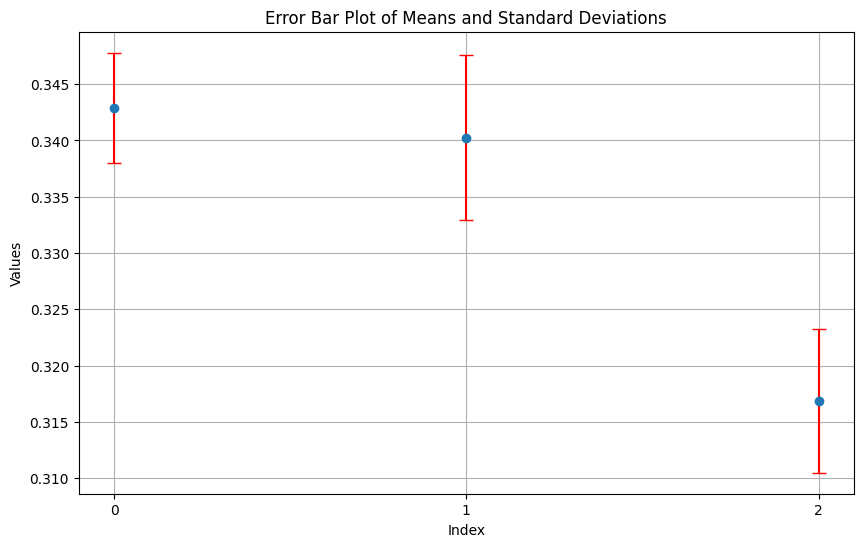

In [31]:
# Convert the list of tensors to a single tensor
data_tensor = torch.stack(proxy_prob)

# Calculate the mean and standard deviation for each index
means = torch.mean(data_tensor, dim=0)
std_devs = torch.std(data_tensor, dim=0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

means_np = means.cpu().detach().numpy()
std_devs_np = std_devs.cpu().detach().numpy()


# Data for plotting
indices = range(0, 3)

# Creating error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(indices, means_np[0], yerr=std_devs_np[0] * 10, fmt='o', ecolor='red', capsize=5)
plt.title('Error Bar Plot of Means and Standard Deviations')
plt.xlabel('Index')
plt.ylabel('Values')
plt.xticks(indices)
plt.grid(True)
plt.show()



In [32]:
print(episode_actions)
print(episode_rewards)

[array([0]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([2]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([2]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([2]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([2]), array([2]), array([0]), array([0]), array([1]), array([1]), array([2]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([2]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([2]), array([0]), array([0]), array([0]), array([0]), array([0]), array([2]), array([1]), array([0]), array([1]), array([2]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([2]), array([1]), array([0]), arr

In [33]:
sum(episode_rewards)

array([2948.571], dtype=float32)

In [36]:
count1 = 0
count2 = 0
count3 = 0
for i in range(len(steps)):
    if steps[i] == 1:
        count1+=1
    elif steps[i] == 2:
        count2+=1
    else:
        count3+=1
print(count1)
print(count2)
print(count3)

18
282
0


: 